## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.firstFrame = True

#This function calibrates the camera and undistorts the images taken by that camera.
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

#This function pipeline takes the an undisorted image and uses color and gradient thresholding to
# create a binary image. Specifically, It uses the L and S channel from the HLS colorspace and V 
# channel from the HSV colorspace.

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    filter_img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
   
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    v_channel = hsv[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    svbinary = np.zeros_like(v_channel)
    svbinary[(v_channel >= 200) & (v_channel <= 255)] = 1
    
    s_image = np.dstack((sxbinary*255, s_binary*255, svbinary*255))
    
    binary_image = cv2.bitwise_or(sxbinary,cv2.bitwise_and(cv2.bitwise_or(sxbinary,s_binary),
                                                          cv2.bitwise_and(s_binary, svbinary))) 
    #plt.figure(figsize=(30,20))
    #plt.subplot(1,5,1)
    #plt.imshow(sxbinary, cmap='gray')
    
    #plt.subplot(1,5,2)
    #plt.imshow(s_binary, cmap='gray')
    
    #plt.subplot(1,5,3)
    #plt.imshow(svbinary, cmap='gray')
    
    #plt.subplot(1,5,4)
    #plt.imshow(gray)
    
    #plt.subplot(1,5,5)
    #plt.imshow(binary_image)
    
    return binary_image, s_image

#This function creates a trapezoid the mask the input image.
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def p_transform(undst_img ,src, dst):
    
    #get the M from src to dst
    M = cv2.getPerspectiveTransform(src, dst)
    
    unwarped = cv2.warpPerspective(undst_img, M, (undst_img.shape[1],undst_img.shape[0]), flags=cv2.INTER_LINEAR)
    
    return unwarped

#This function finds the pixels that makes up the lane lines.
def find_lane_pixels(binary_warped):
    #print('the shape of binary_warped', binary_warped.shape)
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return left_fit, right_fit, out_img

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 25

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return left_fitx, right_fitx, ploty, result

def measure_curvature_real(ploty, leftx, rightx, img_width):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/np.absolute(leftx-rightx) # meters per pixel in x dimension
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    offset = ((leftx[-1] + np.absolute(leftx[-1]-rightx[-1])/2) - img_width/2) *  xm_per_pix
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad, offset

def draw_line_to_road(warped,image,undist,left_fitx, right_fitx, ploty,Minv):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
ex_cal_img = None
# Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname)
    ex_cal_img = img
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)

### And so on and so forth...


This is a moe


In [2]:
#List to store results of the undistorted.


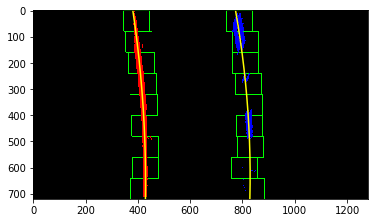

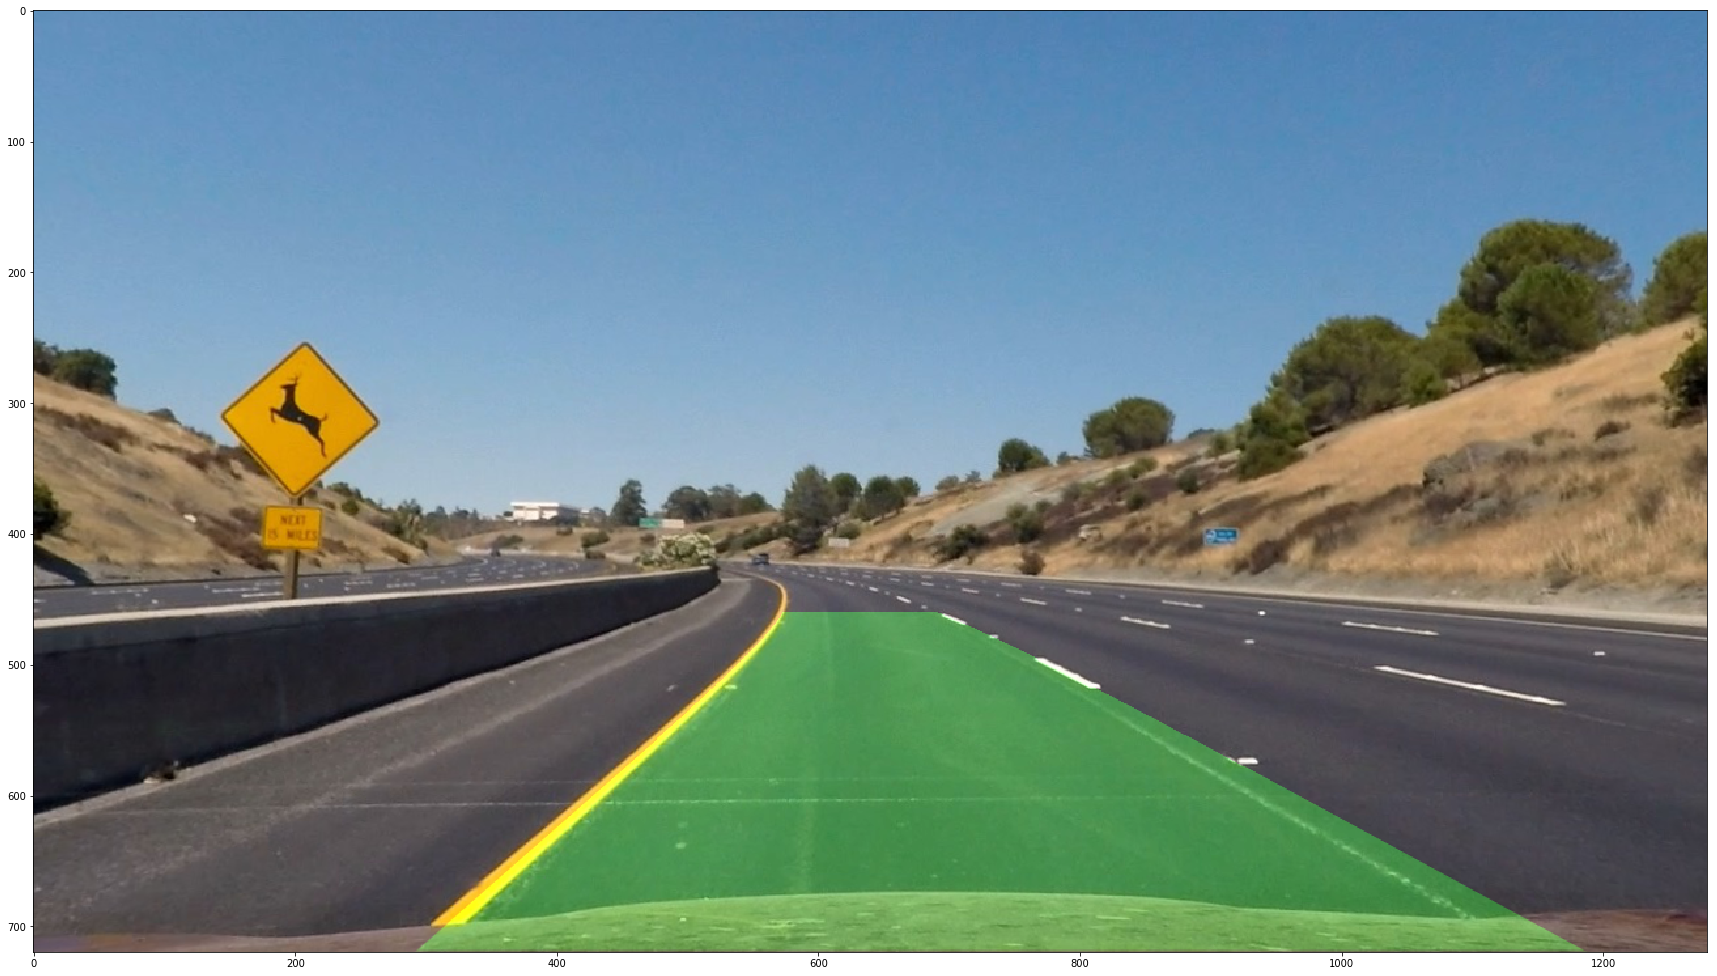

In [3]:
#transform undistorted images into gray scale images
index=0

#empty list of gray undistorted images
binary_img = []

for i in range(len(undistorted)):
    binary_img.append(pipeline(undistorted[i], s_thresh=(170, 255),sx_thresh=(30, 255)))

imshape = binary_img[0][0].shape

#src points for mask and perspective transform.
btm_left = (200,imshape[0])
top_left = (575, 460)
btm_right = (1150,imshape[0])
top_right = (775, 460)

vertices = (np.array([[btm_left,top_left, top_right,btm_right]], 
                             dtype=np.int32))

masked_img = []

for i in range(len(org_img)):
    masked_img.append(region_of_interest(binary_img[0][i], vertices))
    
warped_img = []

#set offset
offset_left = np.absolute((top_left[0]-btm_left[0]))/2

#setting src corner points.
src = np.float32(
                 [btm_left,
                 top_left, 
                 top_right, 
                 btm_right])

dst = np.float32(
                 [(btm_left[0]+offset_left,btm_left[1]),
                 (top_left[0]-offset_left, 0), 
                 (1050, 0),
                 (815, btm_right[1])])

#(top_right[0]+offset_left, 0),
#                 (btm_right[0]-offset_left, 

for i in range(len(org_img)):
    warped_img.append(p_transform(masked_img[i], src, dst))

#left_fit is the polynomial coefficients array based on sliding windows
#right_fit is the polynomial coefficients array based on sliding windows
#out_img is image with x values plotted.
left_fit, right_fit, out_img = fit_polynomial(warped_img[index])



#plt.figure(figsize=(30,20))
plt.imshow(out_img)

#left_fitx is the 
left_fitx, right_fitx, ploty, out_img_new = search_around_poly(warped_img[index], left_fit, right_fit)


left_curve, right_curve, offset = measure_curvature_real(ploty,left_fitx, right_fitx, imshape[1])


#text = 'Left curvature is ' + str(round(left_curve,2)) + ' m and right curve is '+ str(round(right_curve,2))+ ' m.'
#text2 = 'The offset from center is ' + str(round(offset[-1],2)) +' m.'

exMinv = cv2.getPerspectiveTransform(dst, src)


ex_road_img = draw_line_to_road(warped_img[index], org_img[index], undistorted[index], 
                             left_fitx, right_fitx, ploty,exMinv)

#cv2.putText(ex_road_img, text, (0,100),cv2.FONT_HERSHEY_SIMPLEX,1.0, (255, 255, 255), lineType=cv2.LINE_AA)
#cv2.putText(ex_road_img, text2, (0,125),cv2.FONT_HERSHEY_SIMPLEX,1.0, (255, 255, 255), lineType=cv2.LINE_AA)


plt.figure(figsize=(30,20))
plt.imshow(ex_road_img)

In [5]:
def process_image(img):
    undist = cal_undistort(img, objpoints, imgpoints)
    img_binary, img_stack = pipeline(undist, s_thresh=(170, 255),sx_thresh=(30, 255))
    
    #src points for mask and perspective transform.
    btm_left = (200,720)
    top_left = (575, 460)
    btm_right = (1150,720)
    top_right = (775, 460)

    vertices = (np.array([[btm_left,top_left, top_right,btm_right]], 
                             dtype=np.int32))
    
    video_masked_img = (region_of_interest(img_binary, vertices))
    
    
    #set offset
    offset_left = np.absolute((top_left[0]-btm_left[0]))/2

    #setting src corner points.
    src = np.float32(
                 [btm_left,
                 top_left, 
                 top_right, 
                 btm_right])

    dst = np.float32(
                 [(btm_left[0]+offset_left,btm_left[1]),
                 (top_left[0]-offset_left, 0), 
                 (1050, 0),
                 (815, btm_right[1])])

    warped = p_transform(video_masked_img, src, dst)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    left_fit, right_fit, out_img = fit_polynomial(warped)
    
    if (left_line.firstFrame == True and right_line.firstFrame == True):
        left_line.current_fit.append(left_fit)
        right_line.current_fit.append(right_fit)
        prev_left = left_fit
        prev_right = right_fit
        left_line.firstFrame == False
        right_line.firstFrame == False
        prev_left_bf = left_fit
        prev_right_bf = right_fit
    else:
        prev_left = left_line.current_fit[-1]
        prev_right = right_line.current_fit[-1]
        prev_left_bf = left_line.best_fit
        prev_right_bf = right_line.best_fit
    
    left_line.current_fit.append(left_fit)
    right_line.current_fit.append(right_fit)
    
    left_line.diffs = np.subtract(prev_left,left_fit)
    right_line.diffs = np.subtract(prev_right,right_fit) 

    if(abs(left_line.diffs[2]) >= 100):
        del left_line.current_fit[-1]
        left_fitx, right_fitx, ploty, out_img_new = search_around_poly(warped, prev_left_bf, right_fit)
        
    elif(abs(right_line.diffs[2]) >= 50):
        del right_line.current_fit[-1]
        left_fitx, right_fitx, ploty, out_img_new = search_around_poly(warped, left_fit, prev_right_bf)
        
    else:
        left_fitx, right_fitx, ploty, out_img_new = search_around_poly(warped, left_fit, right_fit)
        
    left_line.best_fit = np.average(left_line.current_fit, axis=0)
    right_line.best_fit = np.average(right_line.current_fit, axis=0)
    
    left_line.recent_xfitted.append(left_fitx)
    right_line.recent_xfitted.append(right_fitx)
    
    if(left_line.firstFrame == True and right_line.firstFrame == True):
        left_line.bestx = np.average(left_line.recent_xfitted, axis=0)
        right_line.bestx = np.average(right_line.recent_xfitted, axis=0)
        left_line.firstFrame = False
        right_line.firstFrame = False
    
    left_line.allx = left_fitx
    left_line.ally = ploty

    right_line.allx = right_fitx
    right_line.ally = ploty

    #lanes, ploty, left_fitx, right_fitx, left_curverad, right_curverad, center_dist = 
    # function that detects lines and lane
    left_curve, right_curve, offset = measure_curvature_real(ploty,left_fitx, right_fitx, undist.shape[1])
    
    left_line.radius_of_curvature = left_curve
    right_line.radius_of_curvature = right_curve
    left_line.line_base_pos = offset
    right_line.line_base_pos = offset
    
    diff_lines = np.average(np.absolute(np.subtract(left_line.allx, right_line.allx)), axis=0)
    
    diff_avg = np.average(np.absolute(np.subtract(right_line.bestx, left_line.bestx)), axis=0)

    output = draw_line_to_road(warped, img, undist,left_fitx, right_fitx, ploty,Minv)
    
    left_curve, right_curve, new_offset = measure_curvature_real(ploty,left_fitx, right_fitx, undist.shape[1])
    
    text = 'Left curvature is ' + str(round(left_curve,2)) + ' m and right curve is '+ str(round(right_curve,2))+ ' m.'
    text2 = 'The offset from center is ' + str(round(offset[-1],2)) +' m.'
        
    cv2.putText(output, text, (0,100),cv2.FONT_HERSHEY_SIMPLEX,1.0, (255, 255, 255), lineType=cv2.LINE_AA)
    cv2.putText(output, text2, (0,125),cv2.FONT_HERSHEY_SIMPLEX,1.0, (255, 255, 255), lineType=cv2.LINE_AA)
    
    output1 = cv2.resize(img_stack,(640, 360), interpolation = cv2.INTER_AREA)
    output2 = cv2.resize(out_img_new,(640, 360), interpolation = cv2.INTER_AREA)
        
    return output

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

 left line last fit coefficients: [ -1.00860436e-04   1.32921479e-01   3.82588649e+02]
                   prev left_fit: [ -1.00860436e-04   1.32921479e-01   3.82588649e+02]
right line last fit coefficients: [ -1.17343796e-04   1.65404091e-01   7.78617190e+02]
                  prev right_fit: [ -1.17343796e-04   1.65404091e-01   7.78617190e+02]
[MoviePy] >>>> Building video output_images/video_result_resubmit2.mp4
[MoviePy] Writing video output_images/video_result_resubmit2.mp4


  0%|          | 1/1261 [00:01<29:59,  1.43s/it]

 left line last fit coefficients: [ -1.00860436e-04   1.32921479e-01   3.82588649e+02]
                   prev left_fit: [ -1.00860436e-04   1.32921479e-01   3.82588649e+02]
right line last fit coefficients: [ -1.17343796e-04   1.65404091e-01   7.78617190e+02]
                  prev right_fit: [ -1.17343796e-04   1.65404091e-01   7.78617190e+02]


  0%|          | 2/1261 [00:02<30:05,  1.43s/it]

 left line last fit coefficients: [ -1.00860436e-04   1.32921479e-01   3.82588649e+02]
                   prev left_fit: [ -1.15647593e-04   1.45719869e-01   3.81024109e+02]
right line last fit coefficients: [ -1.17343796e-04   1.65404091e-01   7.78617190e+02]
                  prev right_fit: [ -1.13953695e-04   1.67538217e-01   7.75169961e+02]


  0%|          | 3/1261 [00:04<30:04,  1.43s/it]

 left line last fit coefficients: [ -1.15647593e-04   1.45719869e-01   3.81024109e+02]
                   prev left_fit: [ -1.21412514e-04   1.51794191e-01   3.80040638e+02]
right line last fit coefficients: [ -1.13953695e-04   1.67538217e-01   7.75169961e+02]
                  prev right_fit: [ -1.76021868e-04   2.23859010e-01   7.62450707e+02]


  0%|          | 4/1261 [00:05<30:05,  1.44s/it]

 left line last fit coefficients: [ -1.21412514e-04   1.51794191e-01   3.80040638e+02]
                   prev left_fit: [ -1.23049771e-04   1.54540589e-01   3.79597213e+02]
right line last fit coefficients: [ -1.76021868e-04   2.23859010e-01   7.62450707e+02]
                  prev right_fit: [ -1.71955702e-04   2.27142265e-01   7.58315088e+02]


  0%|          | 5/1261 [00:07<30:00,  1.43s/it]

 left line last fit coefficients: [ -1.23049771e-04   1.54540589e-01   3.79597213e+02]
                   prev left_fit: [ -1.25133681e-04   1.58371105e-01   3.78323140e+02]
right line last fit coefficients: [ -1.71955702e-04   2.27142265e-01   7.58315088e+02]
                  prev right_fit: [ -1.61134705e-04   2.19214394e-01   7.58631374e+02]


  0%|          | 6/1261 [00:08<29:57,  1.43s/it]

 left line last fit coefficients: [ -1.25133681e-04   1.58371105e-01   3.78323140e+02]
                   prev left_fit: [ -1.19302356e-04   1.55653683e-01   3.78755499e+02]
right line last fit coefficients: [ -1.61134705e-04   2.19214394e-01   7.58631374e+02]
                  prev right_fit: [ -1.40264938e-04   2.06982316e-01   7.57582225e+02]


  1%|          | 7/1261 [00:10<29:54,  1.43s/it]

 left line last fit coefficients: [ -1.19302356e-04   1.55653683e-01   3.78755499e+02]
                   prev left_fit: [ -1.12819990e-04   1.54321697e-01   3.77318162e+02]
right line last fit coefficients: [ -1.40264938e-04   2.06982316e-01   7.57582225e+02]
                  prev right_fit: [ -6.84489024e-05   1.68971181e-01   7.62242490e+02]


  1%|          | 8/1261 [00:11<29:53,  1.43s/it]

 left line last fit coefficients: [ -1.12819990e-04   1.54321697e-01   3.77318162e+02]
                   prev left_fit: [ -1.18372233e-04   1.62472279e-01   3.75545907e+02]
right line last fit coefficients: [ -6.84489024e-05   1.68971181e-01   7.62242490e+02]
                  prev right_fit: [ -8.13889324e-06   1.36911766e-01   7.61886748e+02]


  1%|          | 9/1261 [00:12<29:52,  1.43s/it]

 left line last fit coefficients: [ -1.18372233e-04   1.62472279e-01   3.75545907e+02]
                   prev left_fit: [ -1.02412474e-04   1.51241379e-01   3.75727633e+02]
right line last fit coefficients: [ -8.13889324e-06   1.36911766e-01   7.61886748e+02]
                  prev right_fit: [ -1.82832185e-05   1.33333420e-01   7.65981847e+02]


  1%|          | 10/1261 [00:14<29:52,  1.43s/it]

 left line last fit coefficients: [ -1.02412474e-04   1.51241379e-01   3.75727633e+02]
                   prev left_fit: [ -1.01479626e-04   1.52651060e-01   3.73937258e+02]
right line last fit coefficients: [ -1.82832185e-05   1.33333420e-01   7.65981847e+02]
                  prev right_fit: [ -3.68309085e-06   1.22370785e-01   7.66840171e+02]


  1%|          | 11/1261 [00:15<29:46,  1.43s/it]

 left line last fit coefficients: [ -1.01479626e-04   1.52651060e-01   3.73937258e+02]
                   prev left_fit: [ -1.04342604e-04   1.57696260e-01   3.72036656e+02]
right line last fit coefficients: [ -3.68309085e-06   1.22370785e-01   7.66840171e+02]
                  prev right_fit: [ -4.91264730e-05   1.52004168e-01   7.60946053e+02]


  1%|          | 12/1261 [00:17<29:45,  1.43s/it]

 left line last fit coefficients: [ -1.04342604e-04   1.57696260e-01   3.72036656e+02]
                   prev left_fit: [ -8.35201214e-05   1.43476391e-01   3.70902188e+02]
right line last fit coefficients: [ -4.91264730e-05   1.52004168e-01   7.60946053e+02]
                  prev right_fit: [ -2.48398559e-05   1.20324183e-01   7.74321966e+02]


  1%|          | 13/1261 [00:18<29:43,  1.43s/it]

 left line last fit coefficients: [ -8.35201214e-05   1.43476391e-01   3.70902188e+02]
                   prev left_fit: [ -7.57581889e-05   1.38206767e-01   3.71365202e+02]
right line last fit coefficients: [ -2.48398559e-05   1.20324183e-01   7.74321966e+02]
                  prev right_fit: [ -4.59516941e-05   1.36434517e-01   7.69403515e+02]


  1%|          | 14/1261 [00:20<29:41,  1.43s/it]

 left line last fit coefficients: [ -7.57581889e-05   1.38206767e-01   3.71365202e+02]
                   prev left_fit: [ -7.17068795e-05   1.35694992e-01   3.71214039e+02]
right line last fit coefficients: [ -4.59516941e-05   1.36434517e-01   7.69403515e+02]
                  prev right_fit: [ -4.54664894e-05   1.38311376e-01   7.66982266e+02]


  1%|          | 15/1261 [00:21<29:43,  1.43s/it]

 left line last fit coefficients: [ -7.17068795e-05   1.35694992e-01   3.71214039e+02]
                   prev left_fit: [ -6.47563806e-05   1.28496014e-01   3.73619942e+02]
right line last fit coefficients: [ -4.54664894e-05   1.38311376e-01   7.66982266e+02]
                  prev right_fit: [ -1.00197327e-04   1.91436327e-01   7.50784287e+02]


  1%|▏         | 16/1261 [00:22<29:44,  1.43s/it]

 left line last fit coefficients: [ -6.47563806e-05   1.28496014e-01   3.73619942e+02]
                   prev left_fit: [ -5.25223587e-05   1.17077506e-01   3.76575887e+02]
right line last fit coefficients: [ -1.00197327e-04   1.91436327e-01   7.50784287e+02]
                  prev right_fit: [ -1.32374207e-04   2.27440243e-01   7.37280607e+02]


  1%|▏         | 17/1261 [00:24<29:44,  1.43s/it]

 left line last fit coefficients: [ -5.25223587e-05   1.17077506e-01   3.76575887e+02]
                   prev left_fit: [ -6.72699676e-05   1.29909170e-01   3.73391144e+02]
right line last fit coefficients: [ -1.32374207e-04   2.27440243e-01   7.37280607e+02]
                  prev right_fit: [ -1.21623474e-04   2.18457185e-01   7.37525096e+02]


  1%|▏         | 18/1261 [00:25<29:40,  1.43s/it]

 left line last fit coefficients: [ -6.72699676e-05   1.29909170e-01   3.73391144e+02]
                   prev left_fit: [ -6.68054173e-05   1.29967707e-01   3.72972002e+02]
right line last fit coefficients: [ -1.21623474e-04   2.18457185e-01   7.37525096e+02]
                  prev right_fit: [ -1.02538056e-04   2.04662809e-01   7.37089905e+02]


  2%|▏         | 19/1261 [00:27<29:55,  1.45s/it]

 left line last fit coefficients: [ -6.68054173e-05   1.29967707e-01   3.72972002e+02]
                   prev left_fit: [ -5.03585560e-05   1.17278010e-01   3.73604591e+02]
right line last fit coefficients: [ -1.02538056e-04   2.04662809e-01   7.37089905e+02]
                  prev right_fit: [ -9.94884812e-05   1.91807725e-01   7.43729736e+02]


  2%|▏         | 20/1261 [00:28<29:47,  1.44s/it]

 left line last fit coefficients: [ -5.03585560e-05   1.17278010e-01   3.73604591e+02]
                   prev left_fit: [ -3.65248763e-05   1.05749472e-01   3.74266912e+02]
right line last fit coefficients: [ -9.94884812e-05   1.91807725e-01   7.43729736e+02]
                  prev right_fit: [ -5.49123967e-05   1.63565147e-01   7.49441422e+02]


  2%|▏         | 21/1261 [00:30<29:45,  1.44s/it]

 left line last fit coefficients: [ -3.65248763e-05   1.05749472e-01   3.74266912e+02]
                   prev left_fit: [ -1.66026159e-05   8.87304198e-02   3.76094396e+02]
right line last fit coefficients: [ -5.49123967e-05   1.63565147e-01   7.49441422e+02]
                  prev right_fit: [ -4.23671680e-05   1.47119480e-01   7.56477384e+02]


  2%|▏         | 22/1261 [00:31<29:39,  1.44s/it]

 left line last fit coefficients: [ -1.66026159e-05   8.87304198e-02   3.76094396e+02]
                   prev left_fit: [ -3.68441556e-07   7.41674651e-02   3.77161358e+02]
right line last fit coefficients: [ -4.23671680e-05   1.47119480e-01   7.56477384e+02]
                  prev right_fit: [ -5.63227118e-05   1.44296864e-01   7.63020559e+02]


  2%|▏         | 23/1261 [00:32<29:35,  1.43s/it]

 left line last fit coefficients: [ -3.68441556e-07   7.41674651e-02   3.77161358e+02]
                   prev left_fit: [  1.75937500e-05   5.65272649e-02   3.79504016e+02]
right line last fit coefficients: [ -5.63227118e-05   1.44296864e-01   7.63020559e+02]
                  prev right_fit: [ -5.64787027e-05   1.36327641e-01   7.67995679e+02]


  2%|▏         | 24/1261 [00:34<29:33,  1.43s/it]

 left line last fit coefficients: [  1.75937500e-05   5.65272649e-02   3.79504016e+02]
                   prev left_fit: [  3.54355140e-06   6.50128697e-02   3.78940344e+02]
right line last fit coefficients: [ -5.64787027e-05   1.36327641e-01   7.67995679e+02]
                  prev right_fit: [ -1.24432052e-04   1.86402808e-01   7.58478272e+02]


  2%|▏         | 25/1261 [00:35<29:28,  1.43s/it]

 left line last fit coefficients: [  3.54355140e-06   6.50128697e-02   3.78940344e+02]
                   prev left_fit: [ -9.68670172e-06   7.27083257e-02   3.78669391e+02]
right line last fit coefficients: [ -1.24432052e-04   1.86402808e-01   7.58478272e+02]
                  prev right_fit: [ -1.30782198e-04   1.94210573e-01   7.55791484e+02]


  2%|▏         | 26/1261 [00:37<29:22,  1.43s/it]

 left line last fit coefficients: [ -9.68670172e-06   7.27083257e-02   3.78669391e+02]
                   prev left_fit: [ -6.97688593e-07   6.19164308e-02   3.80219579e+02]
right line last fit coefficients: [ -1.30782198e-04   1.94210573e-01   7.55791484e+02]
                  prev right_fit: [ -1.02395991e-04   1.64438493e-01   7.66116563e+02]


  2%|▏         | 27/1261 [00:38<29:20,  1.43s/it]

 left line last fit coefficients: [ -6.97688593e-07   6.19164308e-02   3.80219579e+02]
                   prev left_fit: [ -1.03486734e-05   6.71068806e-02   3.79827421e+02]
right line last fit coefficients: [ -1.02395991e-04   1.64438493e-01   7.66116563e+02]
                  prev right_fit: [ -8.49507189e-05   1.50413040e-01   7.69090515e+02]


  2%|▏         | 28/1261 [00:40<29:16,  1.42s/it]

 left line last fit coefficients: [ -1.03486734e-05   6.71068806e-02   3.79827421e+02]
                   prev left_fit: [ -2.23625685e-06   5.82881634e-02   3.80432722e+02]
right line last fit coefficients: [ -8.49507189e-05   1.50413040e-01   7.69090515e+02]
                  prev right_fit: [ -8.61788496e-05   1.38688073e-01   7.78383128e+02]


  2%|▏         | 29/1261 [00:41<29:14,  1.42s/it]

 left line last fit coefficients: [ -2.23625685e-06   5.82881634e-02   3.80432722e+02]
                   prev left_fit: [ -2.79362059e-05   7.87833545e-02   3.77886334e+02]
right line last fit coefficients: [ -8.61788496e-05   1.38688073e-01   7.78383128e+02]
                  prev right_fit: [ -1.16932409e-04   1.68022737e-01   7.70725013e+02]


  2%|▏         | 30/1261 [00:42<29:14,  1.43s/it]

 left line last fit coefficients: [ -2.79362059e-05   7.87833545e-02   3.77886334e+02]
                   prev left_fit: [ -5.88705754e-05   1.02264475e-01   3.75450969e+02]
right line last fit coefficients: [ -1.16932409e-04   1.68022737e-01   7.70725013e+02]
                  prev right_fit: [ -1.57578339e-04   2.11304441e-01   7.58051486e+02]


  2%|▏         | 31/1261 [00:44<29:15,  1.43s/it]

 left line last fit coefficients: [ -5.88705754e-05   1.02264475e-01   3.75450969e+02]
                   prev left_fit: [ -7.89567105e-05   1.18682611e-01   3.74102649e+02]
right line last fit coefficients: [ -1.57578339e-04   2.11304441e-01   7.58051486e+02]
                  prev right_fit: [ -1.60638020e-04   2.22571891e-01   7.51083130e+02]


  3%|▎         | 32/1261 [00:45<29:11,  1.43s/it]

 left line last fit coefficients: [ -7.89567105e-05   1.18682611e-01   3.74102649e+02]
                   prev left_fit: [ -1.02845881e-04   1.37306429e-01   3.72842952e+02]
right line last fit coefficients: [ -1.60638020e-04   2.22571891e-01   7.51083130e+02]
                  prev right_fit: [ -1.37674140e-04   2.15210591e-01   7.45769163e+02]


  3%|▎         | 33/1261 [00:47<29:21,  1.43s/it]

 left line last fit coefficients: [ -1.02845881e-04   1.37306429e-01   3.72842952e+02]
                   prev left_fit: [ -8.57145187e-05   1.22480576e-01   3.74994450e+02]
right line last fit coefficients: [ -1.37674140e-04   2.15210591e-01   7.45769163e+02]
                  prev right_fit: [ -8.05043956e-05   1.76964216e-01   7.55157387e+02]


  3%|▎         | 34/1261 [00:48<29:14,  1.43s/it]

 left line last fit coefficients: [ -8.57145187e-05   1.22480576e-01   3.74994450e+02]
                   prev left_fit: [ -1.03361761e-04   1.38501875e-01   3.72804880e+02]
right line last fit coefficients: [ -8.05043956e-05   1.76964216e-01   7.55157387e+02]
                  prev right_fit: [ -2.80559714e-05   1.47713101e-01   7.55986438e+02]


  3%|▎         | 35/1261 [00:50<29:08,  1.43s/it]

 left line last fit coefficients: [ -1.03361761e-04   1.38501875e-01   3.72804880e+02]
                   prev left_fit: [ -1.06579723e-04   1.42020039e-01   3.72830128e+02]
right line last fit coefficients: [ -2.80559714e-05   1.47713101e-01   7.55986438e+02]
                  prev right_fit: [ -5.98444733e-05   1.64695579e-01   7.54042011e+02]


  3%|▎         | 36/1261 [00:51<29:08,  1.43s/it]

 left line last fit coefficients: [ -1.06579723e-04   1.42020039e-01   3.72830128e+02]
                   prev left_fit: [ -1.16181561e-04   1.51672318e-01   3.71902744e+02]
right line last fit coefficients: [ -5.98444733e-05   1.64695579e-01   7.54042011e+02]
                  prev right_fit: [ -1.35239802e-04   2.18038963e-01   7.43876606e+02]


  3%|▎         | 37/1261 [00:52<29:09,  1.43s/it]

 left line last fit coefficients: [ -1.16181561e-04   1.51672318e-01   3.71902744e+02]
                   prev left_fit: [ -1.25106600e-04   1.61074951e-01   3.70157309e+02]
right line last fit coefficients: [ -1.35239802e-04   2.18038963e-01   7.43876606e+02]
                  prev right_fit: [ -1.24041193e-04   2.10497607e-01   7.43977086e+02]


  3%|▎         | 38/1261 [00:54<29:05,  1.43s/it]

 left line last fit coefficients: [ -1.25106600e-04   1.61074951e-01   3.70157309e+02]
                   prev left_fit: [ -1.32481255e-04   1.67482086e-01   3.69922806e+02]
right line last fit coefficients: [ -1.24041193e-04   2.10497607e-01   7.43977086e+02]
                  prev right_fit: [ -1.03922872e-04   2.01641248e-01   7.42365443e+02]


  3%|▎         | 39/1261 [00:55<29:01,  1.43s/it]

 left line last fit coefficients: [ -1.32481255e-04   1.67482086e-01   3.69922806e+02]
                   prev left_fit: [ -1.42532283e-04   1.77448524e-01   3.68399159e+02]
right line last fit coefficients: [ -1.03922872e-04   2.01641248e-01   7.42365443e+02]
                  prev right_fit: [ -1.67622502e-04   2.56052226e-01   7.29698715e+02]


  3%|▎         | 40/1261 [00:57<28:56,  1.42s/it]

 left line last fit coefficients: [ -1.42532283e-04   1.77448524e-01   3.68399159e+02]
                   prev left_fit: [ -1.43505650e-04   1.81065796e-01   3.66533871e+02]
right line last fit coefficients: [ -1.67622502e-04   2.56052226e-01   7.29698715e+02]
                  prev right_fit: [ -2.02160021e-04   2.83868748e-01   7.26055190e+02]


  3%|▎         | 41/1261 [00:58<28:55,  1.42s/it]

 left line last fit coefficients: [ -1.43505650e-04   1.81065796e-01   3.66533871e+02]
                   prev left_fit: [ -1.47197878e-04   1.86279335e-01   3.65076317e+02]
right line last fit coefficients: [ -2.02160021e-04   2.83868748e-01   7.26055190e+02]
                  prev right_fit: [ -1.80088594e-04   2.66746862e-01   7.28613478e+02]


  3%|▎         | 42/1261 [01:00<28:53,  1.42s/it]

 left line last fit coefficients: [ -1.47197878e-04   1.86279335e-01   3.65076317e+02]
                   prev left_fit: [ -1.48300123e-04   1.89928346e-01   3.63813425e+02]
right line last fit coefficients: [ -1.80088594e-04   2.66746862e-01   7.28613478e+02]
                  prev right_fit: [ -1.61531122e-04   2.49754979e-01   7.32075820e+02]


  3%|▎         | 43/1261 [01:01<30:32,  1.50s/it]

 left line last fit coefficients: [ -1.48300123e-04   1.89928346e-01   3.63813425e+02]
                   prev left_fit: [ -1.51992299e-04   1.95741379e-01   3.61703935e+02]
right line last fit coefficients: [ -1.61531122e-04   2.49754979e-01   7.32075820e+02]
                  prev right_fit: [ -1.70437014e-04   2.55795464e-01   7.32692131e+02]


  3%|▎         | 44/1261 [01:03<30:27,  1.50s/it]

 left line last fit coefficients: [ -1.51992299e-04   1.95741379e-01   3.61703935e+02]
                   prev left_fit: [ -1.46465652e-04   1.93856345e-01   3.60321676e+02]
right line last fit coefficients: [ -1.70437014e-04   2.55795464e-01   7.32692131e+02]
                  prev right_fit: [ -1.66411259e-04   2.42533736e-01   7.39488916e+02]


  4%|▎         | 45/1261 [01:04<30:45,  1.52s/it]

 left line last fit coefficients: [ -1.46465652e-04   1.93856345e-01   3.60321676e+02]
                   prev left_fit: [ -1.44895141e-04   1.95517261e-01   3.58574786e+02]
right line last fit coefficients: [ -1.66411259e-04   2.42533736e-01   7.39488916e+02]
                  prev right_fit: [ -1.13595753e-04   2.10033123e-01   7.45461359e+02]


  4%|▎         | 46/1261 [01:06<30:49,  1.52s/it]

 left line last fit coefficients: [ -1.44895141e-04   1.95517261e-01   3.58574786e+02]
                   prev left_fit: [ -1.44661634e-04   1.97223346e-01   3.57360420e+02]
right line last fit coefficients: [ -1.13595753e-04   2.10033123e-01   7.45461359e+02]
                  prev right_fit: [ -7.66157109e-05   1.84072630e-01   7.49229432e+02]


  4%|▎         | 47/1261 [01:07<30:32,  1.51s/it]

 left line last fit coefficients: [ -1.44661634e-04   1.97223346e-01   3.57360420e+02]
                   prev left_fit: [ -1.37225410e-04   1.92972941e-01   3.56603487e+02]
right line last fit coefficients: [ -7.66157109e-05   1.84072630e-01   7.49229432e+02]
                  prev right_fit: [ -7.82447198e-05   1.80616935e-01   7.51420046e+02]


  4%|▍         | 48/1261 [01:09<30:36,  1.51s/it]

 left line last fit coefficients: [ -1.37225410e-04   1.92972941e-01   3.56603487e+02]
                   prev left_fit: [ -1.36097781e-04   1.93725564e-01   3.56049601e+02]
right line last fit coefficients: [ -7.82447198e-05   1.80616935e-01   7.51420046e+02]
                  prev right_fit: [ -5.83546997e-05   1.68700603e-01   7.50468056e+02]


  4%|▍         | 49/1261 [01:10<30:16,  1.50s/it]

 left line last fit coefficients: [ -1.36097781e-04   1.93725564e-01   3.56049601e+02]
                   prev left_fit: [ -1.32893732e-04   1.95210869e-01   3.52997851e+02]
right line last fit coefficients: [ -5.83546997e-05   1.68700603e-01   7.50468056e+02]
                  prev right_fit: [ -1.14623801e-04   1.96594521e-01   7.52186029e+02]


  4%|▍         | 50/1261 [01:12<30:24,  1.51s/it]

 left line last fit coefficients: [ -1.32893732e-04   1.95210869e-01   3.52997851e+02]
                   prev left_fit: [ -1.27594519e-04   1.92577927e-01   3.52823205e+02]
right line last fit coefficients: [ -1.14623801e-04   1.96594521e-01   7.52186029e+02]
                  prev right_fit: [ -1.45372568e-04   2.24012159e-01   7.45810815e+02]


  4%|▍         | 51/1261 [01:13<30:10,  1.50s/it]

 left line last fit coefficients: [ -1.27594519e-04   1.92577927e-01   3.52823205e+02]
                   prev left_fit: [ -1.15034784e-04   1.83093200e-01   3.53684490e+02]
right line last fit coefficients: [ -1.45372568e-04   2.24012159e-01   7.45810815e+02]
                  prev right_fit: [ -1.07641985e-04   1.96307343e-01   7.49434707e+02]


  4%|▍         | 52/1261 [01:15<30:14,  1.50s/it]

 left line last fit coefficients: [ -1.15034784e-04   1.83093200e-01   3.53684490e+02]
                   prev left_fit: [ -1.18316940e-04   1.87410605e-01   3.52700117e+02]
right line last fit coefficients: [ -1.07641985e-04   1.96307343e-01   7.49434707e+02]
                  prev right_fit: [ -9.63724174e-05   1.93528229e-01   7.45224532e+02]


  4%|▍         | 53/1261 [01:16<30:04,  1.49s/it]

 left line last fit coefficients: [ -1.18316940e-04   1.87410605e-01   3.52700117e+02]
                   prev left_fit: [ -8.62103195e-05   1.56122901e-01   3.59687949e+02]
right line last fit coefficients: [ -9.63724174e-05   1.93528229e-01   7.45224532e+02]
                  prev right_fit: [ -1.52287802e-04   2.40390088e-01   7.35525264e+02]


  4%|▍         | 54/1261 [01:18<30:10,  1.50s/it]

 left line last fit coefficients: [ -8.62103195e-05   1.56122901e-01   3.59687949e+02]
                   prev left_fit: [ -7.27311409e-05   1.44655665e-01   3.61271153e+02]
right line last fit coefficients: [ -1.52287802e-04   2.40390088e-01   7.35525264e+02]
                  prev right_fit: [ -1.74301134e-04   2.63299311e-01   7.28629356e+02]


  4%|▍         | 55/1261 [01:19<30:00,  1.49s/it]

 left line last fit coefficients: [ -7.27311409e-05   1.44655665e-01   3.61271153e+02]
                   prev left_fit: [ -6.24790570e-05   1.35038113e-01   3.62507313e+02]
right line last fit coefficients: [ -1.74301134e-04   2.63299311e-01   7.28629356e+02]
                  prev right_fit: [ -1.66194784e-04   2.55539674e-01   7.30733129e+02]


  4%|▍         | 56/1261 [01:21<30:05,  1.50s/it]

 left line last fit coefficients: [ -6.24790570e-05   1.35038113e-01   3.62507313e+02]
                   prev left_fit: [ -4.80567136e-05   1.21184674e-01   3.64822976e+02]
right line last fit coefficients: [ -1.66194784e-04   2.55539674e-01   7.30733129e+02]
                  prev right_fit: [ -1.52276793e-04   2.39929763e-01   7.34836400e+02]


  5%|▍         | 57/1261 [01:22<30:13,  1.51s/it]

 left line last fit coefficients: [ -4.80567136e-05   1.21184674e-01   3.64822976e+02]
                   prev left_fit: [ -3.57073784e-05   1.09516459e-01   3.66979623e+02]
right line last fit coefficients: [ -1.52276793e-04   2.39929763e-01   7.34836400e+02]
                  prev right_fit: [ -1.42679658e-04   2.34849327e-01   7.34369796e+02]


  5%|▍         | 58/1261 [01:24<30:02,  1.50s/it]

 left line last fit coefficients: [ -3.57073784e-05   1.09516459e-01   3.66979623e+02]
                   prev left_fit: [ -1.88987965e-05   9.25765803e-02   3.70247991e+02]
right line last fit coefficients: [ -1.42679658e-04   2.34849327e-01   7.34369796e+02]
                  prev right_fit: [ -3.36039648e-05   1.76413650e-01   7.39881339e+02]


  5%|▍         | 59/1261 [01:25<30:05,  1.50s/it]

 left line last fit coefficients: [ -1.88987965e-05   9.25765803e-02   3.70247991e+02]
                   prev left_fit: [ -1.92980160e-05   9.08088476e-02   3.72076664e+02]
right line last fit coefficients: [ -3.36039648e-05   1.76413650e-01   7.39881339e+02]
                  prev right_fit: [ -4.43066965e-05   1.86831392e-01   7.32165855e+02]


  5%|▍         | 60/1261 [01:27<30:22,  1.52s/it]

 left line last fit coefficients: [ -1.92980160e-05   9.08088476e-02   3.72076664e+02]
                   prev left_fit: [ -1.51066136e-05   8.37097266e-02   3.74962525e+02]
right line last fit coefficients: [ -4.43066965e-05   1.86831392e-01   7.32165855e+02]
                  prev right_fit: [ -9.26657548e-05   2.19613768e-01   7.23068933e+02]


  5%|▍         | 61/1261 [01:28<30:11,  1.51s/it]

 left line last fit coefficients: [ -1.51066136e-05   8.37097266e-02   3.74962525e+02]
                   prev left_fit: [ -1.77151939e-05   8.21028052e-02   3.76299238e+02]
right line last fit coefficients: [ -9.26657548e-05   2.19613768e-01   7.23068933e+02]
                  prev right_fit: [ -6.77861134e-05   2.00619379e-01   7.24683119e+02]


  5%|▍         | 62/1261 [01:30<30:19,  1.52s/it]

 left line last fit coefficients: [ -1.77151939e-05   8.21028052e-02   3.76299238e+02]
                   prev left_fit: [ -2.87855271e-05   8.79404595e-02   3.76715540e+02]
right line last fit coefficients: [ -6.77861134e-05   2.00619379e-01   7.24683119e+02]
                  prev right_fit: [ -9.18547745e-05   2.20410482e-01   7.18378505e+02]


  5%|▍         | 63/1261 [01:31<30:04,  1.51s/it]

 left line last fit coefficients: [ -2.87855271e-05   8.79404595e-02   3.76715540e+02]
                   prev left_fit: [ -3.11863950e-05   8.81952906e-02   3.76353244e+02]
right line last fit coefficients: [ -9.18547745e-05   2.20410482e-01   7.18378505e+02]
                  prev right_fit: [ -1.04902219e-04   2.22140183e-01   7.21767413e+02]


  5%|▌         | 64/1261 [01:33<30:09,  1.51s/it]

 left line last fit coefficients: [ -3.11863950e-05   8.81952906e-02   3.76353244e+02]
                   prev left_fit: [ -4.41842219e-05   9.65555278e-02   3.76048880e+02]
right line last fit coefficients: [ -1.04902219e-04   2.22140183e-01   7.21767413e+02]
                  prev right_fit: [ -1.57862527e-04   2.66560319e-01   7.12515527e+02]


  5%|▌         | 65/1261 [01:34<30:10,  1.51s/it]

 left line last fit coefficients: [ -4.41842219e-05   9.65555278e-02   3.76048880e+02]
                   prev left_fit: [ -5.20434732e-05   1.01123291e-01   3.74902792e+02]
right line last fit coefficients: [ -1.57862527e-04   2.66560319e-01   7.12515527e+02]
                  prev right_fit: [ -1.33298950e-04   2.39324298e-01   7.20498985e+02]


  5%|▌         | 66/1261 [01:36<29:58,  1.51s/it]

 left line last fit coefficients: [ -5.20434732e-05   1.01123291e-01   3.74902792e+02]
                   prev left_fit: [ -6.91837602e-05   1.13534546e-01   3.73662873e+02]
right line last fit coefficients: [ -1.33298950e-04   2.39324298e-01   7.20498985e+02]
                  prev right_fit: [ -1.26004044e-04   2.35290515e-01   7.19427458e+02]


  5%|▌         | 67/1261 [01:38<31:16,  1.57s/it]

 left line last fit coefficients: [ -6.91837602e-05   1.13534546e-01   3.73662873e+02]
                   prev left_fit: [ -7.02393356e-05   1.13178809e-01   3.73646289e+02]
right line last fit coefficients: [ -1.26004044e-04   2.35290515e-01   7.19427458e+02]
                  prev right_fit: [ -1.15004098e-04   2.20638979e-01   7.23076642e+02]


  5%|▌         | 68/1261 [01:39<30:56,  1.56s/it]

 left line last fit coefficients: [ -7.02393356e-05   1.13178809e-01   3.73646289e+02]
                   prev left_fit: [ -8.01538920e-05   1.20266848e-01   3.71636852e+02]
right line last fit coefficients: [ -1.15004098e-04   2.20638979e-01   7.23076642e+02]
                  prev right_fit: [ -1.03168782e-04   2.04202242e-01   7.28398039e+02]


  5%|▌         | 69/1261 [01:41<30:36,  1.54s/it]

 left line last fit coefficients: [ -8.01538920e-05   1.20266848e-01   3.71636852e+02]
                   prev left_fit: [ -9.80779145e-05   1.35203845e-01   3.69621403e+02]
right line last fit coefficients: [ -1.03168782e-04   2.04202242e-01   7.28398039e+02]
                  prev right_fit: [ -8.84957425e-05   1.95084743e-01   7.26822730e+02]


  6%|▌         | 70/1261 [01:42<30:29,  1.54s/it]

 left line last fit coefficients: [ -9.80779145e-05   1.35203845e-01   3.69621403e+02]
                   prev left_fit: [ -9.88945374e-05   1.36908065e-01   3.67692901e+02]
right line last fit coefficients: [ -8.84957425e-05   1.95084743e-01   7.26822730e+02]
                  prev right_fit: [ -7.92729776e-05   1.77890552e-01   7.34576689e+02]


  6%|▌         | 71/1261 [01:44<30:10,  1.52s/it]

 left line last fit coefficients: [ -9.88945374e-05   1.36908065e-01   3.67692901e+02]
                   prev left_fit: [ -1.00250322e-04   1.38625774e-01   3.67356388e+02]
right line last fit coefficients: [ -7.92729776e-05   1.77890552e-01   7.34576689e+02]
                  prev right_fit: [ -6.06639347e-05   1.70819729e-01   7.33776990e+02]


  6%|▌         | 72/1261 [01:45<30:08,  1.52s/it]

 left line last fit coefficients: [ -1.00250322e-04   1.38625774e-01   3.67356388e+02]
                   prev left_fit: [ -8.47041808e-05   1.26176677e-01   3.68387861e+02]
right line last fit coefficients: [ -6.06639347e-05   1.70819729e-01   7.33776990e+02]
                  prev right_fit: [ -1.15286284e-04   1.97549947e-01   7.33652919e+02]


  6%|▌         | 73/1261 [01:47<30:10,  1.52s/it]

 left line last fit coefficients: [ -8.47041808e-05   1.26176677e-01   3.68387861e+02]
                   prev left_fit: [ -7.38839028e-05   1.17201620e-01   3.69329169e+02]
right line last fit coefficients: [ -1.15286284e-04   1.97549947e-01   7.33652919e+02]
                  prev right_fit: [ -1.33755034e-04   2.09024430e-01   7.33137452e+02]


  6%|▌         | 74/1261 [01:48<30:07,  1.52s/it]

 left line last fit coefficients: [ -7.38839028e-05   1.17201620e-01   3.69329169e+02]
                   prev left_fit: [ -5.65172912e-05   1.02489515e-01   3.71608693e+02]
right line last fit coefficients: [ -1.33755034e-04   2.09024430e-01   7.33137452e+02]
                  prev right_fit: [ -1.02777499e-04   1.85573142e-01   7.36376940e+02]


  6%|▌         | 75/1261 [01:50<29:56,  1.51s/it]

 left line last fit coefficients: [ -5.65172912e-05   1.02489515e-01   3.71608693e+02]
                   prev left_fit: [ -4.01332517e-05   8.94455929e-02   3.72361215e+02]
right line last fit coefficients: [ -1.02777499e-04   1.85573142e-01   7.36376940e+02]
                  prev right_fit: [ -1.02556164e-04   1.77873569e-01   7.41469710e+02]


  6%|▌         | 76/1261 [01:51<29:54,  1.51s/it]

 left line last fit coefficients: [ -4.01332517e-05   8.94455929e-02   3.72361215e+02]
                   prev left_fit: [ -3.26547574e-05   8.31923435e-02   3.73492060e+02]
right line last fit coefficients: [ -1.02556164e-04   1.77873569e-01   7.41469710e+02]
                  prev right_fit: [ -1.34712271e-04   2.05377172e-01   7.35768442e+02]


  6%|▌         | 77/1261 [01:53<29:44,  1.51s/it]

 left line last fit coefficients: [ -3.26547574e-05   8.31923435e-02   3.73492060e+02]
                   prev left_fit: [ -1.01447578e-05   6.31293773e-02   3.75296672e+02]
right line last fit coefficients: [ -1.34712271e-04   2.05377172e-01   7.35768442e+02]
                  prev right_fit: [ -1.05085437e-04   1.69687110e-01   7.49290941e+02]


  6%|▌         | 78/1261 [01:54<29:49,  1.51s/it]

 left line last fit coefficients: [ -1.01447578e-05   6.31293773e-02   3.75296672e+02]
                   prev left_fit: [  7.66642565e-06   4.79538104e-02   3.77001364e+02]
right line last fit coefficients: [ -1.05085437e-04   1.69687110e-01   7.49290941e+02]
                  prev right_fit: [ -1.61330612e-04   2.12254320e-01   7.44859183e+02]


  6%|▋         | 79/1261 [01:56<29:36,  1.50s/it]

 left line last fit coefficients: [  7.66642565e-06   4.79538104e-02   3.77001364e+02]
                   prev left_fit: [  2.33482198e-05   3.14952891e-02   3.79774465e+02]
right line last fit coefficients: [ -1.61330612e-04   2.12254320e-01   7.44859183e+02]
                  prev right_fit: [ -1.83180034e-04   2.31134435e-01   7.42736409e+02]


  6%|▋         | 80/1261 [01:57<29:42,  1.51s/it]

 left line last fit coefficients: [  2.33482198e-05   3.14952891e-02   3.79774465e+02]
                   prev left_fit: [  2.46737039e-05   2.63991177e-02   3.81320782e+02]
right line last fit coefficients: [ -1.83180034e-04   2.31134435e-01   7.42736409e+02]
                  prev right_fit: [ -1.66479899e-04   2.17600627e-01   7.44410564e+02]


  6%|▋         | 81/1261 [01:59<29:31,  1.50s/it]

 left line last fit coefficients: [  2.46737039e-05   2.63991177e-02   3.81320782e+02]
                   prev left_fit: [  2.55574719e-05   2.24551971e-02   3.82730257e+02]
right line last fit coefficients: [ -1.66479899e-04   2.17600627e-01   7.44410564e+02]
                  prev right_fit: [ -1.48675794e-04   2.08699705e-01   7.41840941e+02]


  7%|▋         | 82/1261 [02:00<29:38,  1.51s/it]

 left line last fit coefficients: [  2.55574719e-05   2.24551971e-02   3.82730257e+02]
                   prev left_fit: [  2.86273943e-05   1.59963629e-02   3.84149793e+02]
right line last fit coefficients: [ -1.48675794e-04   2.08699705e-01   7.41840941e+02]
                  prev right_fit: [ -1.41351049e-04   2.00188133e-01   7.44350802e+02]


  7%|▋         | 83/1261 [02:02<29:31,  1.50s/it]

 left line last fit coefficients: [  2.86273943e-05   1.59963629e-02   3.84149793e+02]
                   prev left_fit: [  2.67987486e-05   1.43062647e-02   3.84717218e+02]
right line last fit coefficients: [ -1.41351049e-04   2.00188133e-01   7.44350802e+02]
                  prev right_fit: [ -1.15114108e-04   1.81879218e-01   7.47293134e+02]


  7%|▋         | 84/1261 [02:03<29:38,  1.51s/it]

 left line last fit coefficients: [  2.67987486e-05   1.43062647e-02   3.84717218e+02]
                   prev left_fit: [  2.93048793e-05   9.10839911e-03   3.84748998e+02]
right line last fit coefficients: [ -1.15114108e-04   1.81879218e-01   7.47293134e+02]
                  prev right_fit: [ -7.24249655e-05   1.45157907e-01   7.59705347e+02]


  7%|▋         | 85/1261 [02:05<29:35,  1.51s/it]

 left line last fit coefficients: [  2.93048793e-05   9.10839911e-03   3.84748998e+02]
                   prev left_fit: [  3.33083859e-05   2.33297577e-03   3.86821974e+02]
right line last fit coefficients: [ -7.24249655e-05   1.45157907e-01   7.59705347e+02]
                  prev right_fit: [ -4.57109955e-05   1.27761686e-01   7.61384943e+02]


  7%|▋         | 86/1261 [02:06<29:36,  1.51s/it]

 left line last fit coefficients: [  3.33083859e-05   2.33297577e-03   3.86821974e+02]
                   prev left_fit: [  1.90700177e-05   1.37377177e-02   3.84916661e+02]
right line last fit coefficients: [ -4.57109955e-05   1.27761686e-01   7.61384943e+02]
                  prev right_fit: [ -2.72819402e-05   1.11963092e-01   7.63872123e+02]


  7%|▋         | 87/1261 [02:08<29:39,  1.52s/it]

 left line last fit coefficients: [  1.90700177e-05   1.37377177e-02   3.84916661e+02]
                   prev left_fit: [ -3.20888474e-06   3.15231104e-02   3.84143947e+02]
right line last fit coefficients: [ -2.72819402e-05   1.11963092e-01   7.63872123e+02]
                  prev right_fit: [ -1.20248549e-04   1.86183179e-01   7.46122745e+02]


  7%|▋         | 88/1261 [02:09<29:49,  1.53s/it]

 left line last fit coefficients: [ -3.20888474e-06   3.15231104e-02   3.84143947e+02]
                   prev left_fit: [ -1.84529248e-05   4.29973179e-02   3.83912530e+02]
right line last fit coefficients: [ -1.20248549e-04   1.86183179e-01   7.46122745e+02]
                  prev right_fit: [ -3.99557337e-05   1.34138524e-01   7.48711503e+02]


  7%|▋         | 89/1261 [02:11<29:35,  1.52s/it]

 left line last fit coefficients: [ -1.84529248e-05   4.29973179e-02   3.83912530e+02]
                   prev left_fit: [ -3.72919852e-05   5.67390078e-02   3.83612910e+02]
right line last fit coefficients: [ -3.99557337e-05   1.34138524e-01   7.48711503e+02]
                  prev right_fit: [ -1.20320451e-04   1.97532483e-01   7.36361521e+02]


  7%|▋         | 90/1261 [02:12<29:37,  1.52s/it]

 left line last fit coefficients: [ -3.72919852e-05   5.67390078e-02   3.83612910e+02]
                   prev left_fit: [ -6.34821595e-05   7.79884248e-02   3.82644708e+02]
right line last fit coefficients: [ -1.20320451e-04   1.97532483e-01   7.36361521e+02]
                  prev right_fit: [ -1.56571115e-04   2.37790811e-01   7.23116779e+02]


  7%|▋         | 91/1261 [02:14<29:28,  1.51s/it]

 left line last fit coefficients: [ -6.34821595e-05   7.79884248e-02   3.82644708e+02]
                   prev left_fit: [ -6.50731627e-05   8.02530475e-02   3.81438577e+02]
right line last fit coefficients: [ -1.56571115e-04   2.37790811e-01   7.23116779e+02]
                  prev right_fit: [ -1.47660132e-04   2.25564619e-01   7.28758875e+02]


  7%|▋         | 92/1261 [02:15<29:29,  1.51s/it]

 left line last fit coefficients: [ -6.50731627e-05   8.02530475e-02   3.81438577e+02]
                   prev left_fit: [ -6.51288030e-05   8.17044878e-02   3.81115810e+02]
right line last fit coefficients: [ -1.47660132e-04   2.25564619e-01   7.28758875e+02]
                  prev right_fit: [ -1.33943527e-04   2.11410045e-01   7.32475303e+02]


  7%|▋         | 93/1261 [02:17<29:38,  1.52s/it]

 left line last fit coefficients: [ -6.51288030e-05   8.17044878e-02   3.81115810e+02]
                   prev left_fit: [ -8.63342067e-05   9.83639849e-02   3.79973423e+02]
right line last fit coefficients: [ -1.33943527e-04   2.11410045e-01   7.32475303e+02]
                  prev right_fit: [ -1.20840384e-04   2.03869920e-01   7.31121182e+02]


  7%|▋         | 94/1261 [02:18<29:29,  1.52s/it]

 left line last fit coefficients: [ -8.63342067e-05   9.83639849e-02   3.79973423e+02]
                   prev left_fit: [ -9.26149480e-05   1.05090201e-01   3.79285132e+02]
right line last fit coefficients: [ -1.20840384e-04   2.03869920e-01   7.31121182e+02]
                  prev right_fit: [ -1.02029000e-04   1.87871932e-01   7.33334752e+02]


  8%|▊         | 95/1261 [02:20<29:27,  1.52s/it]

 left line last fit coefficients: [ -9.26149480e-05   1.05090201e-01   3.79285132e+02]
                   prev left_fit: [ -8.56184440e-05   1.00359309e-01   3.79144944e+02]
right line last fit coefficients: [ -1.02029000e-04   1.87871932e-01   7.33334752e+02]
                  prev right_fit: [ -9.86118682e-05   1.77180226e-01   7.38498313e+02]


  8%|▊         | 96/1261 [02:21<29:20,  1.51s/it]

 left line last fit coefficients: [ -8.56184440e-05   1.00359309e-01   3.79144944e+02]
                   prev left_fit: [ -8.92078797e-05   1.04778641e-01   3.78108195e+02]
right line last fit coefficients: [ -9.86118682e-05   1.77180226e-01   7.38498313e+02]
                  prev right_fit: [ -8.24066984e-05   1.65607828e-01   7.40609221e+02]


  8%|▊         | 97/1261 [02:23<29:23,  1.52s/it]

 left line last fit coefficients: [ -8.92078797e-05   1.04778641e-01   3.78108195e+02]
                   prev left_fit: [ -8.66675096e-05   1.04816006e-01   3.78040209e+02]
right line last fit coefficients: [ -8.24066984e-05   1.65607828e-01   7.40609221e+02]
                  prev right_fit: [ -6.54936920e-05   1.54150572e-01   7.42173644e+02]


  8%|▊         | 98/1261 [02:25<29:26,  1.52s/it]

 left line last fit coefficients: [ -8.66675096e-05   1.04816006e-01   3.78040209e+02]
                   prev left_fit: [ -8.00944935e-05   1.01481236e-01   3.77102387e+02]
right line last fit coefficients: [ -6.54936920e-05   1.54150572e-01   7.42173644e+02]
                  prev right_fit: [ -1.02182045e-04   1.69371549e-01   7.44966392e+02]


  8%|▊         | 99/1261 [02:26<29:28,  1.52s/it]

 left line last fit coefficients: [ -8.00944935e-05   1.01481236e-01   3.77102387e+02]
                   prev left_fit: [ -7.79536697e-05   1.00337967e-01   3.78146636e+02]
right line last fit coefficients: [ -1.02182045e-04   1.69371549e-01   7.44966392e+02]
                  prev right_fit: [ -9.75614386e-05   1.70005991e-01   7.42177866e+02]


  8%|▊         | 100/1261 [02:28<29:25,  1.52s/it]

 left line last fit coefficients: [ -7.79536697e-05   1.00337967e-01   3.78146636e+02]
                   prev left_fit: [ -7.20436397e-05   9.69982918e-02   3.77885697e+02]
right line last fit coefficients: [ -9.75614386e-05   1.70005991e-01   7.42177866e+02]
                  prev right_fit: [ -1.00030173e-04   1.64076369e-01   7.47051193e+02]


  8%|▊         | 101/1261 [02:29<29:21,  1.52s/it]

 left line last fit coefficients: [ -7.20436397e-05   9.69982918e-02   3.77885697e+02]
                   prev left_fit: [ -6.54133827e-05   9.18017555e-02   3.79539748e+02]
right line last fit coefficients: [ -1.00030173e-04   1.64076369e-01   7.47051193e+02]
                  prev right_fit: [ -1.10184068e-04   1.72899268e-01   7.45361374e+02]


  8%|▊         | 102/1261 [02:31<29:19,  1.52s/it]

 left line last fit coefficients: [ -6.54133827e-05   9.18017555e-02   3.79539748e+02]
                   prev left_fit: [ -6.79015185e-05   9.43843793e-02   3.79729665e+02]
right line last fit coefficients: [ -1.10184068e-04   1.72899268e-01   7.45361374e+02]
                  prev right_fit: [ -1.38014634e-04   1.96867082e-01   7.39821921e+02]


  8%|▊         | 103/1261 [02:32<29:18,  1.52s/it]

 left line last fit coefficients: [ -6.79015185e-05   9.43843793e-02   3.79729665e+02]
                   prev left_fit: [ -6.76510983e-05   9.48083448e-02   3.79701898e+02]
right line last fit coefficients: [ -1.38014634e-04   1.96867082e-01   7.39821921e+02]
                  prev right_fit: [ -1.75248348e-04   2.26851946e-01   7.36556305e+02]


  8%|▊         | 104/1261 [02:34<29:11,  1.51s/it]

 left line last fit coefficients: [ -6.76510983e-05   9.48083448e-02   3.79701898e+02]
                   prev left_fit: [ -6.86215859e-05   9.62082420e-02   3.79965763e+02]
right line last fit coefficients: [ -1.75248348e-04   2.26851946e-01   7.36556305e+02]
                  prev right_fit: [ -1.68029947e-04   2.23646796e-01   7.36813826e+02]


  8%|▊         | 105/1261 [02:35<29:15,  1.52s/it]

 left line last fit coefficients: [ -6.86215859e-05   9.62082420e-02   3.79965763e+02]
                   prev left_fit: [ -5.70666935e-05   8.71299444e-02   3.80431610e+02]
right line last fit coefficients: [ -1.68029947e-04   2.23646796e-01   7.36813826e+02]
                  prev right_fit: [ -1.45498067e-04   1.96154177e-01   7.47607977e+02]


  8%|▊         | 106/1261 [02:37<28:56,  1.50s/it]

 left line last fit coefficients: [ -5.70666935e-05   8.71299444e-02   3.80431610e+02]
                   prev left_fit: [ -6.58470272e-05   9.48714144e-02   3.78728597e+02]
right line last fit coefficients: [ -1.45498067e-04   1.96154177e-01   7.47607977e+02]
                  prev right_fit: [ -1.41114304e-04   1.86644397e-01   7.53528713e+02]


  8%|▊         | 107/1261 [02:38<29:01,  1.51s/it]

 left line last fit coefficients: [ -6.58470272e-05   9.48714144e-02   3.78728597e+02]
                   prev left_fit: [ -6.53977665e-05   9.56288134e-02   3.77952031e+02]
right line last fit coefficients: [ -1.41114304e-04   1.86644397e-01   7.53528713e+02]
                  prev right_fit: [ -1.32857093e-04   1.75382241e-01   7.59244023e+02]


  9%|▊         | 108/1261 [02:40<28:52,  1.50s/it]

 left line last fit coefficients: [ -6.53977665e-05   9.56288134e-02   3.77952031e+02]
                   prev left_fit: [ -7.74902328e-05   1.05970926e-01   3.78015918e+02]
right line last fit coefficients: [ -1.32857093e-04   1.75382241e-01   7.59244023e+02]
                  prev right_fit: [ -1.25979919e-04   1.76065771e-01   7.56031669e+02]


  9%|▊         | 109/1261 [02:41<28:54,  1.51s/it]

 left line last fit coefficients: [ -7.74902328e-05   1.05970926e-01   3.78015918e+02]
                   prev left_fit: [ -8.17491186e-05   1.09347546e-01   3.77849523e+02]
right line last fit coefficients: [ -1.25979919e-04   1.76065771e-01   7.56031669e+02]
                  prev right_fit: [ -7.21550347e-05   1.45160711e-01   7.59898191e+02]


  9%|▊         | 110/1261 [02:43<28:42,  1.50s/it]

 left line last fit coefficients: [ -8.17491186e-05   1.09347546e-01   3.77849523e+02]
                   prev left_fit: [ -7.98244455e-05   1.08447984e-01   3.78222973e+02]
right line last fit coefficients: [ -7.21550347e-05   1.45160711e-01   7.59898191e+02]
                  prev right_fit: [ -6.60113585e-05   1.37815239e-01   7.62395001e+02]


  9%|▉         | 111/1261 [02:44<28:45,  1.50s/it]

 left line last fit coefficients: [ -7.98244455e-05   1.08447984e-01   3.78222973e+02]
                   prev left_fit: [ -8.60480533e-05   1.13307533e-01   3.78133963e+02]
right line last fit coefficients: [ -6.60113585e-05   1.37815239e-01   7.62395001e+02]
                  prev right_fit: [ -7.21797595e-05   1.41601266e-01   7.61470045e+02]


  9%|▉         | 112/1261 [02:46<28:50,  1.51s/it]

 left line last fit coefficients: [ -8.60480533e-05   1.13307533e-01   3.78133963e+02]
                   prev left_fit: [ -7.52438411e-05   1.05663783e-01   3.77748827e+02]
right line last fit coefficients: [ -7.21797595e-05   1.41601266e-01   7.61470045e+02]
                  prev right_fit: [ -9.18450066e-05   1.41201899e-01   7.69669265e+02]


  9%|▉         | 113/1261 [02:47<28:40,  1.50s/it]

 left line last fit coefficients: [ -7.52438411e-05   1.05663783e-01   3.77748827e+02]
                   prev left_fit: [ -8.65460178e-05   1.15539468e-01   3.77314983e+02]
right line last fit coefficients: [ -9.18450066e-05   1.41201899e-01   7.69669265e+02]
                  prev right_fit: [ -1.21365001e-04   1.71773272e-01   7.60370746e+02]


  9%|▉         | 114/1261 [02:49<28:44,  1.50s/it]

 left line last fit coefficients: [ -8.65460178e-05   1.15539468e-01   3.77314983e+02]
                   prev left_fit: [ -9.36668039e-05   1.20715879e-01   3.77568163e+02]
right line last fit coefficients: [ -1.21365001e-04   1.71773272e-01   7.60370746e+02]
                  prev right_fit: [ -1.07559461e-04   1.64489355e-01   7.60591834e+02]


  9%|▉         | 115/1261 [02:50<29:23,  1.54s/it]

 left line last fit coefficients: [ -9.36668039e-05   1.20715879e-01   3.77568163e+02]
                   prev left_fit: [ -1.03132580e-04   1.28647529e-01   3.77745747e+02]
right line last fit coefficients: [ -1.07559461e-04   1.64489355e-01   7.60591834e+02]
                  prev right_fit: [ -1.55924504e-04   2.08800943e-01   7.50129568e+02]


  9%|▉         | 116/1261 [02:52<29:12,  1.53s/it]

 left line last fit coefficients: [ -1.03132580e-04   1.28647529e-01   3.77745747e+02]
                   prev left_fit: [ -1.07207222e-04   1.32751305e-01   3.77424981e+02]
right line last fit coefficients: [ -1.55924504e-04   2.08800943e-01   7.50129568e+02]
                  prev right_fit: [ -2.05009009e-04   2.55401961e-01   7.39722168e+02]


  9%|▉         | 117/1261 [02:53<29:07,  1.53s/it]

 left line last fit coefficients: [ -1.07207222e-04   1.32751305e-01   3.77424981e+02]
                   prev left_fit: [ -1.09301863e-04   1.35639091e-01   3.76591591e+02]
right line last fit coefficients: [ -2.05009009e-04   2.55401961e-01   7.39722168e+02]
                  prev right_fit: [ -1.82743040e-04   2.38941246e-01   7.42267613e+02]


  9%|▉         | 118/1261 [02:55<28:57,  1.52s/it]

 left line last fit coefficients: [ -1.09301863e-04   1.35639091e-01   3.76591591e+02]
                   prev left_fit: [ -1.14325070e-04   1.39985238e-01   3.76121905e+02]
right line last fit coefficients: [ -1.82743040e-04   2.38941246e-01   7.42267613e+02]
                  prev right_fit: [ -1.81875445e-04   2.40059974e-01   7.41139517e+02]


  9%|▉         | 119/1261 [02:56<29:00,  1.52s/it]

 left line last fit coefficients: [ -1.14325070e-04   1.39985238e-01   3.76121905e+02]
                   prev left_fit: [ -1.19828759e-04   1.45956036e-01   3.75096770e+02]
right line last fit coefficients: [ -1.81875445e-04   2.40059974e-01   7.41139517e+02]
                  prev right_fit: [ -1.74772202e-04   2.35977335e-01   7.41408383e+02]


 10%|▉         | 120/1261 [02:58<29:05,  1.53s/it]

 left line last fit coefficients: [ -1.19828759e-04   1.45956036e-01   3.75096770e+02]
                   prev left_fit: [ -1.23913023e-04   1.49801888e-01   3.75832854e+02]
right line last fit coefficients: [ -1.74772202e-04   2.35977335e-01   7.41408383e+02]
                  prev right_fit: [ -1.58791736e-04   2.31208718e-01   7.37556560e+02]


 10%|▉         | 121/1261 [02:59<29:00,  1.53s/it]

 left line last fit coefficients: [ -1.23913023e-04   1.49801888e-01   3.75832854e+02]
                   prev left_fit: [ -1.16747511e-04   1.46045742e-01   3.75728893e+02]
right line last fit coefficients: [ -1.58791736e-04   2.31208718e-01   7.37556560e+02]
                  prev right_fit: [ -1.28347342e-04   2.10645080e-01   7.43352260e+02]


 10%|▉         | 122/1261 [03:01<28:54,  1.52s/it]

 left line last fit coefficients: [ -1.16747511e-04   1.46045742e-01   3.75728893e+02]
                   prev left_fit: [ -1.20011796e-04   1.50309296e-01   3.75200084e+02]
right line last fit coefficients: [ -1.28347342e-04   2.10645080e-01   7.43352260e+02]
                  prev right_fit: [ -1.06898560e-04   2.02831595e-01   7.42285067e+02]


 10%|▉         | 123/1261 [03:02<28:53,  1.52s/it]

 left line last fit coefficients: [ -1.20011796e-04   1.50309296e-01   3.75200084e+02]
                   prev left_fit: [ -1.24600673e-04   1.53833165e-01   3.75915383e+02]
right line last fit coefficients: [ -1.06898560e-04   2.02831595e-01   7.42285067e+02]
                  prev right_fit: [ -1.59867715e-04   2.40052015e-01   7.33974901e+02]


 10%|▉         | 124/1261 [03:04<28:47,  1.52s/it]

 left line last fit coefficients: [ -1.24600673e-04   1.53833165e-01   3.75915383e+02]
                   prev left_fit: [ -1.24893658e-04   1.55583518e-01   3.75496288e+02]
right line last fit coefficients: [ -1.59867715e-04   2.40052015e-01   7.33974901e+02]
                  prev right_fit: [ -1.21508014e-04   2.16887915e-01   7.36116746e+02]


 10%|▉         | 125/1261 [03:05<28:38,  1.51s/it]

 left line last fit coefficients: [ -1.24893658e-04   1.55583518e-01   3.75496288e+02]
                   prev left_fit: [ -1.24046914e-04   1.56191414e-01   3.75635513e+02]
right line last fit coefficients: [ -1.21508014e-04   2.16887915e-01   7.36116746e+02]
                  prev right_fit: [ -1.15568162e-04   2.13616105e-01   7.35428221e+02]


 10%|▉         | 126/1261 [03:07<28:36,  1.51s/it]

 left line last fit coefficients: [ -1.24046914e-04   1.56191414e-01   3.75635513e+02]
                   prev left_fit: [ -1.14646334e-04   1.51547540e-01   3.74240087e+02]
right line last fit coefficients: [ -1.15568162e-04   2.13616105e-01   7.35428221e+02]
                  prev right_fit: [ -1.07754795e-04   1.95897813e-01   7.45268503e+02]


 10%|█         | 127/1261 [03:08<28:33,  1.51s/it]

 left line last fit coefficients: [ -1.14646334e-04   1.51547540e-01   3.74240087e+02]
                   prev left_fit: [ -1.18518774e-04   1.55737253e-01   3.73846230e+02]
right line last fit coefficients: [ -1.07754795e-04   1.95897813e-01   7.45268503e+02]
                  prev right_fit: [ -2.05992989e-04   2.78396884e-01   7.29432559e+02]


 10%|█         | 128/1261 [03:10<28:30,  1.51s/it]

 left line last fit coefficients: [ -1.18518774e-04   1.55737253e-01   3.73846230e+02]
                   prev left_fit: [ -1.11044157e-04   1.51516028e-01   3.73608382e+02]
right line last fit coefficients: [ -2.05992989e-04   2.78396884e-01   7.29432559e+02]
                  prev right_fit: [ -1.89758939e-04   2.62017277e-01   7.34694538e+02]


 10%|█         | 129/1261 [03:11<28:30,  1.51s/it]

 left line last fit coefficients: [ -1.11044157e-04   1.51516028e-01   3.73608382e+02]
                   prev left_fit: [ -1.17569871e-04   1.57932926e-01   3.73888884e+02]
right line last fit coefficients: [ -1.89758939e-04   2.62017277e-01   7.34694538e+02]
                  prev right_fit: [ -1.75633066e-04   2.64968265e-01   7.26391018e+02]


 10%|█         | 130/1261 [03:13<28:29,  1.51s/it]

 left line last fit coefficients: [ -1.17569871e-04   1.57932926e-01   3.73888884e+02]
                   prev left_fit: [ -1.17312122e-04   1.58757358e-01   3.72865094e+02]
right line last fit coefficients: [ -1.75633066e-04   2.64968265e-01   7.26391018e+02]
                  prev right_fit: [ -1.71021287e-04   2.55911385e-01   7.29660618e+02]


 10%|█         | 131/1261 [03:15<28:27,  1.51s/it]

 left line last fit coefficients: [ -1.17312122e-04   1.58757358e-01   3.72865094e+02]
                   prev left_fit: [ -1.14697090e-04   1.57267628e-01   3.73125923e+02]
right line last fit coefficients: [ -1.71021287e-04   2.55911385e-01   7.29660618e+02]
                  prev right_fit: [ -1.55842518e-04   2.46127865e-01   7.30020908e+02]


 10%|█         | 132/1261 [03:16<28:29,  1.51s/it]

 left line last fit coefficients: [ -1.14697090e-04   1.57267628e-01   3.73125923e+02]
                   prev left_fit: [ -1.15367036e-04   1.58368487e-01   3.73743081e+02]
right line last fit coefficients: [ -1.55842518e-04   2.46127865e-01   7.30020908e+02]
                  prev right_fit: [ -1.45023289e-04   2.41641124e-01   7.28206835e+02]


 11%|█         | 133/1261 [03:18<28:20,  1.51s/it]

 left line last fit coefficients: [ -1.15367036e-04   1.58368487e-01   3.73743081e+02]
                   prev left_fit: [ -1.06832671e-04   1.52011567e-01   3.74741726e+02]
right line last fit coefficients: [ -1.45023289e-04   2.41641124e-01   7.28206835e+02]
                  prev right_fit: [ -1.53365124e-04   2.39830264e-01   7.32408750e+02]


 11%|█         | 134/1261 [03:19<28:23,  1.51s/it]

 left line last fit coefficients: [ -1.06832671e-04   1.52011567e-01   3.74741726e+02]
                   prev left_fit: [ -1.04353288e-04   1.51039482e-01   3.75197145e+02]
right line last fit coefficients: [ -1.53365124e-04   2.39830264e-01   7.32408750e+02]
                  prev right_fit: [ -1.31760530e-04   2.35976415e-01   7.30238543e+02]


 11%|█         | 135/1261 [03:21<28:31,  1.52s/it]

 left line last fit coefficients: [ -1.04353288e-04   1.51039482e-01   3.75197145e+02]
                   prev left_fit: [ -9.56130812e-05   1.44371500e-01   3.76379852e+02]
right line last fit coefficients: [ -1.31760530e-04   2.35976415e-01   7.30238543e+02]
                  prev right_fit: [ -1.33228695e-04   2.29428206e-01   7.34697000e+02]


 11%|█         | 136/1261 [03:22<28:23,  1.51s/it]

 left line last fit coefficients: [ -9.56130812e-05   1.44371500e-01   3.76379852e+02]
                   prev left_fit: [ -9.19250707e-05   1.42639213e-01   3.76054585e+02]
right line last fit coefficients: [ -1.33228695e-04   2.29428206e-01   7.34697000e+02]
                  prev right_fit: [ -1.16078779e-04   2.14118203e-01   7.39646475e+02]


 11%|█         | 137/1261 [03:24<28:23,  1.52s/it]

 left line last fit coefficients: [ -9.19250707e-05   1.42639213e-01   3.76054585e+02]
                   prev left_fit: [ -7.97422172e-05   1.31949860e-01   3.77361891e+02]
right line last fit coefficients: [ -1.16078779e-04   2.14118203e-01   7.39646475e+02]
                  prev right_fit: [ -9.28364630e-05   1.89511870e-01   7.47190021e+02]


 11%|█         | 138/1261 [03:25<28:07,  1.50s/it]

 left line last fit coefficients: [ -7.97422172e-05   1.31949860e-01   3.77361891e+02]
                   prev left_fit: [ -6.96851062e-05   1.24271633e-01   3.77373363e+02]
right line last fit coefficients: [ -9.28364630e-05   1.89511870e-01   7.47190021e+02]
                  prev right_fit: [ -7.07514460e-05   1.65422595e-01   7.56080242e+02]


 11%|█         | 139/1261 [03:27<28:10,  1.51s/it]

 left line last fit coefficients: [ -6.96851062e-05   1.24271633e-01   3.77373363e+02]
                   prev left_fit: [ -7.03111448e-05   1.23718108e-01   3.77243704e+02]
right line last fit coefficients: [ -7.07514460e-05   1.65422595e-01   7.56080242e+02]
                  prev right_fit: [ -7.58441767e-05   1.66574763e-01   7.56730519e+02]


 11%|█         | 140/1261 [03:28<27:59,  1.50s/it]

 left line last fit coefficients: [ -7.03111448e-05   1.23718108e-01   3.77243704e+02]
                   prev left_fit: [ -5.79835813e-05   1.13471207e-01   3.77461127e+02]
right line last fit coefficients: [ -7.58441767e-05   1.66574763e-01   7.56730519e+02]
                  prev right_fit: [ -5.71850789e-05   1.40144725e-01   7.66930622e+02]


 11%|█         | 141/1261 [03:30<28:02,  1.50s/it]

 left line last fit coefficients: [ -5.79835813e-05   1.13471207e-01   3.77461127e+02]
                   prev left_fit: [ -5.86186719e-05   1.12739936e-01   3.77887966e+02]
right line last fit coefficients: [ -5.71850789e-05   1.40144725e-01   7.66930622e+02]
                  prev right_fit: [ -1.26290652e-04   1.97499228e-01   7.56139689e+02]


 11%|█▏        | 142/1261 [03:31<28:08,  1.51s/it]

 left line last fit coefficients: [ -5.86186719e-05   1.12739936e-01   3.77887966e+02]
                   prev left_fit: [ -6.11664665e-05   1.13400290e-01   3.78002364e+02]
right line last fit coefficients: [ -1.26290652e-04   1.97499228e-01   7.56139689e+02]
                  prev right_fit: [ -1.43001997e-04   2.11136739e-01   7.53075899e+02]


 11%|█▏        | 143/1261 [03:33<28:04,  1.51s/it]

 left line last fit coefficients: [ -6.11664665e-05   1.13400290e-01   3.78002364e+02]
                   prev left_fit: [ -6.95583620e-05   1.17362629e-01   3.79048576e+02]
right line last fit coefficients: [ -1.43001997e-04   2.11136739e-01   7.53075899e+02]
                  prev right_fit: [ -1.22682208e-04   2.02979648e-01   7.48720775e+02]


 11%|█▏        | 144/1261 [03:34<28:01,  1.51s/it]

 left line last fit coefficients: [ -6.95583620e-05   1.17362629e-01   3.79048576e+02]
                   prev left_fit: [ -7.18371836e-05   1.17882124e-01   3.79111563e+02]
right line last fit coefficients: [ -1.22682208e-04   2.02979648e-01   7.48720775e+02]
                  prev right_fit: [ -1.16994383e-04   1.94681865e-01   7.50223456e+02]


 11%|█▏        | 145/1261 [03:36<28:05,  1.51s/it]

 left line last fit coefficients: [ -7.18371836e-05   1.17882124e-01   3.79111563e+02]
                   prev left_fit: [ -6.88254892e-05   1.14994737e-01   3.79447229e+02]
right line last fit coefficients: [ -1.16994383e-04   1.94681865e-01   7.50223456e+02]
                  prev right_fit: [ -9.66559019e-05   1.77862140e-01   7.53667046e+02]


 12%|█▏        | 146/1261 [03:37<29:45,  1.60s/it]

 left line last fit coefficients: [ -6.88254892e-05   1.14994737e-01   3.79447229e+02]
                   prev left_fit: [ -7.03927035e-05   1.15252065e-01   3.80391259e+02]
right line last fit coefficients: [ -9.66559019e-05   1.77862140e-01   7.53667046e+02]
                  prev right_fit: [ -3.40874693e-05   1.47240052e-01   7.54655816e+02]


 12%|█▏        | 147/1261 [03:39<29:13,  1.57s/it]

 left line last fit coefficients: [ -7.03927035e-05   1.15252065e-01   3.80391259e+02]
                   prev left_fit: [ -6.79131540e-05   1.13186750e-01   3.80671716e+02]
right line last fit coefficients: [ -3.40874693e-05   1.47240052e-01   7.54655816e+02]
                  prev right_fit: [ -4.04781251e-05   1.42380681e-01   7.59044939e+02]


 12%|█▏        | 148/1261 [03:40<28:52,  1.56s/it]

 left line last fit coefficients: [ -6.79131540e-05   1.13186750e-01   3.80671716e+02]
                   prev left_fit: [ -7.50834845e-05   1.15795276e-01   3.83782412e+02]
right line last fit coefficients: [ -4.04781251e-05   1.42380681e-01   7.59044939e+02]
                  prev right_fit: [ -1.18959462e-04   2.07163151e-01   7.41867775e+02]


 12%|█▏        | 149/1261 [03:42<28:34,  1.54s/it]

 left line last fit coefficients: [ -7.50834845e-05   1.15795276e-01   3.83782412e+02]
                   prev left_fit: [ -7.45723614e-05   1.14725440e-01   3.84351356e+02]
right line last fit coefficients: [ -1.18959462e-04   2.07163151e-01   7.41867775e+02]
                  prev right_fit: [ -1.15831941e-04   2.04206339e-01   7.42587974e+02]


 12%|█▏        | 150/1261 [03:44<28:23,  1.53s/it]

 left line last fit coefficients: [ -7.45723614e-05   1.14725440e-01   3.84351356e+02]
                   prev left_fit: [ -6.48433892e-05   1.08082312e-01   3.84295863e+02]
right line last fit coefficients: [ -1.15831941e-04   2.04206339e-01   7.42587974e+02]
                  prev right_fit: [ -1.16887593e-04   1.95416605e-01   7.48776091e+02]


 12%|█▏        | 151/1261 [03:45<28:13,  1.53s/it]

 left line last fit coefficients: [ -6.48433892e-05   1.08082312e-01   3.84295863e+02]
                   prev left_fit: [ -6.23760532e-05   1.06318090e-01   3.83598580e+02]
right line last fit coefficients: [ -1.16887593e-04   1.95416605e-01   7.48776091e+02]
                  prev right_fit: [ -1.26726597e-04   1.97938115e-01   7.50736391e+02]


 12%|█▏        | 152/1261 [03:46<27:56,  1.51s/it]

 left line last fit coefficients: [ -6.23760532e-05   1.06318090e-01   3.83598580e+02]
                   prev left_fit: [ -5.38938979e-05   9.97512026e-02   3.83323256e+02]
right line last fit coefficients: [ -1.26726597e-04   1.97938115e-01   7.50736391e+02]
                  prev right_fit: [ -1.59497876e-04   2.20688589e-01   7.49151916e+02]


 12%|█▏        | 153/1261 [03:48<27:56,  1.51s/it]

 left line last fit coefficients: [ -5.38938979e-05   9.97512026e-02   3.83323256e+02]
                   prev left_fit: [ -6.29822915e-05   1.05519966e-01   3.83508896e+02]
right line last fit coefficients: [ -1.59497876e-04   2.20688589e-01   7.49151916e+02]
                  prev right_fit: [ -1.89043720e-04   2.54941810e-01   7.38242963e+02]


 12%|█▏        | 154/1261 [03:49<27:45,  1.50s/it]

 left line last fit coefficients: [ -6.29822915e-05   1.05519966e-01   3.83508896e+02]
                   prev left_fit: [ -5.00866252e-05   9.70392385e-02   3.82630695e+02]
right line last fit coefficients: [ -1.89043720e-04   2.54941810e-01   7.38242963e+02]
                  prev right_fit: [ -1.73253621e-04   2.36216421e-01   7.46004506e+02]


 12%|█▏        | 155/1261 [03:51<27:46,  1.51s/it]

 left line last fit coefficients: [ -5.00866252e-05   9.70392385e-02   3.82630695e+02]
                   prev left_fit: [ -4.82967162e-05   9.52334437e-02   3.81616220e+02]
right line last fit coefficients: [ -1.73253621e-04   2.36216421e-01   7.46004506e+02]
                  prev right_fit: [ -1.64755497e-04   2.25144930e-01   7.49977511e+02]


 12%|█▏        | 156/1261 [03:53<27:45,  1.51s/it]

 left line last fit coefficients: [ -4.82967162e-05   9.52334437e-02   3.81616220e+02]
                   prev left_fit: [ -4.98918337e-05   9.66455355e-02   3.80728161e+02]
right line last fit coefficients: [ -1.64755497e-04   2.25144930e-01   7.49977511e+02]
                  prev right_fit: [ -1.45219198e-04   2.09323491e-01   7.51466668e+02]


 12%|█▏        | 157/1261 [03:54<27:42,  1.51s/it]

 left line last fit coefficients: [ -4.98918337e-05   9.66455355e-02   3.80728161e+02]
                   prev left_fit: [ -5.73773236e-05   1.02922852e-01   3.78970162e+02]
right line last fit coefficients: [ -1.45219198e-04   2.09323491e-01   7.51466668e+02]
                  prev right_fit: [ -1.34934378e-04   2.01526540e-01   7.51552197e+02]


 13%|█▎        | 158/1261 [03:56<27:40,  1.51s/it]

 left line last fit coefficients: [ -5.73773236e-05   1.02922852e-01   3.78970162e+02]
                   prev left_fit: [ -7.17577502e-05   1.12435980e-01   3.78716040e+02]
right line last fit coefficients: [ -1.34934378e-04   2.01526540e-01   7.51552197e+02]
                  prev right_fit: [ -1.01428254e-04   1.89960921e-01   7.45895359e+02]


 13%|█▎        | 159/1261 [03:57<27:30,  1.50s/it]

 left line last fit coefficients: [ -7.17577502e-05   1.12435980e-01   3.78716040e+02]
                   prev left_fit: [ -6.67198989e-05   1.08029230e-01   3.78157775e+02]
right line last fit coefficients: [ -1.01428254e-04   1.89960921e-01   7.45895359e+02]
                  prev right_fit: [ -2.95727744e-05   1.51016201e-01   7.50716079e+02]


 13%|█▎        | 160/1261 [03:59<27:32,  1.50s/it]

 left line last fit coefficients: [ -6.67198989e-05   1.08029230e-01   3.78157775e+02]
                   prev left_fit: [ -7.82430840e-05   1.17182487e-01   3.76426921e+02]
right line last fit coefficients: [ -2.95727744e-05   1.51016201e-01   7.50716079e+02]
                  prev right_fit: [ -6.82465745e-05   1.76685568e-01   7.44355852e+02]


 13%|█▎        | 161/1261 [04:00<27:46,  1.52s/it]

 left line last fit coefficients: [ -7.82430840e-05   1.17182487e-01   3.76426921e+02]
                   prev left_fit: [ -6.77521515e-05   1.10572731e-01   3.75271251e+02]
right line last fit coefficients: [ -6.82465745e-05   1.76685568e-01   7.44355852e+02]
                  prev right_fit: [ -5.58382279e-05   1.60309753e-01   7.50798387e+02]


 13%|█▎        | 162/1261 [04:02<27:34,  1.51s/it]

 left line last fit coefficients: [ -6.77521515e-05   1.10572731e-01   3.75271251e+02]
                   prev left_fit: [ -7.48617764e-05   1.18079339e-01   3.72558392e+02]
right line last fit coefficients: [ -5.58382279e-05   1.60309753e-01   7.50798387e+02]
                  prev right_fit: [ -6.68095619e-05   1.62309728e-01   7.52132151e+02]


 13%|█▎        | 163/1261 [04:03<27:40,  1.51s/it]

 left line last fit coefficients: [ -7.48617764e-05   1.18079339e-01   3.72558392e+02]
                   prev left_fit: [ -6.61911216e-05   1.11643296e-01   3.72209685e+02]
right line last fit coefficients: [ -6.68095619e-05   1.62309728e-01   7.52132151e+02]
                  prev right_fit: [ -3.27576551e-05   1.32762457e-01   7.59294738e+02]


 13%|█▎        | 164/1261 [04:05<27:33,  1.51s/it]

 left line last fit coefficients: [ -6.61911216e-05   1.11643296e-01   3.72209685e+02]
                   prev left_fit: [ -7.85958740e-05   1.22425058e-01   3.70790097e+02]
right line last fit coefficients: [ -3.27576551e-05   1.32762457e-01   7.59294738e+02]
                  prev right_fit: [ -3.48957951e-05   1.38409497e-01   7.54289853e+02]


 13%|█▎        | 165/1261 [04:06<27:33,  1.51s/it]

 left line last fit coefficients: [ -7.85958740e-05   1.22425058e-01   3.70790097e+02]
                   prev left_fit: [ -8.43009526e-05   1.26893468e-01   3.70903606e+02]
right line last fit coefficients: [ -3.48957951e-05   1.38409497e-01   7.54289853e+02]
                  prev right_fit: [ -1.46277933e-04   2.33319531e-01   7.33182933e+02]


 13%|█▎        | 166/1261 [04:08<27:22,  1.50s/it]

 left line last fit coefficients: [ -8.43009526e-05   1.26893468e-01   3.70903606e+02]
                   prev left_fit: [ -7.22059746e-05   1.17395503e-01   3.71593047e+02]
right line last fit coefficients: [ -1.46277933e-04   2.33319531e-01   7.33182933e+02]
                  prev right_fit: [ -1.39223413e-04   2.26630538e-01   7.34727561e+02]


 13%|█▎        | 167/1261 [04:09<27:26,  1.50s/it]

 left line last fit coefficients: [ -7.22059746e-05   1.17395503e-01   3.71593047e+02]
                   prev left_fit: [ -8.87104576e-05   1.30891224e-01   3.69841689e+02]
right line last fit coefficients: [ -1.39223413e-04   2.26630538e-01   7.34727561e+02]
                  prev right_fit: [ -1.36189777e-04   2.32568592e-01   7.28444957e+02]


 13%|█▎        | 168/1261 [04:11<27:15,  1.50s/it]

 left line last fit coefficients: [ -8.87104576e-05   1.30891224e-01   3.69841689e+02]
                   prev left_fit: [ -7.19389040e-05   1.18698124e-01   3.69746880e+02]
right line last fit coefficients: [ -1.36189777e-04   2.32568592e-01   7.28444957e+02]
                  prev right_fit: [ -1.29876611e-04   2.13394347e-01   7.38868641e+02]


 13%|█▎        | 169/1261 [04:12<27:24,  1.51s/it]

 left line last fit coefficients: [ -7.19389040e-05   1.18698124e-01   3.69746880e+02]
                   prev left_fit: [ -6.98900761e-05   1.18508052e-01   3.68164864e+02]
right line last fit coefficients: [ -1.29876611e-04   2.13394347e-01   7.38868641e+02]
                  prev right_fit: [ -1.19837116e-04   1.99771473e-01   7.43296726e+02]


 13%|█▎        | 170/1261 [04:14<27:16,  1.50s/it]

 left line last fit coefficients: [ -6.98900761e-05   1.18508052e-01   3.68164864e+02]
                   prev left_fit: [ -6.15303945e-05   1.12136095e-01   3.67274375e+02]
right line last fit coefficients: [ -1.19837116e-04   1.99771473e-01   7.43296726e+02]
                  prev right_fit: [ -1.28026288e-04   1.92235696e-01   7.49873000e+02]


 14%|█▎        | 171/1261 [04:15<27:21,  1.51s/it]

 left line last fit coefficients: [ -6.15303945e-05   1.12136095e-01   3.67274375e+02]
                   prev left_fit: [ -6.00994452e-05   1.11761967e-01   3.66327758e+02]
right line last fit coefficients: [ -1.28026288e-04   1.92235696e-01   7.49873000e+02]
                  prev right_fit: [ -1.01884953e-04   1.76860513e-01   7.51606957e+02]


 14%|█▎        | 172/1261 [04:17<27:11,  1.50s/it]

 left line last fit coefficients: [ -6.00994452e-05   1.11761967e-01   3.66327758e+02]
                   prev left_fit: [ -5.35282149e-05   1.05151354e-01   3.67301881e+02]
right line last fit coefficients: [ -1.01884953e-04   1.76860513e-01   7.51606957e+02]
                  prev right_fit: [ -1.05016063e-04   1.80131839e-01   7.50044019e+02]


 14%|█▎        | 173/1261 [04:18<27:22,  1.51s/it]

 left line last fit coefficients: [ -5.35282149e-05   1.05151354e-01   3.67301881e+02]
                   prev left_fit: [ -4.76667600e-05   9.89142631e-02   3.68610144e+02]
right line last fit coefficients: [ -1.05016063e-04   1.80131839e-01   7.50044019e+02]
                  prev right_fit: [ -1.71041455e-04   2.26214753e-01   7.41051121e+02]


 14%|█▍        | 174/1261 [04:20<27:13,  1.50s/it]

 left line last fit coefficients: [ -4.76667600e-05   9.89142631e-02   3.68610144e+02]
                   prev left_fit: [ -3.60233698e-05   8.66798622e-02   3.72236432e+02]
right line last fit coefficients: [ -1.71041455e-04   2.26214753e-01   7.41051121e+02]
                  prev right_fit: [ -2.02598896e-04   2.62501037e-01   7.28306919e+02]


 14%|█▍        | 175/1261 [04:21<27:19,  1.51s/it]

 left line last fit coefficients: [ -3.60233698e-05   8.66798622e-02   3.72236432e+02]
                   prev left_fit: [ -2.72934646e-05   7.73656178e-02   3.74718120e+02]
right line last fit coefficients: [ -2.02598896e-04   2.62501037e-01   7.28306919e+02]
                  prev right_fit: [ -2.59633737e-04   3.13541971e-01   7.16792934e+02]


 14%|█▍        | 176/1261 [04:23<27:02,  1.50s/it]

 left line last fit coefficients: [ -2.72934646e-05   7.73656178e-02   3.74718120e+02]
                   prev left_fit: [ -2.15181648e-05   7.08743856e-02   3.75894121e+02]
right line last fit coefficients: [ -2.59633737e-04   3.13541971e-01   7.16792934e+02]
                  prev right_fit: [ -3.13290568e-04   3.62780697e-01   7.06572057e+02]


 14%|█▍        | 177/1261 [04:24<27:04,  1.50s/it]

 left line last fit coefficients: [ -2.15181648e-05   7.08743856e-02   3.75894121e+02]
                   prev left_fit: [ -2.36522351e-06   5.35023779e-02   3.77740680e+02]
right line last fit coefficients: [ -3.13290568e-04   3.62780697e-01   7.06572057e+02]
                  prev right_fit: [ -2.86979838e-04   3.35317474e-01   7.17045139e+02]


 14%|█▍        | 178/1261 [04:26<27:03,  1.50s/it]

 left line last fit coefficients: [ -2.36522351e-06   5.35023779e-02   3.77740680e+02]
                   prev left_fit: [  1.18879547e-05   3.97750041e-02   3.80356490e+02]
right line last fit coefficients: [ -2.86979838e-04   3.35317474e-01   7.17045139e+02]
                  prev right_fit: [ -2.79024993e-04   3.32264522e-01   7.19089001e+02]


 14%|█▍        | 179/1261 [04:27<27:00,  1.50s/it]

 left line last fit coefficients: [  1.18879547e-05   3.97750041e-02   3.80356490e+02]
                   prev left_fit: [  1.42477287e-05   3.60317369e-02   3.81353250e+02]
right line last fit coefficients: [ -2.79024993e-04   3.32264522e-01   7.19089001e+02]
                  prev right_fit: [ -2.56209106e-04   3.17290771e-01   7.22117125e+02]


 14%|█▍        | 180/1261 [04:29<27:03,  1.50s/it]

 left line last fit coefficients: [  1.42477287e-05   3.60317369e-02   3.81353250e+02]
                   prev left_fit: [  1.96747559e-05   2.79344743e-02   3.83414579e+02]
right line last fit coefficients: [ -2.56209106e-04   3.17290771e-01   7.22117125e+02]
                  prev right_fit: [ -2.42634105e-04   3.02299830e-01   7.28313117e+02]


 14%|█▍        | 181/1261 [04:30<27:04,  1.50s/it]

 left line last fit coefficients: [  1.96747559e-05   2.79344743e-02   3.83414579e+02]
                   prev left_fit: [ -2.90247884e-06   4.60969797e-02   3.81282684e+02]
right line last fit coefficients: [ -2.42634105e-04   3.02299830e-01   7.28313117e+02]
                  prev right_fit: [ -2.24513815e-04   2.97972978e-01   7.23897018e+02]


 14%|█▍        | 182/1261 [04:32<26:52,  1.49s/it]

 left line last fit coefficients: [ -2.90247884e-06   4.60969797e-02   3.81282684e+02]
                   prev left_fit: [ -8.16225534e-06   4.76436370e-02   3.81180677e+02]
right line last fit coefficients: [ -2.24513815e-04   2.97972978e-01   7.23897018e+02]
                  prev right_fit: [ -2.13361918e-04   2.83040460e-01   7.30323926e+02]


 15%|█▍        | 183/1261 [04:33<26:55,  1.50s/it]

 left line last fit coefficients: [ -8.16225534e-06   4.76436370e-02   3.81180677e+02]
                   prev left_fit: [ -4.01278238e-05   7.26337083e-02   3.78600740e+02]
right line last fit coefficients: [ -2.13361918e-04   2.83040460e-01   7.30323926e+02]
                  prev right_fit: [ -1.74338889e-04   2.71158788e-01   7.26145874e+02]


 15%|█▍        | 184/1261 [04:35<26:59,  1.50s/it]

 left line last fit coefficients: [ -4.01278238e-05   7.26337083e-02   3.78600740e+02]
                   prev left_fit: [ -7.59819964e-05   1.03796009e-01   3.73742353e+02]
right line last fit coefficients: [ -1.74338889e-04   2.71158788e-01   7.26145874e+02]
                  prev right_fit: [ -1.52720758e-04   2.73134891e-01   7.19133452e+02]


 15%|█▍        | 185/1261 [04:36<27:01,  1.51s/it]

 left line last fit coefficients: [ -7.59819964e-05   1.03796009e-01   3.73742353e+02]
                   prev left_fit: [ -1.05758441e-04   1.28302240e-01   3.70662728e+02]
right line last fit coefficients: [ -1.52720758e-04   2.73134891e-01   7.19133452e+02]
                  prev right_fit: [ -1.66291868e-04   2.85302027e-01   7.13821809e+02]


 15%|█▍        | 186/1261 [04:38<26:56,  1.50s/it]

 left line last fit coefficients: [ -1.05758441e-04   1.28302240e-01   3.70662728e+02]
                   prev left_fit: [ -1.42718076e-04   1.58384617e-01   3.68666325e+02]
right line last fit coefficients: [ -1.66291868e-04   2.85302027e-01   7.13821809e+02]
                  prev right_fit: [ -2.26360573e-04   3.45305664e-01   6.94183945e+02]


 15%|█▍        | 187/1261 [04:39<27:00,  1.51s/it]

 left line last fit coefficients: [ -1.42718076e-04   1.58384617e-01   3.68666325e+02]
                   prev left_fit: [ -1.52986818e-04   1.69308482e-01   3.66586164e+02]
right line last fit coefficients: [ -2.26360573e-04   3.45305664e-01   6.94183945e+02]
                  prev right_fit: [ -2.42667312e-04   3.55514303e-01   6.92924299e+02]


 15%|█▍        | 188/1261 [04:41<27:15,  1.52s/it]

 left line last fit coefficients: [ -1.52986818e-04   1.69308482e-01   3.66586164e+02]
                   prev left_fit: [ -1.69826771e-04   1.85068082e-01   3.64821183e+02]
right line last fit coefficients: [ -2.42667312e-04   3.55514303e-01   6.92924299e+02]
                  prev right_fit: [ -1.92621497e-04   3.28641980e-01   6.91619605e+02]


 15%|█▍        | 189/1261 [04:42<27:11,  1.52s/it]

 left line last fit coefficients: [ -1.69826771e-04   1.85068082e-01   3.64821183e+02]
                   prev left_fit: [ -1.70971854e-04   1.88311734e-01   3.64231167e+02]
right line last fit coefficients: [ -1.92621497e-04   3.28641980e-01   6.91619605e+02]
                  prev right_fit: [ -1.76128108e-04   3.11145108e-01   6.96023228e+02]


 15%|█▌        | 190/1261 [04:44<27:05,  1.52s/it]

 left line last fit coefficients: [ -1.70971854e-04   1.88311734e-01   3.64231167e+02]
                   prev left_fit: [ -1.77090817e-04   1.98219303e-01   3.61995999e+02]
right line last fit coefficients: [ -1.76128108e-04   3.11145108e-01   6.96023228e+02]
                  prev right_fit: [ -1.82043113e-04   3.16962157e-01   6.94086794e+02]


 15%|█▌        | 191/1261 [04:45<26:59,  1.51s/it]

 left line last fit coefficients: [ -1.77090817e-04   1.98219303e-01   3.61995999e+02]
                   prev left_fit: [ -1.68701284e-04   1.92360776e-01   3.64315502e+02]
right line last fit coefficients: [ -1.82043113e-04   3.16962157e-01   6.94086794e+02]
                  prev right_fit: [ -1.73562039e-04   3.12637716e-01   6.92121138e+02]


 15%|█▌        | 192/1261 [04:47<26:53,  1.51s/it]

 left line last fit coefficients: [ -1.68701284e-04   1.92360776e-01   3.64315502e+02]
                   prev left_fit: [ -1.64628186e-04   1.92953108e-01   3.62954958e+02]
right line last fit coefficients: [ -1.73562039e-04   3.12637716e-01   6.92121138e+02]
                  prev right_fit: [ -1.55129630e-04   2.87684593e-01   7.00832433e+02]


 15%|█▌        | 193/1261 [04:48<27:04,  1.52s/it]

 left line last fit coefficients: [ -1.64628186e-04   1.92953108e-01   3.62954958e+02]
                   prev left_fit: [ -1.60675277e-04   1.92390650e-01   3.63689328e+02]
right line last fit coefficients: [ -1.55129630e-04   2.87684593e-01   7.00832433e+02]
                  prev right_fit: [ -1.66397096e-04   3.00504905e-01   6.96368556e+02]


 15%|█▌        | 194/1261 [04:50<27:00,  1.52s/it]

 left line last fit coefficients: [ -1.60675277e-04   1.92390650e-01   3.63689328e+02]
                   prev left_fit: [ -1.45022803e-04   1.81160472e-01   3.65477699e+02]
right line last fit coefficients: [ -1.66397096e-04   3.00504905e-01   6.96368556e+02]
                  prev right_fit: [ -1.79610400e-04   3.04414717e-01   6.97991174e+02]


 15%|█▌        | 195/1261 [04:51<26:56,  1.52s/it]

 left line last fit coefficients: [ -1.45022803e-04   1.81160472e-01   3.65477699e+02]
                   prev left_fit: [ -1.38959383e-04   1.77333483e-01   3.65645123e+02]
right line last fit coefficients: [ -1.79610400e-04   3.04414717e-01   6.97991174e+02]
                  prev right_fit: [ -1.94475563e-04   3.11273293e-01   6.98408090e+02]


 16%|█▌        | 196/1261 [04:53<26:45,  1.51s/it]

 left line last fit coefficients: [ -1.38959383e-04   1.77333483e-01   3.65645123e+02]
                   prev left_fit: [ -1.10859103e-04   1.56673052e-01   3.65224283e+02]
right line last fit coefficients: [ -1.94475563e-04   3.11273293e-01   6.98408090e+02]
                  prev right_fit: [ -1.43579804e-04   2.50899591e-01   7.21689047e+02]


 16%|█▌        | 197/1261 [04:54<26:52,  1.52s/it]

 left line last fit coefficients: [ -1.10859103e-04   1.56673052e-01   3.65224283e+02]
                   prev left_fit: [ -8.80114268e-05   1.38936932e-01   3.64816440e+02]
right line last fit coefficients: [ -1.43579804e-04   2.50899591e-01   7.21689047e+02]
                  prev right_fit: [ -7.58264265e-05   1.86524366e-01   7.42310685e+02]


 16%|█▌        | 198/1261 [04:56<26:52,  1.52s/it]

 left line last fit coefficients: [ -8.80114268e-05   1.38936932e-01   3.64816440e+02]
                   prev left_fit: [ -7.40932323e-05   1.29324611e-01   3.62678912e+02]
right line last fit coefficients: [ -7.58264265e-05   1.86524366e-01   7.42310685e+02]
                  prev right_fit: [ -4.67304853e-05   1.45854253e-01   7.59424792e+02]


 16%|█▌        | 199/1261 [04:57<26:36,  1.50s/it]

 left line last fit coefficients: [ -7.40932323e-05   1.29324611e-01   3.62678912e+02]
                   prev left_fit: [ -4.55238875e-05   1.03686688e-01   3.64973393e+02]
right line last fit coefficients: [ -4.67304853e-05   1.45854253e-01   7.59424792e+02]
                  prev right_fit: [ -4.29117579e-05   1.24072578e-01   7.72642776e+02]


 16%|█▌        | 200/1261 [04:59<26:38,  1.51s/it]

 left line last fit coefficients: [ -4.55238875e-05   1.03686688e-01   3.64973393e+02]
                   prev left_fit: [ -4.25409557e-05   9.99512995e-02   3.65679601e+02]
right line last fit coefficients: [ -4.29117579e-05   1.24072578e-01   7.72642776e+02]
                  prev right_fit: [ -5.07736381e-05   1.33938674e-01   7.68248606e+02]


 16%|█▌        | 201/1261 [05:00<26:30,  1.50s/it]

 left line last fit coefficients: [ -4.25409557e-05   9.99512995e-02   3.65679601e+02]
                   prev left_fit: [ -3.47005650e-05   9.13161290e-02   3.66606029e+02]
right line last fit coefficients: [ -5.07736381e-05   1.33938674e-01   7.68248606e+02]
                  prev right_fit: [ -1.09668896e-04   1.69181399e-01   7.66235741e+02]


 16%|█▌        | 202/1261 [05:02<26:34,  1.51s/it]

 left line last fit coefficients: [ -3.47005650e-05   9.13161290e-02   3.66606029e+02]
                   prev left_fit: [ -4.06775942e-05   9.52750468e-02   3.66464395e+02]
right line last fit coefficients: [ -1.09668896e-04   1.69181399e-01   7.66235741e+02]
                  prev right_fit: [ -9.13179679e-05   1.67136214e-01   7.59105815e+02]


 16%|█▌        | 203/1261 [05:03<26:25,  1.50s/it]

 left line last fit coefficients: [ -4.06775942e-05   9.52750468e-02   3.66464395e+02]
                   prev left_fit: [ -4.19697952e-05   9.36531204e-02   3.67874376e+02]
right line last fit coefficients: [ -9.13179679e-05   1.67136214e-01   7.59105815e+02]
                  prev right_fit: [ -9.79973379e-05   1.77374137e-01   7.53091081e+02]


 16%|█▌        | 204/1261 [05:05<26:29,  1.50s/it]

 left line last fit coefficients: [ -4.19697952e-05   9.36531204e-02   3.67874376e+02]
                   prev left_fit: [ -5.08906685e-05   1.00112035e-01   3.66386089e+02]
right line last fit coefficients: [ -9.79973379e-05   1.77374137e-01   7.53091081e+02]
                  prev right_fit: [ -1.81631514e-04   2.50148683e-01   7.39360442e+02]


 16%|█▋        | 205/1261 [05:06<26:22,  1.50s/it]

 left line last fit coefficients: [ -5.08906685e-05   1.00112035e-01   3.66386089e+02]
                   prev left_fit: [ -4.28941087e-05   9.03238306e-02   3.70314617e+02]
right line last fit coefficients: [ -1.81631514e-04   2.50148683e-01   7.39360442e+02]
                  prev right_fit: [ -1.67690847e-04   2.49425439e-01   7.32572656e+02]


 16%|█▋        | 206/1261 [05:08<26:31,  1.51s/it]

 left line last fit coefficients: [ -4.28941087e-05   9.03238306e-02   3.70314617e+02]
                   prev left_fit: [ -4.54621571e-05   9.27123009e-02   3.70399318e+02]
right line last fit coefficients: [ -1.67690847e-04   2.49425439e-01   7.32572656e+02]
                  prev right_fit: [ -1.56933945e-04   2.42998094e-01   7.31540791e+02]


 16%|█▋        | 207/1261 [05:09<26:21,  1.50s/it]

 left line last fit coefficients: [ -4.54621571e-05   9.27123009e-02   3.70399318e+02]
                   prev left_fit: [ -5.55877372e-05   1.00386750e-01   3.71596662e+02]
right line last fit coefficients: [ -1.56933945e-04   2.42998094e-01   7.31540791e+02]
                  prev right_fit: [ -1.53584737e-04   2.55807353e-01   7.20385703e+02]


 16%|█▋        | 208/1261 [05:11<26:24,  1.50s/it]

 left line last fit coefficients: [ -5.55877372e-05   1.00386750e-01   3.71596662e+02]
                   prev left_fit: [ -6.42627108e-05   1.07367043e-01   3.71589958e+02]
right line last fit coefficients: [ -1.53584737e-04   2.55807353e-01   7.20385703e+02]
                  prev right_fit: [ -1.56839591e-04   2.68806857e-01   7.13616674e+02]


 17%|█▋        | 209/1261 [05:12<26:27,  1.51s/it]

 left line last fit coefficients: [ -6.42627108e-05   1.07367043e-01   3.71589958e+02]
                   prev left_fit: [ -5.20835125e-05   9.76957187e-02   3.72414196e+02]
right line last fit coefficients: [ -1.56839591e-04   2.68806857e-01   7.13616674e+02]
                  prev right_fit: [ -1.36588678e-04   2.51063371e-01   7.19865880e+02]


 17%|█▋        | 210/1261 [05:14<26:32,  1.51s/it]

 left line last fit coefficients: [ -5.20835125e-05   9.76957187e-02   3.72414196e+02]
                   prev left_fit: [ -4.99906296e-05   9.69562089e-02   3.71492976e+02]
right line last fit coefficients: [ -1.36588678e-04   2.51063371e-01   7.19865880e+02]
                  prev right_fit: [ -1.32231036e-04   2.34470362e-01   7.27925498e+02]


 17%|█▋        | 211/1261 [05:15<26:33,  1.52s/it]

 left line last fit coefficients: [ -4.99906296e-05   9.69562089e-02   3.71492976e+02]
                   prev left_fit: [ -3.48518082e-05   8.40202295e-02   3.72266957e+02]
right line last fit coefficients: [ -1.32231036e-04   2.34470362e-01   7.27925498e+02]
                  prev right_fit: [ -1.64458413e-04   2.40706034e-01   7.36298555e+02]


 17%|█▋        | 212/1261 [05:17<26:21,  1.51s/it]

 left line last fit coefficients: [ -3.48518082e-05   8.40202295e-02   3.72266957e+02]
                   prev left_fit: [ -4.58292916e-05   9.25793332e-02   3.71389982e+02]
right line last fit coefficients: [ -1.64458413e-04   2.40706034e-01   7.36298555e+02]
                  prev right_fit: [ -1.25820094e-04   2.21352721e-01   7.35015205e+02]


 17%|█▋        | 213/1261 [05:18<26:24,  1.51s/it]

 left line last fit coefficients: [ -4.58292916e-05   9.25793332e-02   3.71389982e+02]
                   prev left_fit: [ -5.15297656e-05   9.65583138e-02   3.70702033e+02]
right line last fit coefficients: [ -1.25820094e-04   2.21352721e-01   7.35015205e+02]
                  prev right_fit: [ -1.01326889e-04   2.00896134e-01   7.38680576e+02]


 17%|█▋        | 214/1261 [05:20<26:13,  1.50s/it]

 left line last fit coefficients: [ -5.15297656e-05   9.65583138e-02   3.70702033e+02]
                   prev left_fit: [ -6.93496733e-05   1.13742735e-01   3.66947502e+02]
right line last fit coefficients: [ -1.01326889e-04   2.00896134e-01   7.38680576e+02]
                  prev right_fit: [ -1.14289795e-04   2.14804511e-01   7.33308407e+02]


 17%|█▋        | 215/1261 [05:21<26:16,  1.51s/it]

 left line last fit coefficients: [ -6.93496733e-05   1.13742735e-01   3.66947502e+02]
                   prev left_fit: [ -7.68360109e-05   1.20084252e-01   3.65661969e+02]
right line last fit coefficients: [ -1.14289795e-04   2.14804511e-01   7.33308407e+02]
                  prev right_fit: [ -1.63505184e-04   2.58422414e-01   7.22834031e+02]


 17%|█▋        | 216/1261 [05:23<26:08,  1.50s/it]

 left line last fit coefficients: [ -7.68360109e-05   1.20084252e-01   3.65661969e+02]
                   prev left_fit: [ -9.45634595e-05   1.37357271e-01   3.61103774e+02]
right line last fit coefficients: [ -1.63505184e-04   2.58422414e-01   7.22834031e+02]
                  prev right_fit: [ -1.66586580e-04   2.62650850e-01   7.20364877e+02]


 17%|█▋        | 217/1261 [05:24<26:15,  1.51s/it]

 left line last fit coefficients: [ -9.45634595e-05   1.37357271e-01   3.61103774e+02]
                   prev left_fit: [ -1.12080885e-04   1.53792812e-01   3.57538672e+02]
right line last fit coefficients: [ -1.66586580e-04   2.62650850e-01   7.20364877e+02]
                  prev right_fit: [ -1.38897763e-04   2.40644977e-01   7.21387060e+02]


 17%|█▋        | 218/1261 [05:26<26:11,  1.51s/it]

 left line last fit coefficients: [ -1.12080885e-04   1.53792812e-01   3.57538672e+02]
                   prev left_fit: [ -1.07312402e-04   1.51882805e-01   3.55734851e+02]
right line last fit coefficients: [ -1.38897763e-04   2.40644977e-01   7.21387060e+02]
                  prev right_fit: [ -1.30568680e-04   2.25759228e-01   7.27352149e+02]


 17%|█▋        | 219/1261 [05:27<26:11,  1.51s/it]

 left line last fit coefficients: [ -1.07312402e-04   1.51882805e-01   3.55734851e+02]
                   prev left_fit: [ -1.06756706e-04   1.51808368e-01   3.56416109e+02]
right line last fit coefficients: [ -1.30568680e-04   2.25759228e-01   7.27352149e+02]
                  prev right_fit: [ -1.12672801e-04   2.21020050e-01   7.21325916e+02]


 17%|█▋        | 220/1261 [05:29<26:11,  1.51s/it]

 left line last fit coefficients: [ -1.06756706e-04   1.51808368e-01   3.56416109e+02]
                   prev left_fit: [ -9.12927450e-05   1.40154100e-01   3.56550367e+02]
right line last fit coefficients: [ -1.12672801e-04   2.21020050e-01   7.21325916e+02]
                  prev right_fit: [ -8.43030698e-05   1.92588870e-01   7.30387876e+02]


 18%|█▊        | 221/1261 [05:30<25:59,  1.50s/it]

 left line last fit coefficients: [ -9.12927450e-05   1.40154100e-01   3.56550367e+02]
                   prev left_fit: [ -8.00080674e-05   1.32809816e-01   3.56905080e+02]
right line last fit coefficients: [ -8.43030698e-05   1.92588870e-01   7.30387876e+02]
                  prev right_fit: [ -2.18390018e-05   1.58738775e-01   7.33397225e+02]


 18%|█▊        | 222/1261 [05:32<26:09,  1.51s/it]

 left line last fit coefficients: [ -8.00080674e-05   1.32809816e-01   3.56905080e+02]
                   prev left_fit: [ -5.98229118e-05   1.14285739e-01   3.60579832e+02]
right line last fit coefficients: [ -2.18390018e-05   1.58738775e-01   7.33397225e+02]
                  prev right_fit: [ -3.25684724e-05   1.56616748e-01   7.35331172e+02]


 18%|█▊        | 223/1261 [05:33<25:58,  1.50s/it]

 left line last fit coefficients: [ -5.98229118e-05   1.14285739e-01   3.60579832e+02]
                   prev left_fit: [ -4.74572632e-05   1.03262739e-01   3.62317789e+02]
right line last fit coefficients: [ -3.25684724e-05   1.56616748e-01   7.35331172e+02]
                  prev right_fit: [ -7.25638346e-05   1.79084917e-01   7.33865423e+02]


 18%|█▊        | 224/1261 [05:35<25:59,  1.50s/it]

 left line last fit coefficients: [ -4.74572632e-05   1.03262739e-01   3.62317789e+02]
                   prev left_fit: [ -5.29024399e-05   1.06966303e-01   3.63188038e+02]
right line last fit coefficients: [ -7.25638346e-05   1.79084917e-01   7.33865423e+02]
                  prev right_fit: [ -7.42405151e-05   1.87494535e-01   7.26331239e+02]


 18%|█▊        | 225/1261 [05:37<28:25,  1.65s/it]

 left line last fit coefficients: [ -5.29024399e-05   1.06966303e-01   3.63188038e+02]
                   prev left_fit: [ -4.14683220e-05   9.62558441e-02   3.64546484e+02]
right line last fit coefficients: [ -7.42405151e-05   1.87494535e-01   7.26331239e+02]
                  prev right_fit: [ -6.41872543e-05   1.74174300e-01   7.30859426e+02]


 18%|█▊        | 226/1261 [05:39<28:04,  1.63s/it]

 left line last fit coefficients: [ -4.14683220e-05   9.62558441e-02   3.64546484e+02]
                   prev left_fit: [ -4.94613527e-05   1.02160606e-01   3.64215631e+02]
right line last fit coefficients: [ -6.41872543e-05   1.74174300e-01   7.30859426e+02]
                  prev right_fit: [ -1.30476350e-04   2.28512743e-01   7.18914270e+02]


 18%|█▊        | 227/1261 [05:40<27:26,  1.59s/it]

 left line last fit coefficients: [ -4.94613527e-05   1.02160606e-01   3.64215631e+02]
                   prev left_fit: [ -4.21189490e-05   9.54021935e-02   3.64663878e+02]
right line last fit coefficients: [ -1.30476350e-04   2.28512743e-01   7.18914270e+02]
                  prev right_fit: [ -1.47576587e-04   2.42023416e-01   7.16848413e+02]


 18%|█▊        | 228/1261 [05:41<26:47,  1.56s/it]

 left line last fit coefficients: [ -4.21189490e-05   9.54021935e-02   3.64663878e+02]
                   prev left_fit: [ -2.29786452e-05   7.51131914e-02   3.68686814e+02]
right line last fit coefficients: [ -1.47576587e-04   2.42023416e-01   7.16848413e+02]
                  prev right_fit: [ -1.38853739e-04   2.30949154e-01   7.20581322e+02]


 18%|█▊        | 229/1261 [05:43<26:37,  1.55s/it]

 left line last fit coefficients: [ -2.29786452e-05   7.51131914e-02   3.68686814e+02]
                   prev left_fit: [ -3.36510357e-05   8.33265918e-02   3.66846461e+02]
right line last fit coefficients: [ -1.38853739e-04   2.30949154e-01   7.20581322e+02]
                  prev right_fit: [ -1.26524841e-04   2.17783995e-01   7.22865565e+02]


 18%|█▊        | 230/1261 [05:44<26:13,  1.53s/it]

 left line last fit coefficients: [ -3.36510357e-05   8.33265918e-02   3.66846461e+02]
                   prev left_fit: [ -2.61665701e-05   7.50565427e-02   3.67380065e+02]
right line last fit coefficients: [ -1.26524841e-04   2.17783995e-01   7.22865565e+02]
                  prev right_fit: [ -1.18313187e-04   2.02689737e-01   7.29119692e+02]


 18%|█▊        | 231/1261 [05:46<26:15,  1.53s/it]

 left line last fit coefficients: [ -2.61665701e-05   7.50565427e-02   3.67380065e+02]
                   prev left_fit: [ -2.32619976e-05   7.18919349e-02   3.67913416e+02]
right line last fit coefficients: [ -1.18313187e-04   2.02689737e-01   7.29119692e+02]
                  prev right_fit: [ -1.14274511e-04   2.02859498e-01   7.26056561e+02]


 18%|█▊        | 232/1261 [05:48<25:55,  1.51s/it]

 left line last fit coefficients: [ -2.32619976e-05   7.18919349e-02   3.67913416e+02]
                   prev left_fit: [ -8.62956801e-06   5.57718695e-02   3.70494869e+02]
right line last fit coefficients: [ -1.14274511e-04   2.02859498e-01   7.26056561e+02]
                  prev right_fit: [ -1.08406513e-04   1.90430906e-01   7.31757783e+02]


 18%|█▊        | 233/1261 [05:49<25:55,  1.51s/it]

 left line last fit coefficients: [ -8.62956801e-06   5.57718695e-02   3.70494869e+02]
                   prev left_fit: [  2.73913588e-06   4.29581384e-02   3.73012682e+02]
right line last fit coefficients: [ -1.08406513e-04   1.90430906e-01   7.31757783e+02]
                  prev right_fit: [ -8.41809828e-05   1.78250065e-01   7.31440755e+02]


 19%|█▊        | 234/1261 [05:50<25:38,  1.50s/it]

 left line last fit coefficients: [  2.73913588e-06   4.29581384e-02   3.73012682e+02]
                   prev left_fit: [  8.79840009e-06   3.42798592e-02   3.75253733e+02]
right line last fit coefficients: [ -8.41809828e-05   1.78250065e-01   7.31440755e+02]
                  prev right_fit: [ -1.05072904e-04   1.90173851e-01   7.29436687e+02]


 19%|█▊        | 235/1261 [05:52<25:44,  1.50s/it]

 left line last fit coefficients: [  8.79840009e-06   3.42798592e-02   3.75253733e+02]
                   prev left_fit: [  9.39153459e-06   3.06946231e-02   3.76215978e+02]
right line last fit coefficients: [ -1.05072904e-04   1.90173851e-01   7.29436687e+02]
                  prev right_fit: [ -1.42197246e-04   2.16051119e-01   7.25074597e+02]


 19%|█▊        | 236/1261 [05:53<25:33,  1.50s/it]

 left line last fit coefficients: [  9.39153459e-06   3.06946231e-02   3.76215978e+02]
                   prev left_fit: [ -2.84080467e-07   3.93940751e-02   3.74928034e+02]
right line last fit coefficients: [ -1.42197246e-04   2.16051119e-01   7.25074597e+02]
                  prev right_fit: [ -1.28830858e-04   2.21066651e-01   7.16103119e+02]


 19%|█▉        | 237/1261 [05:55<25:43,  1.51s/it]

 left line last fit coefficients: [ -2.84080467e-07   3.93940751e-02   3.74928034e+02]
                   prev left_fit: [  8.89659731e-08   3.70463313e-02   3.75391279e+02]
right line last fit coefficients: [ -1.28830858e-04   2.21066651e-01   7.16103119e+02]
                  prev right_fit: [ -1.37320870e-04   2.26243176e-01   7.15842754e+02]


 19%|█▉        | 238/1261 [05:56<25:30,  1.50s/it]

 left line last fit coefficients: [  8.89659731e-08   3.70463313e-02   3.75391279e+02]
                   prev left_fit: [  1.61243731e-05   1.67369492e-02   3.81541049e+02]
right line last fit coefficients: [ -1.37320870e-04   2.26243176e-01   7.15842754e+02]
                  prev right_fit: [ -2.07878247e-04   2.86564873e-01   7.03562284e+02]


 19%|█▉        | 239/1261 [05:58<25:31,  1.50s/it]

 left line last fit coefficients: [  1.61243731e-05   1.67369492e-02   3.81541049e+02]
                   prev left_fit: [  5.27222266e-06   2.72224478e-02   3.78932995e+02]
right line last fit coefficients: [ -2.07878247e-04   2.86564873e-01   7.03562284e+02]
                  prev right_fit: [ -1.95281203e-04   2.83249395e-01   7.00937749e+02]


 19%|█▉        | 240/1261 [06:00<25:51,  1.52s/it]

 left line last fit coefficients: [  5.27222266e-06   2.72224478e-02   3.78932995e+02]
                   prev left_fit: [  2.20620296e-05   8.96248081e-03   3.83220174e+02]
right line last fit coefficients: [ -1.95281203e-04   2.83249395e-01   7.00937749e+02]
                  prev right_fit: [ -1.85709824e-04   2.76107524e-01   7.02749817e+02]


 19%|█▉        | 241/1261 [06:01<25:52,  1.52s/it]

 left line last fit coefficients: [  2.20620296e-05   8.96248081e-03   3.83220174e+02]
                   prev left_fit: [  4.62819979e-06   2.24627635e-02   3.80980456e+02]
right line last fit coefficients: [ -1.85709824e-04   2.76107524e-01   7.02749817e+02]
                  prev right_fit: [ -1.84645114e-04   2.75898737e-01   7.02247183e+02]


 19%|█▉        | 242/1261 [06:03<25:41,  1.51s/it]

 left line last fit coefficients: [  4.62819979e-06   2.24627635e-02   3.80980456e+02]
                   prev left_fit: [ -7.70189426e-07   2.59053745e-02   3.79451732e+02]
right line last fit coefficients: [ -1.84645114e-04   2.75898737e-01   7.02247183e+02]
                  prev right_fit: [ -1.70088179e-04   2.55573888e-01   7.11213987e+02]


 19%|█▉        | 243/1261 [06:04<25:49,  1.52s/it]

 left line last fit coefficients: [ -7.70189426e-07   2.59053745e-02   3.79451732e+02]
                   prev left_fit: [ -1.02587395e-05   3.45377775e-02   3.78232868e+02]
right line last fit coefficients: [ -1.70088179e-04   2.55573888e-01   7.11213987e+02]
                  prev right_fit: [ -1.71181943e-04   2.66930703e-01   7.03423659e+02]


 19%|█▉        | 244/1261 [06:06<25:36,  1.51s/it]

 left line last fit coefficients: [ -1.02587395e-05   3.45377775e-02   3.78232868e+02]
                   prev left_fit: [ -2.22568373e-05   4.48300495e-02   3.75876861e+02]
right line last fit coefficients: [ -1.71181943e-04   2.66930703e-01   7.03423659e+02]
                  prev right_fit: [ -1.62875401e-04   2.53690335e-01   7.08153796e+02]


 19%|█▉        | 245/1261 [06:07<25:40,  1.52s/it]

 left line last fit coefficients: [ -2.22568373e-05   4.48300495e-02   3.75876861e+02]
                   prev left_fit: [ -3.34255138e-05   5.48309634e-02   3.74007860e+02]
right line last fit coefficients: [ -1.62875401e-04   2.53690335e-01   7.08153796e+02]
                  prev right_fit: [ -1.63620587e-04   2.65705255e-01   7.00542979e+02]


 20%|█▉        | 246/1261 [06:09<25:27,  1.51s/it]

 left line last fit coefficients: [ -3.34255138e-05   5.48309634e-02   3.74007860e+02]
                   prev left_fit: [ -4.87197591e-05   6.90087157e-02   3.71166034e+02]
right line last fit coefficients: [ -1.63620587e-04   2.65705255e-01   7.00542979e+02]
                  prev right_fit: [ -1.63162251e-04   2.63346559e-01   6.99893556e+02]


 20%|█▉        | 247/1261 [06:10<25:31,  1.51s/it]

 left line last fit coefficients: [ -4.87197591e-05   6.90087157e-02   3.71166034e+02]
                   prev left_fit: [ -5.22074797e-05   7.14256856e-02   3.70411162e+02]
right line last fit coefficients: [ -1.63162251e-04   2.63346559e-01   6.99893556e+02]
                  prev right_fit: [ -1.28364589e-04   2.37289254e-01   7.04443721e+02]


 20%|█▉        | 248/1261 [06:12<25:21,  1.50s/it]

 left line last fit coefficients: [ -5.22074797e-05   7.14256856e-02   3.70411162e+02]
                   prev left_fit: [ -4.90317208e-05   6.71904111e-02   3.72535386e+02]
right line last fit coefficients: [ -1.28364589e-04   2.37289254e-01   7.04443721e+02]
                  prev right_fit: [ -1.90122835e-04   2.90451038e-01   6.91239195e+02]


 20%|█▉        | 249/1261 [06:13<25:26,  1.51s/it]

 left line last fit coefficients: [ -4.90317208e-05   6.71904111e-02   3.72535386e+02]
                   prev left_fit: [ -5.78823138e-05   7.68562006e-02   3.69455469e+02]
right line last fit coefficients: [ -1.90122835e-04   2.90451038e-01   6.91239195e+02]
                  prev right_fit: [ -2.18995225e-04   3.02732806e-01   6.94829068e+02]


 20%|█▉        | 250/1261 [06:15<25:34,  1.52s/it]

 left line last fit coefficients: [ -5.78823138e-05   7.68562006e-02   3.69455469e+02]
                   prev left_fit: [ -6.08602094e-05   7.89536336e-02   3.69425687e+02]
right line last fit coefficients: [ -2.18995225e-04   3.02732806e-01   6.94829068e+02]
                  prev right_fit: [ -2.12981719e-04   3.02360998e-01   6.93107142e+02]


 20%|█▉        | 251/1261 [06:16<25:26,  1.51s/it]

 left line last fit coefficients: [ -6.08602094e-05   7.89536336e-02   3.69425687e+02]
                   prev left_fit: [ -5.22461614e-05   7.10429328e-02   3.70645899e+02]
right line last fit coefficients: [ -2.12981719e-04   3.02360998e-01   6.93107142e+02]
                  prev right_fit: [ -1.77550549e-04   2.68893478e-01   7.01956609e+02]


 20%|█▉        | 252/1261 [06:18<25:32,  1.52s/it]

 left line last fit coefficients: [ -5.22461614e-05   7.10429328e-02   3.70645899e+02]
                   prev left_fit: [ -4.49408436e-05   6.50989132e-02   3.71341633e+02]
right line last fit coefficients: [ -1.77550549e-04   2.68893478e-01   7.01956609e+02]
                  prev right_fit: [ -1.71298526e-04   2.60401666e-01   7.05320336e+02]


 20%|██        | 253/1261 [06:19<25:22,  1.51s/it]

 left line last fit coefficients: [ -4.49408436e-05   6.50989132e-02   3.71341633e+02]
                   prev left_fit: [ -5.81365799e-05   7.63621956e-02   3.69301077e+02]
right line last fit coefficients: [ -1.71298526e-04   2.60401666e-01   7.05320336e+02]
                  prev right_fit: [ -1.51749083e-04   2.43256742e-01   7.08038515e+02]


 20%|██        | 254/1261 [06:21<25:22,  1.51s/it]

 left line last fit coefficients: [ -5.81365799e-05   7.63621956e-02   3.69301077e+02]
                   prev left_fit: [ -4.95373345e-05   6.66587731e-02   3.71737629e+02]
right line last fit coefficients: [ -1.51749083e-04   2.43256742e-01   7.08038515e+02]
                  prev right_fit: [ -1.49075472e-04   2.33083375e-01   7.14592320e+02]


 20%|██        | 255/1261 [06:22<25:29,  1.52s/it]

 left line last fit coefficients: [ -4.95373345e-05   6.66587731e-02   3.71737629e+02]
                   prev left_fit: [ -5.71873532e-05   7.34334394e-02   3.71236574e+02]
right line last fit coefficients: [ -1.49075472e-04   2.33083375e-01   7.14592320e+02]
                  prev right_fit: [ -1.36975628e-04   2.28047234e-01   7.12456344e+02]


 20%|██        | 256/1261 [06:24<25:15,  1.51s/it]

 left line last fit coefficients: [ -5.71873532e-05   7.34334394e-02   3.71236574e+02]
                   prev left_fit: [ -6.48286767e-05   8.06823077e-02   3.69584344e+02]
right line last fit coefficients: [ -1.36975628e-04   2.28047234e-01   7.12456344e+02]
                  prev right_fit: [ -1.25647397e-04   2.14567403e-01   7.16567210e+02]


 20%|██        | 257/1261 [06:25<25:20,  1.51s/it]

 left line last fit coefficients: [ -6.48286767e-05   8.06823077e-02   3.69584344e+02]
                   prev left_fit: [ -6.18576691e-05   7.64548871e-02   3.71412014e+02]
right line last fit coefficients: [ -1.25647397e-04   2.14567403e-01   7.16567210e+02]
                  prev right_fit: [ -1.39953407e-04   2.24666191e-01   7.14539661e+02]


 20%|██        | 258/1261 [06:27<25:12,  1.51s/it]

 left line last fit coefficients: [ -6.18576691e-05   7.64548871e-02   3.71412014e+02]
                   prev left_fit: [ -5.53072889e-05   6.93787332e-02   3.73799801e+02]
right line last fit coefficients: [ -1.39953407e-04   2.24666191e-01   7.14539661e+02]
                  prev right_fit: [ -1.42727528e-04   2.28080731e-01   7.13293697e+02]


 21%|██        | 259/1261 [06:28<25:19,  1.52s/it]

 left line last fit coefficients: [ -5.53072889e-05   6.93787332e-02   3.73799801e+02]
                   prev left_fit: [ -6.18300837e-05   7.56771937e-02   3.72449735e+02]
right line last fit coefficients: [ -1.42727528e-04   2.28080731e-01   7.13293697e+02]
                  prev right_fit: [ -1.47452065e-04   2.24839105e-01   7.17653265e+02]


 21%|██        | 260/1261 [06:30<25:11,  1.51s/it]

 left line last fit coefficients: [ -6.18300837e-05   7.56771937e-02   3.72449735e+02]
                   prev left_fit: [ -5.46308445e-05   6.92503985e-02   3.74984661e+02]
right line last fit coefficients: [ -1.47452065e-04   2.24839105e-01   7.17653265e+02]
                  prev right_fit: [ -1.62728319e-04   2.39058357e-01   7.13892024e+02]


 21%|██        | 261/1261 [06:31<25:21,  1.52s/it]

 left line last fit coefficients: [ -5.46308445e-05   6.92503985e-02   3.74984661e+02]
                   prev left_fit: [ -4.38759560e-05   6.00985957e-02   3.76115401e+02]
right line last fit coefficients: [ -1.62728319e-04   2.39058357e-01   7.13892024e+02]
                  prev right_fit: [ -1.42632577e-04   2.10376819e-01   7.26668061e+02]


 21%|██        | 262/1261 [06:33<25:14,  1.52s/it]

 left line last fit coefficients: [ -4.38759560e-05   6.00985957e-02   3.76115401e+02]
                   prev left_fit: [ -3.18769342e-05   4.91877070e-02   3.78944836e+02]
right line last fit coefficients: [ -1.42632577e-04   2.10376819e-01   7.26668061e+02]
                  prev right_fit: [ -1.98734906e-04   2.54393177e-01   7.20148382e+02]


 21%|██        | 263/1261 [06:34<25:19,  1.52s/it]

 left line last fit coefficients: [ -3.18769342e-05   4.91877070e-02   3.78944836e+02]
                   prev left_fit: [ -2.44348057e-05   4.17388029e-02   3.80950962e+02]
right line last fit coefficients: [ -1.98734906e-04   2.54393177e-01   7.20148382e+02]
                  prev right_fit: [ -2.07937010e-04   2.60325410e-01   7.21307571e+02]


 21%|██        | 264/1261 [06:36<25:12,  1.52s/it]

 left line last fit coefficients: [ -2.44348057e-05   4.17388029e-02   3.80950962e+02]
                   prev left_fit: [ -2.20801477e-05   3.76904481e-02   3.82304071e+02]
right line last fit coefficients: [ -2.07937010e-04   2.60325410e-01   7.21307571e+02]
                  prev right_fit: [ -1.87187380e-04   2.43136870e-01   7.25978616e+02]


 21%|██        | 265/1261 [06:37<25:17,  1.52s/it]

 left line last fit coefficients: [ -2.20801477e-05   3.76904481e-02   3.82304071e+02]
                   prev left_fit: [ -2.93419228e-05   4.31342996e-02   3.81385257e+02]
right line last fit coefficients: [ -1.87187380e-04   2.43136870e-01   7.25978616e+02]
                  prev right_fit: [ -1.68956194e-04   2.27467940e-01   7.29675221e+02]


 21%|██        | 266/1261 [06:39<25:06,  1.51s/it]

 left line last fit coefficients: [ -2.93419228e-05   4.31342996e-02   3.81385257e+02]
                   prev left_fit: [ -3.67942773e-05   4.89822668e-02   3.79446251e+02]
right line last fit coefficients: [ -1.68956194e-04   2.27467940e-01   7.29675221e+02]
                  prev right_fit: [ -1.54790481e-04   2.08303692e-01   7.38423473e+02]


 21%|██        | 267/1261 [06:40<25:12,  1.52s/it]

 left line last fit coefficients: [ -3.67942773e-05   4.89822668e-02   3.79446251e+02]
                   prev left_fit: [ -4.43744785e-05   5.49670670e-02   3.79398791e+02]
right line last fit coefficients: [ -1.54790481e-04   2.08303692e-01   7.38423473e+02]
                  prev right_fit: [ -1.37346256e-04   1.98566428e-01   7.37769462e+02]


 21%|██▏       | 268/1261 [06:42<25:01,  1.51s/it]

 left line last fit coefficients: [ -4.43744785e-05   5.49670670e-02   3.79398791e+02]
                   prev left_fit: [ -5.22139008e-05   6.07258496e-02   3.78554277e+02]
right line last fit coefficients: [ -1.37346256e-04   1.98566428e-01   7.37769462e+02]
                  prev right_fit: [ -1.18701327e-04   1.77110032e-01   7.44460317e+02]


 21%|██▏       | 269/1261 [06:43<25:03,  1.52s/it]

 left line last fit coefficients: [ -5.22139008e-05   6.07258496e-02   3.78554277e+02]
                   prev left_fit: [ -5.08979513e-05   5.86143896e-02   3.78494884e+02]
right line last fit coefficients: [ -1.18701327e-04   1.77110032e-01   7.44460317e+02]
                  prev right_fit: [ -1.07194350e-04   1.63512164e-01   7.50979811e+02]


 21%|██▏       | 270/1261 [06:45<24:56,  1.51s/it]

 left line last fit coefficients: [ -5.08979513e-05   5.86143896e-02   3.78494884e+02]
                   prev left_fit: [ -5.39603536e-05   6.03253664e-02   3.78817278e+02]
right line last fit coefficients: [ -1.07194350e-04   1.63512164e-01   7.50979811e+02]
                  prev right_fit: [ -5.09348876e-05   1.34111065e-01   7.52857037e+02]


 21%|██▏       | 271/1261 [06:47<25:04,  1.52s/it]

 left line last fit coefficients: [ -5.39603536e-05   6.03253664e-02   3.78817278e+02]
                   prev left_fit: [ -5.49574873e-05   6.20443200e-02   3.78857225e+02]
right line last fit coefficients: [ -5.09348876e-05   1.34111065e-01   7.52857037e+02]
                  prev right_fit: [ -1.53071472e-04   2.02676220e-01   7.42086511e+02]


 22%|██▏       | 272/1261 [06:48<24:58,  1.52s/it]

 left line last fit coefficients: [ -5.49574873e-05   6.20443200e-02   3.78857225e+02]
                   prev left_fit: [ -5.29438746e-05   6.03539093e-02   3.81248589e+02]
right line last fit coefficients: [ -1.53071472e-04   2.02676220e-01   7.42086511e+02]
                  prev right_fit: [ -1.04046175e-04   1.80951731e-01   7.37912031e+02]


 22%|██▏       | 273/1261 [06:50<25:01,  1.52s/it]

 left line last fit coefficients: [ -5.29438746e-05   6.03539093e-02   3.81248589e+02]
                   prev left_fit: [ -5.51420234e-05   6.30393294e-02   3.81205570e+02]
right line last fit coefficients: [ -1.04046175e-04   1.80951731e-01   7.37912031e+02]
                  prev right_fit: [ -1.24921765e-04   1.93191178e-01   7.37166631e+02]


 22%|██▏       | 274/1261 [06:51<24:54,  1.51s/it]

 left line last fit coefficients: [ -5.51420234e-05   6.30393294e-02   3.81205570e+02]
                   prev left_fit: [ -6.17531276e-05   6.88280215e-02   3.82074074e+02]
right line last fit coefficients: [ -1.24921765e-04   1.93191178e-01   7.37166631e+02]
                  prev right_fit: [ -1.76740657e-04   2.43181036e-01   7.24308950e+02]


 22%|██▏       | 275/1261 [06:53<24:58,  1.52s/it]

 left line last fit coefficients: [ -6.17531276e-05   6.88280215e-02   3.82074074e+02]
                   prev left_fit: [ -5.67358807e-05   6.52906751e-02   3.82530823e+02]
right line last fit coefficients: [ -1.76740657e-04   2.43181036e-01   7.24308950e+02]
                  prev right_fit: [ -1.47164596e-04   2.15778192e-01   7.31770590e+02]


 22%|██▏       | 276/1261 [06:54<24:48,  1.51s/it]

 left line last fit coefficients: [ -5.67358807e-05   6.52906751e-02   3.82530823e+02]
                   prev left_fit: [ -5.27232262e-05   6.32094071e-02   3.82071942e+02]
right line last fit coefficients: [ -1.47164596e-04   2.15778192e-01   7.31770590e+02]
                  prev right_fit: [ -1.49000772e-04   2.12023164e-01   7.36966095e+02]


 22%|██▏       | 277/1261 [06:56<24:55,  1.52s/it]

 left line last fit coefficients: [ -5.27232262e-05   6.32094071e-02   3.82071942e+02]
                   prev left_fit: [ -5.65955137e-05   6.64180224e-02   3.81569350e+02]
right line last fit coefficients: [ -1.49000772e-04   2.12023164e-01   7.36966095e+02]
                  prev right_fit: [ -1.29288336e-04   1.91853032e-01   7.42260002e+02]


 22%|██▏       | 278/1261 [06:57<24:42,  1.51s/it]

 left line last fit coefficients: [ -5.65955137e-05   6.64180224e-02   3.81569350e+02]
                   prev left_fit: [ -5.20056303e-05   6.39618599e-02   3.81192874e+02]
right line last fit coefficients: [ -1.29288336e-04   1.91853032e-01   7.42260002e+02]
                  prev right_fit: [ -1.18697045e-04   1.75930340e-01   7.49159463e+02]


 22%|██▏       | 279/1261 [06:59<24:53,  1.52s/it]

 left line last fit coefficients: [ -5.20056303e-05   6.39618599e-02   3.81192874e+02]
                   prev left_fit: [ -5.79648596e-05   6.79284525e-02   3.82744493e+02]
right line last fit coefficients: [ -1.18697045e-04   1.75930340e-01   7.49159463e+02]
                  prev right_fit: [ -9.76167135e-05   1.61961447e-01   7.48558905e+02]


 22%|██▏       | 280/1261 [07:00<24:43,  1.51s/it]

 left line last fit coefficients: [ -5.79648596e-05   6.79284525e-02   3.82744493e+02]
                   prev left_fit: [ -5.18069625e-05   6.24062246e-02   3.84513612e+02]
right line last fit coefficients: [ -9.76167135e-05   1.61961447e-01   7.48558905e+02]
                  prev right_fit: [ -9.50897756e-05   1.57422902e-01   7.50457134e+02]


 22%|██▏       | 281/1261 [07:02<24:46,  1.52s/it]

 left line last fit coefficients: [ -5.18069625e-05   6.24062246e-02   3.84513612e+02]
                   prev left_fit: [ -5.42978079e-05   6.49392349e-02   3.84528738e+02]
right line last fit coefficients: [ -9.50897756e-05   1.57422902e-01   7.50457134e+02]
                  prev right_fit: [ -8.19369047e-05   1.49077628e-01   7.53199627e+02]


 22%|██▏       | 282/1261 [07:03<24:40,  1.51s/it]

 left line last fit coefficients: [ -5.42978079e-05   6.49392349e-02   3.84528738e+02]
                   prev left_fit: [ -5.19908303e-05   6.25929939e-02   3.86610020e+02]
right line last fit coefficients: [ -8.19369047e-05   1.49077628e-01   7.53199627e+02]
                  prev right_fit: [ -1.15134309e-04   1.71705526e-01   7.48590248e+02]


 22%|██▏       | 283/1261 [07:05<24:45,  1.52s/it]

 left line last fit coefficients: [ -5.19908303e-05   6.25929939e-02   3.86610020e+02]
                   prev left_fit: [ -4.27908706e-05   5.54138019e-02   3.87564038e+02]
right line last fit coefficients: [ -1.15134309e-04   1.71705526e-01   7.48590248e+02]
                  prev right_fit: [ -9.20973854e-05   1.49916818e-01   7.56802367e+02]


 23%|██▎       | 284/1261 [07:06<24:44,  1.52s/it]

 left line last fit coefficients: [ -4.27908706e-05   5.54138019e-02   3.87564038e+02]
                   prev left_fit: [ -4.36272197e-05   5.57305490e-02   3.88978163e+02]
right line last fit coefficients: [ -9.20973854e-05   1.49916818e-01   7.56802367e+02]
                  prev right_fit: [ -6.60543722e-05   1.31658968e-01   7.59782289e+02]


 23%|██▎       | 285/1261 [07:08<24:50,  1.53s/it]

 left line last fit coefficients: [ -4.36272197e-05   5.57305490e-02   3.88978163e+02]
                   prev left_fit: [ -3.99855070e-05   5.37226558e-02   3.89190661e+02]
right line last fit coefficients: [ -6.60543722e-05   1.31658968e-01   7.59782289e+02]
                  prev right_fit: [ -6.40501656e-05   1.18874666e-01   7.67595316e+02]


 23%|██▎       | 286/1261 [07:09<24:42,  1.52s/it]

 left line last fit coefficients: [ -3.99855070e-05   5.37226558e-02   3.89190661e+02]
                   prev left_fit: [ -3.43628348e-05   4.96800069e-02   3.89204998e+02]
right line last fit coefficients: [ -6.40501656e-05   1.18874666e-01   7.67595316e+02]
                  prev right_fit: [ -5.85910567e-05   1.07453314e-01   7.74908039e+02]


 23%|██▎       | 287/1261 [07:11<24:48,  1.53s/it]

 left line last fit coefficients: [ -3.43628348e-05   4.96800069e-02   3.89204998e+02]
                   prev left_fit: [ -3.62310614e-05   4.99315159e-02   3.90389756e+02]
right line last fit coefficients: [ -5.85910567e-05   1.07453314e-01   7.74908039e+02]
                  prev right_fit: [ -9.96960054e-05   1.37577942e-01   7.71231510e+02]


 23%|██▎       | 288/1261 [07:12<24:40,  1.52s/it]

 left line last fit coefficients: [ -3.62310614e-05   4.99315159e-02   3.90389756e+02]
                   prev left_fit: [ -3.60442235e-05   4.98142782e-02   3.90248555e+02]
right line last fit coefficients: [ -9.96960054e-05   1.37577942e-01   7.71231510e+02]
                  prev right_fit: [ -9.93963112e-05   1.32421462e-01   7.76364847e+02]


 23%|██▎       | 289/1261 [07:14<24:45,  1.53s/it]

 left line last fit coefficients: [ -3.60442235e-05   4.98142782e-02   3.90248555e+02]
                   prev left_fit: [ -4.75654015e-05   5.55095495e-02   3.93136895e+02]
right line last fit coefficients: [ -9.93963112e-05   1.32421462e-01   7.76364847e+02]
                  prev right_fit: [ -1.04714465e-04   1.44657585e-01   7.69594480e+02]


 23%|██▎       | 290/1261 [07:15<24:35,  1.52s/it]

 left line last fit coefficients: [ -4.75654015e-05   5.55095495e-02   3.93136895e+02]
                   prev left_fit: [ -4.86745956e-05   5.60039442e-02   3.93209513e+02]
right line last fit coefficients: [ -1.04714465e-04   1.44657585e-01   7.69594480e+02]
                  prev right_fit: [ -9.88438103e-05   1.33045344e-01   7.75205612e+02]


 23%|██▎       | 291/1261 [07:17<24:38,  1.52s/it]

 left line last fit coefficients: [ -4.86745956e-05   5.60039442e-02   3.93209513e+02]
                   prev left_fit: [ -5.40378466e-05   5.51092649e-02   3.97496660e+02]
right line last fit coefficients: [ -9.88438103e-05   1.33045344e-01   7.75205612e+02]
                  prev right_fit: [ -8.68969690e-05   1.31222706e-01   7.70796331e+02]


 23%|██▎       | 292/1261 [07:18<24:28,  1.52s/it]

 left line last fit coefficients: [ -5.40378466e-05   5.51092649e-02   3.97496660e+02]
                   prev left_fit: [ -6.64950511e-05   6.35986362e-02   3.97967260e+02]
right line last fit coefficients: [ -8.68969690e-05   1.31222706e-01   7.70796331e+02]
                  prev right_fit: [ -7.74562865e-05   1.22089395e-01   7.71948216e+02]


 23%|██▎       | 293/1261 [07:20<24:19,  1.51s/it]

 left line last fit coefficients: [ -6.64950511e-05   6.35986362e-02   3.97967260e+02]
                   prev left_fit: [ -6.26873532e-05   6.11611063e-02   3.98243246e+02]
right line last fit coefficients: [ -7.74562865e-05   1.22089395e-01   7.71948216e+02]
                  prev right_fit: [ -4.54174796e-05   1.04529799e-01   7.75377196e+02]


 23%|██▎       | 294/1261 [07:21<24:12,  1.50s/it]

 left line last fit coefficients: [ -6.26873532e-05   6.11611063e-02   3.98243246e+02]
                   prev left_fit: [ -5.66161943e-05   5.48629120e-02   4.00795792e+02]
right line last fit coefficients: [ -4.54174796e-05   1.04529799e-01   7.75377196e+02]
                  prev right_fit: [ -9.06962614e-05   1.34468503e-01   7.70046556e+02]


 23%|██▎       | 295/1261 [07:23<24:12,  1.50s/it]

 left line last fit coefficients: [ -5.66161943e-05   5.48629120e-02   4.00795792e+02]
                   prev left_fit: [ -5.91525244e-05   5.90032603e-02   3.99112193e+02]
right line last fit coefficients: [ -9.06962614e-05   1.34468503e-01   7.70046556e+02]
                  prev right_fit: [ -9.37570959e-05   1.33226851e-01   7.72648696e+02]


 23%|██▎       | 296/1261 [07:24<24:16,  1.51s/it]

 left line last fit coefficients: [ -5.91525244e-05   5.90032603e-02   3.99112193e+02]
                   prev left_fit: [ -5.97778861e-05   5.76334401e-02   4.00777977e+02]
right line last fit coefficients: [ -9.37570959e-05   1.33226851e-01   7.72648696e+02]
                  prev right_fit: [ -8.68392992e-05   1.34363727e-01   7.69796437e+02]


 24%|██▎       | 297/1261 [07:26<24:15,  1.51s/it]

 left line last fit coefficients: [ -5.97778861e-05   5.76334401e-02   4.00777977e+02]
                   prev left_fit: [ -5.65339368e-05   5.63274342e-02   3.99919204e+02]
right line last fit coefficients: [ -8.68392992e-05   1.34363727e-01   7.69796437e+02]
                  prev right_fit: [ -8.35825062e-05   1.27083703e-01   7.73088427e+02]


 24%|██▎       | 298/1261 [07:27<24:21,  1.52s/it]

 left line last fit coefficients: [ -5.65339368e-05   5.63274342e-02   3.99919204e+02]
                   prev left_fit: [ -5.88599706e-05   5.99997521e-02   3.98037347e+02]
right line last fit coefficients: [ -8.35825062e-05   1.27083703e-01   7.73088427e+02]
                  prev right_fit: [ -1.23569282e-04   1.56719626e-01   7.69797724e+02]


 24%|██▎       | 299/1261 [07:29<24:11,  1.51s/it]

 left line last fit coefficients: [ -5.88599706e-05   5.99997521e-02   3.98037347e+02]
                   prev left_fit: [ -5.32918996e-05   5.67726457e-02   3.97693919e+02]
right line last fit coefficients: [ -1.23569282e-04   1.56719626e-01   7.69797724e+02]
                  prev right_fit: [ -1.30998984e-04   1.62693924e-01   7.69321656e+02]


 24%|██▍       | 300/1261 [07:31<24:27,  1.53s/it]

 left line last fit coefficients: [ -5.32918996e-05   5.67726457e-02   3.97693919e+02]
                   prev left_fit: [ -4.30876576e-05   5.14976339e-02   3.96439232e+02]
right line last fit coefficients: [ -1.30998984e-04   1.62693924e-01   7.69321656e+02]
                  prev right_fit: [ -1.34398852e-04   1.65751848e-01   7.70568158e+02]


 24%|██▍       | 301/1261 [07:32<24:14,  1.52s/it]

 left line last fit coefficients: [ -4.30876576e-05   5.14976339e-02   3.96439232e+02]
                   prev left_fit: [ -5.30338242e-05   5.81936295e-02   3.95970214e+02]
right line last fit coefficients: [ -1.34398852e-04   1.65751848e-01   7.70568158e+02]
                  prev right_fit: [ -1.05588241e-04   1.44959999e-01   7.71802279e+02]


 24%|██▍       | 302/1261 [07:34<24:16,  1.52s/it]

 left line last fit coefficients: [ -5.30338242e-05   5.81936295e-02   3.95970214e+02]
                   prev left_fit: [ -3.88970530e-05   5.03028438e-02   3.94015140e+02]
right line last fit coefficients: [ -1.05588241e-04   1.44959999e-01   7.71802279e+02]
                  prev right_fit: [ -1.03934692e-04   1.34997827e-01   7.78548358e+02]


 24%|██▍       | 303/1261 [07:35<24:10,  1.51s/it]

 left line last fit coefficients: [ -3.88970530e-05   5.03028438e-02   3.94015140e+02]
                   prev left_fit: [ -3.73015613e-05   4.81405471e-02   3.94591440e+02]
right line last fit coefficients: [ -1.03934692e-04   1.34997827e-01   7.78548358e+02]
                  prev right_fit: [ -7.97722126e-05   1.17272418e-01   7.79729783e+02]


 24%|██▍       | 304/1261 [07:37<26:05,  1.64s/it]

 left line last fit coefficients: [ -3.73015613e-05   4.81405471e-02   3.94591440e+02]
                   prev left_fit: [ -3.46589312e-05   4.53590402e-02   3.95309303e+02]
right line last fit coefficients: [ -7.97722126e-05   1.17272418e-01   7.79729783e+02]
                  prev right_fit: [ -6.22573847e-05   1.04271293e-01   7.80991370e+02]


 24%|██▍       | 305/1261 [07:39<26:20,  1.65s/it]

 left line last fit coefficients: [ -3.46589312e-05   4.53590402e-02   3.95309303e+02]
                   prev left_fit: [ -2.73353707e-05   4.09418618e-02   3.94631717e+02]
right line last fit coefficients: [ -6.22573847e-05   1.04271293e-01   7.80991370e+02]
                  prev right_fit: [  2.04967734e-05   5.70597759e-02   7.88569139e+02]


 24%|██▍       | 306/1261 [07:40<25:41,  1.61s/it]

 left line last fit coefficients: [ -2.73353707e-05   4.09418618e-02   3.94631717e+02]
                   prev left_fit: [ -4.33022230e-05   4.81123110e-02   3.97737918e+02]
right line last fit coefficients: [  2.04967734e-05   5.70597759e-02   7.88569139e+02]
                  prev right_fit: [  2.32557343e-05   6.14212150e-02   7.81714139e+02]


 24%|██▍       | 307/1261 [07:42<25:18,  1.59s/it]

 left line last fit coefficients: [ -4.33022230e-05   4.81123110e-02   3.97737918e+02]
                   prev left_fit: [ -3.46102799e-05   4.48899224e-02   3.95960349e+02]
right line last fit coefficients: [  2.32557343e-05   6.14212150e-02   7.81714139e+02]
                  prev right_fit: [  2.41513757e-06   6.16212362e-02   7.88498687e+02]


 24%|██▍       | 308/1261 [07:43<24:50,  1.56s/it]

 left line last fit coefficients: [ -3.46102799e-05   4.48899224e-02   3.95960349e+02]
                   prev left_fit: [ -3.95488675e-05   3.88784086e-02   4.04015457e+02]
right line last fit coefficients: [  2.41513757e-06   6.16212362e-02   7.88498687e+02]
                  prev right_fit: [  2.81330695e-05   5.01864925e-02   7.83912128e+02]


 25%|██▍       | 309/1261 [07:45<24:42,  1.56s/it]

 left line last fit coefficients: [ -3.95488675e-05   3.88784086e-02   4.04015457e+02]
                   prev left_fit: [ -3.68346501e-05   3.57341355e-02   4.05121936e+02]
right line last fit coefficients: [  2.81330695e-05   5.01864925e-02   7.83912128e+02]
                  prev right_fit: [  3.79585107e-05   3.50150087e-02   7.89395932e+02]


 25%|██▍       | 310/1261 [07:46<24:32,  1.55s/it]

 left line last fit coefficients: [ -3.68346501e-05   3.57341355e-02   4.05121936e+02]
                   prev left_fit: [ -3.12044488e-05   2.73308087e-02   4.09096452e+02]
right line last fit coefficients: [  3.79585107e-05   3.50150087e-02   7.89395932e+02]
                  prev right_fit: [ -2.48611236e-06   6.32660367e-02   7.85402555e+02]


 25%|██▍       | 311/1261 [07:48<24:11,  1.53s/it]

 left line last fit coefficients: [ -3.12044488e-05   2.73308087e-02   4.09096452e+02]
                   prev left_fit: [ -3.49931534e-05   2.60371324e-02   4.12774930e+02]
right line last fit coefficients: [ -2.48611236e-06   6.32660367e-02   7.85402555e+02]
                  prev right_fit: [ -4.25349034e-05   9.65996868e-02   7.77047125e+02]


 25%|██▍       | 312/1261 [07:49<24:15,  1.53s/it]

 left line last fit coefficients: [ -3.49931534e-05   2.60371324e-02   4.12774930e+02]
                   prev left_fit: [ -2.30190807e-05   1.44505089e-02   4.15685370e+02]
right line last fit coefficients: [ -4.25349034e-05   9.65996868e-02   7.77047125e+02]
                  prev right_fit: [ -2.68163421e-05   7.99184854e-02   7.81344743e+02]


 25%|██▍       | 313/1261 [07:51<24:07,  1.53s/it]

 left line last fit coefficients: [ -2.30190807e-05   1.44505089e-02   4.15685370e+02]
                   prev left_fit: [ -2.31917901e-05   5.59769797e-03   4.23155733e+02]
right line last fit coefficients: [ -2.68163421e-05   7.99184854e-02   7.81344743e+02]
                  prev right_fit: [ -8.80974859e-06   6.98156499e-02   7.78012756e+02]


 25%|██▍       | 314/1261 [07:52<24:07,  1.53s/it]

 left line last fit coefficients: [ -2.31917901e-05   5.59769797e-03   4.23155733e+02]
                   prev left_fit: [ -1.67123796e-05   1.03489205e-03   4.23511177e+02]
right line last fit coefficients: [ -8.80974859e-06   6.98156499e-02   7.78012756e+02]
                  prev right_fit: [ -8.07122659e-06   5.95273995e-02   7.84218900e+02]


 25%|██▍       | 315/1261 [07:54<24:45,  1.57s/it]

 left line last fit coefficients: [ -1.67123796e-05   1.03489205e-03   4.23511177e+02]
                   prev left_fit: [ -1.33225310e-05  -2.68703177e-03   4.24681128e+02]
right line last fit coefficients: [ -8.07122659e-06   5.95273995e-02   7.84218900e+02]
                  prev right_fit: [ -2.78915181e-06   4.92209982e-02   7.88417184e+02]


 25%|██▌       | 316/1261 [07:55<24:21,  1.55s/it]

 left line last fit coefficients: [ -1.33225310e-05  -2.68703177e-03   4.24681128e+02]
                   prev left_fit: [ -7.37773102e-06  -6.85575472e-03   4.24758849e+02]
right line last fit coefficients: [ -2.78915181e-06   4.92209982e-02   7.88417184e+02]
                  prev right_fit: [ -8.60546364e-06   4.42795591e-02   7.93717127e+02]


 25%|██▌       | 317/1261 [07:57<24:16,  1.54s/it]

 left line last fit coefficients: [ -7.37773102e-06  -6.85575472e-03   4.24758849e+02]
                   prev left_fit: [ -6.13700221e-06  -6.99409769e-03   4.24301053e+02]
right line last fit coefficients: [ -8.60546364e-06   4.42795591e-02   7.93717127e+02]
                  prev right_fit: [ -1.11118965e-05   3.85698905e-02   7.99535283e+02]


 25%|██▌       | 318/1261 [07:59<24:01,  1.53s/it]

 left line last fit coefficients: [ -6.13700221e-06  -6.99409769e-03   4.24301053e+02]
                   prev left_fit: [  2.03914166e-06  -2.11331173e-02   4.31644618e+02]
right line last fit coefficients: [ -1.11118965e-05   3.85698905e-02   7.99535283e+02]
                  prev right_fit: [ -4.79606356e-05   6.94309304e-02   7.90256934e+02]


 25%|██▌       | 319/1261 [08:00<24:01,  1.53s/it]

 left line last fit coefficients: [  2.03914166e-06  -2.11331173e-02   4.31644618e+02]
                   prev left_fit: [  3.94479027e-06  -2.19313079e-02   4.31189448e+02]
right line last fit coefficients: [ -4.79606356e-05   6.94309304e-02   7.90256934e+02]
                  prev right_fit: [ -1.41692240e-05   4.13819713e-02   7.97684280e+02]


 25%|██▌       | 320/1261 [08:02<23:49,  1.52s/it]

 left line last fit coefficients: [  3.94479027e-06  -2.19313079e-02   4.31189448e+02]
                   prev left_fit: [  2.93560254e-06  -2.65555180e-02   4.35450654e+02]
right line last fit coefficients: [ -1.41692240e-05   4.13819713e-02   7.97684280e+02]
                  prev right_fit: [ -6.70965548e-05   8.42085065e-02   7.88910963e+02]


 25%|██▌       | 321/1261 [08:03<24:00,  1.53s/it]

 left line last fit coefficients: [  2.93560254e-06  -2.65555180e-02   4.35450654e+02]
                   prev left_fit: [  8.08127555e-06  -2.87834380e-02   4.34714104e+02]
right line last fit coefficients: [ -6.70965548e-05   8.42085065e-02   7.88910963e+02]
                  prev right_fit: [ -9.95624934e-05   1.03684827e-01   7.89680166e+02]


 26%|██▌       | 322/1261 [08:05<23:55,  1.53s/it]

 left line last fit coefficients: [  8.08127555e-06  -2.87834380e-02   4.34714104e+02]
                   prev left_fit: [  1.70961552e-05  -3.68357877e-02   4.36314252e+02]
right line last fit coefficients: [ -9.95624934e-05   1.03684827e-01   7.89680166e+02]
                  prev right_fit: [ -1.01216531e-04   1.05614434e-01   7.90346175e+02]


 26%|██▌       | 323/1261 [08:06<24:00,  1.54s/it]

 left line last fit coefficients: [  1.70961552e-05  -3.68357877e-02   4.36314252e+02]
                   prev left_fit: [  2.10514984e-05  -4.08531076e-02   4.37647825e+02]
right line last fit coefficients: [ -1.01216531e-04   1.05614434e-01   7.90346175e+02]
                  prev right_fit: [ -8.70044852e-05   9.55558984e-02   7.91909606e+02]


 26%|██▌       | 324/1261 [08:08<23:50,  1.53s/it]

 left line last fit coefficients: [  2.10514984e-05  -4.08531076e-02   4.37647825e+02]
                   prev left_fit: [  2.11578735e-05  -3.63431137e-02   4.33455449e+02]
right line last fit coefficients: [ -8.70044852e-05   9.55558984e-02   7.91909606e+02]
                  prev right_fit: [ -8.00704396e-05   8.14515516e-02   8.00635930e+02]


 26%|██▌       | 325/1261 [08:09<23:51,  1.53s/it]

 left line last fit coefficients: [  2.11578735e-05  -3.63431137e-02   4.33455449e+02]
                   prev left_fit: [  1.94817755e-05  -3.95763170e-02   4.36306063e+02]
right line last fit coefficients: [ -8.00704396e-05   8.14515516e-02   8.00635930e+02]
                  prev right_fit: [ -6.06537782e-05   6.90818061e-02   8.00760270e+02]


 26%|██▌       | 326/1261 [08:11<23:38,  1.52s/it]

 left line last fit coefficients: [  1.94817755e-05  -3.95763170e-02   4.36306063e+02]
                   prev left_fit: [  2.35894246e-05  -4.50050441e-02   4.37685179e+02]
right line last fit coefficients: [ -6.06537782e-05   6.90818061e-02   8.00760270e+02]
                  prev right_fit: [ -5.07139978e-05   6.05400806e-02   8.02243472e+02]


 26%|██▌       | 327/1261 [08:12<23:47,  1.53s/it]

 left line last fit coefficients: [  2.35894246e-05  -4.50050441e-02   4.37685179e+02]
                   prev left_fit: [  1.92354067e-05  -4.00093598e-02   4.35062362e+02]
right line last fit coefficients: [ -5.07139978e-05   6.05400806e-02   8.02243472e+02]
                  prev right_fit: [ -4.42434877e-05   4.98440868e-02   8.07649473e+02]


 26%|██▌       | 328/1261 [08:14<23:37,  1.52s/it]

 left line last fit coefficients: [  1.92354067e-05  -4.00093598e-02   4.35062362e+02]
                   prev left_fit: [  1.46974662e-05  -3.68152460e-02   4.34331402e+02]
right line last fit coefficients: [ -4.42434877e-05   4.98440868e-02   8.07649473e+02]
                  prev right_fit: [ -4.62465491e-05   4.95836411e-02   8.08283051e+02]


 26%|██▌       | 329/1261 [08:15<23:36,  1.52s/it]

 left line last fit coefficients: [  1.46974662e-05  -3.68152460e-02   4.34331402e+02]
                   prev left_fit: [  1.51800095e-05  -3.19775700e-02   4.29253217e+02]
right line last fit coefficients: [ -4.62465491e-05   4.95836411e-02   8.08283051e+02]
                  prev right_fit: [  7.21066649e-06   1.31904491e-02   8.19362550e+02]


 26%|██▌       | 330/1261 [08:17<23:32,  1.52s/it]

 left line last fit coefficients: [  1.51800095e-05  -3.19775700e-02   4.29253217e+02]
                   prev left_fit: [  8.11701541e-06  -3.12711168e-02   4.32534904e+02]
right line last fit coefficients: [  7.21066649e-06   1.31904491e-02   8.19362550e+02]
                  prev right_fit: [ -4.15035791e-05   4.90484474e-02   8.10363828e+02]


 26%|██▌       | 331/1261 [08:18<23:35,  1.52s/it]

 left line last fit coefficients: [  8.11701541e-06  -3.12711168e-02   4.32534904e+02]
                   prev left_fit: [  4.59326076e-06  -3.30128315e-02   4.35312717e+02]
right line last fit coefficients: [ -4.15035791e-05   4.90484474e-02   8.10363828e+02]
                  prev right_fit: [ -7.44732221e-06   3.07436620e-02   8.10060942e+02]


 26%|██▋       | 332/1261 [08:20<23:30,  1.52s/it]

 left line last fit coefficients: [  4.59326076e-06  -3.30128315e-02   4.35312717e+02]
                   prev left_fit: [ -4.19056803e-07  -3.71006242e-02   4.41502256e+02]
right line last fit coefficients: [ -7.44732221e-06   3.07436620e-02   8.10060942e+02]
                  prev right_fit: [ -2.10526788e-05   4.99192566e-02   7.99464173e+02]


 26%|██▋       | 333/1261 [08:21<23:34,  1.52s/it]

 left line last fit coefficients: [ -4.19056803e-07  -3.71006242e-02   4.41502256e+02]
                   prev left_fit: [ -8.20313604e-06  -3.35129052e-02   4.42678891e+02]
right line last fit coefficients: [ -2.10526788e-05   4.99192566e-02   7.99464173e+02]
                  prev right_fit: [ -7.57563424e-05   9.21448098e-02   7.91060721e+02]


 26%|██▋       | 334/1261 [08:23<23:28,  1.52s/it]

 left line last fit coefficients: [ -8.20313604e-06  -3.35129052e-02   4.42678891e+02]
                   prev left_fit: [ -1.13851807e-05  -2.96156167e-02   4.41335308e+02]
right line last fit coefficients: [ -7.57563424e-05   9.21448098e-02   7.91060721e+02]
                  prev right_fit: [ -4.89055288e-05   7.10577462e-02   7.95058494e+02]


 27%|██▋       | 335/1261 [08:24<23:32,  1.53s/it]

 left line last fit coefficients: [ -1.13851807e-05  -2.96156167e-02   4.41335308e+02]
                   prev left_fit: [ -9.59185144e-06  -3.04849678e-02   4.41548531e+02]
right line last fit coefficients: [ -4.89055288e-05   7.10577462e-02   7.95058494e+02]
                  prev right_fit: [ -3.82348018e-05   6.36525889e-02   7.96530195e+02]


 27%|██▋       | 336/1261 [08:26<23:25,  1.52s/it]

 left line last fit coefficients: [ -9.59185144e-06  -3.04849678e-02   4.41548531e+02]
                   prev left_fit: [ -4.66273254e-06  -2.49090841e-02   4.34960456e+02]
right line last fit coefficients: [ -3.82348018e-05   6.36525889e-02   7.96530195e+02]
                  prev right_fit: [ -4.41848501e-05   5.40434442e-02   8.07479710e+02]


 27%|██▋       | 337/1261 [08:27<23:31,  1.53s/it]

 left line last fit coefficients: [ -4.66273254e-06  -2.49090841e-02   4.34960456e+02]
                   prev left_fit: [ -1.04633324e-05  -2.12722418e-02   4.34775174e+02]
right line last fit coefficients: [ -4.41848501e-05   5.40434442e-02   8.07479710e+02]
                  prev right_fit: [ -3.09018607e-05   4.03305004e-02   8.11169208e+02]


 27%|██▋       | 338/1261 [08:29<23:25,  1.52s/it]

 left line last fit coefficients: [ -1.04633324e-05  -2.12722418e-02   4.34775174e+02]
                   prev left_fit: [ -7.14677842e-06  -2.31730709e-02   4.34774129e+02]
right line last fit coefficients: [ -3.09018607e-05   4.03305004e-02   8.11169208e+02]
                  prev right_fit: [ -2.89598898e-05   3.61699256e-02   8.12877300e+02]


 27%|██▋       | 339/1261 [08:31<23:30,  1.53s/it]

 left line last fit coefficients: [ -7.14677842e-06  -2.31730709e-02   4.34774129e+02]
                   prev left_fit: [ -3.03836950e-07  -3.00000585e-02   4.36744758e+02]
right line last fit coefficients: [ -2.89598898e-05   3.61699256e-02   8.12877300e+02]
                  prev right_fit: [ -1.42420764e-05   2.32791395e-02   8.14773220e+02]


 27%|██▋       | 340/1261 [08:32<23:17,  1.52s/it]

 left line last fit coefficients: [ -3.03836950e-07  -3.00000585e-02   4.36744758e+02]
                   prev left_fit: [  3.52112689e-06  -3.75243892e-02   4.41246475e+02]
right line last fit coefficients: [ -1.42420764e-05   2.32791395e-02   8.14773220e+02]
                  prev right_fit: [ -1.16260074e-05   2.58029716e-02   8.10415715e+02]


 27%|██▋       | 341/1261 [08:34<23:20,  1.52s/it]

 left line last fit coefficients: [  3.52112689e-06  -3.75243892e-02   4.41246475e+02]
                   prev left_fit: [  9.55728428e-06  -4.28632502e-02   4.42640234e+02]
right line last fit coefficients: [ -1.16260074e-05   2.58029716e-02   8.10415715e+02]
                  prev right_fit: [  2.03946909e-05   8.82043304e-03   8.12875172e+02]


 27%|██▋       | 342/1261 [08:35<23:09,  1.51s/it]

 left line last fit coefficients: [  9.55728428e-06  -4.28632502e-02   4.42640234e+02]
                   prev left_fit: [  1.71190863e-05  -5.54781649e-02   4.49417335e+02]
right line last fit coefficients: [  2.03946909e-05   8.82043304e-03   8.12875172e+02]
                  prev right_fit: [  3.52453918e-06   2.76549142e-02   8.04360241e+02]


 27%|██▋       | 343/1261 [08:37<23:20,  1.53s/it]

 left line last fit coefficients: [  1.71190863e-05  -5.54781649e-02   4.49417335e+02]
                   prev left_fit: [  2.10892353e-05  -5.46864839e-02   4.46733853e+02]
right line last fit coefficients: [  3.52453918e-06   2.76549142e-02   8.04360241e+02]
                  prev right_fit: [  1.68020926e-05   1.09028528e-02   8.10653979e+02]


 27%|██▋       | 344/1261 [08:38<23:15,  1.52s/it]

 left line last fit coefficients: [  2.10892353e-05  -5.46864839e-02   4.46733853e+02]
                   prev left_fit: [  2.85019951e-05  -5.57959571e-02   4.44018568e+02]
right line last fit coefficients: [  1.68020926e-05   1.09028528e-02   8.10653979e+02]
                  prev right_fit: [  2.48572062e-05  -1.51630056e-03   8.15770587e+02]


 27%|██▋       | 345/1261 [08:40<23:19,  1.53s/it]

 left line last fit coefficients: [  2.85019951e-05  -5.57959571e-02   4.44018568e+02]
                   prev left_fit: [  2.79784800e-05  -5.31273701e-02   4.42455522e+02]
right line last fit coefficients: [  2.48572062e-05  -1.51630056e-03   8.15770587e+02]
                  prev right_fit: [ -3.86032726e-06   1.43954500e-02   8.15699597e+02]


 27%|██▋       | 346/1261 [08:41<23:06,  1.51s/it]

 left line last fit coefficients: [  2.79784800e-05  -5.31273701e-02   4.42455522e+02]
                   prev left_fit: [  2.52226677e-05  -4.70400170e-02   4.38908772e+02]
right line last fit coefficients: [ -3.86032726e-06   1.43954500e-02   8.15699597e+02]
                  prev right_fit: [  1.80481227e-05  -8.07797580e-03   8.22799505e+02]


 28%|██▊       | 347/1261 [08:43<23:08,  1.52s/it]

 left line last fit coefficients: [  2.52226677e-05  -4.70400170e-02   4.38908772e+02]
                   prev left_fit: [  2.38145940e-05  -4.97401090e-02   4.41940283e+02]
right line last fit coefficients: [  1.80481227e-05  -8.07797580e-03   8.22799505e+02]
                  prev right_fit: [ -3.56097412e-05   3.89966499e-02   8.12311583e+02]


 28%|██▊       | 348/1261 [08:44<23:07,  1.52s/it]

 left line last fit coefficients: [  2.38145940e-05  -4.97401090e-02   4.41940283e+02]
                   prev left_fit: [  2.55753027e-05  -4.70586613e-02   4.38801778e+02]
right line last fit coefficients: [ -3.56097412e-05   3.89966499e-02   8.12311583e+02]
                  prev right_fit: [ -4.16536642e-05   3.80478486e-02   8.16840896e+02]


 28%|██▊       | 349/1261 [08:46<22:58,  1.51s/it]

 left line last fit coefficients: [  2.55753027e-05  -4.70586613e-02   4.38801778e+02]
                   prev left_fit: [  8.41979138e-06  -3.75357829e-02   4.39625928e+02]
right line last fit coefficients: [ -4.16536642e-05   3.80478486e-02   8.16840896e+02]
                  prev right_fit: [ -2.19771830e-05   2.62677726e-02   8.15968770e+02]


 28%|██▊       | 350/1261 [08:47<23:01,  1.52s/it]

 left line last fit coefficients: [  8.41979138e-06  -3.75357829e-02   4.39625928e+02]
                   prev left_fit: [  2.90955546e-06  -3.04439643e-02   4.36227734e+02]
right line last fit coefficients: [ -2.19771830e-05   2.62677726e-02   8.15968770e+02]
                  prev right_fit: [ -2.73030813e-05   2.37822074e-02   8.20199706e+02]


 28%|██▊       | 351/1261 [08:49<22:55,  1.51s/it]

 left line last fit coefficients: [  2.90955546e-06  -3.04439643e-02   4.36227734e+02]
                   prev left_fit: [ -7.04543008e-06  -2.43992525e-02   4.36141035e+02]
right line last fit coefficients: [ -2.73030813e-05   2.37822074e-02   8.20199706e+02]
                  prev right_fit: [ -2.07114230e-05   1.92667995e-02   8.20069192e+02]


 28%|██▊       | 352/1261 [08:50<23:01,  1.52s/it]

 left line last fit coefficients: [ -7.04543008e-06  -2.43992525e-02   4.36141035e+02]
                   prev left_fit: [ -1.34715992e-05  -1.90259051e-02   4.35030911e+02]
right line last fit coefficients: [ -2.07114230e-05   1.92667995e-02   8.20069192e+02]
                  prev right_fit: [ -1.11471678e-05   7.16613507e-03   8.23096737e+02]


 28%|██▊       | 353/1261 [08:52<22:59,  1.52s/it]

 left line last fit coefficients: [ -1.34715992e-05  -1.90259051e-02   4.35030911e+02]
                   prev left_fit: [ -2.35343587e-05  -8.01424986e-03   4.30764702e+02]
right line last fit coefficients: [ -1.11471678e-05   7.16613507e-03   8.23096737e+02]
                  prev right_fit: [  9.22637993e-06  -1.10450074e-02   8.30236573e+02]


 28%|██▊       | 354/1261 [08:53<22:58,  1.52s/it]

 left line last fit coefficients: [ -2.35343587e-05  -8.01424986e-03   4.30764702e+02]
                   prev left_fit: [ -2.97092671e-05  -4.67245948e-03   4.31379786e+02]
right line last fit coefficients: [  9.22637993e-06  -1.10450074e-02   8.30236573e+02]
                  prev right_fit: [  3.50306856e-05  -2.14991338e-02   8.28481301e+02]


 28%|██▊       | 355/1261 [08:55<22:50,  1.51s/it]

 left line last fit coefficients: [ -2.97092671e-05  -4.67245948e-03   4.31379786e+02]
                   prev left_fit: [ -4.13666464e-05   5.57976412e-03   4.28935496e+02]
right line last fit coefficients: [  3.50306856e-05  -2.14991338e-02   8.28481301e+02]
                  prev right_fit: [ -7.85651565e-06   9.80139940e-04   8.28097598e+02]


 28%|██▊       | 356/1261 [08:56<22:50,  1.51s/it]

 left line last fit coefficients: [ -4.13666464e-05   5.57976412e-03   4.28935496e+02]
                   prev left_fit: [ -4.45120439e-05   7.69312963e-03   4.29195911e+02]
right line last fit coefficients: [ -7.85651565e-06   9.80139940e-04   8.28097598e+02]
                  prev right_fit: [ -2.86468401e-05   1.48483205e-02   8.26028230e+02]


 28%|██▊       | 357/1261 [08:58<22:40,  1.50s/it]

 left line last fit coefficients: [ -4.45120439e-05   7.69312963e-03   4.29195911e+02]
                   prev left_fit: [ -3.79837067e-05   1.62516737e-04   4.33072812e+02]
right line last fit coefficients: [ -2.86468401e-05   1.48483205e-02   8.26028230e+02]
                  prev right_fit: [  6.80500103e-06  -4.34788933e-03   8.24506142e+02]


 28%|██▊       | 358/1261 [08:59<22:44,  1.51s/it]

 left line last fit coefficients: [ -3.79837067e-05   1.62516737e-04   4.33072812e+02]
                   prev left_fit: [ -3.45799993e-05   7.27124308e-04   4.31420682e+02]
right line last fit coefficients: [  6.80500103e-06  -4.34788933e-03   8.24506142e+02]
                  prev right_fit: [ -1.35189545e-05   9.45223492e-03   8.24099128e+02]


 28%|██▊       | 359/1261 [09:01<22:37,  1.51s/it]

 left line last fit coefficients: [ -3.45799993e-05   7.27124308e-04   4.31420682e+02]
                   prev left_fit: [ -3.63346005e-05   4.53527701e-04   4.33980406e+02]
right line last fit coefficients: [ -1.35189545e-05   9.45223492e-03   8.24099128e+02]
                  prev right_fit: [ -6.94334577e-05   6.09652911e-02   8.11717156e+02]


 29%|██▊       | 360/1261 [09:02<22:41,  1.51s/it]

 left line last fit coefficients: [ -3.63346005e-05   4.53527701e-04   4.33980406e+02]
                   prev left_fit: [ -1.64061677e-05  -1.23338263e-02   4.34419259e+02]
right line last fit coefficients: [ -6.94334577e-05   6.09652911e-02   8.11717156e+02]
                  prev right_fit: [ -5.31110399e-05   4.49053289e-02   8.16894174e+02]


 29%|██▊       | 361/1261 [09:04<22:35,  1.51s/it]

 left line last fit coefficients: [ -1.64061677e-05  -1.23338263e-02   4.34419259e+02]
                   prev left_fit: [ -8.98239067e-06  -1.62873726e-02   4.34485219e+02]
right line last fit coefficients: [ -5.31110399e-05   4.49053289e-02   8.16894174e+02]
                  prev right_fit: [ -4.93848900e-05   4.15639525e-02   8.17642243e+02]


 29%|██▊       | 362/1261 [09:05<22:35,  1.51s/it]

 left line last fit coefficients: [ -8.98239067e-06  -1.62873726e-02   4.34485219e+02]
                   prev left_fit: [  1.12650694e-05  -3.50297624e-02   4.39403980e+02]
right line last fit coefficients: [ -4.93848900e-05   4.15639525e-02   8.17642243e+02]
                  prev right_fit: [ -2.77528921e-05   2.67435557e-02   8.16918499e+02]


 29%|██▉       | 363/1261 [09:07<22:47,  1.52s/it]

 left line last fit coefficients: [  1.12650694e-05  -3.50297624e-02   4.39403980e+02]
                   prev left_fit: [  2.00332043e-05  -3.95315499e-02   4.39422155e+02]
right line last fit coefficients: [ -2.77528921e-05   2.67435557e-02   8.16918499e+02]
                  prev right_fit: [ -2.87017067e-05   2.43561334e-02   8.19247650e+02]


 29%|██▉       | 364/1261 [09:08<22:37,  1.51s/it]

 left line last fit coefficients: [  2.00332043e-05  -3.95315499e-02   4.39422155e+02]
                   prev left_fit: [  4.64966297e-05  -6.80971050e-02   4.48670254e+02]
right line last fit coefficients: [ -2.87017067e-05   2.43561334e-02   8.19247650e+02]
                  prev right_fit: [ -3.50492545e-05   3.75703175e-02   8.11096146e+02]


 29%|██▉       | 365/1261 [09:10<22:44,  1.52s/it]

 left line last fit coefficients: [  4.64966297e-05  -6.80971050e-02   4.48670254e+02]
                   prev left_fit: [  5.16456545e-05  -6.97932831e-02   4.47511179e+02]
right line last fit coefficients: [ -3.50492545e-05   3.75703175e-02   8.11096146e+02]
                  prev right_fit: [  2.75041076e-05  -2.19582589e-03   8.18530617e+02]


 29%|██▉       | 366/1261 [09:11<22:30,  1.51s/it]

 left line last fit coefficients: [  5.16456545e-05  -6.97932831e-02   4.47511179e+02]
                   prev left_fit: [  6.94714944e-05  -8.58789556e-02   4.50886153e+02]
right line last fit coefficients: [  2.75041076e-05  -2.19582589e-03   8.18530617e+02]
                  prev right_fit: [  1.45605881e-06   1.36598596e-02   8.16300288e+02]


 29%|██▉       | 367/1261 [09:13<22:37,  1.52s/it]

 left line last fit coefficients: [  6.94714944e-05  -8.58789556e-02   4.50886153e+02]
                   prev left_fit: [  7.60277176e-05  -8.96478239e-02   4.49900561e+02]
right line last fit coefficients: [  1.45605881e-06   1.36598596e-02   8.16300288e+02]
                  prev right_fit: [  2.46554818e-06   7.49320610e-03   8.19762554e+02]


 29%|██▉       | 368/1261 [09:14<22:25,  1.51s/it]

 left line last fit coefficients: [  7.60277176e-05  -8.96478239e-02   4.49900561e+02]
                   prev left_fit: [  8.45621359e-05  -9.54865995e-02   4.49102325e+02]
right line last fit coefficients: [  2.46554818e-06   7.49320610e-03   8.19762554e+02]
                  prev right_fit: [  4.28370249e-05  -2.51917250e-02   8.27101048e+02]


 29%|██▉       | 369/1261 [09:16<22:34,  1.52s/it]

 left line last fit coefficients: [  8.45621359e-05  -9.54865995e-02   4.49102325e+02]
                   prev left_fit: [  8.48722834e-05  -1.03526227e-01   4.54114917e+02]
right line last fit coefficients: [  4.28370249e-05  -2.51917250e-02   8.27101048e+02]
                  prev right_fit: [ -3.00024426e-05   3.19118459e-02   8.14608833e+02]


 29%|██▉       | 370/1261 [09:17<22:23,  1.51s/it]

 left line last fit coefficients: [  8.48722834e-05  -1.03526227e-01   4.54114917e+02]
                   prev left_fit: [  8.16687902e-05  -1.00354109e-01   4.51835976e+02]
right line last fit coefficients: [ -3.00024426e-05   3.19118459e-02   8.14608833e+02]
                  prev right_fit: [ -4.01829174e-05   3.66995963e-02   8.16720412e+02]


 29%|██▉       | 371/1261 [09:19<22:30,  1.52s/it]

 left line last fit coefficients: [  8.16687902e-05  -1.00354109e-01   4.51835976e+02]
                   prev left_fit: [  8.14055712e-05  -1.03904023e-01   4.53229583e+02]
right line last fit coefficients: [ -4.01829174e-05   3.66995963e-02   8.16720412e+02]
                  prev right_fit: [ -4.64302155e-05   4.53482776e-02   8.13860422e+02]


 30%|██▉       | 372/1261 [09:20<22:22,  1.51s/it]

 left line last fit coefficients: [  8.14055712e-05  -1.03904023e-01   4.53229583e+02]
                   prev left_fit: [  7.90495693e-05  -1.00487488e-01   4.50259655e+02]
right line last fit coefficients: [ -4.64302155e-05   4.53482776e-02   8.13860422e+02]
                  prev right_fit: [ -2.79360426e-05   2.55571867e-02   8.19686410e+02]


 30%|██▉       | 373/1261 [09:22<22:35,  1.53s/it]

 left line last fit coefficients: [  7.90495693e-05  -1.00487488e-01   4.50259655e+02]
                   prev left_fit: [  6.28564956e-05  -8.80832107e-02   4.47322541e+02]
right line last fit coefficients: [ -2.79360426e-05   2.55571867e-02   8.19686410e+02]
                  prev right_fit: [ -2.53230356e-05   2.02299687e-02   8.21797668e+02]


 30%|██▉       | 374/1261 [09:24<22:26,  1.52s/it]

 left line last fit coefficients: [  6.28564956e-05  -8.80832107e-02   4.47322541e+02]
                   prev left_fit: [  5.43882981e-05  -8.85244039e-02   4.50042738e+02]
right line last fit coefficients: [ -2.53230356e-05   2.02299687e-02   8.21797668e+02]
                  prev right_fit: [ -1.49837920e-05   1.60233122e-02   8.18506661e+02]


 30%|██▉       | 375/1261 [09:25<22:38,  1.53s/it]

 left line last fit coefficients: [  5.43882981e-05  -8.85244039e-02   4.50042738e+02]
                   prev left_fit: [  3.82012951e-05  -7.99248785e-02   4.50479197e+02]
right line last fit coefficients: [ -1.49837920e-05   1.60233122e-02   8.18506661e+02]
                  prev right_fit: [ -2.18309814e-06   5.85691784e-03   8.18882860e+02]


 30%|██▉       | 376/1261 [09:27<22:24,  1.52s/it]

 left line last fit coefficients: [  3.82012951e-05  -7.99248785e-02   4.50479197e+02]
                   prev left_fit: [  1.77859467e-05  -7.34962478e-02   4.54902250e+02]
right line last fit coefficients: [ -2.18309814e-06   5.85691784e-03   8.18882860e+02]
                  prev right_fit: [ -7.10952191e-06   1.77619980e-02   8.10751921e+02]


 30%|██▉       | 377/1261 [09:28<22:33,  1.53s/it]

 left line last fit coefficients: [  1.77859467e-05  -7.34962478e-02   4.54902250e+02]
                   prev left_fit: [  1.10417571e-05  -6.81474403e-02   4.53710517e+02]
right line last fit coefficients: [ -7.10952191e-06   1.77619980e-02   8.10751921e+02]
                  prev right_fit: [  3.54212829e-05  -8.01247707e-03   8.14620591e+02]


 30%|██▉       | 378/1261 [09:30<22:21,  1.52s/it]

 left line last fit coefficients: [  1.10417571e-05  -6.81474403e-02   4.53710517e+02]
                   prev left_fit: [ -3.35786322e-06  -5.88065688e-02   4.53587722e+02]
right line last fit coefficients: [  3.54212829e-05  -8.01247707e-03   8.14620591e+02]
                  prev right_fit: [  3.48773651e-05  -6.76168089e-03   8.13323136e+02]


 30%|███       | 379/1261 [09:31<22:32,  1.53s/it]

 left line last fit coefficients: [ -3.35786322e-06  -5.88065688e-02   4.53587722e+02]
                   prev left_fit: [ -1.14108280e-05  -4.84365521e-02   4.49935082e+02]
right line last fit coefficients: [  3.48773651e-05  -6.76168089e-03   8.13323136e+02]
                  prev right_fit: [  3.20439627e-05  -1.39799027e-02   8.19068424e+02]


 30%|███       | 380/1261 [09:33<22:19,  1.52s/it]

 left line last fit coefficients: [ -1.14108280e-05  -4.84365521e-02   4.49935082e+02]
                   prev left_fit: [ -1.50251451e-05  -4.25415309e-02   4.47601322e+02]
right line last fit coefficients: [  3.20439627e-05  -1.39799027e-02   8.19068424e+02]
                  prev right_fit: [  3.16459011e-05  -1.84113486e-02   8.22631312e+02]


 30%|███       | 381/1261 [09:34<22:23,  1.53s/it]

 left line last fit coefficients: [ -1.50251451e-05  -4.25415309e-02   4.47601322e+02]
                   prev left_fit: [ -1.75382014e-05  -3.75568255e-02   4.45426401e+02]
right line last fit coefficients: [  3.16459011e-05  -1.84113486e-02   8.22631312e+02]
                  prev right_fit: [  2.12358191e-05  -1.49233277e-02   8.24705104e+02]


 30%|███       | 382/1261 [09:36<22:09,  1.51s/it]

 left line last fit coefficients: [ -1.75382014e-05  -3.75568255e-02   4.45426401e+02]
                   prev left_fit: [ -2.04854596e-05  -3.23676704e-02   4.43471800e+02]
right line last fit coefficients: [  2.12358191e-05  -1.49233277e-02   8.24705104e+02]
                  prev right_fit: [ -4.68533009e-06   1.24566966e-03   8.23514630e+02]


 30%|███       | 383/1261 [09:38<25:01,  1.71s/it]

 left line last fit coefficients: [ -2.04854596e-05  -3.23676704e-02   4.43471800e+02]
                   prev left_fit: [ -2.67098440e-05  -2.82049925e-02   4.44223027e+02]
right line last fit coefficients: [ -4.68533009e-06   1.24566966e-03   8.23514630e+02]
                  prev right_fit: [ -4.88128799e-05   4.03156459e-02   8.14975411e+02]


 30%|███       | 384/1261 [09:39<24:00,  1.64s/it]

 left line last fit coefficients: [ -2.67098440e-05  -2.82049925e-02   4.44223027e+02]
                   prev left_fit: [ -2.46986856e-05  -2.93648755e-02   4.44647497e+02]
right line last fit coefficients: [ -4.88128799e-05   4.03156459e-02   8.14975411e+02]
                  prev right_fit: [ -3.31354727e-05   2.98682084e-02   8.15856051e+02]


 31%|███       | 385/1261 [09:41<23:36,  1.62s/it]

 left line last fit coefficients: [ -2.46986856e-05  -2.93648755e-02   4.44647497e+02]
                   prev left_fit: [ -1.75948186e-05  -3.17314789e-02   4.43800313e+02]
right line last fit coefficients: [ -3.31354727e-05   2.98682084e-02   8.15856051e+02]
                  prev right_fit: [ -1.96883423e-05   1.91898522e-02   8.17992764e+02]


 31%|███       | 386/1261 [09:42<22:59,  1.58s/it]

 left line last fit coefficients: [ -1.75948186e-05  -3.17314789e-02   4.43800313e+02]
                   prev left_fit: [ -1.47635395e-05  -3.04634430e-02   4.41428331e+02]
right line last fit coefficients: [ -1.96883423e-05   1.91898522e-02   8.17992764e+02]
                  prev right_fit: [ -1.80939363e-05   1.43278568e-02   8.20482499e+02]


 31%|███       | 387/1261 [09:44<22:50,  1.57s/it]

 left line last fit coefficients: [ -1.47635395e-05  -3.04634430e-02   4.41428331e+02]
                   prev left_fit: [ -1.69075945e-05  -2.14019293e-02   4.36004712e+02]
right line last fit coefficients: [ -1.80939363e-05   1.43278568e-02   8.20482499e+02]
                  prev right_fit: [ -1.97181943e-05   1.05292487e-02   8.24535743e+02]


 31%|███       | 388/1261 [09:45<22:30,  1.55s/it]

 left line last fit coefficients: [ -1.69075945e-05  -2.14019293e-02   4.36004712e+02]
                   prev left_fit: [ -1.37091764e-05  -2.39826397e-02   4.37244307e+02]
right line last fit coefficients: [ -1.97181943e-05   1.05292487e-02   8.24535743e+02]
                  prev right_fit: [ -1.07202608e-05   4.58212371e-03   8.23329784e+02]


 31%|███       | 389/1261 [09:47<22:35,  1.55s/it]

 left line last fit coefficients: [ -1.37091764e-05  -2.39826397e-02   4.37244307e+02]
                   prev left_fit: [ -9.74287937e-06  -2.24335280e-02   4.34204606e+02]
right line last fit coefficients: [ -1.07202608e-05   4.58212371e-03   8.23329784e+02]
                  prev right_fit: [  8.78214005e-06  -1.08502946e-02   8.27494710e+02]


 31%|███       | 390/1261 [09:49<22:20,  1.54s/it]

 left line last fit coefficients: [ -9.74287937e-06  -2.24335280e-02   4.34204606e+02]
                   prev left_fit: [ -6.31716323e-06  -2.00956953e-02   4.31110779e+02]
right line last fit coefficients: [  8.78214005e-06  -1.08502946e-02   8.27494710e+02]
                  prev right_fit: [  5.02868635e-05  -3.76180109e-02   8.31719330e+02]


 31%|███       | 391/1261 [09:50<22:23,  1.54s/it]

 left line last fit coefficients: [ -6.31716323e-06  -2.00956953e-02   4.31110779e+02]
                   prev left_fit: [ -2.47243555e-06  -2.17848244e-02   4.30317014e+02]
right line last fit coefficients: [  5.02868635e-05  -3.76180109e-02   8.31719330e+02]
                  prev right_fit: [  2.13275030e-05  -2.15051105e-02   8.29482717e+02]


 31%|███       | 392/1261 [09:52<22:08,  1.53s/it]

 left line last fit coefficients: [ -2.47243555e-06  -2.17848244e-02   4.30317014e+02]
                   prev left_fit: [ -3.28309891e-06  -1.69236276e-02   4.26959253e+02]
right line last fit coefficients: [  2.13275030e-05  -2.15051105e-02   8.29482717e+02]
                  prev right_fit: [  5.12682209e-05  -4.31724497e-02   8.32917092e+02]


 31%|███       | 393/1261 [09:53<22:14,  1.54s/it]

 left line last fit coefficients: [ -3.28309891e-06  -1.69236276e-02   4.26959253e+02]
                   prev left_fit: [ -8.25493696e-06  -1.43163535e-02   4.28185674e+02]
right line last fit coefficients: [  5.12682209e-05  -4.31724497e-02   8.32917092e+02]
                  prev right_fit: [  9.10016265e-06  -5.88145222e-03   8.22090067e+02]


 31%|███       | 394/1261 [09:55<22:02,  1.53s/it]

 left line last fit coefficients: [ -8.25493696e-06  -1.43163535e-02   4.28185674e+02]
                   prev left_fit: [ -9.68549771e-06  -9.45846502e-03   4.24641110e+02]
right line last fit coefficients: [  9.10016265e-06  -5.88145222e-03   8.22090067e+02]
                  prev right_fit: [  2.99461658e-05  -2.56773324e-02   8.27125018e+02]


 31%|███▏      | 395/1261 [09:56<22:04,  1.53s/it]

 left line last fit coefficients: [ -9.68549771e-06  -9.45846502e-03   4.24641110e+02]
                   prev left_fit: [ -1.07013630e-05  -8.51574742e-03   4.24347638e+02]
right line last fit coefficients: [  2.99461658e-05  -2.56773324e-02   8.27125018e+02]
                  prev right_fit: [  1.14446844e-05  -8.36239383e-03   8.21951113e+02]


 31%|███▏      | 396/1261 [09:58<21:52,  1.52s/it]

 left line last fit coefficients: [ -1.07013630e-05  -8.51574742e-03   4.24347638e+02]
                   prev left_fit: [ -1.77353308e-05  -1.39207420e-03   4.22067037e+02]
right line last fit coefficients: [  1.14446844e-05  -8.36239383e-03   8.21951113e+02]
                  prev right_fit: [  1.70924230e-05  -1.54443103e-02   8.23332342e+02]


 31%|███▏      | 397/1261 [09:59<21:58,  1.53s/it]

 left line last fit coefficients: [ -1.77353308e-05  -1.39207420e-03   4.22067037e+02]
                   prev left_fit: [ -2.49657174e-05   7.46257274e-03   4.18324002e+02]
right line last fit coefficients: [  1.70924230e-05  -1.54443103e-02   8.23332342e+02]
                  prev right_fit: [ -3.19906723e-06  -1.74442434e-03   8.23109094e+02]


 32%|███▏      | 398/1261 [10:01<21:46,  1.51s/it]

 left line last fit coefficients: [ -2.49657174e-05   7.46257274e-03   4.18324002e+02]
                   prev left_fit: [ -2.76780705e-05   9.77306627e-03   4.17383107e+02]
right line last fit coefficients: [ -3.19906723e-06  -1.74442434e-03   8.23109094e+02]
                  prev right_fit: [ -1.38249488e-05   9.25564561e-03   8.19848404e+02]


 32%|███▏      | 399/1261 [10:02<21:50,  1.52s/it]

 left line last fit coefficients: [ -2.76780705e-05   9.77306627e-03   4.17383107e+02]
                   prev left_fit: [ -2.28733714e-05   7.53550767e-03   4.16120447e+02]
right line last fit coefficients: [ -1.38249488e-05   9.25564561e-03   8.19848404e+02]
                  prev right_fit: [ -7.27692556e-06   1.54491773e-04   8.23006529e+02]


 32%|███▏      | 400/1261 [10:04<21:39,  1.51s/it]

 left line last fit coefficients: [ -2.28733714e-05   7.53550767e-03   4.16120447e+02]
                   prev left_fit: [ -2.33614097e-05   6.54210623e-03   4.16952220e+02]
right line last fit coefficients: [ -7.27692556e-06   1.54491773e-04   8.23006529e+02]
                  prev right_fit: [ -2.17732489e-06  -2.55386541e-03   8.22141644e+02]


 32%|███▏      | 401/1261 [10:05<21:43,  1.52s/it]

 left line last fit coefficients: [ -2.33614097e-05   6.54210623e-03   4.16952220e+02]
                   prev left_fit: [ -2.98638911e-05   1.37210867e-02   4.14394682e+02]
right line last fit coefficients: [ -2.17732489e-06  -2.55386541e-03   8.22141644e+02]
                  prev right_fit: [  1.66234579e-05  -1.97356015e-02   8.26566102e+02]


 32%|███▏      | 402/1261 [10:07<21:34,  1.51s/it]

 left line last fit coefficients: [ -2.98638911e-05   1.37210867e-02   4.14394682e+02]
                   prev left_fit: [ -2.39564623e-05   1.05250901e-02   4.13801555e+02]
right line last fit coefficients: [  1.66234579e-05  -1.97356015e-02   8.26566102e+02]
                  prev right_fit: [  5.07557291e-05  -4.01868319e-02   8.28956792e+02]


 32%|███▏      | 403/1261 [10:08<21:40,  1.52s/it]

 left line last fit coefficients: [ -2.39564623e-05   1.05250901e-02   4.13801555e+02]
                   prev left_fit: [ -1.40288631e-05   1.50748492e-03   4.16230101e+02]
right line last fit coefficients: [  5.07557291e-05  -4.01868319e-02   8.28956792e+02]
                  prev right_fit: [  5.80637219e-05  -4.45788999e-02   8.27000645e+02]


 32%|███▏      | 404/1261 [10:10<21:29,  1.50s/it]

 left line last fit coefficients: [ -1.40288631e-05   1.50748492e-03   4.16230101e+02]
                   prev left_fit: [ -9.12750239e-06   9.07460080e-04   4.13760338e+02]
right line last fit coefficients: [  5.80637219e-05  -4.45788999e-02   8.27000645e+02]
                  prev right_fit: [  7.80605035e-05  -6.50190337e-02   8.32632713e+02]


 32%|███▏      | 405/1261 [10:11<21:37,  1.52s/it]

 left line last fit coefficients: [ -9.12750239e-06   9.07460080e-04   4.13760338e+02]
                   prev left_fit: [ -2.64923268e-06  -6.76032829e-03   4.16372332e+02]
right line last fit coefficients: [  7.80605035e-05  -6.50190337e-02   8.32632713e+02]
                  prev right_fit: [  2.10534915e-06  -1.03527821e-02   8.22712613e+02]


 32%|███▏      | 406/1261 [10:13<21:29,  1.51s/it]

 left line last fit coefficients: [ -2.64923268e-06  -6.76032829e-03   4.16372332e+02]
                   prev left_fit: [  4.62195038e-06  -9.49693480e-03   4.14321716e+02]
right line last fit coefficients: [  2.10534915e-06  -1.03527821e-02   8.22712613e+02]
                  prev right_fit: [  1.97166522e-05  -2.66625622e-02   8.27116479e+02]


 32%|███▏      | 407/1261 [10:14<21:34,  1.52s/it]

 left line last fit coefficients: [  4.62195038e-06  -9.49693480e-03   4.14321716e+02]
                   prev left_fit: [  4.96663877e-06  -8.57437843e-03   4.12798991e+02]
right line last fit coefficients: [  1.97166522e-05  -2.66625622e-02   8.27116479e+02]
                  prev right_fit: [  3.01660099e-05  -3.54932062e-02   8.28585147e+02]


 32%|███▏      | 408/1261 [10:16<21:25,  1.51s/it]

 left line last fit coefficients: [  4.96663877e-06  -8.57437843e-03   4.12798991e+02]
                   prev left_fit: [  1.10259026e-05  -1.42645479e-02   4.13683328e+02]
right line last fit coefficients: [  3.01660099e-05  -3.54932062e-02   8.28585147e+02]
                  prev right_fit: [  4.01706559e-05  -4.66353998e-02   8.30475039e+02]


 32%|███▏      | 409/1261 [10:17<21:29,  1.51s/it]

 left line last fit coefficients: [  1.10259026e-05  -1.42645479e-02   4.13683328e+02]
                   prev left_fit: [  1.56842955e-05  -1.72722080e-02   4.13310409e+02]
right line last fit coefficients: [  4.01706559e-05  -4.66353998e-02   8.30475039e+02]
                  prev right_fit: [  8.41614405e-06  -1.96042201e-02   8.25425019e+02]


 33%|███▎      | 410/1261 [10:19<21:19,  1.50s/it]

 left line last fit coefficients: [  1.56842955e-05  -1.72722080e-02   4.13310409e+02]
                   prev left_fit: [  9.97623131e-06  -1.66017839e-02   4.14744515e+02]
right line last fit coefficients: [  8.41614405e-06  -1.96042201e-02   8.25425019e+02]
                  prev right_fit: [ -2.53193744e-05   1.70721670e-02   8.14830270e+02]


 33%|███▎      | 411/1261 [10:20<21:27,  1.51s/it]

 left line last fit coefficients: [  9.97623131e-06  -1.66017839e-02   4.14744515e+02]
                   prev left_fit: [  1.68643917e-05  -2.29663910e-02   4.15031820e+02]
right line last fit coefficients: [ -2.53193744e-05   1.70721670e-02   8.14830270e+02]
                  prev right_fit: [ -1.26469408e-05   2.95942162e-03   8.18370241e+02]


 33%|███▎      | 412/1261 [10:22<21:17,  1.51s/it]

 left line last fit coefficients: [  1.68643917e-05  -2.29663910e-02   4.15031820e+02]
                   prev left_fit: [  9.40614805e-06  -1.79203017e-02   4.14301079e+02]
right line last fit coefficients: [ -1.26469408e-05   2.95942162e-03   8.18370241e+02]
                  prev right_fit: [ -9.03257575e-06   2.39958675e-03   8.16963449e+02]


 33%|███▎      | 413/1261 [10:23<21:20,  1.51s/it]

 left line last fit coefficients: [  9.40614805e-06  -1.79203017e-02   4.14301079e+02]
                   prev left_fit: [  5.83337377e-06  -1.66725260e-02   4.14242228e+02]
right line last fit coefficients: [ -9.03257575e-06   2.39958675e-03   8.16963449e+02]
                  prev right_fit: [  1.46896763e-05  -1.42328732e-02   8.18753632e+02]


 33%|███▎      | 414/1261 [10:25<21:13,  1.50s/it]

 left line last fit coefficients: [  5.83337377e-06  -1.66725260e-02   4.14242228e+02]
                   prev left_fit: [  2.47289088e-06  -1.57004530e-02   4.14619075e+02]
right line last fit coefficients: [  1.46896763e-05  -1.42328732e-02   8.18753632e+02]
                  prev right_fit: [  6.12212236e-05  -4.03406581e-02   8.20936702e+02]


 33%|███▎      | 415/1261 [10:26<21:20,  1.51s/it]

 left line last fit coefficients: [  2.47289088e-06  -1.57004530e-02   4.14619075e+02]
                   prev left_fit: [ -5.02344596e-06  -1.67719519e-02   4.18447763e+02]
right line last fit coefficients: [  6.12212236e-05  -4.03406581e-02   8.20936702e+02]
                  prev right_fit: [  7.50193901e-05  -4.74105104e-02   8.17595941e+02]


 33%|███▎      | 416/1261 [10:28<21:09,  1.50s/it]

 left line last fit coefficients: [ -5.02344596e-06  -1.67719519e-02   4.18447763e+02]
                   prev left_fit: [ -7.68698031e-06  -9.64290656e-03   4.13440265e+02]
right line last fit coefficients: [  7.50193901e-05  -4.74105104e-02   8.17595941e+02]
                  prev right_fit: [  6.89365859e-05  -5.43508837e-02   8.23761221e+02]


 33%|███▎      | 417/1261 [10:29<21:17,  1.51s/it]

 left line last fit coefficients: [ -7.68698031e-06  -9.64290656e-03   4.13440265e+02]
                   prev left_fit: [ -1.36410498e-05  -7.81317039e-03   4.14630040e+02]
right line last fit coefficients: [  6.89365859e-05  -5.43508837e-02   8.23761221e+02]
                  prev right_fit: [  1.09039264e-05  -9.80188642e-03   8.14681953e+02]


 33%|███▎      | 418/1261 [10:31<21:07,  1.50s/it]

 left line last fit coefficients: [ -1.36410498e-05  -7.81317039e-03   4.14630040e+02]
                   prev left_fit: [ -1.92051449e-05  -1.82474459e-03   4.12380056e+02]
right line last fit coefficients: [  1.09039264e-05  -9.80188642e-03   8.14681953e+02]
                  prev right_fit: [  3.36753715e-05  -2.86634663e-02   8.18401110e+02]


 33%|███▎      | 419/1261 [10:32<21:13,  1.51s/it]

 left line last fit coefficients: [ -1.92051449e-05  -1.82474459e-03   4.12380056e+02]
                   prev left_fit: [ -1.80560345e-05  -4.78620314e-04   4.10719019e+02]
right line last fit coefficients: [  3.36753715e-05  -2.86634663e-02   8.18401110e+02]
                  prev right_fit: [  2.32045308e-05  -2.43324842e-02   8.19596396e+02]


 33%|███▎      | 420/1261 [10:34<21:05,  1.50s/it]

 left line last fit coefficients: [ -1.80560345e-05  -4.78620314e-04   4.10719019e+02]
                   prev left_fit: [ -2.59444197e-05   3.56929145e-03   4.12230575e+02]
right line last fit coefficients: [  2.32045308e-05  -2.43324842e-02   8.19596396e+02]
                  prev right_fit: [  1.96293770e-05  -1.77053966e-02   8.15167695e+02]


 33%|███▎      | 421/1261 [10:35<21:11,  1.51s/it]

 left line last fit coefficients: [ -2.59444197e-05   3.56929145e-03   4.12230575e+02]
                   prev left_fit: [ -2.86593427e-05   6.84817557e-03   4.11165620e+02]
right line last fit coefficients: [  1.96293770e-05  -1.77053966e-02   8.15167695e+02]
                  prev right_fit: [ -1.49498694e-05   1.15578603e-02   8.09948001e+02]


 33%|███▎      | 422/1261 [10:37<21:02,  1.51s/it]

 left line last fit coefficients: [ -2.86593427e-05   6.84817557e-03   4.11165620e+02]
                   prev left_fit: [ -2.82747197e-05   1.97006921e-03   4.14782228e+02]
right line last fit coefficients: [ -1.49498694e-05   1.15578603e-02   8.09948001e+02]
                  prev right_fit: [ -9.04020272e-07   6.10190538e-03   8.06332508e+02]


 34%|███▎      | 423/1261 [10:38<21:10,  1.52s/it]

 left line last fit coefficients: [ -2.82747197e-05   1.97006921e-03   4.14782228e+02]
                   prev left_fit: [ -2.93462417e-05   6.32058219e-03   4.11184312e+02]
right line last fit coefficients: [ -9.04020272e-07   6.10190538e-03   8.06332508e+02]
                  prev right_fit: [ -3.37460865e-06   3.67441320e-03   8.08915378e+02]


 34%|███▎      | 424/1261 [10:40<20:59,  1.50s/it]

 left line last fit coefficients: [ -2.93462417e-05   6.32058219e-03   4.11184312e+02]
                   prev left_fit: [ -2.62664733e-05   5.88433289e-03   4.09627644e+02]
right line last fit coefficients: [ -3.37460865e-06   3.67441320e-03   8.08915378e+02]
                  prev right_fit: [  2.38168879e-06  -3.27975055e-03   8.10600104e+02]


 34%|███▎      | 425/1261 [10:41<21:01,  1.51s/it]

 left line last fit coefficients: [ -2.62664733e-05   5.88433289e-03   4.09627644e+02]
                   prev left_fit: [ -3.05926616e-05   1.09383851e-02   4.07987537e+02]
right line last fit coefficients: [  2.38168879e-06  -3.27975055e-03   8.10600104e+02]
                  prev right_fit: [  2.13890807e-05  -1.71386405e-02   8.11925052e+02]


 34%|███▍      | 426/1261 [10:43<20:56,  1.50s/it]

 left line last fit coefficients: [ -3.05926616e-05   1.09383851e-02   4.07987537e+02]
                   prev left_fit: [ -2.30077535e-05   1.14864991e-02   4.03160709e+02]
right line last fit coefficients: [  2.13890807e-05  -1.71386405e-02   8.11925052e+02]
                  prev right_fit: [  4.83324642e-05  -3.97226224e-02   8.19006364e+02]


 34%|███▍      | 427/1261 [10:44<21:00,  1.51s/it]

 left line last fit coefficients: [ -2.30077535e-05   1.14864991e-02   4.03160709e+02]
                   prev left_fit: [ -2.16528502e-05   9.19706304e-03   4.04288755e+02]
right line last fit coefficients: [  4.83324642e-05  -3.97226224e-02   8.19006364e+02]
                  prev right_fit: [  3.69726585e-05  -3.31906750e-02   8.16730191e+02]


 34%|███▍      | 428/1261 [10:46<20:50,  1.50s/it]

 left line last fit coefficients: [ -2.16528502e-05   9.19706304e-03   4.04288755e+02]
                   prev left_fit: [ -1.14837383e-05   1.36562629e-03   4.04904471e+02]
right line last fit coefficients: [  3.69726585e-05  -3.31906750e-02   8.16730191e+02]
                  prev right_fit: [  5.26125032e-05  -4.57776877e-02   8.18007421e+02]


 34%|███▍      | 429/1261 [10:48<20:56,  1.51s/it]

 left line last fit coefficients: [ -1.14837383e-05   1.36562629e-03   4.04904471e+02]
                   prev left_fit: [ -1.39095085e-05   1.11605870e-03   4.05910785e+02]
right line last fit coefficients: [  5.26125032e-05  -4.57776877e-02   8.18007421e+02]
                  prev right_fit: [  1.55149257e-05  -1.83649747e-02   8.12049784e+02]


 34%|███▍      | 430/1261 [10:49<20:49,  1.50s/it]

 left line last fit coefficients: [ -1.39095085e-05   1.11605870e-03   4.05910785e+02]
                   prev left_fit: [ -8.04365043e-06  -2.08862100e-03   4.05222684e+02]
right line last fit coefficients: [  1.55149257e-05  -1.83649747e-02   8.12049784e+02]
                  prev right_fit: [  3.93096751e-05  -3.72770144e-02   8.14688489e+02]


 34%|███▍      | 431/1261 [10:51<20:52,  1.51s/it]

 left line last fit coefficients: [ -8.04365043e-06  -2.08862100e-03   4.05222684e+02]
                   prev left_fit: [ -1.03038024e-05   4.76147865e-03   4.00172640e+02]
right line last fit coefficients: [  3.93096751e-05  -3.72770144e-02   8.14688489e+02]
                  prev right_fit: [  2.31426273e-05  -3.22414801e-02   8.18104496e+02]


 34%|███▍      | 432/1261 [10:52<20:44,  1.50s/it]

 left line last fit coefficients: [ -1.03038024e-05   4.76147865e-03   4.00172640e+02]
                   prev left_fit: [ -7.51381570e-06   2.30110000e-03   4.00574380e+02]
right line last fit coefficients: [  2.31426273e-05  -3.22414801e-02   8.18104496e+02]
                  prev right_fit: [  3.55088847e-05  -4.23621991e-02   8.19083199e+02]


 34%|███▍      | 433/1261 [10:54<20:51,  1.51s/it]

 left line last fit coefficients: [ -7.51381570e-06   2.30110000e-03   4.00574380e+02]
                   prev left_fit: [  9.41599289e-06  -8.75089893e-03   3.99077902e+02]
right line last fit coefficients: [  3.55088847e-05  -4.23621991e-02   8.19083199e+02]
                  prev right_fit: [  2.41902821e-05  -4.11650030e-02   8.23872812e+02]


 34%|███▍      | 434/1261 [10:55<20:43,  1.50s/it]

 left line last fit coefficients: [  9.41599289e-06  -8.75089893e-03   3.99077902e+02]
                   prev left_fit: [ -4.58060525e-06   6.56631062e-04   3.98406740e+02]
right line last fit coefficients: [  2.41902821e-05  -4.11650030e-02   8.23872812e+02]
                  prev right_fit: [ -3.07669109e-05   1.26973513e-02   8.11373906e+02]


 34%|███▍      | 435/1261 [10:57<20:49,  1.51s/it]

 left line last fit coefficients: [ -4.58060525e-06   6.56631062e-04   3.98406740e+02]
                   prev left_fit: [ -3.28422999e-07  -3.32539734e-03   3.98898952e+02]
right line last fit coefficients: [ -3.07669109e-05   1.26973513e-02   8.11373906e+02]
                  prev right_fit: [ -2.52828355e-05   8.08725924e-03   8.12048440e+02]


 35%|███▍      | 436/1261 [10:58<20:43,  1.51s/it]

 left line last fit coefficients: [ -3.28422999e-07  -3.32539734e-03   3.98898952e+02]
                   prev left_fit: [  5.53431326e-06  -1.13443201e-02   4.01805182e+02]
right line last fit coefficients: [ -2.52828355e-05   8.08725924e-03   8.12048440e+02]
                  prev right_fit: [ -1.47855716e-05   1.25938527e-03   8.11512306e+02]


 35%|███▍      | 437/1261 [11:00<20:48,  1.52s/it]

 left line last fit coefficients: [  5.53431326e-06  -1.13443201e-02   4.01805182e+02]
                   prev left_fit: [  2.23972141e-05  -3.20063933e-02   4.09381699e+02]
right line last fit coefficients: [ -1.47855716e-05   1.25938527e-03   8.11512306e+02]
                  prev right_fit: [  1.28184054e-05  -9.81630537e-03   8.07859525e+02]


 35%|███▍      | 438/1261 [11:01<20:41,  1.51s/it]

 left line last fit coefficients: [  2.23972141e-05  -3.20063933e-02   4.09381699e+02]
                   prev left_fit: [  2.08218934e-05  -2.70301797e-02   4.05434117e+02]
right line last fit coefficients: [  1.28184054e-05  -9.81630537e-03   8.07859525e+02]
                  prev right_fit: [  3.06117669e-05  -2.57034892e-02   8.12858742e+02]


 35%|███▍      | 439/1261 [11:03<20:44,  1.51s/it]

 left line last fit coefficients: [  2.08218934e-05  -2.70301797e-02   4.05434117e+02]
                   prev left_fit: [  2.47132688e-05  -3.80573061e-02   4.11896970e+02]
right line last fit coefficients: [  3.06117669e-05  -2.57034892e-02   8.12858742e+02]
                  prev right_fit: [ -9.73360150e-06   6.93849767e-03   8.03748884e+02]


 35%|███▍      | 440/1261 [11:04<20:39,  1.51s/it]

 left line last fit coefficients: [  2.47132688e-05  -3.80573061e-02   4.11896970e+02]
                   prev left_fit: [  3.90901616e-05  -5.86792202e-02   4.20130909e+02]
right line last fit coefficients: [ -9.73360150e-06   6.93849767e-03   8.03748884e+02]
                  prev right_fit: [ -8.84400166e-06   1.15321611e-02   7.99044400e+02]


 35%|███▍      | 441/1261 [11:06<20:41,  1.51s/it]

 left line last fit coefficients: [  3.90901616e-05  -5.86792202e-02   4.20130909e+02]
                   prev left_fit: [  3.81217849e-05  -5.52016933e-02   4.17378105e+02]
right line last fit coefficients: [ -8.84400166e-06   1.15321611e-02   7.99044400e+02]
                  prev right_fit: [  3.88368737e-06  -5.54467345e-04   8.03272089e+02]


 35%|███▌      | 442/1261 [11:07<20:34,  1.51s/it]

 left line last fit coefficients: [  3.81217849e-05  -5.52016933e-02   4.17378105e+02]
                   prev left_fit: [  3.87236771e-05  -5.59713623e-02   4.17066672e+02]
right line last fit coefficients: [  3.88368737e-06  -5.54467345e-04   8.03272089e+02]
                  prev right_fit: [ -1.34128009e-05   1.12504607e-02   8.01843667e+02]


 35%|███▌      | 443/1261 [11:09<20:41,  1.52s/it]

 left line last fit coefficients: [  3.87236771e-05  -5.59713623e-02   4.17066672e+02]
                   prev left_fit: [  3.57570531e-05  -4.33037520e-02   4.07779847e+02]
right line last fit coefficients: [ -1.34128009e-05   1.12504607e-02   8.01843667e+02]
                  prev right_fit: [ -7.03546929e-06  -7.13098700e-03   8.12959857e+02]


 35%|███▌      | 444/1261 [11:10<20:32,  1.51s/it]

 left line last fit coefficients: [  3.57570531e-05  -4.33037520e-02   4.07779847e+02]
                   prev left_fit: [  3.90702252e-05  -4.97224060e-02   4.10197758e+02]
right line last fit coefficients: [ -7.03546929e-06  -7.13098700e-03   8.12959857e+02]
                  prev right_fit: [ -3.26934586e-05   1.65128365e-02   8.07540185e+02]


 35%|███▌      | 445/1261 [11:12<20:38,  1.52s/it]

 left line last fit coefficients: [  3.90702252e-05  -4.97224060e-02   4.10197758e+02]
                   prev left_fit: [  3.18648768e-05  -4.09198711e-02   4.06841154e+02]
right line last fit coefficients: [ -3.26934586e-05   1.65128365e-02   8.07540185e+02]
                  prev right_fit: [ -4.44833184e-05   2.47052895e-02   8.07739225e+02]


 35%|███▌      | 446/1261 [11:13<20:29,  1.51s/it]

 left line last fit coefficients: [  3.18648768e-05  -4.09198711e-02   4.06841154e+02]
                   prev left_fit: [  3.40017490e-05  -4.69933770e-02   4.09475073e+02]
right line last fit coefficients: [ -4.44833184e-05   2.47052895e-02   8.07739225e+02]
                  prev right_fit: [ -3.84747641e-05   2.48008322e-02   8.05007109e+02]


 35%|███▌      | 447/1261 [11:15<20:30,  1.51s/it]

 left line last fit coefficients: [  3.40017490e-05  -4.69933770e-02   4.09475073e+02]
                   prev left_fit: [  3.47815305e-05  -5.64695497e-02   4.15244561e+02]
right line last fit coefficients: [ -3.84747641e-05   2.48008322e-02   8.05007109e+02]
                  prev right_fit: [ -2.63313387e-05   2.19603854e-02   8.00491418e+02]


 36%|███▌      | 448/1261 [11:16<20:23,  1.50s/it]

 left line last fit coefficients: [  3.47815305e-05  -5.64695497e-02   4.15244561e+02]
                   prev left_fit: [  3.42743650e-05  -5.56751030e-02   4.14579567e+02]
right line last fit coefficients: [ -2.63313387e-05   2.19603854e-02   8.00491418e+02]
                  prev right_fit: [ -1.76591787e-05   1.26949698e-02   8.03527982e+02]


 36%|███▌      | 449/1261 [11:18<20:20,  1.50s/it]

 left line last fit coefficients: [  3.42743650e-05  -5.56751030e-02   4.14579567e+02]
                   prev left_fit: [  3.10074468e-05  -5.93636152e-02   4.18183279e+02]
right line last fit coefficients: [ -1.76591787e-05   1.26949698e-02   8.03527982e+02]
                  prev right_fit: [  1.44488309e-05   2.15718335e-04   8.01275443e+02]


 36%|███▌      | 450/1261 [11:19<20:22,  1.51s/it]

 left line last fit coefficients: [  3.10074468e-05  -5.93636152e-02   4.18183279e+02]
                   prev left_fit: [  3.38035916e-05  -6.09333074e-02   4.17856883e+02]
right line last fit coefficients: [  1.44488309e-05   2.15718335e-04   8.01275443e+02]
                  prev right_fit: [  1.66433540e-05  -8.30791708e-03   8.04737134e+02]


 36%|███▌      | 451/1261 [11:21<20:12,  1.50s/it]

 left line last fit coefficients: [  3.38035916e-05  -6.09333074e-02   4.17856883e+02]
                   prev left_fit: [  3.68081407e-05  -6.57651143e-02   4.19680576e+02]
right line last fit coefficients: [  1.66433540e-05  -8.30791708e-03   8.04737134e+02]
                  prev right_fit: [ -3.61306785e-05   2.58696278e-02   8.00211443e+02]


 36%|███▌      | 452/1261 [11:22<20:17,  1.50s/it]

 left line last fit coefficients: [  3.68081407e-05  -6.57651143e-02   4.19680576e+02]
                   prev left_fit: [  3.36964821e-05  -6.39782733e-02   4.19686967e+02]
right line last fit coefficients: [ -3.61306785e-05   2.58696278e-02   8.00211443e+02]
                  prev right_fit: [ -3.10075706e-05   2.22906350e-02   8.01254882e+02]


 36%|███▌      | 453/1261 [11:24<20:09,  1.50s/it]

 left line last fit coefficients: [  3.36964821e-05  -6.39782733e-02   4.19686967e+02]
                   prev left_fit: [  3.23191377e-05  -6.10843989e-02   4.17918174e+02]
right line last fit coefficients: [ -3.10075706e-05   2.22906350e-02   8.01254882e+02]
                  prev right_fit: [ -2.55894593e-05   1.47590341e-02   8.05256134e+02]


 36%|███▌      | 454/1261 [11:25<20:15,  1.51s/it]

 left line last fit coefficients: [  3.23191377e-05  -6.10843989e-02   4.17918174e+02]
                   prev left_fit: [  2.76183290e-05  -6.59587580e-02   4.23710321e+02]
right line last fit coefficients: [ -2.55894593e-05   1.47590341e-02   8.05256134e+02]
                  prev right_fit: [ -1.62411488e-05   1.36215461e-02   8.02080974e+02]


 36%|███▌      | 455/1261 [11:27<20:06,  1.50s/it]

 left line last fit coefficients: [  2.76183290e-05  -6.59587580e-02   4.23710321e+02]
                   prev left_fit: [  2.37455879e-05  -6.55360222e-02   4.25213642e+02]
right line last fit coefficients: [ -1.62411488e-05   1.36215461e-02   8.02080974e+02]
                  prev right_fit: [ -5.33161553e-05   4.24817198e-02   7.98230456e+02]


 36%|███▌      | 456/1261 [11:28<20:14,  1.51s/it]

 left line last fit coefficients: [  2.37455879e-05  -6.55360222e-02   4.25213642e+02]
                   prev left_fit: [  2.26702529e-05  -6.68935385e-02   4.26791439e+02]
right line last fit coefficients: [ -5.33161553e-05   4.24817198e-02   7.98230456e+02]
                  prev right_fit: [ -4.84255358e-05   3.97185475e-02   7.98931963e+02]


 36%|███▌      | 457/1261 [11:30<20:08,  1.50s/it]

 left line last fit coefficients: [  2.26702529e-05  -6.68935385e-02   4.26791439e+02]
                   prev left_fit: [  1.55183763e-05  -6.24666670e-02   4.27437186e+02]
right line last fit coefficients: [ -4.84255358e-05   3.97185475e-02   7.98931963e+02]
                  prev right_fit: [ -2.36076236e-05   1.86654803e-02   8.02476179e+02]


 36%|███▋      | 458/1261 [11:31<20:12,  1.51s/it]

 left line last fit coefficients: [  1.55183763e-05  -6.24666670e-02   4.27437186e+02]
                   prev left_fit: [  1.02111240e-05  -5.88310766e-02   4.27442368e+02]
right line last fit coefficients: [ -2.36076236e-05   1.86654803e-02   8.02476179e+02]
                  prev right_fit: [ -2.11220679e-05   1.47098857e-02   8.04650805e+02]


 36%|███▋      | 459/1261 [11:33<20:10,  1.51s/it]

 left line last fit coefficients: [  1.02111240e-05  -5.88310766e-02   4.27442368e+02]
                   prev left_fit: [ -2.78011772e-07  -5.79736546e-02   4.32445781e+02]
right line last fit coefficients: [ -2.11220679e-05   1.47098857e-02   8.04650805e+02]
                  prev right_fit: [ -1.13306066e-05   1.16828502e-02   8.01583427e+02]


 36%|███▋      | 460/1261 [11:34<20:16,  1.52s/it]

 left line last fit coefficients: [ -2.78011772e-07  -5.79736546e-02   4.32445781e+02]
                   prev left_fit: [ -5.03390546e-06  -5.17676049e-02   4.30065885e+02]
right line last fit coefficients: [ -1.13306066e-05   1.16828502e-02   8.01583427e+02]
                  prev right_fit: [ -1.93292088e-07  -1.00167055e-03   8.05625533e+02]


 37%|███▋      | 461/1261 [11:36<20:06,  1.51s/it]

 left line last fit coefficients: [ -5.03390546e-06  -5.17676049e-02   4.30065885e+02]
                   prev left_fit: [ -1.23703937e-05  -4.41777518e-02   4.28613353e+02]
right line last fit coefficients: [ -1.93292088e-07  -1.00167055e-03   8.05625533e+02]
                  prev right_fit: [  6.09362849e-05  -3.47164576e-02   8.09603330e+02]


 37%|███▋      | 462/1261 [11:38<23:11,  1.74s/it]

 left line last fit coefficients: [ -1.23703937e-05  -4.41777518e-02   4.28613353e+02]
                   prev left_fit: [ -1.47415623e-05  -3.89163627e-02   4.25446979e+02]
right line last fit coefficients: [  6.09362849e-05  -3.47164576e-02   8.09603330e+02]
                  prev right_fit: [  7.22530858e-05  -5.10538259e-02   8.16217962e+02]


 37%|███▋      | 463/1261 [11:40<22:08,  1.67s/it]

 left line last fit coefficients: [ -1.47415623e-05  -3.89163627e-02   4.25446979e+02]
                   prev left_fit: [ -1.61946022e-05  -3.14049880e-02   4.20770016e+02]
right line last fit coefficients: [  7.22530858e-05  -5.10538259e-02   8.16217962e+02]
                  prev right_fit: [  5.74716987e-05  -4.93888718e-02   8.20405508e+02]


 37%|███▋      | 464/1261 [11:41<21:40,  1.63s/it]

 left line last fit coefficients: [ -1.61946022e-05  -3.14049880e-02   4.20770016e+02]
                   prev left_fit: [ -2.59025875e-05  -2.93736307e-02   4.24704306e+02]
right line last fit coefficients: [  5.74716987e-05  -4.93888718e-02   8.20405508e+02]
                  prev right_fit: [  4.32468406e-06  -1.25153488e-02   8.12392014e+02]


 37%|███▋      | 465/1261 [11:43<21:03,  1.59s/it]

 left line last fit coefficients: [ -2.59025875e-05  -2.93736307e-02   4.24704306e+02]
                   prev left_fit: [ -2.91551108e-05  -2.47444984e-02   4.23259946e+02]
right line last fit coefficients: [  4.32468406e-06  -1.25153488e-02   8.12392014e+02]
                  prev right_fit: [  4.26884566e-05  -4.11903847e-02   8.16815703e+02]


 37%|███▋      | 466/1261 [11:44<20:51,  1.57s/it]

 left line last fit coefficients: [ -2.91551108e-05  -2.47444984e-02   4.23259946e+02]
                   prev left_fit: [ -3.90629933e-05  -2.04733788e-02   4.25586270e+02]
right line last fit coefficients: [  4.26884566e-05  -4.11903847e-02   8.16815703e+02]
                  prev right_fit: [  4.15991826e-05  -3.68734269e-02   8.13518665e+02]


 37%|███▋      | 467/1261 [11:46<20:29,  1.55s/it]

 left line last fit coefficients: [ -3.90629933e-05  -2.04733788e-02   4.25586270e+02]
                   prev left_fit: [ -4.38097795e-05  -1.38447210e-02   4.23269574e+02]
right line last fit coefficients: [  4.15991826e-05  -3.68734269e-02   8.13518665e+02]
                  prev right_fit: [  2.19368863e-05  -2.51520192e-02   8.12884742e+02]


 37%|███▋      | 468/1261 [11:47<20:23,  1.54s/it]

 left line last fit coefficients: [ -4.38097795e-05  -1.38447210e-02   4.23269574e+02]
                   prev left_fit: [ -4.13452854e-05  -1.34313642e-02   4.22631924e+02]
right line last fit coefficients: [  2.19368863e-05  -2.51520192e-02   8.12884742e+02]
                  prev right_fit: [  1.29770868e-05  -1.89734340e-02   8.12100916e+02]


 37%|███▋      | 469/1261 [11:49<20:08,  1.53s/it]

 left line last fit coefficients: [ -4.13452854e-05  -1.34313642e-02   4.22631924e+02]
                   prev left_fit: [ -3.54759116e-05  -1.58553642e-02   4.22792077e+02]
right line last fit coefficients: [  1.29770868e-05  -1.89734340e-02   8.12100916e+02]
                  prev right_fit: [  1.97746021e-05  -2.56371645e-02   8.12940490e+02]


 37%|███▋      | 470/1261 [11:50<20:09,  1.53s/it]

 left line last fit coefficients: [ -3.54759116e-05  -1.58553642e-02   4.22792077e+02]
                   prev left_fit: [ -4.31243520e-05  -1.71049033e-03   4.15608312e+02]
right line last fit coefficients: [  1.97746021e-05  -2.56371645e-02   8.12940490e+02]
                  prev right_fit: [  1.80028293e-05  -3.35704649e-02   8.19650966e+02]


 37%|███▋      | 471/1261 [11:52<19:56,  1.51s/it]

 left line last fit coefficients: [ -4.31243520e-05  -1.71049033e-03   4.15608312e+02]
                   prev left_fit: [ -3.13493735e-05  -1.40451738e-02   4.20053838e+02]
right line last fit coefficients: [  1.80028293e-05  -3.35704649e-02   8.19650966e+02]
                  prev right_fit: [  3.24105392e-05  -4.03153841e-02   8.16871296e+02]


 37%|███▋      | 472/1261 [11:53<19:59,  1.52s/it]

 left line last fit coefficients: [ -3.13493735e-05  -1.40451738e-02   4.20053838e+02]
                   prev left_fit: [ -2.96609660e-05  -1.10925562e-02   4.17419967e+02]
right line last fit coefficients: [  3.24105392e-05  -4.03153841e-02   8.16871296e+02]
                  prev right_fit: [  3.72769944e-05  -4.92613841e-02   8.20545363e+02]


 38%|███▊      | 473/1261 [11:55<19:51,  1.51s/it]

 left line last fit coefficients: [ -2.96609660e-05  -1.10925562e-02   4.17419967e+02]
                   prev left_fit: [ -1.89531398e-05  -1.75748106e-02   4.18086002e+02]
right line last fit coefficients: [  3.72769944e-05  -4.92613841e-02   8.20545363e+02]
                  prev right_fit: [  6.70699613e-05  -6.71729904e-02   8.22944767e+02]


 38%|███▊      | 474/1261 [11:56<19:53,  1.52s/it]

 left line last fit coefficients: [ -1.89531398e-05  -1.75748106e-02   4.18086002e+02]
                   prev left_fit: [ -8.77892086e-06  -2.65254080e-02   4.20833054e+02]
right line last fit coefficients: [  6.70699613e-05  -6.71729904e-02   8.22944767e+02]
                  prev right_fit: [  6.86936573e-05  -6.82895652e-02   8.21713674e+02]


 38%|███▊      | 475/1261 [11:58<19:44,  1.51s/it]

 left line last fit coefficients: [ -8.77892086e-06  -2.65254080e-02   4.20833054e+02]
                   prev left_fit: [ -4.40379578e-06  -2.13247928e-02   4.14785783e+02]
right line last fit coefficients: [  6.86936573e-05  -6.82895652e-02   8.21713674e+02]
                  prev right_fit: [  4.42766874e-05  -6.50569933e-02   8.28647764e+02]


 38%|███▊      | 476/1261 [11:59<19:48,  1.51s/it]

 left line last fit coefficients: [ -4.40379578e-06  -2.13247928e-02   4.14785783e+02]
                   prev left_fit: [  8.55010322e-07  -2.66580807e-02   4.16605112e+02]
right line last fit coefficients: [  4.42766874e-05  -6.50569933e-02   8.28647764e+02]
                  prev right_fit: [  3.50892752e-05  -5.76138034e-02   8.26937174e+02]


 38%|███▊      | 477/1261 [12:01<19:39,  1.50s/it]

 left line last fit coefficients: [  8.55010322e-07  -2.66580807e-02   4.16605112e+02]
                   prev left_fit: [  1.09271024e-05  -3.02369711e-02   4.14037280e+02]
right line last fit coefficients: [  3.50892752e-05  -5.76138034e-02   8.26937174e+02]
                  prev right_fit: [  1.80377487e-05  -5.21921668e-02   8.31027423e+02]


 38%|███▊      | 478/1261 [12:02<19:48,  1.52s/it]

 left line last fit coefficients: [  1.09271024e-05  -3.02369711e-02   4.14037280e+02]
                   prev left_fit: [  1.70988045e-05  -3.20435880e-02   4.12811875e+02]
right line last fit coefficients: [  1.80377487e-05  -5.21921668e-02   8.31027423e+02]
                  prev right_fit: [  8.04829043e-06  -4.79929556e-02   8.33143993e+02]


 38%|███▊      | 479/1261 [12:04<19:43,  1.51s/it]

 left line last fit coefficients: [  1.70988045e-05  -3.20435880e-02   4.12811875e+02]
                   prev left_fit: [  1.78686640e-05  -3.13279351e-02   4.11915110e+02]
right line last fit coefficients: [  8.04829043e-06  -4.79929556e-02   8.33143993e+02]
                  prev right_fit: [  1.73981951e-05  -5.60938933e-02   8.35333317e+02]


 38%|███▊      | 480/1261 [12:05<19:50,  1.52s/it]

 left line last fit coefficients: [  1.78686640e-05  -3.13279351e-02   4.11915110e+02]
                   prev left_fit: [  2.11871498e-05  -3.02336894e-02   4.08818349e+02]
right line last fit coefficients: [  1.73981951e-05  -5.60938933e-02   8.35333317e+02]
                  prev right_fit: [  5.94372880e-06  -5.28891229e-02   8.39498015e+02]


 38%|███▊      | 481/1261 [12:07<19:41,  1.51s/it]

 left line last fit coefficients: [  2.11871498e-05  -3.02336894e-02   4.08818349e+02]
                   prev left_fit: [  1.68284701e-05  -3.11723590e-02   4.11314730e+02]
right line last fit coefficients: [  5.94372880e-06  -5.28891229e-02   8.39498015e+02]
                  prev right_fit: [ -1.67194283e-05  -2.73331983e-02   8.32333623e+02]


 38%|███▊      | 482/1261 [12:08<19:45,  1.52s/it]

 left line last fit coefficients: [  1.68284701e-05  -3.11723590e-02   4.11314730e+02]
                   prev left_fit: [  1.68861053e-05  -2.83002600e-02   4.07824646e+02]
right line last fit coefficients: [ -1.67194283e-05  -2.73331983e-02   8.32333623e+02]
                  prev right_fit: [ -3.30843527e-05  -1.73898220e-02   8.34144128e+02]


 38%|███▊      | 483/1261 [12:10<19:34,  1.51s/it]

 left line last fit coefficients: [  1.68861053e-05  -2.83002600e-02   4.07824646e+02]
                   prev left_fit: [  1.66449670e-05  -2.76146347e-02   4.06619926e+02]
right line last fit coefficients: [ -3.30843527e-05  -1.73898220e-02   8.34144128e+02]
                  prev right_fit: [ -2.83885542e-05  -2.28570856e-02   8.36502650e+02]


 38%|███▊      | 484/1261 [12:11<19:38,  1.52s/it]

 left line last fit coefficients: [  1.66449670e-05  -2.76146347e-02   4.06619926e+02]
                   prev left_fit: [  1.96735102e-05  -3.59117650e-02   4.11074044e+02]
right line last fit coefficients: [ -2.83885542e-05  -2.28570856e-02   8.36502650e+02]
                  prev right_fit: [ -1.20245306e-05  -3.11412614e-02   8.34775562e+02]


 38%|███▊      | 485/1261 [12:13<19:31,  1.51s/it]

 left line last fit coefficients: [  1.96735102e-05  -3.59117650e-02   4.11074044e+02]
                   prev left_fit: [  1.82816421e-05  -3.60459455e-02   4.11154483e+02]
right line last fit coefficients: [ -1.20245306e-05  -3.11412614e-02   8.34775562e+02]
                  prev right_fit: [  2.10025263e-05  -4.95671909e-02   8.37160083e+02]


 39%|███▊      | 486/1261 [12:14<19:34,  1.52s/it]

 left line last fit coefficients: [  1.82816421e-05  -3.60459455e-02   4.11154483e+02]
                   prev left_fit: [  1.57841521e-05  -4.04375176e-02   4.16034034e+02]
right line last fit coefficients: [  2.10025263e-05  -4.95671909e-02   8.37160083e+02]
                  prev right_fit: [  4.43222431e-05  -5.76524930e-02   8.33341267e+02]


 39%|███▊      | 487/1261 [12:16<19:26,  1.51s/it]

 left line last fit coefficients: [  1.57841521e-05  -4.04375176e-02   4.16034034e+02]
                   prev left_fit: [  7.43379172e-06  -3.65419667e-02   4.17058223e+02]
right line last fit coefficients: [  4.43222431e-05  -5.76524930e-02   8.33341267e+02]
                  prev right_fit: [  3.93749177e-05  -5.75069016e-02   8.34103606e+02]


 39%|███▊      | 488/1261 [12:17<19:27,  1.51s/it]

 left line last fit coefficients: [  7.43379172e-06  -3.65419667e-02   4.17058223e+02]
                   prev left_fit: [  9.10807300e-06  -4.49719687e-02   4.22947533e+02]
right line last fit coefficients: [  3.93749177e-05  -5.75069016e-02   8.34103606e+02]
                  prev right_fit: [  8.89106398e-06  -2.98133290e-02   8.25921869e+02]


 39%|███▉      | 489/1261 [12:19<19:20,  1.50s/it]

 left line last fit coefficients: [  9.10807300e-06  -4.49719687e-02   4.22947533e+02]
                   prev left_fit: [  7.22948578e-06  -4.72868009e-02   4.25922308e+02]
right line last fit coefficients: [  8.89106398e-06  -2.98133290e-02   8.25921869e+02]
                  prev right_fit: [  4.03486587e-05  -4.99467082e-02   8.26447989e+02]


 39%|███▉      | 490/1261 [12:20<19:25,  1.51s/it]

 left line last fit coefficients: [  7.22948578e-06  -4.72868009e-02   4.25922308e+02]
                   prev left_fit: [  6.27732490e-06  -4.65034538e-02   4.25793014e+02]
right line last fit coefficients: [  4.03486587e-05  -4.99467082e-02   8.26447989e+02]
                  prev right_fit: [  3.60579055e-05  -4.94091173e-02   8.27501469e+02]


 39%|███▉      | 491/1261 [12:22<19:20,  1.51s/it]

 left line last fit coefficients: [  6.27732490e-06  -4.65034538e-02   4.25793014e+02]
                   prev left_fit: [  6.68804163e-06  -4.74285185e-02   4.27079994e+02]
right line last fit coefficients: [  3.60579055e-05  -4.94091173e-02   8.27501469e+02]
                  prev right_fit: [ -1.46802089e-05  -9.23589712e-03   8.20615675e+02]


 39%|███▉      | 492/1261 [12:23<19:26,  1.52s/it]

 left line last fit coefficients: [  6.68804163e-06  -4.74285185e-02   4.27079994e+02]
                   prev left_fit: [  3.50883549e-06  -3.88318700e-02   4.22334657e+02]
right line last fit coefficients: [ -1.46802089e-05  -9.23589712e-03   8.20615675e+02]
                  prev right_fit: [ -1.97297823e-05  -1.03082774e-02   8.24387390e+02]


 39%|███▉      | 493/1261 [12:25<19:16,  1.51s/it]

 left line last fit coefficients: [  3.50883549e-06  -3.88318700e-02   4.22334657e+02]
                   prev left_fit: [  1.48971703e-06  -3.80016212e-02   4.22415819e+02]
right line last fit coefficients: [ -1.97297823e-05  -1.03082774e-02   8.24387390e+02]
                  prev right_fit: [ -3.90199060e-05   1.06403065e-02   8.19306537e+02]


 39%|███▉      | 494/1261 [12:26<19:15,  1.51s/it]

 left line last fit coefficients: [  1.48971703e-06  -3.80016212e-02   4.22415819e+02]
                   prev left_fit: [  5.86086153e-06  -3.56106481e-02   4.18334932e+02]
right line last fit coefficients: [ -3.90199060e-05   1.06403065e-02   8.19306537e+02]
                  prev right_fit: [ -4.24737749e-05   6.65037804e-03   8.24270281e+02]


 39%|███▉      | 495/1261 [12:28<19:24,  1.52s/it]

 left line last fit coefficients: [  5.86086153e-06  -3.56106481e-02   4.18334932e+02]
                   prev left_fit: [  8.91391542e-06  -3.58407113e-02   4.16848492e+02]
right line last fit coefficients: [ -4.24737749e-05   6.65037804e-03   8.24270281e+02]
                  prev right_fit: [ -3.82704966e-05   1.53253228e-03   8.26248982e+02]


 39%|███▉      | 496/1261 [12:29<19:15,  1.51s/it]

 left line last fit coefficients: [  8.91391542e-06  -3.58407113e-02   4.16848492e+02]
                   prev left_fit: [  7.22064150e-07  -3.01629754e-02   4.16690378e+02]
right line last fit coefficients: [ -3.82704966e-05   1.53253228e-03   8.26248982e+02]
                  prev right_fit: [ -3.11582410e-05  -1.99352191e-03   8.24705764e+02]


 39%|███▉      | 497/1261 [12:31<19:16,  1.51s/it]

 left line last fit coefficients: [  7.22064150e-07  -3.01629754e-02   4.16690378e+02]
                   prev left_fit: [  4.78055557e-06  -3.27384231e-02   4.16736886e+02]
right line last fit coefficients: [ -3.11582410e-05  -1.99352191e-03   8.24705764e+02]
                  prev right_fit: [  4.04063191e-06  -2.17183534e-02   8.26274457e+02]


 39%|███▉      | 498/1261 [12:32<19:06,  1.50s/it]

 left line last fit coefficients: [  4.78055557e-06  -3.27384231e-02   4.16736886e+02]
                   prev left_fit: [  4.60815574e-06  -3.51259992e-02   4.19056325e+02]
right line last fit coefficients: [  4.04063191e-06  -2.17183534e-02   8.26274457e+02]
                  prev right_fit: [  1.34231509e-05  -2.42411668e-02   8.23222571e+02]


 40%|███▉      | 499/1261 [12:34<19:16,  1.52s/it]

 left line last fit coefficients: [  4.60815574e-06  -3.51259992e-02   4.19056325e+02]
                   prev left_fit: [  1.00180093e-06  -2.94499193e-02   4.15640908e+02]
right line last fit coefficients: [  1.34231509e-05  -2.42411668e-02   8.23222571e+02]
                  prev right_fit: [  1.08708904e-05  -2.75377743e-02   8.26438443e+02]


 40%|███▉      | 500/1261 [12:35<19:07,  1.51s/it]

 left line last fit coefficients: [  1.00180093e-06  -2.94499193e-02   4.15640908e+02]
                   prev left_fit: [  7.04557450e-06  -2.89519472e-02   4.11860518e+02]
right line last fit coefficients: [  1.08708904e-05  -2.75377743e-02   8.26438443e+02]
                  prev right_fit: [  1.70725997e-05  -3.71463053e-02   8.31844301e+02]


 40%|███▉      | 501/1261 [12:37<19:10,  1.51s/it]

 left line last fit coefficients: [  7.04557450e-06  -2.89519472e-02   4.11860518e+02]
                   prev left_fit: [  4.50638373e-06  -2.10145570e-02   4.07318800e+02]
right line last fit coefficients: [  1.70725997e-05  -3.71463053e-02   8.31844301e+02]
                  prev right_fit: [  5.52515773e-05  -6.83283849e-02   8.39563581e+02]


 40%|███▉      | 502/1261 [12:38<19:02,  1.51s/it]

 left line last fit coefficients: [  4.50638373e-06  -2.10145570e-02   4.07318800e+02]
                   prev left_fit: [  5.44435563e-06  -1.53370887e-02   4.02723612e+02]
right line last fit coefficients: [  5.52515773e-05  -6.83283849e-02   8.39563581e+02]
                  prev right_fit: [  1.86336379e-05  -5.07549529e-02   8.43199308e+02]


 40%|███▉      | 503/1261 [12:40<19:07,  1.51s/it]

 left line last fit coefficients: [  5.44435563e-06  -1.53370887e-02   4.02723612e+02]
                   prev left_fit: [  3.35571101e-06  -1.97884494e-02   4.07742163e+02]
right line last fit coefficients: [  1.86336379e-05  -5.07549529e-02   8.43199308e+02]
                  prev right_fit: [  2.41220037e-05  -4.81073699e-02   8.38331060e+02]


 40%|███▉      | 504/1261 [12:42<19:04,  1.51s/it]

 left line last fit coefficients: [  3.35571101e-06  -1.97884494e-02   4.07742163e+02]
                   prev left_fit: [ -7.53452190e-06  -1.09269933e-02   4.06362484e+02]
right line last fit coefficients: [  2.41220037e-05  -4.81073699e-02   8.38331060e+02]
                  prev right_fit: [  2.87867710e-05  -5.47708702e-02   8.40565343e+02]


 40%|████      | 505/1261 [12:43<19:10,  1.52s/it]

 left line last fit coefficients: [ -7.53452190e-06  -1.09269933e-02   4.06362484e+02]
                   prev left_fit: [ -9.84271909e-06  -9.35081848e-03   4.06083167e+02]
right line last fit coefficients: [  2.87867710e-05  -5.47708702e-02   8.40565343e+02]
                  prev right_fit: [  4.39245490e-05  -7.00096692e-02   8.43845131e+02]


 40%|████      | 506/1261 [12:45<19:01,  1.51s/it]

 left line last fit coefficients: [ -9.84271909e-06  -9.35081848e-03   4.06083167e+02]
                   prev left_fit: [ -1.36457457e-05  -6.70768138e-03   4.06138749e+02]
right line last fit coefficients: [  4.39245490e-05  -7.00096692e-02   8.43845131e+02]
                  prev right_fit: [ -3.55644950e-07  -2.88870517e-02   8.35266033e+02]


 40%|████      | 507/1261 [12:46<19:04,  1.52s/it]

 left line last fit coefficients: [ -1.36457457e-05  -6.70768138e-03   4.06138749e+02]
                   prev left_fit: [ -1.90866623e-05   1.31722319e-03   4.02424890e+02]
right line last fit coefficients: [ -3.55644950e-07  -2.88870517e-02   8.35266033e+02]
                  prev right_fit: [ -9.36382625e-06  -2.38202986e-02   8.36133374e+02]


 40%|████      | 508/1261 [12:48<18:56,  1.51s/it]

 left line last fit coefficients: [ -1.90866623e-05   1.31722319e-03   4.02424890e+02]
                   prev left_fit: [ -1.82576157e-05  -3.33870410e-04   4.03493057e+02]
right line last fit coefficients: [ -9.36382625e-06  -2.38202986e-02   8.36133374e+02]
                  prev right_fit: [ -1.65904538e-06  -2.75250397e-02   8.34222377e+02]


 40%|████      | 509/1261 [12:49<18:59,  1.52s/it]

 left line last fit coefficients: [ -1.82576157e-05  -3.33870410e-04   4.03493057e+02]
                   prev left_fit: [ -1.73635861e-05   2.56797840e-03   4.00527545e+02]
right line last fit coefficients: [ -1.65904538e-06  -2.75250397e-02   8.34222377e+02]
                  prev right_fit: [  1.09168405e-06  -2.88007621e-02   8.34651148e+02]


 40%|████      | 510/1261 [12:51<18:54,  1.51s/it]

 left line last fit coefficients: [ -1.73635861e-05   2.56797840e-03   4.00527545e+02]
                   prev left_fit: [ -1.64257837e-05   1.43106939e-03   4.01167478e+02]
right line last fit coefficients: [  1.09168405e-06  -2.88007621e-02   8.34651148e+02]
                  prev right_fit: [ -2.68037899e-06  -2.55334446e-02   8.32520607e+02]


 41%|████      | 511/1261 [12:52<18:56,  1.52s/it]

 left line last fit coefficients: [ -1.64257837e-05   1.43106939e-03   4.01167478e+02]
                   prev left_fit: [ -3.84806962e-06  -8.38632888e-03   4.02422152e+02]
right line last fit coefficients: [ -2.68037899e-06  -2.55334446e-02   8.32520607e+02]
                  prev right_fit: [  2.97071891e-05  -4.55472838e-02   8.33483826e+02]


 41%|████      | 512/1261 [12:54<18:48,  1.51s/it]

 left line last fit coefficients: [ -3.84806962e-06  -8.38632888e-03   4.02422152e+02]
                   prev left_fit: [ -4.91794187e-06  -8.68731171e-03   4.03463879e+02]
right line last fit coefficients: [  2.97071891e-05  -4.55472838e-02   8.33483826e+02]
                  prev right_fit: [  4.09175267e-05  -5.12782071e-02   8.31966476e+02]


 41%|████      | 513/1261 [12:55<18:52,  1.51s/it]

 left line last fit coefficients: [ -4.91794187e-06  -8.68731171e-03   4.03463879e+02]
                   prev left_fit: [ -7.93205248e-07  -1.76368158e-02   4.08834494e+02]
right line last fit coefficients: [  4.09175267e-05  -5.12782071e-02   8.31966476e+02]
                  prev right_fit: [  1.33035702e-05  -2.57306616e-02   8.23082561e+02]


 41%|████      | 514/1261 [12:57<18:46,  1.51s/it]

 left line last fit coefficients: [ -7.93205248e-07  -1.76368158e-02   4.08834494e+02]
                   prev left_fit: [ -1.46920834e-06  -1.26580785e-02   4.05564031e+02]
right line last fit coefficients: [  1.33035702e-05  -2.57306616e-02   8.23082561e+02]
                  prev right_fit: [ -1.05290424e-05  -1.23323653e-02   8.23210224e+02]


 41%|████      | 515/1261 [12:58<18:50,  1.51s/it]

 left line last fit coefficients: [ -1.46920834e-06  -1.26580785e-02   4.05564031e+02]
                   prev left_fit: [ -1.12057065e-06  -1.34236152e-02   4.06307113e+02]
right line last fit coefficients: [ -1.05290424e-05  -1.23323653e-02   8.23210224e+02]
                  prev right_fit: [  4.87288019e-06  -2.19626116e-02   8.23371074e+02]


 41%|████      | 516/1261 [13:00<18:44,  1.51s/it]

 left line last fit coefficients: [ -1.12057065e-06  -1.34236152e-02   4.06307113e+02]
                   prev left_fit: [ -3.68546453e-06  -6.62428814e-03   4.02358628e+02]
right line last fit coefficients: [  4.87288019e-06  -2.19626116e-02   8.23371074e+02]
                  prev right_fit: [  1.52198846e-05  -3.57209511e-02   8.28432017e+02]


 41%|████      | 517/1261 [13:01<18:47,  1.52s/it]

 left line last fit coefficients: [ -3.68546453e-06  -6.62428814e-03   4.02358628e+02]
                   prev left_fit: [  5.68707840e-07  -7.97927013e-03   4.00965117e+02]
right line last fit coefficients: [  1.52198846e-05  -3.57209511e-02   8.28432017e+02]
                  prev right_fit: [  1.05448044e-05  -3.70626178e-02   8.31596957e+02]


 41%|████      | 518/1261 [13:03<18:40,  1.51s/it]

 left line last fit coefficients: [  5.68707840e-07  -7.97927013e-03   4.00965117e+02]
                   prev left_fit: [  2.74238134e-06  -1.18826873e-02   4.02793075e+02]
right line last fit coefficients: [  1.05448044e-05  -3.70626178e-02   8.31596957e+02]
                  prev right_fit: [ -5.14468278e-05   2.12270260e-02   8.19402136e+02]


 41%|████      | 519/1261 [13:04<18:45,  1.52s/it]

 left line last fit coefficients: [  2.74238134e-06  -1.18826873e-02   4.02793075e+02]
                   prev left_fit: [  1.96756159e-06  -9.57244877e-03   4.01293689e+02]
right line last fit coefficients: [ -5.14468278e-05   2.12270260e-02   8.19402136e+02]
                  prev right_fit: [ -4.81675538e-05   1.21555908e-02   8.25013538e+02]


 41%|████      | 520/1261 [13:06<18:39,  1.51s/it]

 left line last fit coefficients: [  1.96756159e-06  -9.57244877e-03   4.01293689e+02]
                   prev left_fit: [  1.73812862e-05  -2.78962762e-02   4.07927465e+02]
right line last fit coefficients: [ -4.81675538e-05   1.21555908e-02   8.25013538e+02]
                  prev right_fit: [ -3.55237926e-05   5.20164855e-03   8.23563921e+02]


 41%|████▏     | 521/1261 [13:07<18:41,  1.52s/it]

 left line last fit coefficients: [  1.73812862e-05  -2.78962762e-02   4.07927465e+02]
                   prev left_fit: [  2.15238004e-05  -3.50462830e-02   4.10916228e+02]
right line last fit coefficients: [ -3.55237926e-05   5.20164855e-03   8.23563921e+02]
                  prev right_fit: [ -1.39095150e-05  -1.00352276e-02   8.26285403e+02]


 41%|████▏     | 522/1261 [13:09<18:37,  1.51s/it]

 left line last fit coefficients: [  2.15238004e-05  -3.50462830e-02   4.10916228e+02]
                   prev left_fit: [  1.61764075e-05  -3.17117734e-02   4.11162563e+02]
right line last fit coefficients: [ -1.39095150e-05  -1.00352276e-02   8.26285403e+02]
                  prev right_fit: [ -2.00144787e-05  -7.17035456e-03   8.27267375e+02]


 41%|████▏     | 523/1261 [13:10<18:44,  1.52s/it]

 left line last fit coefficients: [  1.61764075e-05  -3.17117734e-02   4.11162563e+02]
                   prev left_fit: [  1.02373370e-05  -3.07964047e-02   4.13483841e+02]
right line last fit coefficients: [ -2.00144787e-05  -7.17035456e-03   8.27267375e+02]
                  prev right_fit: [  2.81747623e-05  -4.01248936e-02   8.31240663e+02]


 42%|████▏     | 524/1261 [13:12<18:39,  1.52s/it]

 left line last fit coefficients: [  1.02373370e-05  -3.07964047e-02   4.13483841e+02]
                   prev left_fit: [  4.34395465e-06  -3.07601957e-02   4.16122450e+02]
right line last fit coefficients: [  2.81747623e-05  -4.01248936e-02   8.31240663e+02]
                  prev right_fit: [  3.54834332e-05  -4.49646205e-02   8.30435973e+02]


 42%|████▏     | 525/1261 [13:13<18:45,  1.53s/it]

 left line last fit coefficients: [  4.34395465e-06  -3.07601957e-02   4.16122450e+02]
                   prev left_fit: [  3.88140719e-06  -3.56692393e-02   4.20039094e+02]
right line last fit coefficients: [  3.54834332e-05  -4.49646205e-02   8.30435973e+02]
                  prev right_fit: [  2.19886817e-05  -3.35397161e-02   8.26382894e+02]


 42%|████▏     | 526/1261 [13:15<18:40,  1.52s/it]

 left line last fit coefficients: [  3.88140719e-06  -3.56692393e-02   4.20039094e+02]
                   prev left_fit: [  6.73919039e-07  -2.52702424e-02   4.13154785e+02]
right line last fit coefficients: [  2.19886817e-05  -3.35397161e-02   8.26382894e+02]
                  prev right_fit: [  1.43943431e-05  -3.95764507e-02   8.34177586e+02]


 42%|████▏     | 527/1261 [13:16<18:45,  1.53s/it]

 left line last fit coefficients: [  6.73919039e-07  -2.52702424e-02   4.13154785e+02]
                   prev left_fit: [  4.29663162e-06  -2.60284712e-02   4.11192757e+02]
right line last fit coefficients: [  1.43943431e-05  -3.95764507e-02   8.34177586e+02]
                  prev right_fit: [ -4.51759570e-05   2.71892413e-03   8.30113942e+02]


 42%|████▏     | 528/1261 [13:18<18:36,  1.52s/it]

 left line last fit coefficients: [  4.29663162e-06  -2.60284712e-02   4.11192757e+02]
                   prev left_fit: [  3.72381942e-06  -1.89622544e-02   4.06110763e+02]
right line last fit coefficients: [ -4.51759570e-05   2.71892413e-03   8.30113942e+02]
                  prev right_fit: [ -2.49154705e-05  -2.08350304e-02   8.38597065e+02]


 42%|████▏     | 529/1261 [13:19<18:41,  1.53s/it]

 left line last fit coefficients: [  3.72381942e-06  -1.89622544e-02   4.06110763e+02]
                   prev left_fit: [  1.60293393e-05  -3.30558673e-02   4.10738216e+02]
right line last fit coefficients: [ -2.49154705e-05  -2.08350304e-02   8.38597065e+02]
                  prev right_fit: [ -1.85935519e-05  -2.16939952e-02   8.36248159e+02]


 42%|████▏     | 530/1261 [13:21<18:30,  1.52s/it]

 left line last fit coefficients: [  1.60293393e-05  -3.30558673e-02   4.10738216e+02]
                   prev left_fit: [  8.02495766e-06  -3.60439044e-02   4.17617723e+02]
right line last fit coefficients: [ -1.85935519e-05  -2.16939952e-02   8.36248159e+02]
                  prev right_fit: [ -7.49815283e-06  -2.06733617e-02   8.28931311e+02]


 42%|████▏     | 531/1261 [13:23<18:32,  1.52s/it]

 left line last fit coefficients: [  8.02495766e-06  -3.60439044e-02   4.17617723e+02]
                   prev left_fit: [  1.58155682e-06  -3.61126861e-02   4.21374273e+02]
right line last fit coefficients: [ -7.49815283e-06  -2.06733617e-02   8.28931311e+02]
                  prev right_fit: [ -4.75439350e-06  -1.86040385e-02   8.25389432e+02]


 42%|████▏     | 532/1261 [13:24<18:26,  1.52s/it]

 left line last fit coefficients: [  1.58155682e-06  -3.61126861e-02   4.21374273e+02]
                   prev left_fit: [ -7.15482100e-06  -3.69491974e-02   4.27547534e+02]
right line last fit coefficients: [ -4.75439350e-06  -1.86040385e-02   8.25389432e+02]
                  prev right_fit: [ -4.21068100e-06  -8.02683528e-03   8.16097657e+02]


 42%|████▏     | 533/1261 [13:26<18:32,  1.53s/it]

 left line last fit coefficients: [ -7.15482100e-06  -3.69491974e-02   4.27547534e+02]
                   prev left_fit: [ -1.25550280e-05  -3.24740312e-02   4.27236711e+02]
right line last fit coefficients: [ -4.21068100e-06  -8.02683528e-03   8.16097657e+02]
                  prev right_fit: [  2.95534243e-05  -2.59695208e-02   8.17628406e+02]


 42%|████▏     | 534/1261 [13:27<18:22,  1.52s/it]

 left line last fit coefficients: [ -1.25550280e-05  -3.24740312e-02   4.27236711e+02]
                   prev left_fit: [ -2.10847096e-05  -2.34183998e-02   4.25117101e+02]
right line last fit coefficients: [  2.95534243e-05  -2.59695208e-02   8.17628406e+02]
                  prev right_fit: [  1.71979670e-05  -1.93599655e-02   8.17565487e+02]


 42%|████▏     | 535/1261 [13:29<18:28,  1.53s/it]

 left line last fit coefficients: [ -2.10847096e-05  -2.34183998e-02   4.25117101e+02]
                   prev left_fit: [ -2.19285471e-05  -1.60066661e-02   4.20329785e+02]
right line last fit coefficients: [  1.71979670e-05  -1.93599655e-02   8.17565487e+02]
                  prev right_fit: [  2.58536565e-05  -3.48465710e-02   8.25121592e+02]


 43%|████▎     | 536/1261 [13:30<18:20,  1.52s/it]

 left line last fit coefficients: [ -2.19285471e-05  -1.60066661e-02   4.20329785e+02]
                   prev left_fit: [ -2.34127105e-05  -8.82217580e-03   4.15504372e+02]
right line last fit coefficients: [  2.58536565e-05  -3.48465710e-02   8.25121592e+02]
                  prev right_fit: [  3.19580793e-05  -5.00013619e-02   8.34427677e+02]


 43%|████▎     | 537/1261 [13:32<18:24,  1.53s/it]

 left line last fit coefficients: [ -2.34127105e-05  -8.82217580e-03   4.15504372e+02]
                   prev left_fit: [ -3.24156070e-05   8.06077813e-04   4.13476101e+02]
right line last fit coefficients: [  3.19580793e-05  -5.00013619e-02   8.34427677e+02]
                  prev right_fit: [ -2.74792814e-05  -5.16405724e-03   8.27135162e+02]


 43%|████▎     | 538/1261 [13:33<18:16,  1.52s/it]

 left line last fit coefficients: [ -3.24156070e-05   8.06077813e-04   4.13476101e+02]
                   prev left_fit: [ -3.55630839e-05   7.15488787e-03   4.09688488e+02]
right line last fit coefficients: [ -2.74792814e-05  -5.16405724e-03   8.27135162e+02]
                  prev right_fit: [ -2.78907055e-05  -1.53352799e-02   8.34798790e+02]


 43%|████▎     | 539/1261 [13:35<18:16,  1.52s/it]

 left line last fit coefficients: [ -3.55630839e-05   7.15488787e-03   4.09688488e+02]
                   prev left_fit: [ -3.85334599e-05   9.86400783e-03   4.10334347e+02]
right line last fit coefficients: [ -2.78907055e-05  -1.53352799e-02   8.34798790e+02]
                  prev right_fit: [  7.33782578e-07  -3.21923262e-02   8.34560717e+02]


 43%|████▎     | 540/1261 [13:36<18:25,  1.53s/it]

 left line last fit coefficients: [ -3.85334599e-05   9.86400783e-03   4.10334347e+02]
                   prev left_fit: [ -2.39394335e-05  -3.48183899e-03   4.12897427e+02]
right line last fit coefficients: [  7.33782578e-07  -3.21923262e-02   8.34560717e+02]
                  prev right_fit: [ -1.20889155e-05  -2.36217416e-02   8.34435733e+02]


 43%|████▎     | 541/1261 [13:39<21:18,  1.78s/it]

 left line last fit coefficients: [ -2.39394335e-05  -3.48183899e-03   4.12897427e+02]
                   prev left_fit: [ -3.92146046e-06  -2.38081392e-02   4.18740429e+02]
right line last fit coefficients: [ -1.20889155e-05  -2.36217416e-02   8.34435733e+02]
                  prev right_fit: [ -1.62938659e-06  -3.00023573e-02   8.33903210e+02]


 43%|████▎     | 542/1261 [13:40<20:17,  1.69s/it]

 left line last fit coefficients: [ -3.92146046e-06  -2.38081392e-02   4.18740429e+02]
                   prev left_fit: [ -8.70525412e-06  -2.48721921e-02   4.21264991e+02]
right line last fit coefficients: [ -1.62938659e-06  -3.00023573e-02   8.33903210e+02]
                  prev right_fit: [  3.37712532e-06  -3.12423527e-02   8.31620968e+02]


 43%|████▎     | 543/1261 [13:42<19:29,  1.63s/it]

 left line last fit coefficients: [ -8.70525412e-06  -2.48721921e-02   4.21264991e+02]
                   prev left_fit: [ -3.20965439e-05   5.71387065e-05   4.15086883e+02]
right line last fit coefficients: [  3.37712532e-06  -3.12423527e-02   8.31620968e+02]
                  prev right_fit: [  6.23289606e-07  -3.25792767e-02   8.33629169e+02]


 43%|████▎     | 544/1261 [13:43<19:00,  1.59s/it]

 left line last fit coefficients: [ -3.20965439e-05   5.71387065e-05   4.15086883e+02]
                   prev left_fit: [ -3.49772553e-05   6.76080501e-04   4.16764239e+02]
right line last fit coefficients: [  6.23289606e-07  -3.25792767e-02   8.33629169e+02]
                  prev right_fit: [ -2.79853853e-06  -2.66600237e-02   8.29757956e+02]


 43%|████▎     | 545/1261 [13:45<18:34,  1.56s/it]

 left line last fit coefficients: [ -3.49772553e-05   6.76080501e-04   4.16764239e+02]
                   prev left_fit: [ -3.48863943e-05   3.72291929e-03   4.14116947e+02]
right line last fit coefficients: [ -2.79853853e-06  -2.66600237e-02   8.29757956e+02]
                  prev right_fit: [  5.70327512e-06  -3.63480086e-02   8.33480985e+02]


 43%|████▎     | 546/1261 [13:46<18:29,  1.55s/it]

 left line last fit coefficients: [ -3.48863943e-05   3.72291929e-03   4.14116947e+02]
                   prev left_fit: [ -3.83191873e-05   8.51256243e-03   4.12724990e+02]
right line last fit coefficients: [  5.70327512e-06  -3.63480086e-02   8.33480985e+02]
                  prev right_fit: [ -4.63476919e-06  -2.52801653e-02   8.30517982e+02]


 43%|████▎     | 547/1261 [13:48<18:18,  1.54s/it]

 left line last fit coefficients: [ -3.83191873e-05   8.51256243e-03   4.12724990e+02]
                   prev left_fit: [ -5.75520073e-05   3.19336464e-02   4.05241072e+02]
right line last fit coefficients: [ -4.63476919e-06  -2.52801653e-02   8.30517982e+02]
                  prev right_fit: [  1.64458990e-05  -4.57586185e-02   8.36043124e+02]


 43%|████▎     | 548/1261 [13:49<18:20,  1.54s/it]

 left line last fit coefficients: [ -5.75520073e-05   3.19336464e-02   4.05241072e+02]
                   prev left_fit: [ -5.26810373e-05   2.96427286e-02   4.04560655e+02]
right line last fit coefficients: [  1.64458990e-05  -4.57586185e-02   8.36043124e+02]
                  prev right_fit: [  4.35724158e-05  -7.21174903e-02   8.42339927e+02]


 44%|████▎     | 549/1261 [13:51<18:08,  1.53s/it]

 left line last fit coefficients: [ -5.26810373e-05   2.96427286e-02   4.04560655e+02]
                   prev left_fit: [ -4.69009010e-05   3.04375753e-02   4.02356680e+02]
right line last fit coefficients: [  4.35724158e-05  -7.21174903e-02   8.42339927e+02]
                  prev right_fit: [  2.62115736e-05  -5.80513015e-02   8.40728749e+02]


 44%|████▎     | 550/1261 [13:52<18:13,  1.54s/it]

 left line last fit coefficients: [ -4.69009010e-05   3.04375753e-02   4.02356680e+02]
                   prev left_fit: [ -2.21830695e-05   1.71564200e-02   3.98788527e+02]
right line last fit coefficients: [  2.62115736e-05  -5.80513015e-02   8.40728749e+02]
                  prev right_fit: [  4.07025382e-05  -8.45658403e-02   8.54742187e+02]


 44%|████▎     | 551/1261 [13:54<18:00,  1.52s/it]

 left line last fit coefficients: [ -2.21830695e-05   1.71564200e-02   3.98788527e+02]
                   prev left_fit: [ -5.53204801e-06  -2.17806859e-03   4.03887432e+02]
right line last fit coefficients: [  4.07025382e-05  -8.45658403e-02   8.54742187e+02]
                  prev right_fit: [  1.01529837e-05  -6.16723314e-02   8.51257546e+02]


 44%|████▍     | 552/1261 [13:55<18:07,  1.53s/it]

 left line last fit coefficients: [ -5.53204801e-06  -2.17806859e-03   4.03887432e+02]
                   prev left_fit: [  4.66796321e-06  -9.22782994e-03   4.03171418e+02]
right line last fit coefficients: [  1.01529837e-05  -6.16723314e-02   8.51257546e+02]
                  prev right_fit: [  1.48139540e-05  -7.03586866e-02   8.55750745e+02]


 44%|████▍     | 553/1261 [13:57<17:59,  1.52s/it]

 left line last fit coefficients: [  4.66796321e-06  -9.22782994e-03   4.03171418e+02]
                   prev left_fit: [  2.13451557e-05  -2.93410817e-02   4.09280654e+02]
right line last fit coefficients: [  1.48139540e-05  -7.03586866e-02   8.55750745e+02]
                  prev right_fit: [  2.12582704e-05  -7.73982750e-02   8.57946380e+02]


 44%|████▍     | 554/1261 [13:58<18:01,  1.53s/it]

 left line last fit coefficients: [  2.13451557e-05  -2.93410817e-02   4.09280654e+02]
                   prev left_fit: [  8.16091335e-06  -1.37042859e-02   4.03836838e+02]
right line last fit coefficients: [  2.12582704e-05  -7.73982750e-02   8.57946380e+02]
                  prev right_fit: [  1.77985858e-05  -7.93340986e-02   8.59810677e+02]


 44%|████▍     | 555/1261 [14:00<17:52,  1.52s/it]

 left line last fit coefficients: [  8.16091335e-06  -1.37042859e-02   4.03836838e+02]
                   prev left_fit: [  7.61117602e-06  -1.29889571e-02   4.04642796e+02]
right line last fit coefficients: [  1.77985858e-05  -7.93340986e-02   8.59810677e+02]
                  prev right_fit: [  9.76433280e-06  -7.55573027e-02   8.58800015e+02]


 44%|████▍     | 556/1261 [14:01<17:59,  1.53s/it]

 left line last fit coefficients: [  7.61117602e-06  -1.29889571e-02   4.04642796e+02]
                   prev left_fit: [  2.73341729e-05  -3.88927302e-02   4.14513518e+02]
right line last fit coefficients: [  9.76433280e-06  -7.55573027e-02   8.58800015e+02]
                  prev right_fit: [ -3.12940596e-05  -4.70717773e-02   8.52296498e+02]


 44%|████▍     | 557/1261 [14:03<17:50,  1.52s/it]

 left line last fit coefficients: [  2.73341729e-05  -3.88927302e-02   4.14513518e+02]
                   prev left_fit: [  3.52061009e-05  -5.20262762e-02   4.20045114e+02]
right line last fit coefficients: [ -3.12940596e-05  -4.70717773e-02   8.52296498e+02]
                  prev right_fit: [  1.51624280e-06  -6.62167997e-02   8.53162798e+02]


 44%|████▍     | 558/1261 [14:04<17:56,  1.53s/it]

 left line last fit coefficients: [  3.52061009e-05  -5.20262762e-02   4.20045114e+02]
                   prev left_fit: [  5.08226077e-05  -6.90746300e-02   4.22502407e+02]
right line last fit coefficients: [  1.51624280e-06  -6.62167997e-02   8.53162798e+02]
                  prev right_fit: [  2.43049551e-05  -7.67112333e-02   8.55659796e+02]


 44%|████▍     | 559/1261 [14:06<17:50,  1.53s/it]

 left line last fit coefficients: [  5.08226077e-05  -6.90746300e-02   4.22502407e+02]
                   prev left_fit: [  2.71876543e-05  -2.97731395e-02   4.02625530e+02]
right line last fit coefficients: [  2.43049551e-05  -7.67112333e-02   8.55659796e+02]
                  prev right_fit: [  2.00976511e-05  -9.20433073e-02   8.73181972e+02]


 44%|████▍     | 560/1261 [14:07<17:56,  1.54s/it]

 left line last fit coefficients: [  2.71876543e-05  -2.97731395e-02   4.02625530e+02]
                   prev left_fit: [ -9.50457773e-06   2.54609117e-02   3.78696431e+02]
right line last fit coefficients: [  2.00976511e-05  -9.20433073e-02   8.73181972e+02]
                  prev right_fit: [  5.17414393e-05  -1.46616151e-01   9.05570433e+02]


 44%|████▍     | 561/1261 [14:09<17:47,  1.53s/it]

 left line last fit coefficients: [ -9.50457773e-06   2.54609117e-02   3.78696431e+02]
                   prev left_fit: [ -1.11603488e-05   3.11138959e-02   3.74349313e+02]
right line last fit coefficients: [  5.17414393e-05  -1.46616151e-01   9.05570433e+02]
                  prev right_fit: [  5.77567788e-05  -1.69023058e-01   9.17243641e+02]


 45%|████▍     | 562/1261 [14:11<17:52,  1.53s/it]

 left line last fit coefficients: [ -1.11603488e-05   3.11138959e-02   3.74349313e+02]
                   prev left_fit: [  2.50434465e-04  -2.93742347e-01   4.73799173e+02]
right line last fit coefficients: [  5.77567788e-05  -1.69023058e-01   9.17243641e+02]
                  prev right_fit: [  7.20341552e-05  -1.91718792e-01   9.29575332e+02]


 45%|████▍     | 563/1261 [14:12<17:45,  1.53s/it]

 left line last fit coefficients: [  2.50434465e-04  -2.93742347e-01   4.73799173e+02]
                   prev left_fit: [ -9.02498957e-06   1.82009669e-02   3.82087859e+02]
right line last fit coefficients: [  7.20341552e-05  -1.91718792e-01   9.29575332e+02]
                  prev right_fit: [  1.56390998e-05  -1.13818395e-01   8.95978360e+02]


 45%|████▍     | 564/1261 [14:14<17:47,  1.53s/it]

 left line last fit coefficients: [ -9.02498957e-06   1.82009669e-02   3.82087859e+02]
                   prev left_fit: [ -1.24061044e-06  -4.95170699e-03   3.95342455e+02]
right line last fit coefficients: [  1.56390998e-05  -1.13818395e-01   8.95978360e+02]
                  prev right_fit: [ -2.80278675e-05  -3.96199160e-02   8.59964710e+02]


 45%|████▍     | 565/1261 [14:15<17:39,  1.52s/it]

 left line last fit coefficients: [ -1.24061044e-06  -4.95170699e-03   3.95342455e+02]
                   prev left_fit: [ -1.75175401e-05  -3.55525136e-03   4.02906847e+02]
right line last fit coefficients: [ -2.80278675e-05  -3.96199160e-02   8.59964710e+02]
                  prev right_fit: [  2.24227824e-05  -6.00761821e-02   8.52502723e+02]


 45%|████▍     | 566/1261 [14:17<17:43,  1.53s/it]

 left line last fit coefficients: [ -1.75175401e-05  -3.55525136e-03   4.02906847e+02]
                   prev left_fit: [ -6.13488627e-05   3.06639177e-02   4.01989439e+02]
right line last fit coefficients: [  2.24227824e-05  -6.00761821e-02   8.52502723e+02]
                  prev right_fit: [  8.76049345e-06  -3.77752173e-02   8.38190634e+02]


 45%|████▍     | 567/1261 [14:18<17:35,  1.52s/it]

 left line last fit coefficients: [ -6.13488627e-05   3.06639177e-02   4.01989439e+02]
                   prev left_fit: [ -2.04168913e-05  -1.69679100e-02   4.17514953e+02]
right line last fit coefficients: [  8.76049345e-06  -3.77752173e-02   8.38190634e+02]
                  prev right_fit: [  6.59925310e-06  -2.89044488e-02   8.30803794e+02]


 45%|████▌     | 568/1261 [14:20<17:38,  1.53s/it]

 left line last fit coefficients: [ -2.04168913e-05  -1.69679100e-02   4.17514953e+02]
                   prev left_fit: [  5.12350313e-07  -3.52134885e-02   4.22140114e+02]
right line last fit coefficients: [  6.59925310e-06  -2.89044488e-02   8.30803794e+02]
                  prev right_fit: [  8.36084587e-06  -2.93893914e-02   8.30903471e+02]


 45%|████▌     | 569/1261 [14:21<17:29,  1.52s/it]

 left line last fit coefficients: [  5.12350313e-07  -3.52134885e-02   4.22140114e+02]
                   prev left_fit: [ -7.00658709e-07  -2.21853467e-02   4.12985524e+02]
right line last fit coefficients: [  8.36084587e-06  -2.93893914e-02   8.30903471e+02]
                  prev right_fit: [ -1.66573031e-05  -2.03412630e-02   8.37150057e+02]


 45%|████▌     | 570/1261 [14:23<17:35,  1.53s/it]

 left line last fit coefficients: [ -7.00658709e-07  -2.21853467e-02   4.12985524e+02]
                   prev left_fit: [  2.27824416e-05  -4.56239676e-02   4.18198422e+02]
right line last fit coefficients: [ -1.66573031e-05  -2.03412630e-02   8.37150057e+02]
                  prev right_fit: [ -7.14930418e-05   1.65361188e-02   8.36157678e+02]


 45%|████▌     | 571/1261 [14:24<17:26,  1.52s/it]

 left line last fit coefficients: [  2.27824416e-05  -4.56239676e-02   4.18198422e+02]
                   prev left_fit: [  2.13337611e-05  -3.91943771e-02   4.12733051e+02]
right line last fit coefficients: [ -7.14930418e-05   1.65361188e-02   8.36157678e+02]
                  prev right_fit: [ -1.34785560e-05  -4.00719415e-02   8.52646372e+02]


 45%|████▌     | 572/1261 [14:26<17:31,  1.53s/it]

 left line last fit coefficients: [  2.13337611e-05  -3.91943771e-02   4.12733051e+02]
                   prev left_fit: [  8.81651320e-06  -3.02194808e-02   4.12705036e+02]
right line last fit coefficients: [ -1.34785560e-05  -4.00719415e-02   8.52646372e+02]
                  prev right_fit: [ -1.30804298e-05  -4.21853787e-02   8.53415559e+02]


 45%|████▌     | 573/1261 [14:27<17:23,  1.52s/it]

 left line last fit coefficients: [  8.81651320e-06  -3.02194808e-02   4.12705036e+02]
                   prev left_fit: [ -7.45227194e-06  -7.36240749e-03   4.03634417e+02]
right line last fit coefficients: [ -1.30804298e-05  -4.21853787e-02   8.53415559e+02]
                  prev right_fit: [ -4.16450850e-05  -2.29002520e-02   8.53719829e+02]


 46%|████▌     | 574/1261 [14:29<17:29,  1.53s/it]

 left line last fit coefficients: [ -7.45227194e-06  -7.36240749e-03   4.03634417e+02]
                   prev left_fit: [ -7.74679985e-06  -9.05902997e-03   4.06204238e+02]
right line last fit coefficients: [ -4.16450850e-05  -2.29002520e-02   8.53719829e+02]
                  prev right_fit: [ -7.17543242e-05   1.37062168e-02   8.44379689e+02]


 46%|████▌     | 575/1261 [14:30<17:23,  1.52s/it]

 left line last fit coefficients: [ -7.74679985e-06  -9.05902997e-03   4.06204238e+02]
                   prev left_fit: [ -7.72659499e-05   7.25637981e-02   3.83241324e+02]
right line last fit coefficients: [ -7.17543242e-05   1.37062168e-02   8.44379689e+02]
                  prev right_fit: [ -6.36967310e-05   7.93767927e-03   8.44620586e+02]


 46%|████▌     | 576/1261 [14:32<17:26,  1.53s/it]

 left line last fit coefficients: [ -7.72659499e-05   7.25637981e-02   3.83241324e+02]
                   prev left_fit: [ -4.98311981e-05   4.08187650e-02   3.93382953e+02]
right line last fit coefficients: [ -6.36967310e-05   7.93767927e-03   8.44620586e+02]
                  prev right_fit: [ -6.86410481e-05   1.62486138e-02   8.39608913e+02]


 46%|████▌     | 577/1261 [14:33<17:20,  1.52s/it]

 left line last fit coefficients: [ -4.98311981e-05   4.08187650e-02   3.93382953e+02]
                   prev left_fit: [  9.54477500e-06  -3.47230028e-02   4.17511325e+02]
right line last fit coefficients: [ -6.86410481e-05   1.62486138e-02   8.39608913e+02]
                  prev right_fit: [ -8.02253062e-05   2.91975059e-02   8.32528021e+02]


 46%|████▌     | 578/1261 [14:35<17:56,  1.58s/it]

 left line last fit coefficients: [  9.54477500e-06  -3.47230028e-02   4.17511325e+02]
                   prev left_fit: [  8.34108541e-05  -1.20603402e-01   4.43312141e+02]
right line last fit coefficients: [ -8.02253062e-05   2.91975059e-02   8.32528021e+02]
                  prev right_fit: [ -8.65176025e-05   4.62863795e-02   8.24307383e+02]


 46%|████▌     | 579/1261 [14:37<17:46,  1.56s/it]

 left line last fit coefficients: [  8.34108541e-05  -1.20603402e-01   4.43312141e+02]
                   prev left_fit: [  1.36845734e-05  -4.85829994e-02   4.25791386e+02]
right line last fit coefficients: [ -8.65176025e-05   4.62863795e-02   8.24307383e+02]
                  prev right_fit: [ -9.78223959e-05   6.85459946e-02   8.15205250e+02]


 46%|████▌     | 580/1261 [14:38<17:43,  1.56s/it]

 left line last fit coefficients: [  1.36845734e-05  -4.85829994e-02   4.25791386e+02]
                   prev left_fit: [  3.88711814e-05  -7.65662257e-02   4.33536130e+02]
right line last fit coefficients: [ -9.78223959e-05   6.85459946e-02   8.15205250e+02]
                  prev right_fit: [ -9.67780877e-05   6.78054549e-02   8.16543277e+02]


 46%|████▌     | 581/1261 [14:40<17:37,  1.55s/it]

 left line last fit coefficients: [  3.88711814e-05  -7.65662257e-02   4.33536130e+02]
                   prev left_fit: [  5.27226271e-05  -9.35402704e-02   4.38680174e+02]
right line last fit coefficients: [ -9.67780877e-05   6.78054549e-02   8.16543277e+02]
                  prev right_fit: [  1.17660096e-05  -1.01536015e-02   8.27728343e+02]


 46%|████▌     | 582/1261 [14:41<17:38,  1.56s/it]

 left line last fit coefficients: [  5.27226271e-05  -9.35402704e-02   4.38680174e+02]
                   prev left_fit: [  3.93906394e-05  -7.52377876e-02   4.31847500e+02]
right line last fit coefficients: [  1.17660096e-05  -1.01536015e-02   8.27728343e+02]
                  prev right_fit: [  2.42713910e-07  -4.67307310e-03   8.26624501e+02]


 46%|████▌     | 583/1261 [14:43<17:46,  1.57s/it]

 left line last fit coefficients: [  3.93906394e-05  -7.52377876e-02   4.31847500e+02]
                   prev left_fit: [  4.43184314e-05  -8.73678089e-02   4.37175828e+02]
right line last fit coefficients: [  2.42713910e-07  -4.67307310e-03   8.26624501e+02]
                  prev right_fit: [ -1.41481315e-05   8.24372757e-03   8.21801998e+02]


 46%|████▋     | 584/1261 [14:44<17:39,  1.56s/it]

 left line last fit coefficients: [  4.43184314e-05  -8.73678089e-02   4.37175828e+02]
                   prev left_fit: [ -9.40486182e-06  -2.84254700e-02   4.22683091e+02]
right line last fit coefficients: [ -1.41481315e-05   8.24372757e-03   8.21801998e+02]
                  prev right_fit: [  6.44456619e-05  -5.34425693e-02   8.27394061e+02]


 46%|████▋     | 585/1261 [14:46<17:27,  1.55s/it]

 left line last fit coefficients: [ -9.40486182e-06  -2.84254700e-02   4.22683091e+02]
                   prev left_fit: [  3.81294260e-05  -7.39397482e-02   4.29928560e+02]
right line last fit coefficients: [  6.44456619e-05  -5.34425693e-02   8.27394061e+02]
                  prev right_fit: [  3.40838950e-05  -3.68634714e-02   8.29114243e+02]


 46%|████▋     | 586/1261 [14:47<17:27,  1.55s/it]

 left line last fit coefficients: [  3.81294260e-05  -7.39397482e-02   4.29928560e+02]
                   prev left_fit: [ -7.38742535e-06  -1.74620257e-02   4.14671078e+02]
right line last fit coefficients: [  3.40838950e-05  -3.68634714e-02   8.29114243e+02]
                  prev right_fit: [  4.65060798e-05  -3.82464507e-02   8.24831236e+02]


 47%|████▋     | 587/1261 [14:49<17:17,  1.54s/it]

 left line last fit coefficients: [ -7.38742535e-06  -1.74620257e-02   4.14671078e+02]
                   prev left_fit: [  1.08241055e-04  -1.63661859e-01   4.59300409e+02]
right line last fit coefficients: [  4.65060798e-05  -3.82464507e-02   8.24831236e+02]
                  prev right_fit: [  5.97051645e-05  -5.45451370e-02   8.30370074e+02]


 47%|████▋     | 588/1261 [14:51<17:16,  1.54s/it]

 left line last fit coefficients: [  1.08241055e-04  -1.63661859e-01   4.59300409e+02]
                   prev left_fit: [  1.82641683e-06  -2.98308563e-02   4.18747228e+02]
right line last fit coefficients: [  5.97051645e-05  -5.45451370e-02   8.30370074e+02]
                  prev right_fit: [  6.77676584e-05  -5.70686066e-02   8.28309866e+02]


 47%|████▋     | 589/1261 [14:52<17:07,  1.53s/it]

 left line last fit coefficients: [  1.82641683e-06  -2.98308563e-02   4.18747228e+02]
                   prev left_fit: [  3.26046035e-05  -6.48967263e-02   4.27853474e+02]
right line last fit coefficients: [  6.77676584e-05  -5.70686066e-02   8.28309866e+02]
                  prev right_fit: [  1.21333077e-04  -9.21215685e-02   8.34798700e+02]


 47%|████▋     | 590/1261 [14:54<17:09,  1.53s/it]

 left line last fit coefficients: [  3.26046035e-05  -6.48967263e-02   4.27853474e+02]
                   prev left_fit: [  1.12187581e-04  -1.50668089e-01   4.47841036e+02]
right line last fit coefficients: [  1.21333077e-04  -9.21215685e-02   8.34798700e+02]
                  prev right_fit: [  8.51652286e-05  -8.61300763e-02   8.43311640e+02]


 47%|████▋     | 591/1261 [14:55<17:12,  1.54s/it]

 left line last fit coefficients: [  1.12187581e-04  -1.50668089e-01   4.47841036e+02]
                   prev left_fit: [ -8.89157520e-06  -1.27342166e-03   3.99656028e+02]
right line last fit coefficients: [  8.51652286e-05  -8.61300763e-02   8.43311640e+02]
                  prev right_fit: [  7.06440843e-05  -8.61186872e-02   8.48078023e+02]


 47%|████▋     | 592/1261 [14:57<17:12,  1.54s/it]

 left line last fit coefficients: [ -8.89157520e-06  -1.27342166e-03   3.99656028e+02]
                   prev left_fit: [  1.56514050e-06  -2.26637481e-02   4.08747454e+02]
right line last fit coefficients: [  7.06440843e-05  -8.61186872e-02   8.48078023e+02]
                  prev right_fit: [  6.20877656e-05  -8.29526434e-02   8.46527032e+02]


 47%|████▋     | 593/1261 [14:58<17:03,  1.53s/it]

 left line last fit coefficients: [  1.56514050e-06  -2.26637481e-02   4.08747454e+02]
                   prev left_fit: [  3.40147321e-05  -5.88301609e-02   4.17297871e+02]
right line last fit coefficients: [  6.20877656e-05  -8.29526434e-02   8.46527032e+02]
                  prev right_fit: [  5.44525493e-05  -8.72621891e-02   8.49187345e+02]


 47%|████▋     | 594/1261 [15:00<17:07,  1.54s/it]

 left line last fit coefficients: [  3.40147321e-05  -5.88301609e-02   4.17297871e+02]
                   prev left_fit: [ -4.27105286e-05   3.66649981e-02   3.86497510e+02]
right line last fit coefficients: [  5.44525493e-05  -8.72621891e-02   8.49187345e+02]
                  prev right_fit: [  1.15352482e-04  -1.41017010e-01   8.60023613e+02]


 47%|████▋     | 595/1261 [15:01<16:59,  1.53s/it]

 left line last fit coefficients: [ -4.27105286e-05   3.66649981e-02   3.86497510e+02]
                   prev left_fit: [ -8.01605854e-05   8.38359148e-02   3.72050573e+02]
right line last fit coefficients: [  1.15352482e-04  -1.41017010e-01   8.60023613e+02]
                  prev right_fit: [  5.68501616e-05  -9.10096598e-02   8.48948049e+02]


 47%|████▋     | 596/1261 [15:03<16:59,  1.53s/it]

 left line last fit coefficients: [ -8.01605854e-05   8.38359148e-02   3.72050573e+02]
                   prev left_fit: [ -2.46607059e-05   2.71237397e-02   3.84458520e+02]
right line last fit coefficients: [  5.68501616e-05  -9.10096598e-02   8.48948049e+02]
                  prev right_fit: [  9.93143866e-05  -1.34717591e-01   8.62197779e+02]


 47%|████▋     | 597/1261 [15:04<17:02,  1.54s/it]

 left line last fit coefficients: [ -2.46607059e-05   2.71237397e-02   3.84458520e+02]
                   prev left_fit: [ -3.08775841e-05   4.03827205e-02   3.77965158e+02]
right line last fit coefficients: [  9.93143866e-05  -1.34717591e-01   8.62197779e+02]
                  prev right_fit: [  1.07865563e-04  -1.48897472e-01   8.67623182e+02]


 47%|████▋     | 598/1261 [15:06<17:02,  1.54s/it]

 left line last fit coefficients: [ -3.08775841e-05   4.03827205e-02   3.77965158e+02]
                   prev left_fit: [ -2.19374112e-05   3.32101210e-02   3.78064137e+02]
right line last fit coefficients: [  1.07865563e-04  -1.48897472e-01   8.67623182e+02]
                  prev right_fit: [  8.40215241e-05  -1.34919792e-01   8.68070330e+02]


 48%|████▊     | 599/1261 [15:07<17:05,  1.55s/it]

 left line last fit coefficients: [ -2.19374112e-05   3.32101210e-02   3.78064137e+02]
                   prev left_fit: [  1.01288962e-04  -1.14042839e-01   4.20989321e+02]
right line last fit coefficients: [  8.40215241e-05  -1.34919792e-01   8.68070330e+02]
                  prev right_fit: [  5.11034436e-06  -6.51124029e-02   8.54994334e+02]


 48%|████▊     | 600/1261 [15:09<17:15,  1.57s/it]

 left line last fit coefficients: [  1.01288962e-04  -1.14042839e-01   4.20989321e+02]
                   prev left_fit: [  4.35437988e-05  -4.59257445e-02   4.01275772e+02]
right line last fit coefficients: [  5.11034436e-06  -6.51124029e-02   8.54994334e+02]
                  prev right_fit: [  1.23495972e-06  -6.94704141e-02   8.57554811e+02]


 48%|████▊     | 601/1261 [15:11<17:04,  1.55s/it]

 left line last fit coefficients: [  4.35437988e-05  -4.59257445e-02   4.01275772e+02]
                   prev left_fit: [  9.56321388e-06  -2.27859958e-02   4.00432738e+02]
right line last fit coefficients: [  1.23495972e-06  -6.94704141e-02   8.57554811e+02]
                  prev right_fit: [ -2.20955983e-05  -6.91360504e-02   8.66226041e+02]


 48%|████▊     | 602/1261 [15:12<17:07,  1.56s/it]

 left line last fit coefficients: [  9.56321388e-06  -2.27859958e-02   4.00432738e+02]
                   prev left_fit: [  1.13719280e-05  -9.04228377e-03   3.91756321e+02]
right line last fit coefficients: [ -2.20955983e-05  -6.91360504e-02   8.66226041e+02]
                  prev right_fit: [ -2.62734603e-05  -7.02325140e-02   8.70851400e+02]


 48%|████▊     | 603/1261 [15:14<16:58,  1.55s/it]

 left line last fit coefficients: [  1.13719280e-05  -9.04228377e-03   3.91756321e+02]
                   prev left_fit: [ -1.70287619e-04   1.14604768e-01   3.87468176e+02]
right line last fit coefficients: [ -2.62734603e-05  -7.02325140e-02   8.70851400e+02]
                  prev right_fit: [  2.14140892e-05  -9.72897903e-02   8.73642568e+02]


 48%|████▊     | 604/1261 [15:15<16:55,  1.55s/it]

 left line last fit coefficients: [ -1.70287619e-04   1.14604768e-01   3.87468176e+02]
                   prev left_fit: [ -2.70148788e-05   1.34357556e-02   3.90923883e+02]
right line last fit coefficients: [  2.14140892e-05  -9.72897903e-02   8.73642568e+02]
                  prev right_fit: [ -2.68547296e-06  -7.60165171e-02   8.68547573e+02]


 48%|████▊     | 605/1261 [15:17<17:14,  1.58s/it]

 left line last fit coefficients: [ -2.70148788e-05   1.34357556e-02   3.90923883e+02]
                   prev left_fit: [  7.23524629e-05  -7.69112177e-02   4.06994999e+02]
right line last fit coefficients: [ -2.68547296e-06  -7.60165171e-02   8.68547573e+02]
                  prev right_fit: [  8.03488478e-05  -1.18661817e-01   8.63481520e+02]


 48%|████▊     | 606/1261 [15:18<17:06,  1.57s/it]

 left line last fit coefficients: [  7.23524629e-05  -7.69112177e-02   4.06994999e+02]
                   prev left_fit: [  2.00455914e-04  -1.87252175e-01   4.27232581e+02]
right line last fit coefficients: [  8.03488478e-05  -1.18661817e-01   8.63481520e+02]
                  prev right_fit: [  1.45561174e-04  -1.56967469e-01   8.59986744e+02]


 48%|████▊     | 607/1261 [15:20<17:03,  1.57s/it]

 left line last fit coefficients: [  2.00455914e-04  -1.87252175e-01   4.27232581e+02]
                   prev left_fit: [  1.83087685e-04  -1.89768547e-01   4.35297725e+02]
right line last fit coefficients: [  1.45561174e-04  -1.56967469e-01   8.59986744e+02]
                  prev right_fit: [  1.77613380e-04  -1.80016944e-01   8.57650945e+02]


 48%|████▊     | 608/1261 [15:22<17:02,  1.57s/it]

 left line last fit coefficients: [  1.83087685e-04  -1.89768547e-01   4.35297725e+02]
                   prev left_fit: [  1.66824024e-04  -1.59149147e-01   4.29070183e+02]
right line last fit coefficients: [  1.77613380e-04  -1.80016944e-01   8.57650945e+02]
                  prev right_fit: [  1.46896516e-04  -1.67703176e-01   8.60154566e+02]


 48%|████▊     | 609/1261 [15:23<16:52,  1.55s/it]

 left line last fit coefficients: [  1.66824024e-04  -1.59149147e-01   4.29070183e+02]
                   prev left_fit: [ -2.58552108e-02   2.23488465e+01  -4.20846778e+03]
right line last fit coefficients: [  1.46896516e-04  -1.67703176e-01   8.60154566e+02]
                  prev right_fit: [  1.55303058e-04  -1.82608491e-01   8.64093383e+02]


 48%|████▊     | 610/1261 [15:25<16:53,  1.56s/it]

 left line last fit coefficients: [  1.66824024e-04  -1.59149147e-01   4.29070183e+02]
                   prev left_fit: [ -1.88061020e-04   1.76092981e-01   5.77612758e+02]
right line last fit coefficients: [  1.55303058e-04  -1.82608491e-01   8.64093383e+02]
                  prev right_fit: [  1.49523543e-04  -1.83618469e-01   8.66230651e+02]


 48%|████▊     | 611/1261 [15:26<16:44,  1.55s/it]

 left line last fit coefficients: [  1.66824024e-04  -1.59149147e-01   4.29070183e+02]
                   prev left_fit: [  8.29945777e-05  -1.01853727e-01   4.18436016e+02]
right line last fit coefficients: [  1.49523543e-04  -1.83618469e-01   8.66230651e+02]
                  prev right_fit: [  1.61084441e-04  -2.01067068e-01   8.70387420e+02]


 49%|████▊     | 612/1261 [15:28<16:42,  1.55s/it]

 left line last fit coefficients: [  8.29945777e-05  -1.01853727e-01   4.18436016e+02]
                   prev left_fit: [  1.99432462e-04  -1.72199293e-01   4.31157153e+02]
right line last fit coefficients: [  1.61084441e-04  -2.01067068e-01   8.70387420e+02]
                  prev right_fit: [  1.63962060e-04  -1.99526885e-01   8.67612332e+02]


 49%|████▊     | 613/1261 [15:29<16:49,  1.56s/it]

 left line last fit coefficients: [  1.99432462e-04  -1.72199293e-01   4.31157153e+02]
                   prev left_fit: [  2.47712878e-04  -1.99871101e-01   4.34737131e+02]
right line last fit coefficients: [  1.63962060e-04  -1.99526885e-01   8.67612332e+02]
                  prev right_fit: [  1.47755899e-04  -1.85129986e-01   8.64542166e+02]


 49%|████▊     | 614/1261 [15:31<16:46,  1.56s/it]

 left line last fit coefficients: [  2.47712878e-04  -1.99871101e-01   4.34737131e+02]
                   prev left_fit: [  2.64371993e-04  -2.22436938e-01   4.40872733e+02]
right line last fit coefficients: [  1.47755899e-04  -1.85129986e-01   8.64542166e+02]
                  prev right_fit: [  1.34511030e-04  -1.84004776e-01   8.64571285e+02]


 49%|████▉     | 615/1261 [15:32<16:42,  1.55s/it]

 left line last fit coefficients: [  2.64371993e-04  -2.22436938e-01   4.40872733e+02]
                   prev left_fit: [  2.64054392e-04  -2.23034816e-01   4.40138942e+02]
right line last fit coefficients: [  1.34511030e-04  -1.84004776e-01   8.64571285e+02]
                  prev right_fit: [  1.14693541e-04  -1.80228991e-01   8.67309536e+02]


 49%|████▉     | 616/1261 [15:34<16:42,  1.55s/it]

 left line last fit coefficients: [  2.64054392e-04  -2.23034816e-01   4.40138942e+02]
                   prev left_fit: [  3.16107942e-04  -2.74876879e-01   4.54576440e+02]
right line last fit coefficients: [  1.14693541e-04  -1.80228991e-01   8.67309536e+02]
                  prev right_fit: [  1.48298960e-04  -2.00675887e-01   8.67853766e+02]


 49%|████▉     | 617/1261 [15:35<16:37,  1.55s/it]

 left line last fit coefficients: [  3.16107942e-04  -2.74876879e-01   4.54576440e+02]
                   prev left_fit: [  3.25795127e-04  -2.99587142e-01   4.64621387e+02]
right line last fit coefficients: [  1.48298960e-04  -2.00675887e-01   8.67853766e+02]
                  prev right_fit: [  1.51780758e-04  -2.09466070e-01   8.69407998e+02]


 49%|████▉     | 618/1261 [15:38<19:34,  1.83s/it]

 left line last fit coefficients: [  3.25795127e-04  -2.99587142e-01   4.64621387e+02]
                   prev left_fit: [  3.13925594e-04  -2.98922076e-01   4.66621779e+02]
right line last fit coefficients: [  1.51780758e-04  -2.09466070e-01   8.69407998e+02]
                  prev right_fit: [  1.19843406e-04  -1.92686829e-01   8.69662444e+02]


 49%|████▉     | 619/1261 [15:40<18:53,  1.77s/it]

 left line last fit coefficients: [  3.13925594e-04  -2.98922076e-01   4.66621779e+02]
                   prev left_fit: [  3.60259466e-04  -3.72674094e-01   4.92700014e+02]
right line last fit coefficients: [  1.19843406e-04  -1.92686829e-01   8.69662444e+02]
                  prev right_fit: [  9.23954157e-05  -1.73292229e-01   8.64314006e+02]


 49%|████▉     | 620/1261 [15:41<18:05,  1.69s/it]

 left line last fit coefficients: [  3.60259466e-04  -3.72674094e-01   4.92700014e+02]
                   prev left_fit: [  3.09711813e-04  -3.35812248e-01   4.86042861e+02]
right line last fit coefficients: [  9.23954157e-05  -1.73292229e-01   8.64314006e+02]
                  prev right_fit: [  1.07258209e-04  -1.90455285e-01   8.71491203e+02]


 49%|████▉     | 621/1261 [15:43<17:44,  1.66s/it]

 left line last fit coefficients: [  3.09711813e-04  -3.35812248e-01   4.86042861e+02]
                   prev left_fit: [  2.66541941e-04  -3.31165436e-01   4.93593279e+02]
right line last fit coefficients: [  1.07258209e-04  -1.90455285e-01   8.71491203e+02]
                  prev right_fit: [  6.69519682e-05  -1.62250668e-01   8.68328020e+02]


 49%|████▉     | 622/1261 [15:44<17:16,  1.62s/it]

 left line last fit coefficients: [  2.66541941e-04  -3.31165436e-01   4.93593279e+02]
                   prev left_fit: [  2.21527494e-04  -2.95643120e-01   4.85846620e+02]
right line last fit coefficients: [  6.69519682e-05  -1.62250668e-01   8.68328020e+02]
                  prev right_fit: [  7.20779002e-05  -1.74147559e-01   8.77546480e+02]


 49%|████▉     | 623/1261 [15:46<17:07,  1.61s/it]

 left line last fit coefficients: [  2.21527494e-04  -2.95643120e-01   4.85846620e+02]
                   prev left_fit: [  2.07320190e-04  -2.93413366e-01   4.89665691e+02]
right line last fit coefficients: [  7.20779002e-05  -1.74147559e-01   8.77546480e+02]
                  prev right_fit: [  3.93075397e-05  -1.51639026e-01   8.78220567e+02]


 49%|████▉     | 624/1261 [15:47<16:47,  1.58s/it]

 left line last fit coefficients: [  2.07320190e-04  -2.93413366e-01   4.89665691e+02]
                   prev left_fit: [  2.15841778e-04  -3.05124427e-01   4.94853531e+02]
right line last fit coefficients: [  3.93075397e-05  -1.51639026e-01   8.78220567e+02]
                  prev right_fit: [  4.33105885e-05  -1.56842444e-01   8.81896654e+02]


 50%|████▉     | 625/1261 [15:49<16:41,  1.57s/it]

 left line last fit coefficients: [  2.15841778e-04  -3.05124427e-01   4.94853531e+02]
                   prev left_fit: [  1.92958801e-04  -3.32802570e-01   5.23138378e+02]
right line last fit coefficients: [  4.33105885e-05  -1.56842444e-01   8.81896654e+02]
                  prev right_fit: [  9.10770257e-05  -1.82868151e-01   8.77879666e+02]


 50%|████▉     | 626/1261 [15:50<16:42,  1.58s/it]

 left line last fit coefficients: [  1.92958801e-04  -3.32802570e-01   5.23138378e+02]
                   prev left_fit: [  1.96705129e-04  -3.44044282e-01   5.30490398e+02]
right line last fit coefficients: [  9.10770257e-05  -1.82868151e-01   8.77879666e+02]
                  prev right_fit: [  9.39527280e-05  -1.89353233e-01   8.82183273e+02]


 50%|████▉     | 627/1261 [15:52<16:31,  1.56s/it]

 left line last fit coefficients: [  1.96705129e-04  -3.44044282e-01   5.30490398e+02]
                   prev left_fit: [  2.04839096e-04  -3.55614766e-01   5.35568622e+02]
right line last fit coefficients: [  9.39527280e-05  -1.89353233e-01   8.82183273e+02]
                  prev right_fit: [  8.53211365e-05  -1.86464634e-01   8.85337648e+02]


 50%|████▉     | 628/1261 [15:54<16:30,  1.56s/it]

 left line last fit coefficients: [  2.04839096e-04  -3.55614766e-01   5.35568622e+02]
                   prev left_fit: [  1.72908457e-04  -3.46119744e-01   5.45426640e+02]
right line last fit coefficients: [  8.53211365e-05  -1.86464634e-01   8.85337648e+02]
                  prev right_fit: [  1.01362295e-04  -1.91660891e-01   8.82169940e+02]


 50%|████▉     | 629/1261 [15:55<16:19,  1.55s/it]

 left line last fit coefficients: [  1.72908457e-04  -3.46119744e-01   5.45426640e+02]
                   prev left_fit: [  1.70359742e-04  -3.37979749e-01   5.40815736e+02]
right line last fit coefficients: [  1.01362295e-04  -1.91660891e-01   8.82169940e+02]
                  prev right_fit: [  1.40082786e-04  -2.17659766e-01   8.90742314e+02]


 50%|████▉     | 630/1261 [15:57<16:22,  1.56s/it]

 left line last fit coefficients: [  1.70359742e-04  -3.37979749e-01   5.40815736e+02]
                   prev left_fit: [  1.38444996e-04  -2.81179797e-01   5.14316838e+02]
right line last fit coefficients: [  1.40082786e-04  -2.17659766e-01   8.90742314e+02]
                  prev right_fit: [  1.43812830e-04  -2.30491478e-01   9.04859574e+02]


 50%|█████     | 631/1261 [15:58<16:13,  1.55s/it]

 left line last fit coefficients: [  1.38444996e-04  -2.81179797e-01   5.14316838e+02]
                   prev left_fit: [  1.31801465e-04  -2.54435204e-01   4.97179868e+02]
right line last fit coefficients: [  1.43812830e-04  -2.30491478e-01   9.04859574e+02]
                  prev right_fit: [  1.18921890e-04  -2.25280165e-01   9.13761293e+02]


 50%|█████     | 632/1261 [16:00<16:13,  1.55s/it]

 left line last fit coefficients: [  1.31801465e-04  -2.54435204e-01   4.97179868e+02]
                   prev left_fit: [  1.27291049e-04  -2.34688849e-01   4.85070922e+02]
right line last fit coefficients: [  1.18921890e-04  -2.25280165e-01   9.13761293e+02]
                  prev right_fit: [  1.14092709e-04  -2.30197447e-01   9.19999881e+02]


 50%|█████     | 633/1261 [16:01<16:04,  1.54s/it]

 left line last fit coefficients: [  1.27291049e-04  -2.34688849e-01   4.85070922e+02]
                   prev left_fit: [  1.20252263e-04  -2.26583226e-01   4.82443563e+02]
right line last fit coefficients: [  1.14092709e-04  -2.30197447e-01   9.19999881e+02]
                  prev right_fit: [  1.36117397e-04  -2.44226452e-01   9.20427572e+02]


 50%|█████     | 634/1261 [16:03<16:06,  1.54s/it]

 left line last fit coefficients: [  1.20252263e-04  -2.26583226e-01   4.82443563e+02]
                   prev left_fit: [  1.24014519e-04  -2.45107441e-01   4.93771169e+02]
right line last fit coefficients: [  1.36117397e-04  -2.44226452e-01   9.20427572e+02]
                  prev right_fit: [  9.09837120e-05  -2.04470047e-01   9.08286141e+02]


 50%|█████     | 635/1261 [16:04<16:01,  1.54s/it]

 left line last fit coefficients: [  1.24014519e-04  -2.45107441e-01   4.93771169e+02]
                   prev left_fit: [  1.30853138e-04  -2.75501274e-01   5.13650444e+02]
right line last fit coefficients: [  9.09837120e-05  -2.04470047e-01   9.08286141e+02]
                  prev right_fit: [  1.06558884e-04  -2.03025589e-01   8.97222615e+02]


 50%|█████     | 636/1261 [16:06<16:03,  1.54s/it]

 left line last fit coefficients: [  1.30853138e-04  -2.75501274e-01   5.13650444e+02]
                   prev left_fit: [  1.28328696e-04  -2.97859991e-01   5.32894650e+02]
right line last fit coefficients: [  1.06558884e-04  -2.03025589e-01   8.97222615e+02]
                  prev right_fit: [  1.23408680e-04  -2.05477213e-01   8.88721772e+02]


 51%|█████     | 637/1261 [16:07<16:02,  1.54s/it]

 left line last fit coefficients: [  1.28328696e-04  -2.97859991e-01   5.32894650e+02]
                   prev left_fit: [  1.24497880e-04  -3.17660749e-01   5.52459700e+02]
right line last fit coefficients: [  1.23408680e-04  -2.05477213e-01   8.88721772e+02]
                  prev right_fit: [  1.56069409e-04  -2.21294231e-01   8.82609151e+02]


 51%|█████     | 638/1261 [16:09<15:58,  1.54s/it]

 left line last fit coefficients: [  1.24497880e-04  -3.17660749e-01   5.52459700e+02]
                   prev left_fit: [  1.14706493e-04  -3.08331971e-01   5.52655065e+02]
right line last fit coefficients: [  1.56069409e-04  -2.21294231e-01   8.82609151e+02]
                  prev right_fit: [  1.59954216e-04  -2.27258479e-01   8.85212734e+02]


 51%|█████     | 639/1261 [16:11<16:03,  1.55s/it]

 left line last fit coefficients: [  1.14706493e-04  -3.08331971e-01   5.52655065e+02]
                   prev left_fit: [  1.00742526e-04  -2.83573658e-01   5.42168122e+02]
right line last fit coefficients: [  1.59954216e-04  -2.27258479e-01   8.85212734e+02]
                  prev right_fit: [  1.48723947e-04  -2.23664390e-01   8.90326584e+02]


 51%|█████     | 640/1261 [16:12<15:57,  1.54s/it]

 left line last fit coefficients: [  1.00742526e-04  -2.83573658e-01   5.42168122e+02]
                   prev left_fit: [  1.01702243e-04  -2.59462898e-01   5.24892542e+02]
right line last fit coefficients: [  1.48723947e-04  -2.23664390e-01   8.90326584e+02]
                  prev right_fit: [  1.30456617e-04  -2.21453293e-01   9.00708910e+02]


 51%|█████     | 641/1261 [16:14<16:00,  1.55s/it]

 left line last fit coefficients: [  1.01702243e-04  -2.59462898e-01   5.24892542e+02]
                   prev left_fit: [  8.12162767e-05  -2.18100398e-01   5.04520455e+02]
right line last fit coefficients: [  1.30456617e-04  -2.21453293e-01   9.00708910e+02]
                  prev right_fit: [  1.11166864e-04  -2.17929905e-01   9.10926719e+02]


 51%|█████     | 642/1261 [16:15<15:53,  1.54s/it]

 left line last fit coefficients: [  8.12162767e-05  -2.18100398e-01   5.04520455e+02]
                   prev left_fit: [  7.53672704e-05  -2.05041991e-01   4.98934274e+02]
right line last fit coefficients: [  1.11166864e-04  -2.17929905e-01   9.10926719e+02]
                  prev right_fit: [  1.16824692e-04  -2.23855325e-01   9.14943595e+02]


 51%|█████     | 643/1261 [16:17<15:57,  1.55s/it]

 left line last fit coefficients: [  7.53672704e-05  -2.05041991e-01   4.98934274e+02]
                   prev left_fit: [  7.64845782e-05  -2.10595192e-01   5.04223889e+02]
right line last fit coefficients: [  1.16824692e-04  -2.23855325e-01   9.14943595e+02]
                  prev right_fit: [  1.30804782e-04  -2.30614491e-01   9.13797713e+02]


 51%|█████     | 644/1261 [16:18<15:52,  1.54s/it]

 left line last fit coefficients: [  7.64845782e-05  -2.10595192e-01   5.04223889e+02]
                   prev left_fit: [  7.09848605e-05  -2.13936568e-01   5.11329381e+02]
right line last fit coefficients: [  1.30804782e-04  -2.30614491e-01   9.13797713e+02]
                  prev right_fit: [  1.20045607e-04  -2.18132071e-01   9.08267495e+02]


 51%|█████     | 645/1261 [16:20<15:55,  1.55s/it]

 left line last fit coefficients: [  7.09848605e-05  -2.13936568e-01   5.11329381e+02]
                   prev left_fit: [  7.73026746e-05  -2.20191395e-01   5.14821684e+02]
right line last fit coefficients: [  1.20045607e-04  -2.18132071e-01   9.08267495e+02]
                  prev right_fit: [  1.36025422e-04  -2.27995999e-01   9.07961965e+02]


 51%|█████     | 646/1261 [16:21<15:47,  1.54s/it]

 left line last fit coefficients: [  7.73026746e-05  -2.20191395e-01   5.14821684e+02]
                   prev left_fit: [  7.65528190e-05  -2.25199081e-01   5.20955943e+02]
right line last fit coefficients: [  1.36025422e-04  -2.27995999e-01   9.07961965e+02]
                  prev right_fit: [  1.46087258e-04  -2.32629665e-01   9.05703057e+02]


 51%|█████▏    | 647/1261 [16:23<15:49,  1.55s/it]

 left line last fit coefficients: [  7.65528190e-05  -2.25199081e-01   5.20955943e+02]
                   prev left_fit: [  7.74110366e-05  -2.22195056e-01   5.19215390e+02]
right line last fit coefficients: [  1.46087258e-04  -2.32629665e-01   9.05703057e+02]
                  prev right_fit: [  1.23343354e-04  -2.16502230e-01   9.03941641e+02]


 51%|█████▏    | 648/1261 [16:24<15:43,  1.54s/it]

 left line last fit coefficients: [  7.74110366e-05  -2.22195056e-01   5.19215390e+02]
                   prev left_fit: [  8.70682357e-05  -2.24946543e-01   5.18149912e+02]
right line last fit coefficients: [  1.23343354e-04  -2.16502230e-01   9.03941641e+02]
                  prev right_fit: [  1.11130975e-04  -2.06993381e-01   9.02589829e+02]


 51%|█████▏    | 649/1261 [16:26<15:47,  1.55s/it]

 left line last fit coefficients: [  8.70682357e-05  -2.24946543e-01   5.18149912e+02]
                   prev left_fit: [  8.17083618e-05  -2.18341041e-01   5.16859271e+02]
right line last fit coefficients: [  1.11130975e-04  -2.06993381e-01   9.02589829e+02]
                  prev right_fit: [  1.13956266e-04  -2.06795059e-01   9.00862106e+02]


 52%|█████▏    | 650/1261 [16:27<15:38,  1.54s/it]

 left line last fit coefficients: [  8.17083618e-05  -2.18341041e-01   5.16859271e+02]
                   prev left_fit: [  7.34071249e-05  -2.03508197e-01   5.10143861e+02]
right line last fit coefficients: [  1.13956266e-04  -2.06795059e-01   9.00862106e+02]
                  prev right_fit: [  1.11732244e-04  -2.06481833e-01   9.02543425e+02]


 52%|█████▏    | 651/1261 [16:29<15:41,  1.54s/it]

 left line last fit coefficients: [  7.34071249e-05  -2.03508197e-01   5.10143861e+02]
                   prev left_fit: [  8.26189143e-05  -2.08714805e-01   5.10645019e+02]
right line last fit coefficients: [  1.11732244e-04  -2.06481833e-01   9.02543425e+02]
                  prev right_fit: [  1.10009782e-04  -2.04380213e-01   9.01782846e+02]


 52%|█████▏    | 652/1261 [16:31<15:34,  1.53s/it]

 left line last fit coefficients: [  8.26189143e-05  -2.08714805e-01   5.10645019e+02]
                   prev left_fit: [  8.53169118e-05  -2.08238117e-01   5.09734490e+02]
right line last fit coefficients: [  1.10009782e-04  -2.04380213e-01   9.01782846e+02]
                  prev right_fit: [  1.17697765e-04  -2.09623297e-01   9.01940328e+02]


 52%|█████▏    | 653/1261 [16:32<15:37,  1.54s/it]

 left line last fit coefficients: [  8.53169118e-05  -2.08238117e-01   5.09734490e+02]
                   prev left_fit: [  9.08870032e-05  -2.12565269e-01   5.11615912e+02]
right line last fit coefficients: [  1.17697765e-04  -2.09623297e-01   9.01940328e+02]
                  prev right_fit: [  1.26065506e-04  -2.12985780e-01   9.00361451e+02]


 52%|█████▏    | 654/1261 [16:34<15:32,  1.54s/it]

 left line last fit coefficients: [  9.08870032e-05  -2.12565269e-01   5.11615912e+02]
                   prev left_fit: [  1.02145553e-04  -2.18881965e-01   5.12390767e+02]
right line last fit coefficients: [  1.26065506e-04  -2.12985780e-01   9.00361451e+02]
                  prev right_fit: [  1.20817559e-04  -2.09832967e-01   9.00538722e+02]


 52%|█████▏    | 655/1261 [16:35<15:35,  1.54s/it]

 left line last fit coefficients: [  1.02145553e-04  -2.18881965e-01   5.12390767e+02]
                   prev left_fit: [  1.14405776e-04  -2.28655211e-01   5.15031206e+02]
right line last fit coefficients: [  1.20817559e-04  -2.09832967e-01   9.00538722e+02]
                  prev right_fit: [  1.24944123e-04  -2.11109900e-01   9.00077466e+02]


 52%|█████▏    | 656/1261 [16:37<15:29,  1.54s/it]

 left line last fit coefficients: [  1.14405776e-04  -2.28655211e-01   5.15031206e+02]
                   prev left_fit: [  1.30539412e-04  -2.39608229e-01   5.16266141e+02]
right line last fit coefficients: [  1.24944123e-04  -2.11109900e-01   9.00077466e+02]
                  prev right_fit: [  9.54956429e-05  -1.91680620e-01   8.98701287e+02]


 52%|█████▏    | 657/1261 [16:38<15:34,  1.55s/it]

 left line last fit coefficients: [  1.30539412e-04  -2.39608229e-01   5.16266141e+02]
                   prev left_fit: [  1.30805021e-04  -2.39294528e-01   5.16615027e+02]
right line last fit coefficients: [  9.54956429e-05  -1.91680620e-01   8.98701287e+02]
                  prev right_fit: [  1.06501690e-04  -1.97817046e-01   8.99239440e+02]


 52%|█████▏    | 658/1261 [16:40<15:28,  1.54s/it]

 left line last fit coefficients: [  1.30805021e-04  -2.39294528e-01   5.16615027e+02]
                   prev left_fit: [  1.40066712e-04  -2.51427095e-01   5.21526862e+02]
right line last fit coefficients: [  1.06501690e-04  -1.97817046e-01   8.99239440e+02]
                  prev right_fit: [  1.09448896e-04  -1.97784600e-01   8.97440722e+02]


 52%|█████▏    | 659/1261 [16:41<15:28,  1.54s/it]

 left line last fit coefficients: [  1.40066712e-04  -2.51427095e-01   5.21526862e+02]
                   prev left_fit: [  1.44694167e-04  -2.49988577e-01   5.18177779e+02]
right line last fit coefficients: [  1.09448896e-04  -1.97784600e-01   8.97440722e+02]
                  prev right_fit: [  8.37187590e-05  -1.82717932e-01   8.97787860e+02]


 52%|█████▏    | 660/1261 [16:43<15:26,  1.54s/it]

 left line last fit coefficients: [  1.44694167e-04  -2.49988577e-01   5.18177779e+02]
                   prev left_fit: [  1.43058823e-04  -2.50981608e-01   5.19500302e+02]
right line last fit coefficients: [  8.37187590e-05  -1.82717932e-01   8.97787860e+02]
                  prev right_fit: [  7.49496813e-05  -1.72255509e-01   8.94071709e+02]


 52%|█████▏    | 661/1261 [16:44<15:25,  1.54s/it]

 left line last fit coefficients: [  1.43058823e-04  -2.50981608e-01   5.19500302e+02]
                   prev left_fit: [  1.44241459e-04  -2.47831642e-01   5.16162222e+02]
right line last fit coefficients: [  7.49496813e-05  -1.72255509e-01   8.94071709e+02]
                  prev right_fit: [  7.31809065e-05  -1.71726700e-01   8.95695157e+02]


 52%|█████▏    | 662/1261 [16:46<15:24,  1.54s/it]

 left line last fit coefficients: [  1.44241459e-04  -2.47831642e-01   5.16162222e+02]
                   prev left_fit: [  1.42996122e-04  -2.42883705e-01   5.12691500e+02]
right line last fit coefficients: [  7.31809065e-05  -1.71726700e-01   8.95695157e+02]
                  prev right_fit: [  7.27774887e-05  -1.71675284e-01   8.97078232e+02]


 53%|█████▎    | 663/1261 [16:48<15:24,  1.55s/it]

 left line last fit coefficients: [  1.42996122e-04  -2.42883705e-01   5.12691500e+02]
                   prev left_fit: [  1.43257784e-04  -2.43892511e-01   5.12763077e+02]
right line last fit coefficients: [  7.27774887e-05  -1.71675284e-01   8.97078232e+02]
                  prev right_fit: [  8.04530989e-05  -1.76413625e-01   8.97573559e+02]


 53%|█████▎    | 664/1261 [16:49<15:18,  1.54s/it]

 left line last fit coefficients: [  1.43257784e-04  -2.43892511e-01   5.12763077e+02]
                   prev left_fit: [  1.33194791e-04  -2.35932386e-01   5.11177367e+02]
right line last fit coefficients: [  8.04530989e-05  -1.76413625e-01   8.97573559e+02]
                  prev right_fit: [  7.84305829e-05  -1.72637318e-01   8.96628101e+02]


 53%|█████▎    | 665/1261 [16:51<15:19,  1.54s/it]

 left line last fit coefficients: [  1.33194791e-04  -2.35932386e-01   5.11177367e+02]
                   prev left_fit: [  1.23450109e-04  -2.30330328e-01   5.12059683e+02]
right line last fit coefficients: [  7.84305829e-05  -1.72637318e-01   8.96628101e+02]
                  prev right_fit: [  8.86403522e-05  -1.77210156e-01   8.95494805e+02]


 53%|█████▎    | 666/1261 [16:52<15:12,  1.53s/it]

 left line last fit coefficients: [  1.23450109e-04  -2.30330328e-01   5.12059683e+02]
                   prev left_fit: [  1.22781622e-04  -2.35457139e-01   5.15785669e+02]
right line last fit coefficients: [  8.86403522e-05  -1.77210156e-01   8.95494805e+02]
                  prev right_fit: [  9.69126166e-05  -1.80023783e-01   8.93827608e+02]


 53%|█████▎    | 667/1261 [16:54<15:13,  1.54s/it]

 left line last fit coefficients: [  1.22781622e-04  -2.35457139e-01   5.15785669e+02]
                   prev left_fit: [  1.18636057e-04  -2.34759570e-01   5.17423927e+02]
right line last fit coefficients: [  9.69126166e-05  -1.80023783e-01   8.93827608e+02]
                  prev right_fit: [  1.42242910e-04  -2.01395727e-01   8.94282768e+02]


 53%|█████▎    | 668/1261 [16:55<15:28,  1.57s/it]

 left line last fit coefficients: [  1.18636057e-04  -2.34759570e-01   5.17423927e+02]
                   prev left_fit: [  1.24729720e-04  -2.37218938e-01   5.15916108e+02]
right line last fit coefficients: [  1.42242910e-04  -2.01395727e-01   8.94282768e+02]
                  prev right_fit: [  8.31940361e-05  -1.68465637e-01   8.93564464e+02]


 53%|█████▎    | 669/1261 [16:57<15:24,  1.56s/it]

 left line last fit coefficients: [  1.24729720e-04  -2.37218938e-01   5.15916108e+02]
                   prev left_fit: [  1.14853848e-04  -2.27314635e-01   5.13296829e+02]
right line last fit coefficients: [  8.31940361e-05  -1.68465637e-01   8.93564464e+02]
                  prev right_fit: [  1.01734536e-04  -1.80423464e-01   8.96265086e+02]


 53%|█████▎    | 670/1261 [16:58<15:21,  1.56s/it]

 left line last fit coefficients: [  1.14853848e-04  -2.27314635e-01   5.13296829e+02]
                   prev left_fit: [  1.02034806e-04  -2.16608322e-01   5.11306792e+02]
right line last fit coefficients: [  1.01734536e-04  -1.80423464e-01   8.96265086e+02]
                  prev right_fit: [  7.90282190e-05  -1.66467920e-01   8.95294768e+02]


 53%|█████▎    | 671/1261 [17:00<15:21,  1.56s/it]

 left line last fit coefficients: [  1.02034806e-04  -2.16608322e-01   5.11306792e+02]
                   prev left_fit: [  1.02045189e-04  -2.15040936e-01   5.10409453e+02]
right line last fit coefficients: [  7.90282190e-05  -1.66467920e-01   8.95294768e+02]
                  prev right_fit: [  9.98024834e-05  -1.82365177e-01   8.99142210e+02]


 53%|█████▎    | 672/1261 [17:01<15:10,  1.55s/it]

 left line last fit coefficients: [  1.02045189e-04  -2.15040936e-01   5.10409453e+02]
                   prev left_fit: [  9.77394490e-05  -2.16041816e-01   5.13716130e+02]
right line last fit coefficients: [  9.98024834e-05  -1.82365177e-01   8.99142210e+02]
                  prev right_fit: [  8.90792799e-05  -1.70534773e-01   8.94086931e+02]


 53%|█████▎    | 673/1261 [17:03<15:15,  1.56s/it]

 left line last fit coefficients: [  9.77394490e-05  -2.16041816e-01   5.13716130e+02]
                   prev left_fit: [  9.31620605e-05  -2.10682213e-01   5.11956786e+02]
right line last fit coefficients: [  8.90792799e-05  -1.70534773e-01   8.94086931e+02]
                  prev right_fit: [  8.17682170e-05  -1.66911181e-01   8.94907878e+02]


 53%|█████▎    | 674/1261 [17:05<15:12,  1.55s/it]

 left line last fit coefficients: [  9.31620605e-05  -2.10682213e-01   5.11956786e+02]
                   prev left_fit: [  8.93063012e-05  -2.08971389e-01   5.12966320e+02]
right line last fit coefficients: [  8.17682170e-05  -1.66911181e-01   8.94907878e+02]
                  prev right_fit: [  7.76123466e-05  -1.59082367e-01   8.91718539e+02]


 54%|█████▎    | 675/1261 [17:06<15:03,  1.54s/it]

 left line last fit coefficients: [  8.93063012e-05  -2.08971389e-01   5.12966320e+02]
                   prev left_fit: [  8.45217599e-05  -2.06287085e-01   5.13578704e+02]
right line last fit coefficients: [  7.76123466e-05  -1.59082367e-01   8.91718539e+02]
                  prev right_fit: [  8.19394176e-05  -1.62073857e-01   8.91566663e+02]


 54%|█████▎    | 676/1261 [17:08<15:03,  1.54s/it]

 left line last fit coefficients: [  8.45217599e-05  -2.06287085e-01   5.13578704e+02]
                   prev left_fit: [  8.80180794e-05  -2.10809426e-01   5.15938038e+02]
right line last fit coefficients: [  8.19394176e-05  -1.62073857e-01   8.91566663e+02]
                  prev right_fit: [  9.41649595e-05  -1.69092082e-01   8.90572287e+02]


 54%|█████▎    | 677/1261 [17:09<15:02,  1.55s/it]

 left line last fit coefficients: [  8.80180794e-05  -2.10809426e-01   5.15938038e+02]
                   prev left_fit: [  8.97918254e-05  -2.11557148e-01   5.16388356e+02]
right line last fit coefficients: [  9.41649595e-05  -1.69092082e-01   8.90572287e+02]
                  prev right_fit: [  9.80533079e-05  -1.71847062e-01   8.90882621e+02]


 54%|█████▍    | 678/1261 [17:11<15:00,  1.55s/it]

 left line last fit coefficients: [  8.97918254e-05  -2.11557148e-01   5.16388356e+02]
                   prev left_fit: [  8.56715434e-05  -2.05224993e-01   5.13942570e+02]
right line last fit coefficients: [  9.80533079e-05  -1.71847062e-01   8.90882621e+02]
                  prev right_fit: [  1.03987716e-04  -1.79156710e-01   8.93762897e+02]


 54%|█████▍    | 679/1261 [17:12<14:52,  1.53s/it]

 left line last fit coefficients: [  8.56715434e-05  -2.05224993e-01   5.13942570e+02]
                   prev left_fit: [  8.17502019e-05  -2.00537313e-01   5.13352897e+02]
right line last fit coefficients: [  1.03987716e-04  -1.79156710e-01   8.93762897e+02]
                  prev right_fit: [  1.48991919e-04  -1.99551951e-01   8.93192681e+02]


 54%|█████▍    | 680/1261 [17:14<14:55,  1.54s/it]

 left line last fit coefficients: [  8.17502019e-05  -2.00537313e-01   5.13352897e+02]
                   prev left_fit: [  8.10087308e-05  -1.98170953e-01   5.12348003e+02]
right line last fit coefficients: [  1.48991919e-04  -1.99551951e-01   8.93192681e+02]
                  prev right_fit: [  1.65567539e-04  -2.13345272e-01   8.95750240e+02]


 54%|█████▍    | 681/1261 [17:15<14:49,  1.53s/it]

 left line last fit coefficients: [  8.10087308e-05  -1.98170953e-01   5.12348003e+02]
                   prev left_fit: [  7.79825581e-05  -1.94967047e-01   5.11918412e+02]
right line last fit coefficients: [  1.65567539e-04  -2.13345272e-01   8.95750240e+02]
                  prev right_fit: [  1.14569872e-04  -1.80336508e-01   8.91064001e+02]


 54%|█████▍    | 682/1261 [17:17<14:54,  1.55s/it]

 left line last fit coefficients: [  7.79825581e-05  -1.94967047e-01   5.11918412e+02]
                   prev left_fit: [  7.86791963e-05  -1.93452160e-01   5.10731216e+02]
right line last fit coefficients: [  1.14569872e-04  -1.80336508e-01   8.91064001e+02]
                  prev right_fit: [  1.13169870e-04  -1.82516615e-01   8.92300221e+02]


 54%|█████▍    | 683/1261 [17:18<14:46,  1.53s/it]

 left line last fit coefficients: [  7.86791963e-05  -1.93452160e-01   5.10731216e+02]
                   prev left_fit: [  7.90222773e-05  -1.91532660e-01   5.09630231e+02]
right line last fit coefficients: [  1.13169870e-04  -1.82516615e-01   8.92300221e+02]
                  prev right_fit: [  1.23754504e-04  -1.90559384e-01   8.93677896e+02]


 54%|█████▍    | 684/1261 [17:20<14:44,  1.53s/it]

 left line last fit coefficients: [  7.90222773e-05  -1.91532660e-01   5.09630231e+02]
                   prev left_fit: [  7.83280196e-05  -1.86549314e-01   5.06536903e+02]
right line last fit coefficients: [  1.23754504e-04  -1.90559384e-01   8.93677896e+02]
                  prev right_fit: [  1.33995986e-04  -2.00593101e-01   8.96678218e+02]


 54%|█████▍    | 685/1261 [17:22<14:45,  1.54s/it]

 left line last fit coefficients: [  7.83280196e-05  -1.86549314e-01   5.06536903e+02]
                   prev left_fit: [  7.50163502e-05  -1.82183922e-01   5.05636306e+02]
right line last fit coefficients: [  1.33995986e-04  -2.00593101e-01   8.96678218e+02]
                  prev right_fit: [  1.04597774e-04  -1.78101184e-01   8.93064763e+02]


 54%|█████▍    | 686/1261 [17:23<14:38,  1.53s/it]

 left line last fit coefficients: [  7.50163502e-05  -1.82183922e-01   5.05636306e+02]
                   prev left_fit: [  8.72204135e-05  -1.95634186e-01   5.10178571e+02]
right line last fit coefficients: [  1.04597774e-04  -1.78101184e-01   8.93064763e+02]
                  prev right_fit: [  8.69205024e-05  -1.58933290e-01   8.86792512e+02]


 54%|█████▍    | 687/1261 [17:25<14:37,  1.53s/it]

 left line last fit coefficients: [  8.72204135e-05  -1.95634186e-01   5.10178571e+02]
                   prev left_fit: [  8.49477342e-05  -1.92466103e-01   5.08977445e+02]
right line last fit coefficients: [  8.69205024e-05  -1.58933290e-01   8.86792512e+02]
                  prev right_fit: [  9.03927982e-05  -1.61864918e-01   8.87137490e+02]


 55%|█████▍    | 688/1261 [17:26<14:38,  1.53s/it]

 left line last fit coefficients: [  8.49477342e-05  -1.92466103e-01   5.08977445e+02]
                   prev left_fit: [  8.91487545e-05  -1.91564036e-01   5.06509850e+02]
right line last fit coefficients: [  9.03927982e-05  -1.61864918e-01   8.87137490e+02]
                  prev right_fit: [  8.93121645e-05  -1.64028942e-01   8.89069982e+02]


 55%|█████▍    | 689/1261 [17:28<14:30,  1.52s/it]

 left line last fit coefficients: [  8.91487545e-05  -1.91564036e-01   5.06509850e+02]
                   prev left_fit: [  8.73208283e-05  -1.81622867e-01   5.00024569e+02]
right line last fit coefficients: [  8.93121645e-05  -1.64028942e-01   8.89069982e+02]
                  prev right_fit: [  8.16024745e-05  -1.63221857e-01   8.92599033e+02]


 55%|█████▍    | 690/1261 [17:29<14:36,  1.53s/it]

 left line last fit coefficients: [  8.73208283e-05  -1.81622867e-01   5.00024569e+02]
                   prev left_fit: [  1.03754842e-04  -1.95793084e-01   5.03011427e+02]
right line last fit coefficients: [  8.16024745e-05  -1.63221857e-01   8.92599033e+02]
                  prev right_fit: [  8.67093735e-05  -1.66093596e-01   8.91764733e+02]


 55%|█████▍    | 691/1261 [17:31<14:31,  1.53s/it]

 left line last fit coefficients: [  1.03754842e-04  -1.95793084e-01   5.03011427e+02]
                   prev left_fit: [  1.11586066e-04  -2.02326657e-01   5.04024315e+02]
right line last fit coefficients: [  8.67093735e-05  -1.66093596e-01   8.91764733e+02]
                  prev right_fit: [  9.38712155e-05  -1.72585144e-01   8.92098989e+02]


 55%|█████▍    | 692/1261 [17:32<14:36,  1.54s/it]

 left line last fit coefficients: [  1.11586066e-04  -2.02326657e-01   5.04024315e+02]
                   prev left_fit: [  1.23500547e-04  -2.16617180e-01   5.08761644e+02]
right line last fit coefficients: [  9.38712155e-05  -1.72585144e-01   8.92098989e+02]
                  prev right_fit: [  8.75712480e-05  -1.65906552e-01   8.89152623e+02]


 55%|█████▍    | 693/1261 [17:34<14:28,  1.53s/it]

 left line last fit coefficients: [  1.23500547e-04  -2.16617180e-01   5.08761644e+02]
                   prev left_fit: [  1.27684159e-04  -2.18606593e-01   5.08396510e+02]
right line last fit coefficients: [  8.75712480e-05  -1.65906552e-01   8.89152623e+02]
                  prev right_fit: [  6.86779420e-05  -1.54394677e-01   8.87409401e+02]


 55%|█████▌    | 694/1261 [17:35<14:31,  1.54s/it]

 left line last fit coefficients: [  1.27684159e-04  -2.18606593e-01   5.08396510e+02]
                   prev left_fit: [  1.29074510e-04  -2.20024572e-01   5.08243482e+02]
right line last fit coefficients: [  6.86779420e-05  -1.54394677e-01   8.87409401e+02]
                  prev right_fit: [  6.24714681e-05  -1.49031844e-01   8.86908962e+02]


 55%|█████▌    | 695/1261 [17:37<16:15,  1.72s/it]

 left line last fit coefficients: [  1.29074510e-04  -2.20024572e-01   5.08243482e+02]
                   prev left_fit: [  1.35093165e-04  -2.26089172e-01   5.09562412e+02]
right line last fit coefficients: [  6.24714681e-05  -1.49031844e-01   8.86908962e+02]
                  prev right_fit: [  8.44399238e-05  -1.63320424e-01   8.88294794e+02]


 55%|█████▌    | 696/1261 [17:39<16:57,  1.80s/it]

 left line last fit coefficients: [  1.35093165e-04  -2.26089172e-01   5.09562412e+02]
                   prev left_fit: [  1.44420023e-04  -2.33435429e-01   5.10097119e+02]
right line last fit coefficients: [  8.44399238e-05  -1.63320424e-01   8.88294794e+02]
                  prev right_fit: [  8.89618475e-05  -1.62709210e-01   8.87901361e+02]


 55%|█████▌    | 697/1261 [17:41<16:10,  1.72s/it]

 left line last fit coefficients: [  1.44420023e-04  -2.33435429e-01   5.10097119e+02]
                   prev left_fit: [  1.43524601e-04  -2.36901544e-01   5.12841124e+02]
right line last fit coefficients: [  8.89618475e-05  -1.62709210e-01   8.87901361e+02]
                  prev right_fit: [  8.34516551e-05  -1.54842344e-01   8.84334947e+02]


 55%|█████▌    | 698/1261 [17:42<15:27,  1.65s/it]

 left line last fit coefficients: [  1.43524601e-04  -2.36901544e-01   5.12841124e+02]
                   prev left_fit: [  1.51172066e-04  -2.47372696e-01   5.16644410e+02]
right line last fit coefficients: [  8.34516551e-05  -1.54842344e-01   8.84334947e+02]
                  prev right_fit: [  9.45463649e-05  -1.61509251e-01   8.83742437e+02]


 55%|█████▌    | 699/1261 [17:44<15:07,  1.62s/it]

 left line last fit coefficients: [  1.51172066e-04  -2.47372696e-01   5.16644410e+02]
                   prev left_fit: [  1.48330715e-04  -2.47639805e-01   5.17941433e+02]
right line last fit coefficients: [  9.45463649e-05  -1.61509251e-01   8.83742437e+02]
                  prev right_fit: [  9.08917596e-05  -1.58425352e-01   8.82965558e+02]


 56%|█████▌    | 700/1261 [17:45<14:48,  1.58s/it]

 left line last fit coefficients: [  1.48330715e-04  -2.47639805e-01   5.17941433e+02]
                   prev left_fit: [  1.50513526e-04  -2.55972343e-01   5.22770167e+02]
right line last fit coefficients: [  9.08917596e-05  -1.58425352e-01   8.82965558e+02]
                  prev right_fit: [  1.14571980e-04  -1.75217444e-01   8.83023737e+02]


 56%|█████▌    | 701/1261 [17:47<14:38,  1.57s/it]

 left line last fit coefficients: [  1.50513526e-04  -2.55972343e-01   5.22770167e+02]
                   prev left_fit: [  1.51331771e-04  -2.59388074e-01   5.24709419e+02]
right line last fit coefficients: [  1.14571980e-04  -1.75217444e-01   8.83023737e+02]
                  prev right_fit: [  1.15040738e-04  -1.75744695e-01   8.82674896e+02]


 56%|█████▌    | 702/1261 [17:49<14:32,  1.56s/it]

 left line last fit coefficients: [  1.51331771e-04  -2.59388074e-01   5.24709419e+02]
                   prev left_fit: [  1.46259967e-04  -2.53217107e-01   5.21933432e+02]
right line last fit coefficients: [  1.15040738e-04  -1.75744695e-01   8.82674896e+02]
                  prev right_fit: [  1.13309944e-04  -1.75931387e-01   8.84251487e+02]


 56%|█████▌    | 703/1261 [17:50<14:24,  1.55s/it]

 left line last fit coefficients: [  1.46259967e-04  -2.53217107e-01   5.21933432e+02]
                   prev left_fit: [  1.31819268e-04  -2.43782195e-01   5.20951702e+02]
right line last fit coefficients: [  1.13309944e-04  -1.75931387e-01   8.84251487e+02]
                  prev right_fit: [  1.22388512e-04  -1.81790387e-01   8.85099351e+02]


 56%|█████▌    | 704/1261 [17:52<14:25,  1.55s/it]

 left line last fit coefficients: [  1.31819268e-04  -2.43782195e-01   5.20951702e+02]
                   prev left_fit: [  1.34609071e-04  -2.47501601e-01   5.21992594e+02]
right line last fit coefficients: [  1.22388512e-04  -1.81790387e-01   8.85099351e+02]
                  prev right_fit: [  1.38046429e-04  -1.88056282e-01   8.85004700e+02]


 56%|█████▌    | 705/1261 [17:53<14:18,  1.54s/it]

 left line last fit coefficients: [  1.34609071e-04  -2.47501601e-01   5.21992594e+02]
                   prev left_fit: [  1.29173679e-04  -2.46566704e-01   5.23253779e+02]
right line last fit coefficients: [  1.38046429e-04  -1.88056282e-01   8.85004700e+02]
                  prev right_fit: [  1.37499008e-04  -1.88404551e-01   8.84114579e+02]


 56%|█████▌    | 706/1261 [17:55<14:20,  1.55s/it]

 left line last fit coefficients: [  1.29173679e-04  -2.46566704e-01   5.23253779e+02]
                   prev left_fit: [  1.28086899e-04  -2.43898560e-01   5.21414742e+02]
right line last fit coefficients: [  1.37499008e-04  -1.88404551e-01   8.84114579e+02]
                  prev right_fit: [  1.32290082e-04  -1.87521575e-01   8.85449352e+02]


 56%|█████▌    | 707/1261 [17:56<14:11,  1.54s/it]

 left line last fit coefficients: [  1.28086899e-04  -2.43898560e-01   5.21414742e+02]
                   prev left_fit: [  1.18567479e-04  -2.35167633e-01   5.18968245e+02]
right line last fit coefficients: [  1.32290082e-04  -1.87521575e-01   8.85449352e+02]
                  prev right_fit: [  1.62001488e-04  -2.09712545e-01   8.88877475e+02]


 56%|█████▌    | 708/1261 [17:58<14:10,  1.54s/it]

 left line last fit coefficients: [  1.18567479e-04  -2.35167633e-01   5.18968245e+02]
                   prev left_fit: [  1.17785371e-04  -2.34199427e-01   5.18490903e+02]
right line last fit coefficients: [  1.62001488e-04  -2.09712545e-01   8.88877475e+02]
                  prev right_fit: [  1.47668652e-04  -2.01967690e-01   8.88331587e+02]


 56%|█████▌    | 709/1261 [17:59<14:02,  1.53s/it]

 left line last fit coefficients: [  1.17785371e-04  -2.34199427e-01   5.18490903e+02]
                   prev left_fit: [  1.15928908e-04  -2.35207290e-01   5.20010459e+02]
right line last fit coefficients: [  1.47668652e-04  -2.01967690e-01   8.88331587e+02]
                  prev right_fit: [  1.16399417e-04  -1.76595986e-01   8.82418033e+02]


 56%|█████▋    | 710/1261 [18:01<14:05,  1.54s/it]

 left line last fit coefficients: [  1.15928908e-04  -2.35207290e-01   5.20010459e+02]
                   prev left_fit: [  1.18278761e-04  -2.38293570e-01   5.21202964e+02]
right line last fit coefficients: [  1.16399417e-04  -1.76595986e-01   8.82418033e+02]
                  prev right_fit: [  1.17643693e-04  -1.77673599e-01   8.82254507e+02]


 56%|█████▋    | 711/1261 [18:02<13:57,  1.52s/it]

 left line last fit coefficients: [  1.18278761e-04  -2.38293570e-01   5.21202964e+02]
                   prev left_fit: [  1.20149679e-04  -2.38878812e-01   5.20921879e+02]
right line last fit coefficients: [  1.17643693e-04  -1.77673599e-01   8.82254507e+02]
                  prev right_fit: [  1.20276940e-04  -1.81044641e-01   8.83355064e+02]


 56%|█████▋    | 712/1261 [18:04<14:01,  1.53s/it]

 left line last fit coefficients: [  1.20149679e-04  -2.38878812e-01   5.20921879e+02]
                   prev left_fit: [  1.19512529e-04  -2.34608578e-01   5.18066200e+02]
right line last fit coefficients: [  1.20276940e-04  -1.81044641e-01   8.83355064e+02]
                  prev right_fit: [  1.23687452e-04  -1.87817105e-01   8.86235029e+02]


 57%|█████▋    | 713/1261 [18:05<13:54,  1.52s/it]

 left line last fit coefficients: [  1.19512529e-04  -2.34608578e-01   5.18066200e+02]
                   prev left_fit: [  1.16297076e-04  -2.29423138e-01   5.15895065e+02]
right line last fit coefficients: [  1.23687452e-04  -1.87817105e-01   8.86235029e+02]
                  prev right_fit: [  1.20590155e-04  -1.88636247e-01   8.87746823e+02]


 57%|█████▋    | 714/1261 [18:07<13:57,  1.53s/it]

 left line last fit coefficients: [  1.16297076e-04  -2.29423138e-01   5.15895065e+02]
                   prev left_fit: [  1.10012765e-04  -2.27709512e-01   5.18179536e+02]
right line last fit coefficients: [  1.20590155e-04  -1.88636247e-01   8.87746823e+02]
                  prev right_fit: [  1.33050381e-04  -1.96786898e-01   8.86992506e+02]


 57%|█████▋    | 715/1261 [18:08<13:50,  1.52s/it]

 left line last fit coefficients: [  1.10012765e-04  -2.27709512e-01   5.18179536e+02]
                   prev left_fit: [  1.07845460e-04  -2.30113826e-01   5.21253134e+02]
right line last fit coefficients: [  1.33050381e-04  -1.96786898e-01   8.86992506e+02]
                  prev right_fit: [  1.42432404e-04  -2.04429322e-01   8.87765970e+02]


 57%|█████▋    | 716/1261 [18:10<13:51,  1.53s/it]

 left line last fit coefficients: [  1.07845460e-04  -2.30113826e-01   5.21253134e+02]
                   prev left_fit: [  1.09871473e-04  -2.31759158e-01   5.21947658e+02]
right line last fit coefficients: [  1.42432404e-04  -2.04429322e-01   8.87765970e+02]
                  prev right_fit: [  1.53432875e-04  -2.08525702e-01   8.88589902e+02]


 57%|█████▋    | 717/1261 [18:11<13:44,  1.52s/it]

 left line last fit coefficients: [  1.09871473e-04  -2.31759158e-01   5.21947658e+02]
                   prev left_fit: [  1.06180004e-04  -2.23792716e-01   5.18029839e+02]
right line last fit coefficients: [  1.53432875e-04  -2.08525702e-01   8.88589902e+02]
                  prev right_fit: [  1.46751135e-04  -2.11100183e-01   8.93064530e+02]


 57%|█████▋    | 718/1261 [18:13<13:47,  1.52s/it]

 left line last fit coefficients: [  1.06180004e-04  -2.23792716e-01   5.18029839e+02]
                   prev left_fit: [  1.01392518e-04  -2.17901115e-01   5.15729946e+02]
right line last fit coefficients: [  1.46751135e-04  -2.11100183e-01   8.93064530e+02]
                  prev right_fit: [  1.31847352e-04  -2.04846218e-01   8.95508649e+02]


 57%|█████▋    | 719/1261 [18:14<13:41,  1.51s/it]

 left line last fit coefficients: [  1.01392518e-04  -2.17901115e-01   5.15729946e+02]
                   prev left_fit: [  1.00817859e-04  -2.18078514e-01   5.16731502e+02]
right line last fit coefficients: [  1.31847352e-04  -2.04846218e-01   8.95508649e+02]
                  prev right_fit: [  1.31735562e-04  -2.08985341e-01   8.97930799e+02]


 57%|█████▋    | 720/1261 [18:16<13:44,  1.52s/it]

 left line last fit coefficients: [  1.00817859e-04  -2.18078514e-01   5.16731502e+02]
                   prev left_fit: [  9.88046518e-05  -2.14573682e-01   5.15300895e+02]
right line last fit coefficients: [  1.31735562e-04  -2.08985341e-01   8.97930799e+02]
                  prev right_fit: [  1.35713338e-04  -2.14632782e-01   9.00854443e+02]


 57%|█████▋    | 721/1261 [18:18<13:38,  1.52s/it]

 left line last fit coefficients: [  9.88046518e-05  -2.14573682e-01   5.15300895e+02]
                   prev left_fit: [  1.03105415e-04  -2.18330782e-01   5.16302314e+02]
right line last fit coefficients: [  1.35713338e-04  -2.14632782e-01   9.00854443e+02]
                  prev right_fit: [  1.48775875e-04  -2.27968108e-01   9.05351192e+02]


 57%|█████▋    | 722/1261 [18:19<13:45,  1.53s/it]

 left line last fit coefficients: [  1.03105415e-04  -2.18330782e-01   5.16302314e+02]
                   prev left_fit: [  1.04257242e-04  -2.18184043e-01   5.16011821e+02]
right line last fit coefficients: [  1.48775875e-04  -2.27968108e-01   9.05351192e+02]
                  prev right_fit: [  1.12937205e-04  -2.05907393e-01   9.05036519e+02]


 57%|█████▋    | 723/1261 [18:21<13:42,  1.53s/it]

 left line last fit coefficients: [  1.04257242e-04  -2.18184043e-01   5.16011821e+02]
                   prev left_fit: [  1.10635682e-04  -2.24261263e-01   5.17778224e+02]
right line last fit coefficients: [  1.12937205e-04  -2.05907393e-01   9.05036519e+02]
                  prev right_fit: [  9.39817887e-05  -1.90343737e-01   9.03849480e+02]


 57%|█████▋    | 724/1261 [18:22<13:44,  1.54s/it]

 left line last fit coefficients: [  1.10635682e-04  -2.24261263e-01   5.17778224e+02]
                   prev left_fit: [  1.09173009e-04  -2.22733524e-01   5.17471483e+02]
right line last fit coefficients: [  9.39817887e-05  -1.90343737e-01   9.03849480e+02]
                  prev right_fit: [  9.52769016e-05  -1.93519711e-01   9.05853215e+02]


 57%|█████▋    | 725/1261 [18:24<13:38,  1.53s/it]

 left line last fit coefficients: [  1.09173009e-04  -2.22733524e-01   5.17471483e+02]
                   prev left_fit: [  1.05822703e-04  -2.15672629e-01   5.14110903e+02]
right line last fit coefficients: [  9.52769016e-05  -1.93519711e-01   9.05853215e+02]
                  prev right_fit: [  8.86680166e-05  -1.92842119e-01   9.09490481e+02]


 58%|█████▊    | 726/1261 [18:25<13:40,  1.53s/it]

 left line last fit coefficients: [  1.05822703e-04  -2.15672629e-01   5.14110903e+02]
                   prev left_fit: [  1.14793320e-04  -2.25393861e-01   5.17914476e+02]
right line last fit coefficients: [  8.86680166e-05  -1.92842119e-01   9.09490481e+02]
                  prev right_fit: [  1.00570630e-04  -2.02033557e-01   9.10511459e+02]


 58%|█████▊    | 727/1261 [18:27<13:33,  1.52s/it]

 left line last fit coefficients: [  1.14793320e-04  -2.25393861e-01   5.17914476e+02]
                   prev left_fit: [  1.10510029e-04  -2.25280346e-01   5.19917855e+02]
right line last fit coefficients: [  1.00570630e-04  -2.02033557e-01   9.10511459e+02]
                  prev right_fit: [  1.01056822e-04  -2.03117553e-01   9.11401979e+02]


 58%|█████▊    | 728/1261 [18:28<13:33,  1.53s/it]

 left line last fit coefficients: [  1.10510029e-04  -2.25280346e-01   5.19917855e+02]
                   prev left_fit: [  1.24859086e-04  -2.38958942e-01   5.24072636e+02]
right line last fit coefficients: [  1.01056822e-04  -2.03117553e-01   9.11401979e+02]
                  prev right_fit: [  1.40348394e-04  -2.24295401e-01   9.13513722e+02]


 58%|█████▊    | 729/1261 [18:30<13:25,  1.51s/it]

 left line last fit coefficients: [  1.24859086e-04  -2.38958942e-01   5.24072636e+02]
                   prev left_fit: [  1.34334951e-04  -2.49787599e-01   5.27630454e+02]
right line last fit coefficients: [  1.40348394e-04  -2.24295401e-01   9.13513722e+02]
                  prev right_fit: [  1.37130402e-04  -2.25100773e-01   9.14733900e+02]


 58%|█████▊    | 730/1261 [18:31<13:30,  1.53s/it]

 left line last fit coefficients: [  1.34334951e-04  -2.49787599e-01   5.27630454e+02]
                   prev left_fit: [  1.30136895e-04  -2.45457445e-01   5.27376306e+02]
right line last fit coefficients: [  1.37130402e-04  -2.25100773e-01   9.14733900e+02]
                  prev right_fit: [  1.33409198e-04  -2.24658322e-01   9.16396054e+02]


 58%|█████▊    | 731/1261 [18:33<13:25,  1.52s/it]

 left line last fit coefficients: [  1.30136895e-04  -2.45457445e-01   5.27376306e+02]
                   prev left_fit: [  1.36724723e-04  -2.55368252e-01   5.32111808e+02]
right line last fit coefficients: [  1.33409198e-04  -2.24658322e-01   9.16396054e+02]
                  prev right_fit: [  9.28502886e-05  -1.96546486e-01   9.12074140e+02]


 58%|█████▊    | 732/1261 [18:34<13:29,  1.53s/it]

 left line last fit coefficients: [  1.36724723e-04  -2.55368252e-01   5.32111808e+02]
                   prev left_fit: [  1.39431225e-04  -2.64865326e-01   5.37974860e+02]
right line last fit coefficients: [  9.28502886e-05  -1.96546486e-01   9.12074140e+02]
                  prev right_fit: [  1.11334676e-04  -2.06796468e-01   9.11207985e+02]


 58%|█████▊    | 733/1261 [18:36<13:20,  1.52s/it]

 left line last fit coefficients: [  1.39431225e-04  -2.64865326e-01   5.37974860e+02]
                   prev left_fit: [  1.51502062e-04  -2.81272560e-01   5.44886494e+02]
right line last fit coefficients: [  1.11334676e-04  -2.06796468e-01   9.11207985e+02]
                  prev right_fit: [  8.24016923e-05  -1.79396767e-01   9.04605545e+02]


 58%|█████▊    | 734/1261 [18:37<13:23,  1.53s/it]

 left line last fit coefficients: [  1.51502062e-04  -2.81272560e-01   5.44886494e+02]
                   prev left_fit: [  1.43228243e-04  -2.75349961e-01   5.44401556e+02]
right line last fit coefficients: [  8.24016923e-05  -1.79396767e-01   9.04605545e+02]
                  prev right_fit: [  9.33010530e-05  -1.88654777e-01   9.06534016e+02]


 58%|█████▊    | 735/1261 [18:39<13:19,  1.52s/it]

 left line last fit coefficients: [  1.43228243e-04  -2.75349961e-01   5.44401556e+02]
                   prev left_fit: [  1.37800977e-04  -2.68824407e-01   5.42886844e+02]
right line last fit coefficients: [  9.33010530e-05  -1.88654777e-01   9.06534016e+02]
                  prev right_fit: [  9.67997041e-05  -1.91265838e-01   9.07889038e+02]


 58%|█████▊    | 736/1261 [18:40<13:21,  1.53s/it]

 left line last fit coefficients: [  1.37800977e-04  -2.68824407e-01   5.42886844e+02]
                   prev left_fit: [  1.51590514e-04  -2.80231821e-01   5.45513920e+02]
right line last fit coefficients: [  9.67997041e-05  -1.91265838e-01   9.07889038e+02]
                  prev right_fit: [  9.89592847e-05  -1.94712486e-01   9.09110612e+02]


 58%|█████▊    | 737/1261 [18:42<13:16,  1.52s/it]

 left line last fit coefficients: [  1.51590514e-04  -2.80231821e-01   5.45513920e+02]
                   prev left_fit: [  1.39608288e-04  -2.70480679e-01   5.44270930e+02]
right line last fit coefficients: [  9.89592847e-05  -1.94712486e-01   9.09110612e+02]
                  prev right_fit: [  1.06555484e-04  -2.04720340e-01   9.12509087e+02]


 59%|█████▊    | 738/1261 [18:44<13:20,  1.53s/it]

 left line last fit coefficients: [  1.39608288e-04  -2.70480679e-01   5.44270930e+02]
                   prev left_fit: [  1.34353070e-04  -2.69288698e-01   5.46227003e+02]
right line last fit coefficients: [  1.06555484e-04  -2.04720340e-01   9.12509087e+02]
                  prev right_fit: [  1.15896593e-04  -2.10966074e-01   9.12717919e+02]


 59%|█████▊    | 739/1261 [18:45<13:14,  1.52s/it]

 left line last fit coefficients: [  1.34353070e-04  -2.69288698e-01   5.46227003e+02]
                   prev left_fit: [  1.38169464e-04  -2.69282673e-01   5.44905783e+02]
right line last fit coefficients: [  1.15896593e-04  -2.10966074e-01   9.12717919e+02]
                  prev right_fit: [  1.08265477e-04  -2.08893321e-01   9.15157761e+02]


 59%|█████▊    | 740/1261 [18:47<13:18,  1.53s/it]

 left line last fit coefficients: [  1.38169464e-04  -2.69282673e-01   5.44905783e+02]
                   prev left_fit: [  1.27276360e-04  -2.65730940e-01   5.47780177e+02]
right line last fit coefficients: [  1.08265477e-04  -2.08893321e-01   9.15157761e+02]
                  prev right_fit: [  1.83610006e-04  -2.45008813e-01   9.15525104e+02]


 59%|█████▉    | 741/1261 [18:48<13:10,  1.52s/it]

 left line last fit coefficients: [  1.27276360e-04  -2.65730940e-01   5.47780177e+02]
                   prev left_fit: [  1.27636405e-04  -2.66662237e-01   5.48655947e+02]
right line last fit coefficients: [  1.83610006e-04  -2.45008813e-01   9.15525104e+02]
                  prev right_fit: [  1.46517058e-04  -2.26206679e-01   9.14331275e+02]


 59%|█████▉    | 742/1261 [18:50<13:12,  1.53s/it]

 left line last fit coefficients: [  1.27636405e-04  -2.66662237e-01   5.48655947e+02]
                   prev left_fit: [  1.23578739e-04  -2.66067427e-01   5.50928075e+02]
right line last fit coefficients: [  1.46517058e-04  -2.26206679e-01   9.14331275e+02]
                  prev right_fit: [  1.55595045e-04  -2.32610980e-01   9.14374535e+02]


 59%|█████▉    | 743/1261 [18:51<13:09,  1.52s/it]

 left line last fit coefficients: [  1.23578739e-04  -2.66067427e-01   5.50928075e+02]
                   prev left_fit: [  1.24754696e-04  -2.66066401e-01   5.51224734e+02]
right line last fit coefficients: [  1.55595045e-04  -2.32610980e-01   9.14374535e+02]
                  prev right_fit: [  1.49613625e-04  -2.32109486e-01   9.15439428e+02]


 59%|█████▉    | 744/1261 [18:53<13:12,  1.53s/it]

 left line last fit coefficients: [  1.24754696e-04  -2.66066401e-01   5.51224734e+02]
                   prev left_fit: [  1.32708957e-04  -2.74728484e-01   5.54424631e+02]
right line last fit coefficients: [  1.49613625e-04  -2.32109486e-01   9.15439428e+02]
                  prev right_fit: [  1.42893440e-04  -2.27024359e-01   9.14258734e+02]


 59%|█████▉    | 745/1261 [18:54<13:06,  1.52s/it]

 left line last fit coefficients: [  1.32708957e-04  -2.74728484e-01   5.54424631e+02]
                   prev left_fit: [  1.21183187e-04  -2.62570185e-01   5.51514012e+02]
right line last fit coefficients: [  1.42893440e-04  -2.27024359e-01   9.14258734e+02]
                  prev right_fit: [  1.35301966e-04  -2.23676211e-01   9.15622685e+02]


 59%|█████▉    | 746/1261 [18:56<13:10,  1.53s/it]

 left line last fit coefficients: [  1.21183187e-04  -2.62570185e-01   5.51514012e+02]
                   prev left_fit: [  1.12576759e-04  -2.53151037e-01   5.48978392e+02]
right line last fit coefficients: [  1.35301966e-04  -2.23676211e-01   9.15622685e+02]
                  prev right_fit: [  1.20882455e-04  -2.14135541e-01   9.15988778e+02]


 59%|█████▉    | 747/1261 [18:57<13:04,  1.53s/it]

 left line last fit coefficients: [  1.12576759e-04  -2.53151037e-01   5.48978392e+02]
                   prev left_fit: [  1.11308696e-04  -2.50008533e-01   5.48372838e+02]
right line last fit coefficients: [  1.20882455e-04  -2.14135541e-01   9.15988778e+02]
                  prev right_fit: [  1.15564663e-04  -2.13206637e-01   9.18391716e+02]


 59%|█████▉    | 748/1261 [18:59<13:03,  1.53s/it]

 left line last fit coefficients: [  1.11308696e-04  -2.50008533e-01   5.48372838e+02]
                   prev left_fit: [  1.06401468e-04  -2.42874951e-01   5.46033286e+02]
right line last fit coefficients: [  1.15564663e-04  -2.13206637e-01   9.18391716e+02]
                  prev right_fit: [  1.21067310e-04  -2.22774316e-01   9.22907075e+02]


 59%|█████▉    | 749/1261 [19:00<13:03,  1.53s/it]

 left line last fit coefficients: [  1.06401468e-04  -2.42874951e-01   5.46033286e+02]
                   prev left_fit: [  1.02557289e-04  -2.36053990e-01   5.44217849e+02]
right line last fit coefficients: [  1.21067310e-04  -2.22774316e-01   9.22907075e+02]
                  prev right_fit: [  1.10717161e-04  -2.21099285e-01   9.26272795e+02]


 59%|█████▉    | 750/1261 [19:02<13:06,  1.54s/it]

 left line last fit coefficients: [  1.02557289e-04  -2.36053990e-01   5.44217849e+02]
                   prev left_fit: [  1.00436527e-04  -2.35534700e-01   5.45585545e+02]
right line last fit coefficients: [  1.10717161e-04  -2.21099285e-01   9.26272795e+02]
                  prev right_fit: [  1.15369685e-04  -2.27983303e-01   9.28636505e+02]


 60%|█████▉    | 751/1261 [19:03<13:01,  1.53s/it]

 left line last fit coefficients: [  1.00436527e-04  -2.35534700e-01   5.45585545e+02]
                   prev left_fit: [  9.56863854e-05  -2.32105474e-01   5.46252844e+02]
right line last fit coefficients: [  1.15369685e-04  -2.27983303e-01   9.28636505e+02]
                  prev right_fit: [  1.40654082e-04  -2.45152210e-01   9.32893929e+02]


 60%|█████▉    | 752/1261 [19:05<13:03,  1.54s/it]

 left line last fit coefficients: [  9.56863854e-05  -2.32105474e-01   5.46252844e+02]
                   prev left_fit: [  9.16495895e-05  -2.27488497e-01   5.45313386e+02]
right line last fit coefficients: [  1.40654082e-04  -2.45152210e-01   9.32893929e+02]
                  prev right_fit: [  1.57657489e-04  -2.55910603e-01   9.36490974e+02]


 60%|█████▉    | 753/1261 [19:06<12:58,  1.53s/it]

 left line last fit coefficients: [  9.16495895e-05  -2.27488497e-01   5.45313386e+02]
                   prev left_fit: [  9.07961227e-05  -2.29005048e-01   5.47963785e+02]
right line last fit coefficients: [  1.57657489e-04  -2.55910603e-01   9.36490974e+02]
                  prev right_fit: [  1.58805999e-04  -2.59472337e-01   9.38352794e+02]


 60%|█████▉    | 754/1261 [19:08<13:00,  1.54s/it]

 left line last fit coefficients: [  9.07961227e-05  -2.29005048e-01   5.47963785e+02]
                   prev left_fit: [  9.38719330e-05  -2.36706329e-01   5.53617324e+02]
right line last fit coefficients: [  1.58805999e-04  -2.59472337e-01   9.38352794e+02]
                  prev right_fit: [  1.49715572e-04  -2.53389797e-01   9.36661510e+02]


 60%|█████▉    | 755/1261 [19:10<12:53,  1.53s/it]

 left line last fit coefficients: [  9.38719330e-05  -2.36706329e-01   5.53617324e+02]
                   prev left_fit: [  9.85393615e-05  -2.40806687e-01   5.55932856e+02]
right line last fit coefficients: [  1.49715572e-04  -2.53389797e-01   9.36661510e+02]
                  prev right_fit: [  1.46939381e-04  -2.54128922e-01   9.38750773e+02]


 60%|█████▉    | 756/1261 [19:11<12:54,  1.53s/it]

 left line last fit coefficients: [  9.85393615e-05  -2.40806687e-01   5.55932856e+02]
                   prev left_fit: [  9.66266727e-05  -2.35142005e-01   5.53589140e+02]
right line last fit coefficients: [  1.46939381e-04  -2.54128922e-01   9.38750773e+02]
                  prev right_fit: [  1.48954774e-04  -2.60390064e-01   9.43989214e+02]


 60%|██████    | 757/1261 [19:13<12:45,  1.52s/it]

 left line last fit coefficients: [  9.66266727e-05  -2.35142005e-01   5.53589140e+02]
                   prev left_fit: [  9.64011327e-05  -2.31138377e-01   5.51808637e+02]
right line last fit coefficients: [  1.48954774e-04  -2.60390064e-01   9.43989214e+02]
                  prev right_fit: [  1.31108893e-04  -2.49937506e-01   9.45021427e+02]


 60%|██████    | 758/1261 [19:14<12:49,  1.53s/it]

 left line last fit coefficients: [  9.64011327e-05  -2.31138377e-01   5.51808637e+02]
                   prev left_fit: [  9.18427613e-05  -2.24562543e-01   5.49605542e+02]
right line last fit coefficients: [  1.31108893e-04  -2.49937506e-01   9.45021427e+02]
                  prev right_fit: [  1.05119942e-04  -2.32628264e-01   9.44300014e+02]


 60%|██████    | 759/1261 [19:16<12:41,  1.52s/it]

 left line last fit coefficients: [  9.18427613e-05  -2.24562543e-01   5.49605542e+02]
                   prev left_fit: [  9.21752987e-05  -2.20993897e-01   5.47859679e+02]
right line last fit coefficients: [  1.05119942e-04  -2.32628264e-01   9.44300014e+02]
                  prev right_fit: [  6.73081004e-05  -2.02562114e-01   9.40164405e+02]


 60%|██████    | 760/1261 [19:17<12:44,  1.53s/it]

 left line last fit coefficients: [  9.21752987e-05  -2.20993897e-01   5.47859679e+02]
                   prev left_fit: [  1.06641585e-04  -2.31391616e-01   5.49402186e+02]
right line last fit coefficients: [  6.73081004e-05  -2.02562114e-01   9.40164405e+02]
                  prev right_fit: [  6.88945980e-05  -2.04677817e-01   9.40671085e+02]


 60%|██████    | 761/1261 [19:19<12:37,  1.52s/it]

 left line last fit coefficients: [  1.06641585e-04  -2.31391616e-01   5.49402186e+02]
                   prev left_fit: [  1.07817729e-04  -2.30527051e-01   5.48961593e+02]
right line last fit coefficients: [  6.88945980e-05  -2.04677817e-01   9.40671085e+02]
                  prev right_fit: [  6.28782206e-05  -2.01455006e-01   9.39536226e+02]


 60%|██████    | 762/1261 [19:20<12:42,  1.53s/it]

 left line last fit coefficients: [  1.07817729e-04  -2.30527051e-01   5.48961593e+02]
                   prev left_fit: [  1.02673664e-04  -2.19271766e-01   5.43868851e+02]
right line last fit coefficients: [  6.28782206e-05  -2.01455006e-01   9.39536226e+02]
                  prev right_fit: [  6.24696120e-05  -2.03016395e-01   9.42005469e+02]


 61%|██████    | 763/1261 [19:22<12:34,  1.51s/it]

 left line last fit coefficients: [  1.02673664e-04  -2.19271766e-01   5.43868851e+02]
                   prev left_fit: [  1.06458786e-04  -2.21513757e-01   5.43840991e+02]
right line last fit coefficients: [  6.24696120e-05  -2.03016395e-01   9.42005469e+02]
                  prev right_fit: [  6.75023700e-05  -2.05196220e-01   9.42584986e+02]


 61%|██████    | 764/1261 [19:23<12:36,  1.52s/it]

 left line last fit coefficients: [  1.06458786e-04  -2.21513757e-01   5.43840991e+02]
                   prev left_fit: [  1.11996968e-04  -2.22863516e-01   5.42530951e+02]
right line last fit coefficients: [  6.75023700e-05  -2.05196220e-01   9.42584986e+02]
                  prev right_fit: [  8.24016573e-05  -2.10942188e-01   9.43348188e+02]


 61%|██████    | 765/1261 [19:25<12:31,  1.51s/it]

 left line last fit coefficients: [  1.11996968e-04  -2.22863516e-01   5.42530951e+02]
                   prev left_fit: [  1.13780583e-04  -2.22433484e-01   5.41630839e+02]
right line last fit coefficients: [  8.24016573e-05  -2.10942188e-01   9.43348188e+02]
                  prev right_fit: [  1.16799758e-04  -2.28488375e-01   9.44585058e+02]


 61%|██████    | 766/1261 [19:26<12:35,  1.53s/it]

 left line last fit coefficients: [  1.13780583e-04  -2.22433484e-01   5.41630839e+02]
                   prev left_fit: [  1.30956560e-04  -2.39554786e-01   5.46180938e+02]
right line last fit coefficients: [  1.16799758e-04  -2.28488375e-01   9.44585058e+02]
                  prev right_fit: [  9.97968632e-05  -2.14824007e-01   9.40888116e+02]


 61%|██████    | 767/1261 [19:28<12:29,  1.52s/it]

 left line last fit coefficients: [  1.30956560e-04  -2.39554786e-01   5.46180938e+02]
                   prev left_fit: [  1.48349812e-04  -2.51328825e-01   5.46629615e+02]
right line last fit coefficients: [  9.97968632e-05  -2.14824007e-01   9.40888116e+02]
                  prev right_fit: [  6.95493044e-05  -1.92510448e-01   9.38310784e+02]


 61%|██████    | 768/1261 [19:29<12:34,  1.53s/it]

 left line last fit coefficients: [  1.48349812e-04  -2.51328825e-01   5.46629615e+02]
                   prev left_fit: [  1.46804255e-04  -2.52494778e-01   5.48317291e+02]
right line last fit coefficients: [  6.95493044e-05  -1.92510448e-01   9.38310784e+02]
                  prev right_fit: [  1.07747756e-04  -2.16999025e-01   9.40567757e+02]


 61%|██████    | 769/1261 [19:31<12:31,  1.53s/it]

 left line last fit coefficients: [  1.46804255e-04  -2.52494778e-01   5.48317291e+02]
                   prev left_fit: [  1.58800233e-04  -2.66191433e-01   5.53398055e+02]
right line last fit coefficients: [  1.07747756e-04  -2.16999025e-01   9.40567757e+02]
                  prev right_fit: [  9.46216131e-05  -2.01979645e-01   9.35372887e+02]


 61%|██████    | 770/1261 [19:32<12:34,  1.54s/it]

 left line last fit coefficients: [  1.58800233e-04  -2.66191433e-01   5.53398055e+02]
                   prev left_fit: [  1.56246846e-04  -2.66664020e-01   5.54775396e+02]
right line last fit coefficients: [  9.46216131e-05  -2.01979645e-01   9.35372887e+02]
                  prev right_fit: [  4.90759567e-05  -1.64531188e-01   9.28593778e+02]


 61%|██████    | 771/1261 [19:34<12:27,  1.53s/it]

 left line last fit coefficients: [  1.56246846e-04  -2.66664020e-01   5.54775396e+02]
                   prev left_fit: [  1.51854779e-04  -2.63399454e-01   5.54086839e+02]
right line last fit coefficients: [  4.90759567e-05  -1.64531188e-01   9.28593778e+02]
                  prev right_fit: [  4.18108739e-05  -1.59115402e-01   9.28747197e+02]


 61%|██████    | 772/1261 [19:35<12:28,  1.53s/it]

 left line last fit coefficients: [  1.51854779e-04  -2.63399454e-01   5.54086839e+02]
                   prev left_fit: [  1.39272395e-04  -2.49283597e-01   5.49186304e+02]
right line last fit coefficients: [  4.18108739e-05  -1.59115402e-01   9.28747197e+02]
                  prev right_fit: [  3.87282215e-05  -1.64571217e-01   9.33164183e+02]


 61%|██████▏   | 773/1261 [19:38<14:11,  1.75s/it]

 left line last fit coefficients: [  1.39272395e-04  -2.49283597e-01   5.49186304e+02]
                   prev left_fit: [  1.35352997e-04  -2.44960166e-01   5.47197930e+02]
right line last fit coefficients: [  3.87282215e-05  -1.64571217e-01   9.33164183e+02]
                  prev right_fit: [  5.13475072e-05  -1.73555267e-01   9.35684887e+02]


 61%|██████▏   | 774/1261 [19:40<14:44,  1.82s/it]

 left line last fit coefficients: [  1.35352997e-04  -2.44960166e-01   5.47197930e+02]
                   prev left_fit: [  1.33482335e-04  -2.44502945e-01   5.47805974e+02]
right line last fit coefficients: [  5.13475072e-05  -1.73555267e-01   9.35684887e+02]
                  prev right_fit: [  7.77262914e-05  -1.83339541e-01   9.34963301e+02]


 61%|██████▏   | 775/1261 [19:41<13:59,  1.73s/it]

 left line last fit coefficients: [  1.33482335e-04  -2.44502945e-01   5.47805974e+02]
                   prev left_fit: [  1.29283897e-04  -2.41113221e-01   5.46870240e+02]
right line last fit coefficients: [  7.77262914e-05  -1.83339541e-01   9.34963301e+02]
                  prev right_fit: [  1.26945417e-04  -2.06540336e-01   9.36049985e+02]


 62%|██████▏   | 776/1261 [19:43<13:29,  1.67s/it]

 left line last fit coefficients: [  1.29283897e-04  -2.41113221e-01   5.46870240e+02]
                   prev left_fit: [  1.30644962e-04  -2.45832271e-01   5.49830095e+02]
right line last fit coefficients: [  1.26945417e-04  -2.06540336e-01   9.36049985e+02]
                  prev right_fit: [  1.27815959e-04  -2.05037591e-01   9.33103483e+02]


 62%|██████▏   | 777/1261 [19:44<13:05,  1.62s/it]

 left line last fit coefficients: [  1.30644962e-04  -2.45832271e-01   5.49830095e+02]
                   prev left_fit: [  1.23466900e-04  -2.42786633e-01   5.50843525e+02]
right line last fit coefficients: [  1.27815959e-04  -2.05037591e-01   9.33103483e+02]
                  prev right_fit: [  9.41441650e-05  -1.80835567e-01   9.28283700e+02]


 62%|██████▏   | 778/1261 [19:46<12:57,  1.61s/it]

 left line last fit coefficients: [  1.23466900e-04  -2.42786633e-01   5.50843525e+02]
                   prev left_fit: [  1.27812650e-04  -2.50966660e-01   5.54824048e+02]
right line last fit coefficients: [  9.41441650e-05  -1.80835567e-01   9.28283700e+02]
                  prev right_fit: [  1.29136368e-04  -1.97599215e-01   9.26268504e+02]


 62%|██████▏   | 779/1261 [19:47<12:42,  1.58s/it]

 left line last fit coefficients: [  1.27812650e-04  -2.50966660e-01   5.54824048e+02]
                   prev left_fit: [  1.15291523e-04  -2.40309293e-01   5.52942138e+02]
right line last fit coefficients: [  1.29136368e-04  -1.97599215e-01   9.26268504e+02]
                  prev right_fit: [  1.27933764e-04  -1.94206059e-01   9.24530439e+02]


 62%|██████▏   | 780/1261 [19:49<12:37,  1.57s/it]

 left line last fit coefficients: [  1.15291523e-04  -2.40309293e-01   5.52942138e+02]
                   prev left_fit: [  1.12156224e-04  -2.34743535e-01   5.50456008e+02]
right line last fit coefficients: [  1.27933764e-04  -1.94206059e-01   9.24530439e+02]
                  prev right_fit: [  1.26782676e-04  -1.94835449e-01   9.24912177e+02]


 62%|██████▏   | 781/1261 [19:50<12:28,  1.56s/it]

 left line last fit coefficients: [  1.12156224e-04  -2.34743535e-01   5.50456008e+02]
                   prev left_fit: [  9.92159952e-05  -2.20834442e-01   5.46372248e+02]
right line last fit coefficients: [  1.26782676e-04  -1.94835449e-01   9.24912177e+02]
                  prev right_fit: [  1.06193453e-04  -1.83021858e-01   9.24657566e+02]


 62%|██████▏   | 782/1261 [19:52<12:27,  1.56s/it]

 left line last fit coefficients: [  9.92159952e-05  -2.20834442e-01   5.46372248e+02]
                   prev left_fit: [  9.40174592e-05  -2.08304739e-01   5.39337051e+02]
right line last fit coefficients: [  1.06193453e-04  -1.83021858e-01   9.24657566e+02]
                  prev right_fit: [  7.38395412e-05  -1.62893116e-01   9.24019821e+02]


 62%|██████▏   | 783/1261 [19:53<12:20,  1.55s/it]

 left line last fit coefficients: [  9.40174592e-05  -2.08304739e-01   5.39337051e+02]
                   prev left_fit: [  9.08591958e-05  -2.06113398e-01   5.39111154e+02]
right line last fit coefficients: [  7.38395412e-05  -1.62893116e-01   9.24019821e+02]
                  prev right_fit: [  6.15602209e-05  -1.53285775e-01   9.20387422e+02]


 62%|██████▏   | 784/1261 [19:55<12:20,  1.55s/it]

 left line last fit coefficients: [  9.08591958e-05  -2.06113398e-01   5.39111154e+02]
                   prev left_fit: [  8.24735468e-05  -1.94719339e-01   5.34891644e+02]
right line last fit coefficients: [  6.15602209e-05  -1.53285775e-01   9.20387422e+02]
                  prev right_fit: [  5.58406435e-05  -1.53784361e-01   9.20715611e+02]


 62%|██████▏   | 785/1261 [19:57<12:12,  1.54s/it]

 left line last fit coefficients: [  8.24735468e-05  -1.94719339e-01   5.34891644e+02]
                   prev left_fit: [  8.70708137e-05  -1.94318506e-01   5.32375152e+02]
right line last fit coefficients: [  5.58406435e-05  -1.53784361e-01   9.20715611e+02]
                  prev right_fit: [  7.73759415e-05  -1.64140061e-01   9.22417909e+02]


 62%|██████▏   | 786/1261 [19:58<12:12,  1.54s/it]

 left line last fit coefficients: [  8.70708137e-05  -1.94318506e-01   5.32375152e+02]
                   prev left_fit: [  8.96868164e-05  -1.95391817e-01   5.33491933e+02]
right line last fit coefficients: [  7.73759415e-05  -1.64140061e-01   9.22417909e+02]
                  prev right_fit: [  9.63850952e-05  -1.73211687e-01   9.21607592e+02]


 62%|██████▏   | 787/1261 [20:00<12:06,  1.53s/it]

 left line last fit coefficients: [  8.96868164e-05  -1.95391817e-01   5.33491933e+02]
                   prev left_fit: [  8.25704414e-05  -1.87902370e-01   5.31387650e+02]
right line last fit coefficients: [  9.63850952e-05  -1.73211687e-01   9.21607592e+02]
                  prev right_fit: [  1.45641161e-04  -1.96917560e-01   9.22815718e+02]


 62%|██████▏   | 788/1261 [20:01<12:07,  1.54s/it]

 left line last fit coefficients: [  8.25704414e-05  -1.87902370e-01   5.31387650e+02]
                   prev left_fit: [  9.83254078e-05  -2.03120422e-01   5.35537268e+02]
right line last fit coefficients: [  1.45641161e-04  -1.96917560e-01   9.22815718e+02]
                  prev right_fit: [  1.45525590e-04  -1.99826080e-01   9.21927509e+02]


 63%|██████▎   | 789/1261 [20:03<12:05,  1.54s/it]

 left line last fit coefficients: [  9.83254078e-05  -2.03120422e-01   5.35537268e+02]
                   prev left_fit: [  9.92622433e-05  -2.06243956e-01   5.37790423e+02]
right line last fit coefficients: [  1.45525590e-04  -1.99826080e-01   9.21927509e+02]
                  prev right_fit: [  1.25021160e-04  -1.83292286e-01   9.16364514e+02]


 63%|██████▎   | 790/1261 [20:04<12:06,  1.54s/it]

 left line last fit coefficients: [  9.92622433e-05  -2.06243956e-01   5.37790423e+02]
                   prev left_fit: [  1.01297829e-04  -2.08372863e-01   5.38715513e+02]
right line last fit coefficients: [  1.25021160e-04  -1.83292286e-01   9.16364514e+02]
                  prev right_fit: [  1.01363578e-04  -1.70733635e-01   9.14727730e+02]


 63%|██████▎   | 791/1261 [20:06<11:59,  1.53s/it]

 left line last fit coefficients: [  1.01297829e-04  -2.08372863e-01   5.38715513e+02]
                   prev left_fit: [  9.50804693e-05  -2.00997063e-01   5.36833594e+02]
right line last fit coefficients: [  1.01363578e-04  -1.70733635e-01   9.14727730e+02]
                  prev right_fit: [  1.22043281e-04  -1.84061768e-01   9.16857082e+02]


 63%|██████▎   | 792/1261 [20:07<11:54,  1.52s/it]

 left line last fit coefficients: [  9.50804693e-05  -2.00997063e-01   5.36833594e+02]
                   prev left_fit: [  8.99928558e-05  -1.93087107e-01   5.33348016e+02]
right line last fit coefficients: [  1.22043281e-04  -1.84061768e-01   9.16857082e+02]
                  prev right_fit: [  1.14912960e-04  -1.83141167e-01   9.18793037e+02]


 63%|██████▎   | 793/1261 [20:09<11:49,  1.52s/it]

 left line last fit coefficients: [  8.99928558e-05  -1.93087107e-01   5.33348016e+02]
                   prev left_fit: [  8.62216940e-05  -1.92620928e-01   5.34843394e+02]
right line last fit coefficients: [  1.14912960e-04  -1.83141167e-01   9.18793037e+02]
                  prev right_fit: [  8.70525080e-05  -1.60995121e-01   9.13033528e+02]


 63%|██████▎   | 794/1261 [20:10<11:47,  1.52s/it]

 left line last fit coefficients: [  8.62216940e-05  -1.92620928e-01   5.34843394e+02]
                   prev left_fit: [  7.80884251e-05  -1.85154477e-01   5.33025728e+02]
right line last fit coefficients: [  8.70525080e-05  -1.60995121e-01   9.13033528e+02]
                  prev right_fit: [  4.58281321e-05  -1.26742997e-01   9.05852911e+02]


 63%|██████▎   | 795/1261 [20:12<11:42,  1.51s/it]

 left line last fit coefficients: [  7.80884251e-05  -1.85154477e-01   5.33025728e+02]
                   prev left_fit: [  7.01061460e-05  -1.79990429e-01   5.33226142e+02]
right line last fit coefficients: [  4.58281321e-05  -1.26742997e-01   9.05852911e+02]
                  prev right_fit: [  5.69839267e-05  -1.33468091e-01   9.03940368e+02]


 63%|██████▎   | 796/1261 [20:13<11:45,  1.52s/it]

 left line last fit coefficients: [  7.01061460e-05  -1.79990429e-01   5.33226142e+02]
                   prev left_fit: [  6.64586921e-05  -1.76433312e-01   5.33262323e+02]
right line last fit coefficients: [  5.69839267e-05  -1.33468091e-01   9.03940368e+02]
                  prev right_fit: [  5.72710045e-05  -1.30945925e-01   9.00323128e+02]


 63%|██████▎   | 797/1261 [20:15<11:42,  1.51s/it]

 left line last fit coefficients: [  6.64586921e-05  -1.76433312e-01   5.33262323e+02]
                   prev left_fit: [  5.99821745e-05  -1.66504165e-01   5.29619975e+02]
right line last fit coefficients: [  5.72710045e-05  -1.30945925e-01   9.00323128e+02]
                  prev right_fit: [  6.16909359e-05  -1.36802996e-01   9.01847735e+02]


 63%|██████▎   | 798/1261 [20:16<11:45,  1.52s/it]

 left line last fit coefficients: [  5.99821745e-05  -1.66504165e-01   5.29619975e+02]
                   prev left_fit: [  5.73277945e-05  -1.60293984e-01   5.27027318e+02]
right line last fit coefficients: [  6.16909359e-05  -1.36802996e-01   9.01847735e+02]
                  prev right_fit: [  9.56791164e-05  -1.49727962e-01   9.01392693e+02]


 63%|██████▎   | 799/1261 [20:18<11:40,  1.52s/it]

 left line last fit coefficients: [  5.73277945e-05  -1.60293984e-01   5.27027318e+02]
                   prev left_fit: [  6.00824262e-05  -1.55328596e-01   5.21756438e+02]
right line last fit coefficients: [  9.56791164e-05  -1.49727962e-01   9.01392693e+02]
                  prev right_fit: [  1.01329287e-04  -1.55980993e-01   9.05029858e+02]


 63%|██████▎   | 800/1261 [20:19<11:44,  1.53s/it]

 left line last fit coefficients: [  6.00824262e-05  -1.55328596e-01   5.21756438e+02]
                   prev left_fit: [  5.74477302e-05  -1.47787873e-01   5.17314475e+02]
right line last fit coefficients: [  1.01329287e-04  -1.55980993e-01   9.05029858e+02]
                  prev right_fit: [  1.08445873e-04  -1.62947572e-01   9.07193458e+02]


 64%|██████▎   | 801/1261 [20:21<11:38,  1.52s/it]

 left line last fit coefficients: [  5.74477302e-05  -1.47787873e-01   5.17314475e+02]
                   prev left_fit: [  5.46057018e-05  -1.39651874e-01   5.12718390e+02]
right line last fit coefficients: [  1.08445873e-04  -1.62947572e-01   9.07193458e+02]
                  prev right_fit: [  8.55750819e-05  -1.50165038e-01   9.06608772e+02]


 64%|██████▎   | 802/1261 [20:22<11:41,  1.53s/it]

 left line last fit coefficients: [  5.46057018e-05  -1.39651874e-01   5.12718390e+02]
                   prev left_fit: [  5.37584770e-05  -1.35367775e-01   5.09421990e+02]
right line last fit coefficients: [  8.55750819e-05  -1.50165038e-01   9.06608772e+02]
                  prev right_fit: [  8.17705226e-05  -1.46651909e-01   9.06304466e+02]


 64%|██████▎   | 803/1261 [20:24<11:37,  1.52s/it]

 left line last fit coefficients: [  5.37584770e-05  -1.35367775e-01   5.09421990e+02]
                   prev left_fit: [  4.93145365e-05  -1.30096100e-01   5.07394693e+02]
right line last fit coefficients: [  8.17705226e-05  -1.46651909e-01   9.06304466e+02]
                  prev right_fit: [  3.56928162e-05  -1.12652359e-01   9.00401420e+02]


 64%|██████▍   | 804/1261 [20:26<11:40,  1.53s/it]

 left line last fit coefficients: [  4.93145365e-05  -1.30096100e-01   5.07394693e+02]
                   prev left_fit: [  6.29878172e-05  -1.43988709e-01   5.12016021e+02]
right line last fit coefficients: [  3.56928162e-05  -1.12652359e-01   9.00401420e+02]
                  prev right_fit: [  4.52395954e-05  -1.05704852e-01   8.91704882e+02]


 64%|██████▍   | 805/1261 [20:27<11:33,  1.52s/it]

 left line last fit coefficients: [  6.29878172e-05  -1.43988709e-01   5.12016021e+02]
                   prev left_fit: [  7.22576812e-05  -1.55902120e-01   5.16667426e+02]
right line last fit coefficients: [  4.52395954e-05  -1.05704852e-01   8.91704882e+02]
                  prev right_fit: [ -1.44032808e-06  -5.95840446e-02   8.78210101e+02]


 64%|██████▍   | 806/1261 [20:29<11:38,  1.53s/it]

 left line last fit coefficients: [  7.22576812e-05  -1.55902120e-01   5.16667426e+02]
                   prev left_fit: [  7.94960943e-05  -1.58860663e-01   5.15462964e+02]
right line last fit coefficients: [ -1.44032808e-06  -5.95840446e-02   8.78210101e+02]
                  prev right_fit: [  7.43249775e-06  -6.52036409e-02   8.77350816e+02]


 64%|██████▍   | 807/1261 [20:30<11:33,  1.53s/it]

 left line last fit coefficients: [  7.94960943e-05  -1.58860663e-01   5.15462964e+02]
                   prev left_fit: [  8.40952907e-05  -1.58819901e-01   5.13159815e+02]
right line last fit coefficients: [  7.43249775e-06  -6.52036409e-02   8.77350816e+02]
                  prev right_fit: [  1.29321379e-05  -6.89078514e-02   8.77394126e+02]


 64%|██████▍   | 808/1261 [20:32<11:36,  1.54s/it]

 left line last fit coefficients: [  8.40952907e-05  -1.58819901e-01   5.13159815e+02]
                   prev left_fit: [  1.00297570e-04  -1.71789843e-01   5.15244315e+02]
right line last fit coefficients: [  1.29321379e-05  -6.89078514e-02   8.77394126e+02]
                  prev right_fit: [  2.66863153e-05  -7.61523539e-02   8.75706060e+02]


 64%|██████▍   | 809/1261 [20:33<11:30,  1.53s/it]

 left line last fit coefficients: [  1.00297570e-04  -1.71789843e-01   5.15244315e+02]
                   prev left_fit: [  1.05538172e-04  -1.66650852e-01   5.09569880e+02]
right line last fit coefficients: [  2.66863153e-05  -7.61523539e-02   8.75706060e+02]
                  prev right_fit: [  3.30478771e-05  -8.38112972e-02   8.79844538e+02]


 64%|██████▍   | 810/1261 [20:35<11:32,  1.54s/it]

 left line last fit coefficients: [  1.05538172e-04  -1.66650852e-01   5.09569880e+02]
                   prev left_fit: [  1.09524567e-04  -1.64665321e-01   5.05451295e+02]
right line last fit coefficients: [  3.30478771e-05  -8.38112972e-02   8.79844538e+02]
                  prev right_fit: [  1.15973460e-04  -1.25955167e-01   8.85277234e+02]


 64%|██████▍   | 811/1261 [20:36<11:26,  1.53s/it]

 left line last fit coefficients: [  1.09524567e-04  -1.64665321e-01   5.05451295e+02]
                   prev left_fit: [  1.15140453e-04  -1.66717163e-01   5.03146408e+02]
right line last fit coefficients: [  1.15973460e-04  -1.25955167e-01   8.85277234e+02]
                  prev right_fit: [  1.34059852e-04  -1.37715807e-01   8.86673596e+02]


 64%|██████▍   | 812/1261 [20:38<11:27,  1.53s/it]

 left line last fit coefficients: [  1.15140453e-04  -1.66717163e-01   5.03146408e+02]
                   prev left_fit: [  1.11902022e-04  -1.57330185e-01   4.96365191e+02]
right line last fit coefficients: [  1.34059852e-04  -1.37715807e-01   8.86673596e+02]
                  prev right_fit: [  1.34685628e-04  -1.46382938e-01   8.91920349e+02]


 64%|██████▍   | 813/1261 [20:39<11:23,  1.53s/it]

 left line last fit coefficients: [  1.11902022e-04  -1.57330185e-01   4.96365191e+02]
                   prev left_fit: [  1.18680362e-04  -1.61423118e-01   4.94559938e+02]
right line last fit coefficients: [  1.34685628e-04  -1.46382938e-01   8.91920349e+02]
                  prev right_fit: [  1.46668991e-04  -1.55735324e-01   8.92970135e+02]


 65%|██████▍   | 814/1261 [20:41<11:27,  1.54s/it]

 left line last fit coefficients: [  1.18680362e-04  -1.61423118e-01   4.94559938e+02]
                   prev left_fit: [  1.22341554e-04  -1.64868114e-01   4.93392152e+02]
right line last fit coefficients: [  1.46668991e-04  -1.55735324e-01   8.92970135e+02]
                  prev right_fit: [  2.03626287e-04  -1.92642034e-01   8.96791755e+02]


 65%|██████▍   | 815/1261 [20:42<11:20,  1.53s/it]

 left line last fit coefficients: [  1.22341554e-04  -1.64868114e-01   4.93392152e+02]
                   prev left_fit: [  1.29060692e-04  -1.74035905e-01   4.94982248e+02]
right line last fit coefficients: [  2.03626287e-04  -1.92642034e-01   8.96791755e+02]
                  prev right_fit: [  1.27735355e-04  -1.47274508e-01   8.90053843e+02]


 65%|██████▍   | 816/1261 [20:44<11:20,  1.53s/it]

 left line last fit coefficients: [  1.29060692e-04  -1.74035905e-01   4.94982248e+02]
                   prev left_fit: [  1.35966573e-04  -1.89034398e-01   5.01530145e+02]
right line last fit coefficients: [  1.27735355e-04  -1.47274508e-01   8.90053843e+02]
                  prev right_fit: [  1.75880589e-04  -1.77523873e-01   8.87547254e+02]


 65%|██████▍   | 817/1261 [20:45<11:16,  1.52s/it]

 left line last fit coefficients: [  1.35966573e-04  -1.89034398e-01   5.01530145e+02]
                   prev left_fit: [  1.27607066e-04  -1.92735686e-01   5.06835875e+02]
right line last fit coefficients: [  1.75880589e-04  -1.77523873e-01   8.87547254e+02]
                  prev right_fit: [  1.30185519e-04  -1.40305048e-01   8.75987937e+02]


 65%|██████▍   | 818/1261 [20:47<11:18,  1.53s/it]

 left line last fit coefficients: [  1.27607066e-04  -1.92735686e-01   5.06835875e+02]
                   prev left_fit: [  1.22576915e-04  -1.91907066e-01   5.07488498e+02]
right line last fit coefficients: [  1.30185519e-04  -1.40305048e-01   8.75987937e+02]
                  prev right_fit: [  1.13808159e-04  -1.27700824e-01   8.72305235e+02]


 65%|██████▍   | 819/1261 [20:48<11:12,  1.52s/it]

 left line last fit coefficients: [  1.22576915e-04  -1.91907066e-01   5.07488498e+02]
                   prev left_fit: [  1.13719890e-04  -1.81066242e-01   5.02945515e+02]
right line last fit coefficients: [  1.13808159e-04  -1.27700824e-01   8.72305235e+02]
                  prev right_fit: [  1.17110749e-04  -1.36841763e-01   8.76131734e+02]


 65%|██████▌   | 820/1261 [20:50<11:13,  1.53s/it]

 left line last fit coefficients: [  1.13719890e-04  -1.81066242e-01   5.02945515e+02]
                   prev left_fit: [  1.04733567e-04  -1.75056308e-01   5.01283853e+02]
right line last fit coefficients: [  1.17110749e-04  -1.36841763e-01   8.76131734e+02]
                  prev right_fit: [  1.18214124e-04  -1.45043349e-01   8.78964560e+02]


 65%|██████▌   | 821/1261 [20:51<11:08,  1.52s/it]

 left line last fit coefficients: [  1.04733567e-04  -1.75056308e-01   5.01283853e+02]
                   prev left_fit: [  9.96907376e-05  -1.66550974e-01   4.96729094e+02]
right line last fit coefficients: [  1.18214124e-04  -1.45043349e-01   8.78964560e+02]
                  prev right_fit: [  1.07992686e-04  -1.47197040e-01   8.81886494e+02]


 65%|██████▌   | 822/1261 [20:53<11:11,  1.53s/it]

 left line last fit coefficients: [  9.96907376e-05  -1.66550974e-01   4.96729094e+02]
                   prev left_fit: [  9.55040321e-05  -1.57475089e-01   4.90656117e+02]
right line last fit coefficients: [  1.07992686e-04  -1.47197040e-01   8.81886494e+02]
                  prev right_fit: [  1.06636346e-04  -1.53880573e-01   8.87211754e+02]


 65%|██████▌   | 823/1261 [20:55<11:04,  1.52s/it]

 left line last fit coefficients: [  9.55040321e-05  -1.57475089e-01   4.90656117e+02]
                   prev left_fit: [  8.89121734e-05  -1.52687549e-01   4.88855658e+02]
right line last fit coefficients: [  1.06636346e-04  -1.53880573e-01   8.87211754e+02]
                  prev right_fit: [  1.14336125e-04  -1.60939890e-01   8.89064444e+02]


 65%|██████▌   | 824/1261 [20:56<11:06,  1.52s/it]

 left line last fit coefficients: [  8.89121734e-05  -1.52687549e-01   4.88855658e+02]
                   prev left_fit: [  8.54282367e-05  -1.52290570e-01   4.88960942e+02]
right line last fit coefficients: [  1.14336125e-04  -1.60939890e-01   8.89064444e+02]
                  prev right_fit: [  1.55644262e-04  -1.87400515e-01   8.91564565e+02]


 65%|██████▌   | 825/1261 [20:58<11:01,  1.52s/it]

 left line last fit coefficients: [  8.54282367e-05  -1.52290570e-01   4.88960942e+02]
                   prev left_fit: [  7.50947533e-05  -1.47650088e-01   4.88898497e+02]
right line last fit coefficients: [  1.55644262e-04  -1.87400515e-01   8.91564565e+02]
                  prev right_fit: [  1.42093657e-04  -1.82681608e-01   8.90395176e+02]


 66%|██████▌   | 826/1261 [20:59<11:05,  1.53s/it]

 left line last fit coefficients: [  7.50947533e-05  -1.47650088e-01   4.88898497e+02]
                   prev left_fit: [  7.31215744e-05  -1.49891471e-01   4.91203305e+02]
right line last fit coefficients: [  1.42093657e-04  -1.82681608e-01   8.90395176e+02]
                  prev right_fit: [  1.29213381e-04  -1.74647769e-01   8.87068372e+02]


 66%|██████▌   | 827/1261 [21:01<10:58,  1.52s/it]

 left line last fit coefficients: [  7.31215744e-05  -1.49891471e-01   4.91203305e+02]
                   prev left_fit: [  7.86606943e-05  -1.55219051e-01   4.92249710e+02]
right line last fit coefficients: [  1.29213381e-04  -1.74647769e-01   8.87068372e+02]
                  prev right_fit: [  1.42717073e-04  -1.84997341e-01   8.87460709e+02]


 66%|██████▌   | 828/1261 [21:02<11:00,  1.53s/it]

 left line last fit coefficients: [  7.86606943e-05  -1.55219051e-01   4.92249710e+02]
                   prev left_fit: [  7.87605250e-05  -1.56137046e-01   4.92370274e+02]
right line last fit coefficients: [  1.42717073e-04  -1.84997341e-01   8.87460709e+02]
                  prev right_fit: [  1.48556341e-04  -1.92082016e-01   8.88592375e+02]


 66%|██████▌   | 829/1261 [21:04<10:56,  1.52s/it]

 left line last fit coefficients: [  7.87605250e-05  -1.56137046e-01   4.92370274e+02]
                   prev left_fit: [  8.11023584e-05  -1.58115899e-01   4.92850952e+02]
right line last fit coefficients: [  1.48556341e-04  -1.92082016e-01   8.88592375e+02]
                  prev right_fit: [  1.24308869e-04  -1.73587592e-01   8.84865101e+02]


 66%|██████▌   | 830/1261 [21:05<11:00,  1.53s/it]

 left line last fit coefficients: [  8.11023584e-05  -1.58115899e-01   4.92850952e+02]
                   prev left_fit: [  8.43832065e-05  -1.58448654e-01   4.90995768e+02]
right line last fit coefficients: [  1.24308869e-04  -1.73587592e-01   8.84865101e+02]
                  prev right_fit: [  1.21178541e-04  -1.75769602e-01   8.86441556e+02]


 66%|██████▌   | 831/1261 [21:07<10:58,  1.53s/it]

 left line last fit coefficients: [  8.43832065e-05  -1.58448654e-01   4.90995768e+02]
                   prev left_fit: [  8.10446503e-05  -1.52603463e-01   4.88430175e+02]
right line last fit coefficients: [  1.21178541e-04  -1.75769602e-01   8.86441556e+02]
                  prev right_fit: [  1.12175551e-04  -1.70904233e-01   8.86316460e+02]


 66%|██████▌   | 832/1261 [21:08<10:59,  1.54s/it]

 left line last fit coefficients: [  8.10446503e-05  -1.52603463e-01   4.88430175e+02]
                   prev left_fit: [  9.22914919e-05  -1.59240121e-01   4.87643567e+02]
right line last fit coefficients: [  1.12175551e-04  -1.70904233e-01   8.86316460e+02]
                  prev right_fit: [  1.13285956e-04  -1.76570954e-01   8.88628963e+02]


 66%|██████▌   | 833/1261 [21:10<10:54,  1.53s/it]

 left line last fit coefficients: [  9.22914919e-05  -1.59240121e-01   4.87643567e+02]
                   prev left_fit: [  8.78721776e-05  -1.54503830e-01   4.85611545e+02]
right line last fit coefficients: [  1.13285956e-04  -1.76570954e-01   8.88628963e+02]
                  prev right_fit: [  1.19186362e-04  -1.84017574e-01   8.89948380e+02]


 66%|██████▌   | 834/1261 [21:11<10:55,  1.54s/it]

 left line last fit coefficients: [  8.78721776e-05  -1.54503830e-01   4.85611545e+02]
                   prev left_fit: [  9.45140048e-05  -1.53046775e-01   4.80772525e+02]
right line last fit coefficients: [  1.19186362e-04  -1.84017574e-01   8.89948380e+02]
                  prev right_fit: [  1.10221861e-04  -1.83420185e-01   8.92756341e+02]


 66%|██████▌   | 835/1261 [21:13<10:51,  1.53s/it]

 left line last fit coefficients: [  9.45140048e-05  -1.53046775e-01   4.80772525e+02]
                   prev left_fit: [  9.32794190e-05  -1.50563702e-01   4.78014563e+02]
right line last fit coefficients: [  1.10221861e-04  -1.83420185e-01   8.92756341e+02]
                  prev right_fit: [  1.36230135e-04  -1.97882158e-01   8.94065962e+02]


 66%|██████▋   | 836/1261 [21:14<10:50,  1.53s/it]

 left line last fit coefficients: [  9.32794190e-05  -1.50563702e-01   4.78014563e+02]
                   prev left_fit: [  8.69393958e-05  -1.39385212e-01   4.71544359e+02]
right line last fit coefficients: [  1.36230135e-04  -1.97882158e-01   8.94065962e+02]
                  prev right_fit: [  1.46999370e-04  -2.07956867e-01   8.97759075e+02]


 66%|██████▋   | 837/1261 [21:16<10:45,  1.52s/it]

 left line last fit coefficients: [  8.69393958e-05  -1.39385212e-01   4.71544359e+02]
                   prev left_fit: [  9.62700737e-05  -1.41774082e-01   4.67547567e+02]
right line last fit coefficients: [  1.46999370e-04  -2.07956867e-01   8.97759075e+02]
                  prev right_fit: [  1.52492650e-04  -2.17731598e-01   9.01799764e+02]


 66%|██████▋   | 838/1261 [21:17<10:47,  1.53s/it]

 left line last fit coefficients: [  9.62700737e-05  -1.41774082e-01   4.67547567e+02]
                   prev left_fit: [  1.13188345e-04  -1.59797785e-01   4.71335633e+02]
right line last fit coefficients: [  1.52492650e-04  -2.17731598e-01   9.01799764e+02]
                  prev right_fit: [  1.44726312e-04  -2.14649319e-01   9.00176621e+02]


 67%|██████▋   | 839/1261 [21:19<10:43,  1.52s/it]

 left line last fit coefficients: [  1.13188345e-04  -1.59797785e-01   4.71335633e+02]
                   prev left_fit: [  1.28156103e-04  -1.74940609e-01   4.74323177e+02]
right line last fit coefficients: [  1.44726312e-04  -2.14649319e-01   9.00176621e+02]
                  prev right_fit: [  1.31083370e-04  -2.04552694e-01   8.96887976e+02]


 67%|██████▋   | 840/1261 [21:21<10:46,  1.54s/it]

 left line last fit coefficients: [  1.28156103e-04  -1.74940609e-01   4.74323177e+02]
                   prev left_fit: [  1.26100370e-04  -1.78229085e-01   4.75752417e+02]
right line last fit coefficients: [  1.31083370e-04  -2.04552694e-01   8.96887976e+02]
                  prev right_fit: [  1.28828768e-04  -2.00839405e-01   8.93997706e+02]


 67%|██████▋   | 841/1261 [21:22<10:43,  1.53s/it]

 left line last fit coefficients: [  1.26100370e-04  -1.78229085e-01   4.75752417e+02]
                   prev left_fit: [  1.36291294e-04  -1.85227120e-01   4.74627769e+02]
right line last fit coefficients: [  1.28828768e-04  -2.00839405e-01   8.93997706e+02]
                  prev right_fit: [  1.37144221e-04  -2.11300067e-01   8.97236222e+02]


 67%|██████▋   | 842/1261 [21:24<10:45,  1.54s/it]

 left line last fit coefficients: [  1.36291294e-04  -1.85227120e-01   4.74627769e+02]
                   prev left_fit: [  1.37778107e-04  -1.80093943e-01   4.68163130e+02]
right line last fit coefficients: [  1.37144221e-04  -2.11300067e-01   8.97236222e+02]
                  prev right_fit: [  1.29128504e-04  -2.12195774e-01   9.01335911e+02]


 67%|██████▋   | 843/1261 [21:25<10:39,  1.53s/it]

 left line last fit coefficients: [  1.37778107e-04  -1.80093943e-01   4.68163130e+02]
                   prev left_fit: [  1.41361748e-04  -1.83863101e-01   4.67622411e+02]
right line last fit coefficients: [  1.29128504e-04  -2.12195774e-01   9.01335911e+02]
                  prev right_fit: [  1.35936807e-04  -2.20526268e-01   9.02790277e+02]


 67%|██████▋   | 844/1261 [21:27<10:39,  1.53s/it]

 left line last fit coefficients: [  1.41361748e-04  -1.83863101e-01   4.67622411e+02]
                   prev left_fit: [  1.36695924e-04  -1.77248283e-01   4.63297534e+02]
right line last fit coefficients: [  1.35936807e-04  -2.20526268e-01   9.02790277e+02]
                  prev right_fit: [  1.12202084e-04  -2.02300360e-01   9.00932989e+02]


 67%|██████▋   | 845/1261 [21:28<10:34,  1.53s/it]

 left line last fit coefficients: [  1.36695924e-04  -1.77248283e-01   4.63297534e+02]
                   prev left_fit: [  1.45825198e-04  -1.88928768e-01   4.65750993e+02]
right line last fit coefficients: [  1.12202084e-04  -2.02300360e-01   9.00932989e+02]
                  prev right_fit: [  9.35486975e-05  -1.85417564e-01   8.97090391e+02]


 67%|██████▋   | 846/1261 [21:30<10:36,  1.53s/it]

 left line last fit coefficients: [  1.45825198e-04  -1.88928768e-01   4.65750993e+02]
                   prev left_fit: [  1.39054324e-04  -1.93649410e-01   4.70959798e+02]
right line last fit coefficients: [  9.35486975e-05  -1.85417564e-01   8.97090391e+02]
                  prev right_fit: [  1.01141968e-04  -1.88513781e-01   8.94878094e+02]


 67%|██████▋   | 847/1261 [21:31<10:35,  1.53s/it]

 left line last fit coefficients: [  1.39054324e-04  -1.93649410e-01   4.70959798e+02]
                   prev left_fit: [  1.33083113e-04  -1.91318612e-01   4.70402749e+02]
right line last fit coefficients: [  1.01141968e-04  -1.88513781e-01   8.94878094e+02]
                  prev right_fit: [  7.06555209e-05  -1.74958321e-01   8.95213160e+02]


 67%|██████▋   | 848/1261 [21:33<10:27,  1.52s/it]

 left line last fit coefficients: [  1.33083113e-04  -1.91318612e-01   4.70402749e+02]
                   prev left_fit: [  1.14267499e-04  -1.73802730e-01   4.64741712e+02]
right line last fit coefficients: [  7.06555209e-05  -1.74958321e-01   8.95213160e+02]
                  prev right_fit: [  8.30906343e-05  -1.87208741e-01   9.00387933e+02]


 67%|██████▋   | 849/1261 [21:34<10:28,  1.53s/it]

 left line last fit coefficients: [  1.14267499e-04  -1.73802730e-01   4.64741712e+02]
                   prev left_fit: [  1.22001330e-04  -1.83601749e-01   4.67147072e+02]
right line last fit coefficients: [  8.30906343e-05  -1.87208741e-01   9.00387933e+02]
                  prev right_fit: [  1.14134245e-04  -2.06773191e-01   9.03586044e+02]


 67%|██████▋   | 850/1261 [21:36<10:23,  1.52s/it]

 left line last fit coefficients: [  1.22001330e-04  -1.83601749e-01   4.67147072e+02]
                   prev left_fit: [  1.18394374e-04  -1.86313307e-01   4.69801773e+02]
right line last fit coefficients: [  1.14134245e-04  -2.06773191e-01   9.03586044e+02]
                  prev right_fit: [  1.25650440e-04  -2.17020721e-01   9.05481189e+02]


 67%|██████▋   | 851/1261 [21:39<12:51,  1.88s/it]

 left line last fit coefficients: [  1.18394374e-04  -1.86313307e-01   4.69801773e+02]
                   prev left_fit: [  1.04146797e-04  -1.80125669e-01   4.71556436e+02]
right line last fit coefficients: [  1.25650440e-04  -2.17020721e-01   9.05481189e+02]
                  prev right_fit: [  1.17832002e-04  -2.14211816e-01   9.06624947e+02]


 68%|██████▊   | 852/1261 [21:40<12:18,  1.81s/it]

 left line last fit coefficients: [  1.04146797e-04  -1.80125669e-01   4.71556436e+02]
                   prev left_fit: [  8.95332259e-05  -1.68876634e-01   4.69431499e+02]
right line last fit coefficients: [  1.17832002e-04  -2.14211816e-01   9.06624947e+02]
                  prev right_fit: [  8.12685299e-05  -1.90417228e-01   9.06021420e+02]


 68%|██████▊   | 853/1261 [21:42<11:48,  1.74s/it]

 left line last fit coefficients: [  8.95332259e-05  -1.68876634e-01   4.69431499e+02]
                   prev left_fit: [  8.31816604e-05  -1.69595404e-01   4.72759487e+02]
right line last fit coefficients: [  8.12685299e-05  -1.90417228e-01   9.06021420e+02]
                  prev right_fit: [  8.87140390e-05  -1.94284455e-01   9.05359477e+02]


 68%|██████▊   | 854/1261 [21:43<11:22,  1.68s/it]

 left line last fit coefficients: [  8.31816604e-05  -1.69595404e-01   4.72759487e+02]
                   prev left_fit: [  6.97750912e-05  -1.54183051e-01   4.67760623e+02]
right line last fit coefficients: [  8.87140390e-05  -1.94284455e-01   9.05359477e+02]
                  prev right_fit: [  8.67471088e-05  -1.95998731e-01   9.08612554e+02]


 68%|██████▊   | 855/1261 [21:45<11:10,  1.65s/it]

 left line last fit coefficients: [  6.97750912e-05  -1.54183051e-01   4.67760623e+02]
                   prev left_fit: [  7.20149170e-05  -1.56962039e-01   4.68390605e+02]
right line last fit coefficients: [  8.67471088e-05  -1.95998731e-01   9.08612554e+02]
                  prev right_fit: [  1.03433152e-04  -2.13921905e-01   9.13808731e+02]


 68%|██████▊   | 856/1261 [21:46<10:52,  1.61s/it]

 left line last fit coefficients: [  7.20149170e-05  -1.56962039e-01   4.68390605e+02]
                   prev left_fit: [  7.15241799e-05  -1.58229206e-01   4.70080136e+02]
right line last fit coefficients: [  1.03433152e-04  -2.13921905e-01   9.13808731e+02]
                  prev right_fit: [  6.99221999e-05  -1.81385023e-01   9.06902431e+02]


 68%|██████▊   | 857/1261 [21:48<10:42,  1.59s/it]

 left line last fit coefficients: [  7.15241799e-05  -1.58229206e-01   4.70080136e+02]
                   prev left_fit: [  7.41598137e-05  -1.59384619e-01   4.69988708e+02]
right line last fit coefficients: [  6.99221999e-05  -1.81385023e-01   9.06902431e+02]
                  prev right_fit: [  6.75029978e-05  -1.77988842e-01   9.05687987e+02]


 68%|██████▊   | 858/1261 [21:49<10:37,  1.58s/it]

 left line last fit coefficients: [  7.41598137e-05  -1.59384619e-01   4.69988708e+02]
                   prev left_fit: [  7.81410071e-05  -1.66810424e-01   4.73197553e+02]
right line last fit coefficients: [  6.75029978e-05  -1.77988842e-01   9.05687987e+02]
                  prev right_fit: [  8.96541476e-05  -1.94695273e-01   9.06415670e+02]


 68%|██████▊   | 859/1261 [21:51<10:27,  1.56s/it]

 left line last fit coefficients: [  7.81410071e-05  -1.66810424e-01   4.73197553e+02]
                   prev left_fit: [  7.04752657e-05  -1.62073732e-01   4.74203077e+02]
right line last fit coefficients: [  8.96541476e-05  -1.94695273e-01   9.06415670e+02]
                  prev right_fit: [  1.05564848e-04  -1.99507448e-01   9.04184352e+02]


 68%|██████▊   | 860/1261 [21:53<10:26,  1.56s/it]

 left line last fit coefficients: [  7.04752657e-05  -1.62073732e-01   4.74203077e+02]
                   prev left_fit: [  7.27231913e-05  -1.62481865e-01   4.73236602e+02]
right line last fit coefficients: [  1.05564848e-04  -1.99507448e-01   9.04184352e+02]
                  prev right_fit: [  1.31559682e-04  -2.15215302e-01   9.05220893e+02]


 68%|██████▊   | 861/1261 [21:54<10:17,  1.54s/it]

 left line last fit coefficients: [  7.27231913e-05  -1.62481865e-01   4.73236602e+02]
                   prev left_fit: [  7.56882901e-05  -1.65713771e-01   4.74929635e+02]
right line last fit coefficients: [  1.31559682e-04  -2.15215302e-01   9.05220893e+02]
                  prev right_fit: [  1.23381601e-04  -2.11270024e-01   9.04140601e+02]


 68%|██████▊   | 862/1261 [21:56<10:15,  1.54s/it]

 left line last fit coefficients: [  7.56882901e-05  -1.65713771e-01   4.74929635e+02]
                   prev left_fit: [  7.89775110e-05  -1.62934990e-01   4.71929454e+02]
right line last fit coefficients: [  1.23381601e-04  -2.11270024e-01   9.04140601e+02]
                  prev right_fit: [  1.30726033e-04  -2.18123599e-01   9.05673369e+02]


 68%|██████▊   | 863/1261 [21:57<10:07,  1.53s/it]

 left line last fit coefficients: [  7.89775110e-05  -1.62934990e-01   4.71929454e+02]
                   prev left_fit: [  7.89875409e-05  -1.61095567e-01   4.70526267e+02]
right line last fit coefficients: [  1.30726033e-04  -2.18123599e-01   9.05673369e+02]
                  prev right_fit: [  1.31025665e-04  -2.21251227e-01   9.07204387e+02]


 69%|██████▊   | 864/1261 [21:59<10:09,  1.54s/it]

 left line last fit coefficients: [  7.89875409e-05  -1.61095567e-01   4.70526267e+02]
                   prev left_fit: [  8.61322055e-05  -1.59503351e-01   4.66772633e+02]
right line last fit coefficients: [  1.31025665e-04  -2.21251227e-01   9.07204387e+02]
                  prev right_fit: [  1.28000079e-04  -2.23821337e-01   9.10410771e+02]


 69%|██████▊   | 865/1261 [22:00<10:03,  1.52s/it]

 left line last fit coefficients: [  8.61322055e-05  -1.59503351e-01   4.66772633e+02]
                   prev left_fit: [  8.39421221e-05  -1.52247821e-01   4.61989192e+02]
right line last fit coefficients: [  1.28000079e-04  -2.23821337e-01   9.10410771e+02]
                  prev right_fit: [  1.25019379e-04  -2.27280207e-01   9.14280355e+02]


 69%|██████▊   | 866/1261 [22:02<10:05,  1.53s/it]

 left line last fit coefficients: [  8.39421221e-05  -1.52247821e-01   4.61989192e+02]
                   prev left_fit: [  8.01214315e-05  -1.52356590e-01   4.64311270e+02]
right line last fit coefficients: [  1.25019379e-04  -2.27280207e-01   9.14280355e+02]
                  prev right_fit: [  1.24387870e-04  -2.26243640e-01   9.12734293e+02]


 69%|██████▉   | 867/1261 [22:03<10:00,  1.52s/it]

 left line last fit coefficients: [  8.01214315e-05  -1.52356590e-01   4.64311270e+02]
                   prev left_fit: [  7.60864242e-05  -1.41282328e-01   4.57955076e+02]
right line last fit coefficients: [  1.24387870e-04  -2.26243640e-01   9.12734293e+02]
                  prev right_fit: [  1.26771243e-04  -2.35894981e-01   9.18664871e+02]


 69%|██████▉   | 868/1261 [22:05<10:01,  1.53s/it]

 left line last fit coefficients: [  7.60864242e-05  -1.41282328e-01   4.57955076e+02]
                   prev left_fit: [  7.46303002e-05  -1.43913018e-01   4.60579342e+02]
right line last fit coefficients: [  1.26771243e-04  -2.35894981e-01   9.18664871e+02]
                  prev right_fit: [  1.33937801e-04  -2.44283250e-01   9.20310462e+02]


 69%|██████▉   | 869/1261 [22:06<09:55,  1.52s/it]

 left line last fit coefficients: [  7.46303002e-05  -1.43913018e-01   4.60579342e+02]
                   prev left_fit: [  8.32243221e-05  -1.54651087e-01   4.64975682e+02]
right line last fit coefficients: [  1.33937801e-04  -2.44283250e-01   9.20310462e+02]
                  prev right_fit: [  1.03496862e-04  -2.13663645e-01   9.12553761e+02]


 69%|██████▉   | 870/1261 [22:08<09:59,  1.53s/it]

 left line last fit coefficients: [  8.32243221e-05  -1.54651087e-01   4.64975682e+02]
                   prev left_fit: [  7.63122205e-05  -1.48997520e-01   4.63320502e+02]
right line last fit coefficients: [  1.03496862e-04  -2.13663645e-01   9.12553761e+02]
                  prev right_fit: [  8.90953323e-05  -2.08853162e-01   9.14287769e+02]


 69%|██████▉   | 871/1261 [22:09<09:54,  1.52s/it]

 left line last fit coefficients: [  7.63122205e-05  -1.48997520e-01   4.63320502e+02]
                   prev left_fit: [  7.69374434e-05  -1.50951718e-01   4.65120858e+02]
right line last fit coefficients: [  8.90953323e-05  -2.08853162e-01   9.14287769e+02]
                  prev right_fit: [  9.50778396e-05  -2.14366865e-01   9.15035803e+02]


 69%|██████▉   | 872/1261 [22:11<09:55,  1.53s/it]

 left line last fit coefficients: [  7.69374434e-05  -1.50951718e-01   4.65120858e+02]
                   prev left_fit: [  7.42599629e-05  -1.42669745e-01   4.59792360e+02]
right line last fit coefficients: [  9.50778396e-05  -2.14366865e-01   9.15035803e+02]
                  prev right_fit: [  9.63776346e-05  -2.20147680e-01   9.20285686e+02]


 69%|██████▉   | 873/1261 [22:12<09:49,  1.52s/it]

 left line last fit coefficients: [  7.42599629e-05  -1.42669745e-01   4.59792360e+02]
                   prev left_fit: [  6.86557667e-05  -1.38299254e-01   4.59235791e+02]
right line last fit coefficients: [  9.63776346e-05  -2.20147680e-01   9.20285686e+02]
                  prev right_fit: [  1.16335327e-04  -2.33485584e-01   9.21753766e+02]


 69%|██████▉   | 874/1261 [22:14<09:50,  1.53s/it]

 left line last fit coefficients: [  6.86557667e-05  -1.38299254e-01   4.59235791e+02]
                   prev left_fit: [  7.73163220e-05  -1.40224213e-01   4.56348878e+02]
right line last fit coefficients: [  1.16335327e-04  -2.33485584e-01   9.21753766e+02]
                  prev right_fit: [  1.09396515e-04  -2.33168541e-01   9.24928381e+02]


 69%|██████▉   | 875/1261 [22:15<09:43,  1.51s/it]

 left line last fit coefficients: [  7.73163220e-05  -1.40224213e-01   4.56348878e+02]
                   prev left_fit: [  7.53965417e-05  -1.39709518e-01   4.56939665e+02]
right line last fit coefficients: [  1.09396515e-04  -2.33168541e-01   9.24928381e+02]
                  prev right_fit: [  1.24622270e-04  -2.44915203e-01   9.26868007e+02]


 69%|██████▉   | 876/1261 [22:17<09:48,  1.53s/it]

 left line last fit coefficients: [  7.53965417e-05  -1.39709518e-01   4.56939665e+02]
                   prev left_fit: [  9.18405948e-05  -1.58735805e-01   4.63971828e+02]
right line last fit coefficients: [  1.24622270e-04  -2.44915203e-01   9.26868007e+02]
                  prev right_fit: [  9.95289766e-05  -2.25194066e-01   9.22737096e+02]


 70%|██████▉   | 877/1261 [22:18<09:45,  1.53s/it]

 left line last fit coefficients: [  9.18405948e-05  -1.58735805e-01   4.63971828e+02]
                   prev left_fit: [  8.59683713e-05  -1.48976429e-01   4.59613870e+02]
right line last fit coefficients: [  9.95289766e-05  -2.25194066e-01   9.22737096e+02]
                  prev right_fit: [  8.10919154e-05  -2.12508922e-01   9.23181995e+02]


 70%|██████▉   | 878/1261 [22:20<09:46,  1.53s/it]

 left line last fit coefficients: [  8.59683713e-05  -1.48976429e-01   4.59613870e+02]
                   prev left_fit: [  1.04970384e-04  -1.64669026e-01   4.61879772e+02]
right line last fit coefficients: [  8.10919154e-05  -2.12508922e-01   9.23181995e+02]
                  prev right_fit: [  8.87427720e-05  -2.19652557e-01   9.25483504e+02]


 70%|██████▉   | 879/1261 [22:21<09:39,  1.52s/it]

 left line last fit coefficients: [  1.04970384e-04  -1.64669026e-01   4.61879772e+02]
                   prev left_fit: [  1.04427743e-04  -1.67921464e-01   4.64717769e+02]
right line last fit coefficients: [  8.87427720e-05  -2.19652557e-01   9.25483504e+02]
                  prev right_fit: [  1.08412132e-04  -2.35412383e-01   9.27383824e+02]


 70%|██████▉   | 880/1261 [22:23<09:42,  1.53s/it]

 left line last fit coefficients: [  1.04427743e-04  -1.67921464e-01   4.64717769e+02]
                   prev left_fit: [  1.18023990e-04  -1.80349857e-01   4.67224503e+02]
right line last fit coefficients: [  1.08412132e-04  -2.35412383e-01   9.27383824e+02]
                  prev right_fit: [  1.13753626e-04  -2.40518548e-01   9.28647440e+02]


 70%|██████▉   | 881/1261 [22:25<09:37,  1.52s/it]

 left line last fit coefficients: [  1.18023990e-04  -1.80349857e-01   4.67224503e+02]
                   prev left_fit: [  1.22798206e-04  -1.88224169e-01   4.70249441e+02]
right line last fit coefficients: [  1.13753626e-04  -2.40518548e-01   9.28647440e+02]
                  prev right_fit: [  4.61994038e-05  -1.76602444e-01   9.15379619e+02]


 70%|██████▉   | 882/1261 [22:26<09:40,  1.53s/it]

 left line last fit coefficients: [  1.22798206e-04  -1.88224169e-01   4.70249441e+02]
                   prev left_fit: [  1.10651340e-04  -1.74918163e-01   4.64571166e+02]
right line last fit coefficients: [  4.61994038e-05  -1.76602444e-01   9.15379619e+02]
                  prev right_fit: [  1.24746776e-05  -1.65946871e-01   9.18450871e+02]


 70%|███████   | 883/1261 [22:28<09:36,  1.52s/it]

 left line last fit coefficients: [  1.10651340e-04  -1.74918163e-01   4.64571166e+02]
                   prev left_fit: [  1.04949436e-04  -1.76256654e-01   4.67373799e+02]
right line last fit coefficients: [  1.24746776e-05  -1.65946871e-01   9.18450871e+02]
                  prev right_fit: [  3.91566561e-05  -1.78271401e-01   9.17362194e+02]


 70%|███████   | 884/1261 [22:29<09:39,  1.54s/it]

 left line last fit coefficients: [  1.04949436e-04  -1.76256654e-01   4.67373799e+02]
                   prev left_fit: [  9.68330690e-05  -1.75114479e-01   4.70383484e+02]
right line last fit coefficients: [  3.91566561e-05  -1.78271401e-01   9.17362194e+02]
                  prev right_fit: [  7.31497528e-05  -1.89536702e-01   9.14040161e+02]


 70%|███████   | 885/1261 [22:31<09:33,  1.53s/it]

 left line last fit coefficients: [  9.68330690e-05  -1.75114479e-01   4.70383484e+02]
                   prev left_fit: [  7.32234981e-05  -1.60423098e-01   4.70400846e+02]
right line last fit coefficients: [  7.31497528e-05  -1.89536702e-01   9.14040161e+02]
                  prev right_fit: [  1.00077125e-04  -2.03312355e-01   9.13270364e+02]


 70%|███████   | 886/1261 [22:32<09:33,  1.53s/it]

 left line last fit coefficients: [  7.32234981e-05  -1.60423098e-01   4.70400846e+02]
                   prev left_fit: [  8.35149339e-05  -1.78703797e-01   4.79743927e+02]
right line last fit coefficients: [  1.00077125e-04  -2.03312355e-01   9.13270364e+02]
                  prev right_fit: [  1.31937164e-04  -2.19642890e-01   9.09872640e+02]


 70%|███████   | 887/1261 [22:34<09:28,  1.52s/it]

 left line last fit coefficients: [  8.35149339e-05  -1.78703797e-01   4.79743927e+02]
                   prev left_fit: [  7.46608948e-05  -1.69412717e-01   4.77487325e+02]
right line last fit coefficients: [  1.31937164e-04  -2.19642890e-01   9.09872640e+02]
                  prev right_fit: [  8.19547462e-05  -1.85767792e-01   9.06961791e+02]


 70%|███████   | 888/1261 [22:35<09:29,  1.53s/it]

 left line last fit coefficients: [  7.46608948e-05  -1.69412717e-01   4.77487325e+02]
                   prev left_fit: [  7.56131897e-05  -1.74317351e-01   4.80862079e+02]
right line last fit coefficients: [  8.19547462e-05  -1.85767792e-01   9.06961791e+02]
                  prev right_fit: [  1.13907044e-04  -2.06788896e-01   9.06969009e+02]


 70%|███████   | 889/1261 [22:37<09:27,  1.53s/it]

 left line last fit coefficients: [  7.56131897e-05  -1.74317351e-01   4.80862079e+02]
                   prev left_fit: [  6.51098791e-05  -1.66538518e-01   4.80927245e+02]
right line last fit coefficients: [  1.13907044e-04  -2.06788896e-01   9.06969009e+02]
                  prev right_fit: [  1.12064106e-04  -2.05137207e-01   9.05960639e+02]


 71%|███████   | 890/1261 [22:38<09:28,  1.53s/it]

 left line last fit coefficients: [  6.51098791e-05  -1.66538518e-01   4.80927245e+02]
                   prev left_fit: [  5.25314572e-05  -1.50821630e-01   4.75073984e+02]
right line last fit coefficients: [  1.12064106e-04  -2.05137207e-01   9.05960639e+02]
                  prev right_fit: [  1.28328763e-04  -2.25901725e-01   9.13067542e+02]


 71%|███████   | 891/1261 [22:40<09:22,  1.52s/it]

 left line last fit coefficients: [  5.25314572e-05  -1.50821630e-01   4.75073984e+02]
                   prev left_fit: [  4.69633957e-05  -1.43065790e-01   4.72626389e+02]
right line last fit coefficients: [  1.28328763e-04  -2.25901725e-01   9.13067542e+02]
                  prev right_fit: [  1.21727679e-04  -2.22946492e-01   9.14241002e+02]


 71%|███████   | 892/1261 [22:41<09:23,  1.53s/it]

 left line last fit coefficients: [  4.69633957e-05  -1.43065790e-01   4.72626389e+02]
                   prev left_fit: [  4.54657028e-05  -1.36496034e-01   4.69204858e+02]
right line last fit coefficients: [  1.21727679e-04  -2.22946492e-01   9.14241002e+02]
                  prev right_fit: [  7.43355267e-05  -1.82618173e-01   9.08741254e+02]


 71%|███████   | 893/1261 [22:43<09:25,  1.54s/it]

 left line last fit coefficients: [  4.54657028e-05  -1.36496034e-01   4.69204858e+02]
                   prev left_fit: [  3.96003938e-05  -1.33123323e-01   4.70226292e+02]
right line last fit coefficients: [  7.43355267e-05  -1.82618173e-01   9.08741254e+02]
                  prev right_fit: [  5.08621384e-05  -1.62824090e-01   9.04354027e+02]


 71%|███████   | 894/1261 [22:44<09:19,  1.53s/it]

 left line last fit coefficients: [  3.96003938e-05  -1.33123323e-01   4.70226292e+02]
                   prev left_fit: [  4.19855085e-05  -1.35533210e-01   4.71845313e+02]
right line last fit coefficients: [  5.08621384e-05  -1.62824090e-01   9.04354027e+02]
                  prev right_fit: [  2.94088972e-05  -1.53808762e-01   9.03937521e+02]


 71%|███████   | 895/1261 [22:46<09:21,  1.53s/it]

 left line last fit coefficients: [  4.19855085e-05  -1.35533210e-01   4.71845313e+02]
                   prev left_fit: [  3.39767788e-05  -1.33098530e-01   4.75079680e+02]
right line last fit coefficients: [  2.94088972e-05  -1.53808762e-01   9.03937521e+02]
                  prev right_fit: [  7.82621135e-05  -1.77727900e-01   9.04086846e+02]


 71%|███████   | 896/1261 [22:47<09:15,  1.52s/it]

 left line last fit coefficients: [  3.39767788e-05  -1.33098530e-01   4.75079680e+02]
                   prev left_fit: [  4.22521923e-05  -1.39755117e-01   4.78016968e+02]
right line last fit coefficients: [  7.82621135e-05  -1.77727900e-01   9.04086846e+02]
                  prev right_fit: [  9.09509294e-05  -1.87607733e-01   9.05767199e+02]


 71%|███████   | 897/1261 [22:49<09:17,  1.53s/it]

 left line last fit coefficients: [  4.22521923e-05  -1.39755117e-01   4.78016968e+02]
                   prev left_fit: [  3.96596576e-05  -1.31541341e-01   4.74448125e+02]
right line last fit coefficients: [  9.09509294e-05  -1.87607733e-01   9.05767199e+02]
                  prev right_fit: [  8.49309912e-05  -1.87277403e-01   9.08725580e+02]


 71%|███████   | 898/1261 [22:51<09:13,  1.53s/it]

 left line last fit coefficients: [  3.96596576e-05  -1.31541341e-01   4.74448125e+02]
                   prev left_fit: [  4.51207512e-05  -1.34829758e-01   4.75431316e+02]
right line last fit coefficients: [  8.49309912e-05  -1.87277403e-01   9.08725580e+02]
                  prev right_fit: [  7.42171943e-05  -1.81245517e-01   9.08824707e+02]


 71%|███████▏  | 899/1261 [22:52<09:16,  1.54s/it]

 left line last fit coefficients: [  4.51207512e-05  -1.34829758e-01   4.75431316e+02]
                   prev left_fit: [  5.00153201e-05  -1.34870475e-01   4.73958398e+02]
right line last fit coefficients: [  7.42171943e-05  -1.81245517e-01   9.08824707e+02]
                  prev right_fit: [  5.71250317e-05  -1.68036343e-01   9.06944756e+02]


 71%|███████▏  | 900/1261 [22:54<09:11,  1.53s/it]

 left line last fit coefficients: [  5.00153201e-05  -1.34870475e-01   4.73958398e+02]
                   prev left_fit: [  4.79371848e-05  -1.35958745e-01   4.76452340e+02]
right line last fit coefficients: [  5.71250317e-05  -1.68036343e-01   9.06944756e+02]
                  prev right_fit: [  8.01762190e-05  -1.82855068e-01   9.07038511e+02]


 71%|███████▏  | 901/1261 [22:55<09:14,  1.54s/it]

 left line last fit coefficients: [  4.79371848e-05  -1.35958745e-01   4.76452340e+02]
                   prev left_fit: [  5.44747558e-05  -1.44312551e-01   4.80663143e+02]
right line last fit coefficients: [  8.01762190e-05  -1.82855068e-01   9.07038511e+02]
                  prev right_fit: [  8.81295515e-05  -1.85800534e-01   9.04835212e+02]


 72%|███████▏  | 902/1261 [22:57<09:08,  1.53s/it]

 left line last fit coefficients: [  5.44747558e-05  -1.44312551e-01   4.80663143e+02]
                   prev left_fit: [  5.59972798e-05  -1.39332146e-01   4.76417420e+02]
right line last fit coefficients: [  8.81295515e-05  -1.85800534e-01   9.04835212e+02]
                  prev right_fit: [  7.76701957e-05  -1.78329802e-01   9.05258681e+02]


 72%|███████▏  | 903/1261 [22:58<09:07,  1.53s/it]

 left line last fit coefficients: [  5.59972798e-05  -1.39332146e-01   4.76417420e+02]
                   prev left_fit: [  4.81251514e-05  -1.28906410e-01   4.72998121e+02]
right line last fit coefficients: [  7.76701957e-05  -1.78329802e-01   9.05258681e+02]
                  prev right_fit: [  7.59311366e-05  -1.77767896e-01   9.05576268e+02]


 72%|███████▏  | 904/1261 [23:00<09:04,  1.53s/it]

 left line last fit coefficients: [  4.81251514e-05  -1.28906410e-01   4.72998121e+02]
                   prev left_fit: [  5.14032533e-05  -1.24989842e-01   4.68845271e+02]
right line last fit coefficients: [  7.59311366e-05  -1.77767896e-01   9.05576268e+02]
                  prev right_fit: [  7.71067716e-05  -1.79516507e-01   9.07188650e+02]


 72%|███████▏  | 905/1261 [23:01<09:05,  1.53s/it]

 left line last fit coefficients: [  5.14032533e-05  -1.24989842e-01   4.68845271e+02]
                   prev left_fit: [  5.66157527e-05  -1.24624224e-01   4.66021899e+02]
right line last fit coefficients: [  7.71067716e-05  -1.79516507e-01   9.07188650e+02]
                  prev right_fit: [  7.58164384e-05  -1.83787694e-01   9.09857442e+02]


 72%|███████▏  | 906/1261 [23:03<08:58,  1.52s/it]

 left line last fit coefficients: [  5.66157527e-05  -1.24624224e-01   4.66021899e+02]
                   prev left_fit: [  5.67603063e-05  -1.24442751e-01   4.66068948e+02]
right line last fit coefficients: [  7.58164384e-05  -1.83787694e-01   9.09857442e+02]
                  prev right_fit: [  1.16812532e-04  -2.04913367e-01   9.10553706e+02]


 72%|███████▏  | 907/1261 [23:04<09:00,  1.53s/it]

 left line last fit coefficients: [  5.67603063e-05  -1.24442751e-01   4.66068948e+02]
                   prev left_fit: [  5.65809828e-05  -1.19777896e-01   4.62310783e+02]
right line last fit coefficients: [  1.16812532e-04  -2.04913367e-01   9.10553706e+02]
                  prev right_fit: [  1.11021839e-04  -2.05235767e-01   9.12267603e+02]


 72%|███████▏  | 908/1261 [23:06<08:57,  1.52s/it]

 left line last fit coefficients: [  5.65809828e-05  -1.19777896e-01   4.62310783e+02]
                   prev left_fit: [  6.59632218e-05  -1.31784123e-01   4.66732782e+02]
right line last fit coefficients: [  1.11021839e-04  -2.05235767e-01   9.12267603e+02]
                  prev right_fit: [  1.60778410e-04  -2.36200318e-01   9.12566724e+02]


 72%|███████▏  | 909/1261 [23:07<09:01,  1.54s/it]

 left line last fit coefficients: [  6.59632218e-05  -1.31784123e-01   4.66732782e+02]
                   prev left_fit: [  6.99680119e-05  -1.33501840e-01   4.66261477e+02]
right line last fit coefficients: [  1.60778410e-04  -2.36200318e-01   9.12566724e+02]
                  prev right_fit: [  1.57894480e-04  -2.36787744e-01   9.12144436e+02]


 72%|███████▏  | 910/1261 [23:09<08:57,  1.53s/it]

 left line last fit coefficients: [  6.99680119e-05  -1.33501840e-01   4.66261477e+02]
                   prev left_fit: [  9.10953577e-05  -1.56418899e-01   4.72699941e+02]
right line last fit coefficients: [  1.57894480e-04  -2.36787744e-01   9.12144436e+02]
                  prev right_fit: [  1.40836437e-04  -2.23803197e-01   9.08190489e+02]


 72%|███████▏  | 911/1261 [23:10<08:58,  1.54s/it]

 left line last fit coefficients: [  9.10953577e-05  -1.56418899e-01   4.72699941e+02]
                   prev left_fit: [  9.86998448e-05  -1.61841956e-01   4.73103199e+02]
right line last fit coefficients: [  1.40836437e-04  -2.23803197e-01   9.08190489e+02]
                  prev right_fit: [  1.54480114e-04  -2.36924537e-01   9.10411563e+02]


 72%|███████▏  | 912/1261 [23:12<08:54,  1.53s/it]

 left line last fit coefficients: [  9.86998448e-05  -1.61841956e-01   4.73103199e+02]
                   prev left_fit: [  1.00538357e-04  -1.58958308e-01   4.69201516e+02]
right line last fit coefficients: [  1.54480114e-04  -2.36924537e-01   9.10411563e+02]
                  prev right_fit: [  1.36748669e-04  -2.26754612e-01   9.11240347e+02]


 72%|███████▏  | 913/1261 [23:14<08:55,  1.54s/it]

 left line last fit coefficients: [  1.00538357e-04  -1.58958308e-01   4.69201516e+02]
                   prev left_fit: [  1.04655757e-04  -1.68078717e-01   4.73735250e+02]
right line last fit coefficients: [  1.36748669e-04  -2.26754612e-01   9.11240347e+02]
                  prev right_fit: [  1.38593945e-04  -2.29725093e-01   9.10070786e+02]


 72%|███████▏  | 914/1261 [23:15<08:49,  1.53s/it]

 left line last fit coefficients: [  1.04655757e-04  -1.68078717e-01   4.73735250e+02]
                   prev left_fit: [  1.07534242e-04  -1.69296446e-01   4.73167309e+02]
right line last fit coefficients: [  1.38593945e-04  -2.29725093e-01   9.10070786e+02]
                  prev right_fit: [  1.33183698e-04  -2.27586598e-01   9.10141027e+02]


 73%|███████▎  | 915/1261 [23:17<08:48,  1.53s/it]

 left line last fit coefficients: [  1.07534242e-04  -1.69296446e-01   4.73167309e+02]
                   prev left_fit: [  1.17044599e-04  -1.74672213e-01   4.71867449e+02]
right line last fit coefficients: [  1.33183698e-04  -2.27586598e-01   9.10141027e+02]
                  prev right_fit: [  1.07185546e-04  -2.07164902e-01   9.08079056e+02]


 73%|███████▎  | 916/1261 [23:18<08:44,  1.52s/it]

 left line last fit coefficients: [  1.17044599e-04  -1.74672213e-01   4.71867449e+02]
                   prev left_fit: [  1.25252220e-04  -1.83529086e-01   4.74592270e+02]
right line last fit coefficients: [  1.07185546e-04  -2.07164902e-01   9.08079056e+02]
                  prev right_fit: [  1.09088492e-04  -2.09264175e-01   9.08256356e+02]


 73%|███████▎  | 917/1261 [23:20<08:45,  1.53s/it]

 left line last fit coefficients: [  1.25252220e-04  -1.83529086e-01   4.74592270e+02]
                   prev left_fit: [  1.33091291e-04  -1.88381680e-01   4.72933272e+02]
right line last fit coefficients: [  1.09088492e-04  -2.09264175e-01   9.08256356e+02]
                  prev right_fit: [  1.05345618e-04  -2.11497024e-01   9.10862942e+02]


 73%|███████▎  | 918/1261 [23:21<08:41,  1.52s/it]

 left line last fit coefficients: [  1.33091291e-04  -1.88381680e-01   4.72933272e+02]
                   prev left_fit: [  1.24569996e-04  -1.85231015e-01   4.73799610e+02]
right line last fit coefficients: [  1.05345618e-04  -2.11497024e-01   9.10862942e+02]
                  prev right_fit: [  9.41575273e-05  -2.06393237e-01   9.10154519e+02]


 73%|███████▎  | 919/1261 [23:23<08:42,  1.53s/it]

 left line last fit coefficients: [  1.24569996e-04  -1.85231015e-01   4.73799610e+02]
                   prev left_fit: [  1.18323871e-04  -1.79966221e-01   4.71691096e+02]
right line last fit coefficients: [  9.41575273e-05  -2.06393237e-01   9.10154519e+02]
                  prev right_fit: [  1.07351442e-04  -2.14877987e-01   9.12511527e+02]


 73%|███████▎  | 920/1261 [23:24<08:38,  1.52s/it]

 left line last fit coefficients: [  1.18323871e-04  -1.79966221e-01   4.71691096e+02]
                   prev left_fit: [  1.33547998e-04  -2.00722873e-01   4.78529911e+02]
right line last fit coefficients: [  1.07351442e-04  -2.14877987e-01   9.12511527e+02]
                  prev right_fit: [  1.37747243e-04  -2.33344825e-01   9.12613446e+02]


 73%|███████▎  | 921/1261 [23:26<08:38,  1.53s/it]

 left line last fit coefficients: [  1.33547998e-04  -2.00722873e-01   4.78529911e+02]
                   prev left_fit: [  1.26579023e-04  -1.99806166e-01   4.80421575e+02]
right line last fit coefficients: [  1.37747243e-04  -2.33344825e-01   9.12613446e+02]
                  prev right_fit: [  1.25357370e-04  -2.24423038e-01   9.10315316e+02]


 73%|███████▎  | 922/1261 [23:27<08:36,  1.53s/it]

 left line last fit coefficients: [  1.26579023e-04  -1.99806166e-01   4.80421575e+02]
                   prev left_fit: [  1.15528744e-04  -1.91913606e-01   4.78355659e+02]
right line last fit coefficients: [  1.25357370e-04  -2.24423038e-01   9.10315316e+02]
                  prev right_fit: [  9.60537848e-05  -2.03857603e-01   9.08140852e+02]


 73%|███████▎  | 923/1261 [23:29<08:39,  1.54s/it]

 left line last fit coefficients: [  1.15528744e-04  -1.91913606e-01   4.78355659e+02]
                   prev left_fit: [  1.19474397e-04  -1.99414129e-01   4.81079501e+02]
right line last fit coefficients: [  9.60537848e-05  -2.03857603e-01   9.08140852e+02]
                  prev right_fit: [  8.96429666e-05  -1.96991295e-01   9.06144205e+02]


 73%|███████▎  | 924/1261 [23:30<08:35,  1.53s/it]

 left line last fit coefficients: [  1.19474397e-04  -1.99414129e-01   4.81079501e+02]
                   prev left_fit: [  1.05991222e-04  -1.88287136e-01   4.78884924e+02]
right line last fit coefficients: [  8.96429666e-05  -1.96991295e-01   9.06144205e+02]
                  prev right_fit: [  9.63536628e-05  -2.02274490e-01   9.07170762e+02]


 73%|███████▎  | 925/1261 [23:32<08:36,  1.54s/it]

 left line last fit coefficients: [  1.05991222e-04  -1.88287136e-01   4.78884924e+02]
                   prev left_fit: [  1.07243677e-04  -1.97960951e-01   4.84899135e+02]
right line last fit coefficients: [  9.63536628e-05  -2.02274490e-01   9.07170762e+02]
                  prev right_fit: [  1.02244817e-04  -2.01463964e-01   9.03215835e+02]


 73%|███████▎  | 926/1261 [23:33<08:32,  1.53s/it]

 left line last fit coefficients: [  1.07243677e-04  -1.97960951e-01   4.84899135e+02]
                   prev left_fit: [  1.09538015e-04  -2.05310278e-01   4.88832758e+02]
right line last fit coefficients: [  1.02244817e-04  -2.01463964e-01   9.03215835e+02]
                  prev right_fit: [  6.71406825e-05  -1.66735754e-01   8.95369490e+02]


 74%|███████▎  | 927/1261 [23:35<08:32,  1.53s/it]

 left line last fit coefficients: [  1.09538015e-04  -2.05310278e-01   4.88832758e+02]
                   prev left_fit: [  9.62772786e-05  -1.89929032e-01   4.83497966e+02]
right line last fit coefficients: [  6.71406825e-05  -1.66735754e-01   8.95369490e+02]
                  prev right_fit: [  6.59628028e-05  -1.67598414e-01   8.97415590e+02]


 74%|███████▎  | 928/1261 [23:37<08:46,  1.58s/it]

 left line last fit coefficients: [  9.62772786e-05  -1.89929032e-01   4.83497966e+02]
                   prev left_fit: [  8.58388583e-05  -1.82384835e-01   4.82586332e+02]
right line last fit coefficients: [  6.59628028e-05  -1.67598414e-01   8.97415590e+02]
                  prev right_fit: [  7.33677173e-05  -1.74875761e-01   8.99451841e+02]


 74%|███████▎  | 929/1261 [23:39<10:41,  1.93s/it]

 left line last fit coefficients: [  8.58388583e-05  -1.82384835e-01   4.82586332e+02]
                   prev left_fit: [  7.55961290e-05  -1.71518897e-01   4.79035356e+02]
right line last fit coefficients: [  7.33677173e-05  -1.74875761e-01   8.99451841e+02]
                  prev right_fit: [  6.87335945e-05  -1.75253297e-01   9.01578412e+02]


 74%|███████▍  | 930/1261 [23:41<09:57,  1.80s/it]

 left line last fit coefficients: [  7.55961290e-05  -1.71518897e-01   4.79035356e+02]
                   prev left_fit: [  7.11137329e-05  -1.71490799e-01   4.81161315e+02]
right line last fit coefficients: [  6.87335945e-05  -1.75253297e-01   9.01578412e+02]
                  prev right_fit: [  1.00235079e-04  -1.92307190e-01   9.02020787e+02]


 74%|███████▍  | 931/1261 [23:42<09:29,  1.73s/it]

 left line last fit coefficients: [  7.11137329e-05  -1.71490799e-01   4.81161315e+02]
                   prev left_fit: [  6.11015556e-05  -1.65664157e-01   4.81918292e+02]
right line last fit coefficients: [  1.00235079e-04  -1.92307190e-01   9.02020787e+02]
                  prev right_fit: [  1.32163596e-04  -2.09996280e-01   9.02708055e+02]


 74%|███████▍  | 932/1261 [23:44<09:04,  1.66s/it]

 left line last fit coefficients: [  6.11015556e-05  -1.65664157e-01   4.81918292e+02]
                   prev left_fit: [  5.57808315e-05  -1.61036512e-01   4.81502562e+02]
right line last fit coefficients: [  1.32163596e-04  -2.09996280e-01   9.02708055e+02]
                  prev right_fit: [  1.16720939e-04  -2.02260491e-01   9.03182148e+02]


 74%|███████▍  | 933/1261 [23:45<08:50,  1.62s/it]

 left line last fit coefficients: [  5.57808315e-05  -1.61036512e-01   4.81502562e+02]
                   prev left_fit: [  4.99866599e-05  -1.58527524e-01   4.83578958e+02]
right line last fit coefficients: [  1.16720939e-04  -2.02260491e-01   9.03182148e+02]
                  prev right_fit: [  1.11135070e-04  -1.99294859e-01   9.02594159e+02]


 74%|███████▍  | 934/1261 [23:47<08:37,  1.58s/it]

 left line last fit coefficients: [  4.99866599e-05  -1.58527524e-01   4.83578958e+02]
                   prev left_fit: [  5.04949884e-05  -1.54935748e-01   4.81703964e+02]
right line last fit coefficients: [  1.11135070e-04  -1.99294859e-01   9.02594159e+02]
                  prev right_fit: [  1.23266227e-04  -2.09921270e-01   9.06255218e+02]


 74%|███████▍  | 935/1261 [23:48<08:32,  1.57s/it]

 left line last fit coefficients: [  5.04949884e-05  -1.54935748e-01   4.81703964e+02]
                   prev left_fit: [  5.03997688e-05  -1.57730621e-01   4.84792055e+02]
right line last fit coefficients: [  1.23266227e-04  -2.09921270e-01   9.06255218e+02]
                  prev right_fit: [  1.48146972e-04  -2.29088093e-01   9.07863327e+02]


 74%|███████▍  | 936/1261 [23:50<08:24,  1.55s/it]

 left line last fit coefficients: [  5.03997688e-05  -1.57730621e-01   4.84792055e+02]
                   prev left_fit: [  4.03042819e-05  -1.46912807e-01   4.83374967e+02]
right line last fit coefficients: [  1.48146972e-04  -2.29088093e-01   9.07863327e+02]
                  prev right_fit: [  1.51216162e-04  -2.34620992e-01   9.09470594e+02]


 74%|███████▍  | 937/1261 [23:52<08:23,  1.55s/it]

 left line last fit coefficients: [  4.03042819e-05  -1.46912807e-01   4.83374967e+02]
                   prev left_fit: [  6.94215174e-05  -1.69391041e-01   4.86867021e+02]
right line last fit coefficients: [  1.51216162e-04  -2.34620992e-01   9.09470594e+02]
                  prev right_fit: [  1.47946391e-04  -2.35634223e-01   9.11289971e+02]


 74%|███████▍  | 938/1261 [23:53<08:15,  1.53s/it]

 left line last fit coefficients: [  6.94215174e-05  -1.69391041e-01   4.86867021e+02]
                   prev left_fit: [  8.63731200e-05  -1.84483016e-01   4.91056000e+02]
right line last fit coefficients: [  1.47946391e-04  -2.35634223e-01   9.11289971e+02]
                  prev right_fit: [  1.18603159e-04  -2.11057259e-01   9.06979621e+02]


 74%|███████▍  | 939/1261 [23:55<08:15,  1.54s/it]

 left line last fit coefficients: [  8.63731200e-05  -1.84483016e-01   4.91056000e+02]
                   prev left_fit: [  9.07413478e-05  -1.84542864e-01   4.89638842e+02]
right line last fit coefficients: [  1.18603159e-04  -2.11057259e-01   9.06979621e+02]
                  prev right_fit: [  1.26642675e-04  -2.21966613e-01   9.10177488e+02]


 75%|███████▍  | 940/1261 [23:56<08:09,  1.52s/it]

 left line last fit coefficients: [  9.07413478e-05  -1.84542864e-01   4.89638842e+02]
                   prev left_fit: [  9.88393639e-05  -1.92208602e-01   4.91512660e+02]
right line last fit coefficients: [  1.26642675e-04  -2.21966613e-01   9.10177488e+02]
                  prev right_fit: [  1.28796548e-04  -2.25454327e-01   9.10477107e+02]


 75%|███████▍  | 941/1261 [23:58<08:08,  1.53s/it]

 left line last fit coefficients: [  9.88393639e-05  -1.92208602e-01   4.91512660e+02]
                   prev left_fit: [  9.87453918e-05  -1.92226409e-01   4.91728065e+02]
right line last fit coefficients: [  1.28796548e-04  -2.25454327e-01   9.10477107e+02]
                  prev right_fit: [  1.54013629e-04  -2.41407560e-01   9.12873720e+02]


 75%|███████▍  | 942/1261 [23:59<08:03,  1.52s/it]

 left line last fit coefficients: [  9.87453918e-05  -1.92226409e-01   4.91728065e+02]
                   prev left_fit: [  1.01674054e-04  -1.92179970e-01   4.89857822e+02]
right line last fit coefficients: [  1.54013629e-04  -2.41407560e-01   9.12873720e+02]
                  prev right_fit: [  1.40153490e-04  -2.39163810e-01   9.15220971e+02]


 75%|███████▍  | 943/1261 [24:01<08:05,  1.53s/it]

 left line last fit coefficients: [  1.01674054e-04  -1.92179970e-01   4.89857822e+02]
                   prev left_fit: [  1.24493257e-04  -2.14495205e-01   4.95714442e+02]
right line last fit coefficients: [  1.40153490e-04  -2.39163810e-01   9.15220971e+02]
                  prev right_fit: [  1.60102215e-04  -2.52669242e-01   9.16021283e+02]


 75%|███████▍  | 944/1261 [24:02<08:00,  1.52s/it]

 left line last fit coefficients: [  1.24493257e-04  -2.14495205e-01   4.95714442e+02]
                   prev left_fit: [  1.02793085e-04  -1.87010611e-01   4.84917232e+02]
right line last fit coefficients: [  1.60102215e-04  -2.52669242e-01   9.16021283e+02]
                  prev right_fit: [  1.69199617e-04  -2.66404225e-01   9.22839855e+02]


 75%|███████▍  | 945/1261 [24:04<08:01,  1.52s/it]

 left line last fit coefficients: [  1.02793085e-04  -1.87010611e-01   4.84917232e+02]
                   prev left_fit: [  1.20979733e-04  -2.10257402e-01   4.93161861e+02]
right line last fit coefficients: [  1.69199617e-04  -2.66404225e-01   9.22839855e+02]
                  prev right_fit: [  1.33690873e-04  -2.42074153e-01   9.18109699e+02]


 75%|███████▌  | 946/1261 [24:05<07:58,  1.52s/it]

 left line last fit coefficients: [  1.20979733e-04  -2.10257402e-01   4.93161861e+02]
                   prev left_fit: [  1.19449367e-04  -2.09156352e-01   4.93218061e+02]
right line last fit coefficients: [  1.33690873e-04  -2.42074153e-01   9.18109699e+02]
                  prev right_fit: [  1.10820699e-04  -2.25838164e-01   9.16998162e+02]


 75%|███████▌  | 947/1261 [24:07<07:59,  1.53s/it]

 left line last fit coefficients: [  1.19449367e-04  -2.09156352e-01   4.93218061e+02]
                   prev left_fit: [  1.17435602e-04  -2.03858511e-01   4.89642008e+02]
right line last fit coefficients: [  1.10820699e-04  -2.25838164e-01   9.16998162e+02]
                  prev right_fit: [  1.21007205e-04  -2.37912175e-01   9.22076413e+02]


 75%|███████▌  | 948/1261 [24:08<07:54,  1.51s/it]

 left line last fit coefficients: [  1.17435602e-04  -2.03858511e-01   4.89642008e+02]
                   prev left_fit: [  1.12537242e-04  -2.06428366e-01   4.94079678e+02]
right line last fit coefficients: [  1.21007205e-04  -2.37912175e-01   9.22076413e+02]
                  prev right_fit: [  1.29531637e-04  -2.43056986e-01   9.21422329e+02]


 75%|███████▌  | 949/1261 [24:10<07:53,  1.52s/it]

 left line last fit coefficients: [  1.12537242e-04  -2.06428366e-01   4.94079678e+02]
                   prev left_fit: [  1.15290669e-04  -2.06975313e-01   4.92589347e+02]
right line last fit coefficients: [  1.29531637e-04  -2.43056986e-01   9.21422329e+02]
                  prev right_fit: [  1.16048011e-04  -2.34798648e-01   9.22690030e+02]


 75%|███████▌  | 950/1261 [24:11<07:48,  1.51s/it]

 left line last fit coefficients: [  1.15290669e-04  -2.06975313e-01   4.92589347e+02]
                   prev left_fit: [  1.03985732e-04  -1.99078309e-01   4.91727853e+02]
right line last fit coefficients: [  1.16048011e-04  -2.34798648e-01   9.22690030e+02]
                  prev right_fit: [  7.67067364e-05  -1.99101839e-01   9.15913188e+02]


 75%|███████▌  | 951/1261 [24:13<07:50,  1.52s/it]

 left line last fit coefficients: [  1.03985732e-04  -1.99078309e-01   4.91727853e+02]
                   prev left_fit: [  9.80501430e-05  -1.93580185e-01   4.89982033e+02]
right line last fit coefficients: [  7.67067364e-05  -1.99101839e-01   9.15913188e+02]
                  prev right_fit: [  8.74189215e-05  -2.12149704e-01   9.20372626e+02]


 75%|███████▌  | 952/1261 [24:14<07:46,  1.51s/it]

 left line last fit coefficients: [  9.80501430e-05  -1.93580185e-01   4.89982033e+02]
                   prev left_fit: [  9.60614288e-05  -1.84925109e-01   4.83461705e+02]
right line last fit coefficients: [  8.74189215e-05  -2.12149704e-01   9.20372626e+02]
                  prev right_fit: [  7.49911802e-05  -2.08668079e-01   9.24735261e+02]


 76%|███████▌  | 953/1261 [24:16<07:47,  1.52s/it]

 left line last fit coefficients: [  9.60614288e-05  -1.84925109e-01   4.83461705e+02]
                   prev left_fit: [  8.57334275e-05  -1.86400881e-01   4.89359459e+02]
right line last fit coefficients: [  7.49911802e-05  -2.08668079e-01   9.24735261e+02]
                  prev right_fit: [  6.40367997e-05  -2.00605936e-01   9.21564160e+02]


 76%|███████▌  | 954/1261 [24:17<07:43,  1.51s/it]

 left line last fit coefficients: [  8.57334275e-05  -1.86400881e-01   4.89359459e+02]
                   prev left_fit: [  7.67547194e-05  -1.73502514e-01   4.84173021e+02]
right line last fit coefficients: [  6.40367997e-05  -2.00605936e-01   9.21564160e+02]
                  prev right_fit: [  7.30240962e-05  -2.08119390e-01   9.25977166e+02]


 76%|███████▌  | 955/1261 [24:19<07:44,  1.52s/it]

 left line last fit coefficients: [  7.67547194e-05  -1.73502514e-01   4.84173021e+02]
                   prev left_fit: [  6.27607072e-05  -1.67860803e-01   4.86457752e+02]
right line last fit coefficients: [  7.30240962e-05  -2.08119390e-01   9.25977166e+02]
                  prev right_fit: [  9.34403232e-05  -2.18482494e-01   9.25841187e+02]


 76%|███████▌  | 956/1261 [24:20<07:40,  1.51s/it]

 left line last fit coefficients: [  6.27607072e-05  -1.67860803e-01   4.86457752e+02]
                   prev left_fit: [  6.58975604e-05  -1.75674108e-01   4.91835800e+02]
right line last fit coefficients: [  9.34403232e-05  -2.18482494e-01   9.25841187e+02]
                  prev right_fit: [  9.27463110e-05  -2.15296015e-01   9.23443661e+02]


 76%|███████▌  | 957/1261 [24:22<07:42,  1.52s/it]

 left line last fit coefficients: [  6.58975604e-05  -1.75674108e-01   4.91835800e+02]
                   prev left_fit: [  6.94340914e-05  -1.75456232e-01   4.90373329e+02]
right line last fit coefficients: [  9.27463110e-05  -2.15296015e-01   9.23443661e+02]
                  prev right_fit: [  7.34390685e-05  -2.03819264e-01   9.24976700e+02]


 76%|███████▌  | 958/1261 [24:23<07:42,  1.53s/it]

 left line last fit coefficients: [  6.94340914e-05  -1.75456232e-01   4.90373329e+02]
                   prev left_fit: [  7.96053778e-05  -1.89103690e-01   4.96988082e+02]
right line last fit coefficients: [  7.34390685e-05  -2.03819264e-01   9.24976700e+02]
                  prev right_fit: [  8.47617587e-05  -2.06935070e-01   9.23250599e+02]


 76%|███████▌  | 959/1261 [24:25<07:38,  1.52s/it]

 left line last fit coefficients: [  7.96053778e-05  -1.89103690e-01   4.96988082e+02]
                   prev left_fit: [  8.75829794e-05  -1.90425700e-01   4.95316058e+02]
right line last fit coefficients: [  8.47617587e-05  -2.06935070e-01   9.23250599e+02]
                  prev right_fit: [  8.40661586e-05  -2.10581077e-01   9.28019081e+02]


 76%|███████▌  | 960/1261 [24:26<07:40,  1.53s/it]

 left line last fit coefficients: [  8.75829794e-05  -1.90425700e-01   4.95316058e+02]
                   prev left_fit: [  9.77705175e-05  -2.08686536e-01   5.04822311e+02]
right line last fit coefficients: [  8.40661586e-05  -2.10581077e-01   9.28019081e+02]
                  prev right_fit: [  7.26359846e-05  -1.95512874e-01   9.22389519e+02]


 76%|███████▌  | 961/1261 [24:28<07:39,  1.53s/it]

 left line last fit coefficients: [  9.77705175e-05  -2.08686536e-01   5.04822311e+02]
                   prev left_fit: [  9.84541665e-05  -2.09246460e-01   5.06347251e+02]
right line last fit coefficients: [  7.26359846e-05  -1.95512874e-01   9.22389519e+02]
                  prev right_fit: [  2.99019781e-05  -1.57524546e-01   9.16439232e+02]


 76%|███████▋  | 962/1261 [24:30<07:40,  1.54s/it]

 left line last fit coefficients: [  9.84541665e-05  -2.09246460e-01   5.06347251e+02]
                   prev left_fit: [  8.95967802e-05  -2.01111847e-01   5.05288301e+02]
right line last fit coefficients: [  2.99019781e-05  -1.57524546e-01   9.16439232e+02]
                  prev right_fit: [  2.92999662e-05  -1.57906811e-01   9.18240182e+02]


 76%|███████▋  | 963/1261 [24:31<07:34,  1.53s/it]

 left line last fit coefficients: [  8.95967802e-05  -2.01111847e-01   5.05288301e+02]
                   prev left_fit: [  9.73330196e-05  -2.12464877e-01   5.11151837e+02]
right line last fit coefficients: [  2.92999662e-05  -1.57906811e-01   9.18240182e+02]
                  prev right_fit: [  3.72303725e-05  -1.64380812e-01   9.18566318e+02]


 76%|███████▋  | 964/1261 [24:33<07:34,  1.53s/it]

 left line last fit coefficients: [  9.73330196e-05  -2.12464877e-01   5.11151837e+02]
                   prev left_fit: [  9.62244363e-05  -2.09276349e-01   5.10286123e+02]
right line last fit coefficients: [  3.72303725e-05  -1.64380812e-01   9.18566318e+02]
                  prev right_fit: [  4.77128285e-05  -1.71453540e-01   9.22233355e+02]


 77%|███████▋  | 965/1261 [24:34<07:30,  1.52s/it]

 left line last fit coefficients: [  9.62244363e-05  -2.09276349e-01   5.10286123e+02]
                   prev left_fit: [  9.48769080e-05  -2.13928194e-01   5.14556546e+02]
right line last fit coefficients: [  4.77128285e-05  -1.71453540e-01   9.22233355e+02]
                  prev right_fit: [  9.62729974e-05  -1.94336879e-01   9.21897083e+02]


 77%|███████▋  | 966/1261 [24:36<07:31,  1.53s/it]

 left line last fit coefficients: [  9.48769080e-05  -2.13928194e-01   5.14556546e+02]
                   prev left_fit: [  8.56168112e-05  -2.09520608e-01   5.16832184e+02]
right line last fit coefficients: [  9.62729974e-05  -1.94336879e-01   9.21897083e+02]
                  prev right_fit: [  1.46519763e-04  -2.22159930e-01   9.22383805e+02]


 77%|███████▋  | 967/1261 [24:37<07:28,  1.52s/it]

 left line last fit coefficients: [  8.56168112e-05  -2.09520608e-01   5.16832184e+02]
                   prev left_fit: [  8.45737142e-05  -2.06698204e-01   5.15714017e+02]
right line last fit coefficients: [  1.46519763e-04  -2.22159930e-01   9.22383805e+02]
                  prev right_fit: [  1.25749408e-04  -2.11471372e-01   9.22037216e+02]


 77%|███████▋  | 968/1261 [24:39<07:29,  1.53s/it]

 left line last fit coefficients: [  8.45737142e-05  -2.06698204e-01   5.15714017e+02]
                   prev left_fit: [  7.39444947e-05  -1.99820931e-01   5.17001494e+02]
right line last fit coefficients: [  1.25749408e-04  -2.11471372e-01   9.22037216e+02]
                  prev right_fit: [  1.16712745e-04  -2.03786312e-01   9.19619959e+02]


 77%|███████▋  | 969/1261 [24:40<07:26,  1.53s/it]

 left line last fit coefficients: [  7.39444947e-05  -1.99820931e-01   5.17001494e+02]
                   prev left_fit: [  6.18352503e-05  -1.83969671e-01   5.12279212e+02]
right line last fit coefficients: [  1.16712745e-04  -2.03786312e-01   9.19619959e+02]
                  prev right_fit: [  8.10915727e-05  -1.78638951e-01   9.16916776e+02]


 77%|███████▋  | 970/1261 [24:42<07:26,  1.54s/it]

 left line last fit coefficients: [  6.18352503e-05  -1.83969671e-01   5.12279212e+02]
                   prev left_fit: [  5.70893888e-05  -1.72555500e-01   5.06609696e+02]
right line last fit coefficients: [  8.10915727e-05  -1.78638951e-01   9.16916776e+02]
                  prev right_fit: [  7.76193499e-05  -1.77427591e-01   9.18855684e+02]


 77%|███████▋  | 971/1261 [24:43<07:23,  1.53s/it]

 left line last fit coefficients: [  5.70893888e-05  -1.72555500e-01   5.06609696e+02]
                   prev left_fit: [  4.25409474e-05  -1.59143773e-01   5.04558211e+02]
right line last fit coefficients: [  7.76193499e-05  -1.77427591e-01   9.18855684e+02]
                  prev right_fit: [  8.39264672e-05  -1.81905863e-01   9.18917292e+02]


 77%|███████▋  | 972/1261 [24:45<07:25,  1.54s/it]

 left line last fit coefficients: [  4.25409474e-05  -1.59143773e-01   5.04558211e+02]
                   prev left_fit: [  3.82394750e-05  -1.50513280e-01   5.01144113e+02]
right line last fit coefficients: [  8.39264672e-05  -1.81905863e-01   9.18917292e+02]
                  prev right_fit: [  8.37733580e-05  -1.83667702e-01   9.19433865e+02]


 77%|███████▋  | 973/1261 [24:46<07:20,  1.53s/it]

 left line last fit coefficients: [  3.82394750e-05  -1.50513280e-01   5.01144113e+02]
                   prev left_fit: [  2.03543137e-05  -1.35707325e-01   4.99739655e+02]
right line last fit coefficients: [  8.37733580e-05  -1.83667702e-01   9.19433865e+02]
                  prev right_fit: [  4.19325866e-05  -1.44752301e-01   9.09578691e+02]


 77%|███████▋  | 974/1261 [24:48<07:20,  1.54s/it]

 left line last fit coefficients: [  2.03543137e-05  -1.35707325e-01   4.99739655e+02]
                   prev left_fit: [  1.57920348e-05  -1.23157120e-01   4.93873881e+02]
right line last fit coefficients: [  4.19325866e-05  -1.44752301e-01   9.09578691e+02]
                  prev right_fit: [  2.03060514e-05  -1.34754499e-01   9.10574425e+02]


 77%|███████▋  | 975/1261 [24:49<07:16,  1.53s/it]

 left line last fit coefficients: [  1.57920348e-05  -1.23157120e-01   4.93873881e+02]
                   prev left_fit: [  1.72923866e-05  -1.23148080e-01   4.93944511e+02]
right line last fit coefficients: [  2.03060514e-05  -1.34754499e-01   9.10574425e+02]
                  prev right_fit: [  4.66469807e-06  -1.23802122e-01   9.07435184e+02]


 77%|███████▋  | 976/1261 [24:51<07:18,  1.54s/it]

 left line last fit coefficients: [  1.72923866e-05  -1.23148080e-01   4.93944511e+02]
                   prev left_fit: [  6.35698551e-06  -1.12829483e-01   4.92886436e+02]
right line last fit coefficients: [  4.66469807e-06  -1.23802122e-01   9.07435184e+02]
                  prev right_fit: [  2.85790858e-05  -1.30728499e-01   9.04401530e+02]


 77%|███████▋  | 977/1261 [24:52<07:15,  1.53s/it]

 left line last fit coefficients: [  6.35698551e-06  -1.12829483e-01   4.92886436e+02]
                   prev left_fit: [  5.81170070e-06  -1.05419502e-01   4.88987005e+02]
right line last fit coefficients: [  2.85790858e-05  -1.30728499e-01   9.04401530e+02]
                  prev right_fit: [  4.94740664e-05  -1.37794629e-01   9.04072463e+02]


 78%|███████▊  | 978/1261 [24:54<07:16,  1.54s/it]

 left line last fit coefficients: [  5.81170070e-06  -1.05419502e-01   4.88987005e+02]
                   prev left_fit: [  8.99991172e-06  -1.07630044e-01   4.90848063e+02]
right line last fit coefficients: [  4.94740664e-05  -1.37794629e-01   9.04072463e+02]
                  prev right_fit: [  7.31765754e-05  -1.47721563e-01   9.00824344e+02]


 78%|███████▊  | 979/1261 [24:56<07:12,  1.53s/it]

 left line last fit coefficients: [  8.99991172e-06  -1.07630044e-01   4.90848063e+02]
                   prev left_fit: [  2.50415003e-05  -1.16986229e-01   4.91208361e+02]
right line last fit coefficients: [  7.31765754e-05  -1.47721563e-01   9.00824344e+02]
                  prev right_fit: [  8.56104485e-06  -1.01436821e-01   8.93151796e+02]


 78%|███████▊  | 980/1261 [24:57<07:12,  1.54s/it]

 left line last fit coefficients: [  2.50415003e-05  -1.16986229e-01   4.91208361e+02]
                   prev left_fit: [  4.21345274e-05  -1.28293008e-01   4.91889159e+02]
right line last fit coefficients: [  8.56104485e-06  -1.01436821e-01   8.93151796e+02]
                  prev right_fit: [  4.05235834e-05  -1.20636855e-01   8.94671499e+02]


 78%|███████▊  | 981/1261 [24:59<07:08,  1.53s/it]

 left line last fit coefficients: [  4.21345274e-05  -1.28293008e-01   4.91889159e+02]
                   prev left_fit: [  3.96228809e-05  -1.22777494e-01   4.89901283e+02]
right line last fit coefficients: [  4.05235834e-05  -1.20636855e-01   8.94671499e+02]
                  prev right_fit: [  1.19935958e-05  -9.58061561e-02   8.89573656e+02]


 78%|███████▊  | 982/1261 [25:00<07:11,  1.54s/it]

 left line last fit coefficients: [  3.96228809e-05  -1.22777494e-01   4.89901283e+02]
                   prev left_fit: [  8.99351047e-05  -1.66769878e-01   4.96882643e+02]
right line last fit coefficients: [  1.19935958e-05  -9.58061561e-02   8.89573656e+02]
                  prev right_fit: [ -1.15088734e-05  -7.33140659e-02   8.85623084e+02]


 78%|███████▊  | 983/1261 [25:02<07:07,  1.54s/it]

 left line last fit coefficients: [  8.99351047e-05  -1.66769878e-01   4.96882643e+02]
                   prev left_fit: [  9.47258952e-05  -1.68467289e-01   4.96584925e+02]
right line last fit coefficients: [ -1.15088734e-05  -7.33140659e-02   8.85623084e+02]
                  prev right_fit: [ -1.02835045e-05  -7.03047772e-02   8.83724326e+02]


 78%|███████▊  | 984/1261 [25:03<07:07,  1.54s/it]

 left line last fit coefficients: [  9.47258952e-05  -1.68467289e-01   4.96584925e+02]
                   prev left_fit: [  8.38640004e-05  -1.46692276e-01   4.86335953e+02]
right line last fit coefficients: [ -1.02835045e-05  -7.03047772e-02   8.83724326e+02]
                  prev right_fit: [ -7.79032118e-05  -1.24180558e-02   8.74781236e+02]


 78%|███████▊  | 985/1261 [25:05<07:02,  1.53s/it]

 left line last fit coefficients: [  8.38640004e-05  -1.46692276e-01   4.86335953e+02]
                   prev left_fit: [  9.15558983e-05  -1.51498424e-01   4.86433607e+02]
right line last fit coefficients: [ -7.79032118e-05  -1.24180558e-02   8.74781236e+02]
                  prev right_fit: [ -1.85240884e-04   9.58255376e-02   8.48832925e+02]


 78%|███████▊  | 986/1261 [25:06<07:06,  1.55s/it]

 left line last fit coefficients: [  9.15558983e-05  -1.51498424e-01   4.86433607e+02]
                   prev left_fit: [  5.85568961e-05  -1.19083304e-01   4.78309271e+02]
right line last fit coefficients: [ -1.85240884e-04   9.58255376e-02   8.48832925e+02]
                  prev right_fit: [  5.80627740e-05  -1.28869596e-01   8.92583530e+02]


 78%|███████▊  | 987/1261 [25:08<07:02,  1.54s/it]

 left line last fit coefficients: [  5.85568961e-05  -1.19083304e-01   4.78309271e+02]
                   prev left_fit: [  3.88133594e-05  -9.82296640e-02   4.71772409e+02]
right line last fit coefficients: [  5.80627740e-05  -1.28869596e-01   8.92583530e+02]
                  prev right_fit: [ -2.33380443e-04   1.51710156e-01   8.30048924e+02]


 78%|███████▊  | 988/1261 [25:09<07:02,  1.55s/it]

 left line last fit coefficients: [  3.88133594e-05  -9.82296640e-02   4.71772409e+02]
                   prev left_fit: [  1.23047945e-05  -7.51654797e-02   4.67456992e+02]
right line last fit coefficients: [  5.80627740e-05  -1.28869596e-01   8.92583530e+02]
                  prev right_fit: [  1.31267388e-04  -1.63446914e-01   8.91043790e+02]


 78%|███████▊  | 989/1261 [25:11<06:59,  1.54s/it]

 left line last fit coefficients: [  1.23047945e-05  -7.51654797e-02   4.67456992e+02]
                   prev left_fit: [ -2.46529099e-05  -3.44170608e-02   4.53960400e+02]
right line last fit coefficients: [  1.31267388e-04  -1.63446914e-01   8.91043790e+02]
                  prev right_fit: [  1.37378713e-04  -1.62336210e-01   8.90274310e+02]


 79%|███████▊  | 990/1261 [25:13<06:58,  1.54s/it]

 left line last fit coefficients: [ -2.46529099e-05  -3.44170608e-02   4.53960400e+02]
                   prev left_fit: [ -1.15380727e-05  -4.13965249e-02   4.51574284e+02]
right line last fit coefficients: [  1.37378713e-04  -1.62336210e-01   8.90274310e+02]
                  prev right_fit: [  1.34839934e-04  -1.81742879e-01   8.99840382e+02]


 79%|███████▊  | 991/1261 [25:14<06:54,  1.54s/it]

 left line last fit coefficients: [ -1.15380727e-05  -4.13965249e-02   4.51574284e+02]
                   prev left_fit: [  4.77801655e-05  -9.44460202e-02   4.61153196e+02]
right line last fit coefficients: [  1.34839934e-04  -1.81742879e-01   8.99840382e+02]
                  prev right_fit: [  9.84787366e-05  -1.66212537e-01   8.98776008e+02]


 79%|███████▊  | 992/1261 [25:16<06:54,  1.54s/it]

 left line last fit coefficients: [  4.77801655e-05  -9.44460202e-02   4.61153196e+02]
                   prev left_fit: [  5.70860079e-05  -9.49371872e-02   4.56076006e+02]
right line last fit coefficients: [  9.84787366e-05  -1.66212537e-01   8.98776008e+02]
                  prev right_fit: [  7.25796784e-05  -1.53671527e-01   9.00103691e+02]


 79%|███████▊  | 993/1261 [25:17<06:49,  1.53s/it]

 left line last fit coefficients: [  5.70860079e-05  -9.49371872e-02   4.56076006e+02]
                   prev left_fit: [  3.36748575e-05  -7.35432291e-02   4.51929923e+02]
right line last fit coefficients: [  7.25796784e-05  -1.53671527e-01   9.00103691e+02]
                  prev right_fit: [  1.26933622e-04  -1.82720902e-01   8.96853409e+02]


 79%|███████▉  | 994/1261 [25:19<06:49,  1.54s/it]

 left line last fit coefficients: [  3.36748575e-05  -7.35432291e-02   4.51929923e+02]
                   prev left_fit: [  2.92740320e-05  -6.75810745e-02   4.49301219e+02]
right line last fit coefficients: [  1.26933622e-04  -1.82720902e-01   8.96853409e+02]
                  prev right_fit: [  1.18328383e-04  -1.76719616e-01   8.94417267e+02]


 79%|███████▉  | 995/1261 [25:20<06:46,  1.53s/it]

 left line last fit coefficients: [  2.92740320e-05  -6.75810745e-02   4.49301219e+02]
                   prev left_fit: [  9.72227550e-05  -1.36216092e-01   4.65226511e+02]
right line last fit coefficients: [  1.18328383e-04  -1.76719616e-01   8.94417267e+02]
                  prev right_fit: [  1.09376514e-04  -1.66693179e-01   8.88994610e+02]


 79%|███████▉  | 996/1261 [25:22<06:46,  1.54s/it]

 left line last fit coefficients: [  9.72227550e-05  -1.36216092e-01   4.65226511e+02]
                   prev left_fit: [  1.39738609e-04  -1.74221186e-01   4.71995847e+02]
right line last fit coefficients: [  1.09376514e-04  -1.66693179e-01   8.88994610e+02]
                  prev right_fit: [  1.39780277e-04  -1.93218958e-01   8.92113526e+02]


 79%|███████▉  | 997/1261 [25:23<06:42,  1.53s/it]

 left line last fit coefficients: [  1.39738609e-04  -1.74221186e-01   4.71995847e+02]
                   prev left_fit: [  2.13739982e-04  -2.39455321e-01   4.81544319e+02]
right line last fit coefficients: [  1.39780277e-04  -1.93218958e-01   8.92113526e+02]
                  prev right_fit: [  7.71581637e-05  -1.47135558e-01   8.88063629e+02]


 79%|███████▉  | 998/1261 [25:25<06:43,  1.53s/it]

 left line last fit coefficients: [  2.13739982e-04  -2.39455321e-01   4.81544319e+02]
                   prev left_fit: [  2.18141657e-04  -2.49466051e-01   4.83581269e+02]
right line last fit coefficients: [  7.71581637e-05  -1.47135558e-01   8.88063629e+02]
                  prev right_fit: [  6.52299726e-05  -1.41131162e-01   8.86250432e+02]


 79%|███████▉  | 999/1261 [25:26<06:42,  1.54s/it]

 left line last fit coefficients: [  2.18141657e-04  -2.49466051e-01   4.83581269e+02]
                   prev left_fit: [  2.23257675e-04  -2.52301184e-01   4.79855588e+02]
right line last fit coefficients: [  6.52299726e-05  -1.41131162e-01   8.86250432e+02]
                  prev right_fit: [  1.22343703e-05  -1.06760264e-01   8.84384413e+02]


 79%|███████▉  | 1000/1261 [25:28<06:42,  1.54s/it]

 left line last fit coefficients: [  2.23257675e-04  -2.52301184e-01   4.79855588e+02]
                   prev left_fit: [  1.63590902e-04  -2.02686410e-01   4.69422129e+02]
right line last fit coefficients: [  1.22343703e-05  -1.06760264e-01   8.84384413e+02]
                  prev right_fit: [  1.52884374e-05  -1.15489396e-01   8.84851012e+02]


 79%|███████▉  | 1001/1261 [25:29<06:42,  1.55s/it]

 left line last fit coefficients: [  1.63590902e-04  -2.02686410e-01   4.69422129e+02]
                   prev left_fit: [  1.40047879e-04  -1.82019227e-01   4.61744025e+02]
right line last fit coefficients: [  1.52884374e-05  -1.15489396e-01   8.84851012e+02]
                  prev right_fit: [  8.90553742e-05  -1.56540923e-01   8.91526943e+02]


 79%|███████▉  | 1002/1261 [25:31<06:38,  1.54s/it]

 left line last fit coefficients: [  1.40047879e-04  -1.82019227e-01   4.61744025e+02]
                   prev left_fit: [  1.12966099e-04  -1.41027162e-01   4.40514527e+02]
right line last fit coefficients: [  8.90553742e-05  -1.56540923e-01   8.91526943e+02]
                  prev right_fit: [  9.30704605e-05  -1.72728175e-01   9.04615981e+02]


 80%|███████▉  | 1003/1261 [25:33<06:39,  1.55s/it]

 left line last fit coefficients: [  1.12966099e-04  -1.41027162e-01   4.40514527e+02]
                   prev left_fit: [  6.08049347e-05  -7.64836769e-02   4.16444074e+02]
right line last fit coefficients: [  9.30704605e-05  -1.72728175e-01   9.04615981e+02]
                  prev right_fit: [  7.85168108e-05  -1.73266749e-01   9.11501622e+02]


 80%|███████▉  | 1004/1261 [25:34<06:35,  1.54s/it]

 left line last fit coefficients: [  6.08049347e-05  -7.64836769e-02   4.16444074e+02]
                   prev left_fit: [  3.90708181e-05  -4.12950919e-02   4.00801203e+02]
right line last fit coefficients: [  7.85168108e-05  -1.73266749e-01   9.11501622e+02]
                  prev right_fit: [  3.33969828e-05  -1.46438181e-01   9.13646903e+02]


 80%|███████▉  | 1005/1261 [25:36<06:37,  1.55s/it]

 left line last fit coefficients: [  3.90708181e-05  -4.12950919e-02   4.00801203e+02]
                   prev left_fit: [  4.30896545e-05  -4.86132045e-02   4.03789079e+02]
right line last fit coefficients: [  3.33969828e-05  -1.46438181e-01   9.13646903e+02]
                  prev right_fit: [  8.88621257e-05  -1.89125822e-01   9.20966401e+02]


 80%|███████▉  | 1006/1261 [25:38<07:47,  1.83s/it]

 left line last fit coefficients: [  4.30896545e-05  -4.86132045e-02   4.03789079e+02]
                   prev left_fit: [  6.56603441e-05  -1.27614635e-01   4.50481390e+02]
right line last fit coefficients: [  8.88621257e-05  -1.89125822e-01   9.20966401e+02]
                  prev right_fit: [  2.37180154e-04  -2.59445393e-01   9.07971790e+02]


 80%|███████▉  | 1007/1261 [25:40<08:12,  1.94s/it]

 left line last fit coefficients: [  6.56603441e-05  -1.27614635e-01   4.50481390e+02]
                   prev left_fit: [  6.69828942e-05  -1.26271673e-01   4.48975914e+02]
right line last fit coefficients: [  2.37180154e-04  -2.59445393e-01   9.07971790e+02]
                  prev right_fit: [  2.08270289e-04  -2.51440354e-01   9.12655823e+02]


 80%|███████▉  | 1008/1261 [25:42<07:38,  1.81s/it]

 left line last fit coefficients: [  6.69828942e-05  -1.26271673e-01   4.48975914e+02]
                   prev left_fit: [  1.01710349e-04  -1.86307056e-01   4.75769278e+02]
right line last fit coefficients: [  2.08270289e-04  -2.51440354e-01   9.12655823e+02]
                  prev right_fit: [  2.45786168e-04  -2.78680413e-01   9.07672020e+02]


 80%|████████  | 1009/1261 [25:43<07:18,  1.74s/it]

 left line last fit coefficients: [  1.01710349e-04  -1.86307056e-01   4.75769278e+02]
                   prev left_fit: [  9.34533222e-05  -1.70856202e-01   4.67967356e+02]
right line last fit coefficients: [  2.45786168e-04  -2.78680413e-01   9.07672020e+02]
                  prev right_fit: [  1.97719062e-04  -2.52787272e-01   9.06350622e+02]


 80%|████████  | 1010/1261 [25:45<07:01,  1.68s/it]

 left line last fit coefficients: [  9.34533222e-05  -1.70856202e-01   4.67967356e+02]
                   prev left_fit: [  8.88013915e-05  -1.54753860e-01   4.55852547e+02]
right line last fit coefficients: [  1.97719062e-04  -2.52787272e-01   9.06350622e+02]
                  prev right_fit: [  1.72054240e-04  -2.41932331e-01   9.07664464e+02]


 80%|████████  | 1011/1261 [25:46<06:52,  1.65s/it]

 left line last fit coefficients: [  8.88013915e-05  -1.54753860e-01   4.55852547e+02]
                   prev left_fit: [  1.53448303e-04  -2.25308186e-01   4.74749731e+02]
right line last fit coefficients: [  1.72054240e-04  -2.41932331e-01   9.07664464e+02]
                  prev right_fit: [  1.83642869e-04  -2.55901599e-01   9.07738153e+02]


 80%|████████  | 1012/1261 [25:48<06:41,  1.61s/it]

 left line last fit coefficients: [  1.53448303e-04  -2.25308186e-01   4.74749731e+02]
                   prev left_fit: [  1.78380280e-05  -4.71996876e-02   4.12664180e+02]
right line last fit coefficients: [  1.83642869e-04  -2.55901599e-01   9.07738153e+02]
                  prev right_fit: [  1.53344435e-04  -2.44993243e-01   9.14871447e+02]


 80%|████████  | 1013/1261 [25:50<06:36,  1.60s/it]

 left line last fit coefficients: [  1.78380280e-05  -4.71996876e-02   4.12664180e+02]
                   prev left_fit: [  1.66788995e-05  -3.71552656e-02   4.05776124e+02]
right line last fit coefficients: [  1.53344435e-04  -2.44993243e-01   9.14871447e+02]
                  prev right_fit: [  1.93929590e-04  -2.87282642e-01   9.22786117e+02]


 80%|████████  | 1014/1261 [25:51<06:30,  1.58s/it]

 left line last fit coefficients: [  1.66788995e-05  -3.71552656e-02   4.05776124e+02]
                   prev left_fit: [  2.99845072e-05  -4.79700156e-02   4.07979067e+02]
right line last fit coefficients: [  1.93929590e-04  -2.87282642e-01   9.22786117e+02]
                  prev right_fit: [  1.97869468e-04  -2.93292352e-01   9.24423391e+02]


 80%|████████  | 1015/1261 [25:53<06:29,  1.58s/it]

 left line last fit coefficients: [  2.99845072e-05  -4.79700156e-02   4.07979067e+02]
                   prev left_fit: [  1.70130095e-07  -5.43443164e-03   3.92857371e+02]
right line last fit coefficients: [  1.97869468e-04  -2.93292352e-01   9.24423391e+02]
                  prev right_fit: [  6.03627365e-05  -1.60115040e-01   8.94477784e+02]


 81%|████████  | 1016/1261 [25:54<06:23,  1.57s/it]

 left line last fit coefficients: [  1.70130095e-07  -5.43443164e-03   3.92857371e+02]
                   prev left_fit: [  1.67154312e-06  -6.70149776e-03   3.93127930e+02]
right line last fit coefficients: [  6.03627365e-05  -1.60115040e-01   8.94477784e+02]
                  prev right_fit: [  3.32459461e-05  -1.44882307e-01   8.92557217e+02]


 81%|████████  | 1017/1261 [25:56<06:23,  1.57s/it]

 left line last fit coefficients: [  1.67154312e-06  -6.70149776e-03   3.93127930e+02]
                   prev left_fit: [  1.83742262e-05  -2.21102895e-02   3.95901358e+02]
right line last fit coefficients: [  3.32459461e-05  -1.44882307e-01   8.92557217e+02]
                  prev right_fit: [  1.08429391e-04  -2.06559127e-01   9.04661714e+02]


 81%|████████  | 1018/1261 [25:57<06:17,  1.55s/it]

 left line last fit coefficients: [  1.83742262e-05  -2.21102895e-02   3.95901358e+02]
                   prev left_fit: [  1.02811643e-04  -1.17459513e-01   4.22540916e+02]
right line last fit coefficients: [  1.08429391e-04  -2.06559127e-01   9.04661714e+02]
                  prev right_fit: [  9.05360342e-05  -1.94937953e-01   9.01523139e+02]


 81%|████████  | 1019/1261 [25:59<06:19,  1.57s/it]

 left line last fit coefficients: [  1.02811643e-04  -1.17459513e-01   4.22540916e+02]
                   prev left_fit: [  4.75655038e-05  -6.67856148e-02   4.11314894e+02]
right line last fit coefficients: [  9.05360342e-05  -1.94937953e-01   9.01523139e+02]
                  prev right_fit: [  7.27805105e-05  -1.82748309e-01   9.00954070e+02]


 81%|████████  | 1020/1261 [26:00<06:14,  1.56s/it]

 left line last fit coefficients: [  4.75655038e-05  -6.67856148e-02   4.11314894e+02]
                   prev left_fit: [  1.06408018e-04  -1.19938645e-01   4.22034193e+02]
right line last fit coefficients: [  7.27805105e-05  -1.82748309e-01   9.00954070e+02]
                  prev right_fit: [  1.33746308e-04  -2.30398342e-01   9.11109008e+02]


 81%|████████  | 1021/1261 [26:02<06:13,  1.56s/it]

 left line last fit coefficients: [  1.06408018e-04  -1.19938645e-01   4.22034193e+02]
                   prev left_fit: [  1.14795148e-04  -1.39804007e-01   4.32584907e+02]
right line last fit coefficients: [  1.33746308e-04  -2.30398342e-01   9.11109008e+02]
                  prev right_fit: [  1.07266974e-04  -2.05318661e-01   9.02625764e+02]


 81%|████████  | 1022/1261 [26:04<06:09,  1.55s/it]

 left line last fit coefficients: [  1.14795148e-04  -1.39804007e-01   4.32584907e+02]
                   prev left_fit: [  1.68839498e-04  -1.67650261e-01   4.30616673e+02]
right line last fit coefficients: [  1.07266974e-04  -2.05318661e-01   9.02625764e+02]
                  prev right_fit: [  1.04282855e-04  -2.08685751e-01   9.07003251e+02]


 81%|████████  | 1023/1261 [26:05<06:10,  1.56s/it]

 left line last fit coefficients: [  1.68839498e-04  -1.67650261e-01   4.30616673e+02]
                   prev left_fit: [  3.44786059e-04  -2.40250464e-01   4.24795172e+02]
right line last fit coefficients: [  1.04282855e-04  -2.08685751e-01   9.07003251e+02]
                  prev right_fit: [  9.35849571e-05  -2.05832672e-01   9.10164733e+02]


 81%|████████  | 1024/1261 [26:07<06:07,  1.55s/it]

 left line last fit coefficients: [  3.44786059e-04  -2.40250464e-01   4.24795172e+02]
                   prev left_fit: [  1.32069276e-04  -1.19602310e-01   4.16830317e+02]
right line last fit coefficients: [  9.35849571e-05  -2.05832672e-01   9.10164733e+02]
                  prev right_fit: [  1.05041081e-04  -2.18333749e-01   9.14095579e+02]


 81%|████████▏ | 1025/1261 [26:08<06:07,  1.56s/it]

 left line last fit coefficients: [  1.32069276e-04  -1.19602310e-01   4.16830317e+02]
                   prev left_fit: [  1.48635961e-04  -2.52371930e-02   4.21115823e+02]
right line last fit coefficients: [  1.05041081e-04  -2.18333749e-01   9.14095579e+02]
                  prev right_fit: [  6.14282674e-05  -1.81030950e-01   9.09658459e+02]


 81%|████████▏ | 1026/1261 [26:10<06:02,  1.54s/it]

 left line last fit coefficients: [  1.48635961e-04  -2.52371930e-02   4.21115823e+02]
                   prev left_fit: [  2.43785987e-04  -2.13957476e-01   4.34988164e+02]
right line last fit coefficients: [  6.14282674e-05  -1.81030950e-01   9.09658459e+02]
                  prev right_fit: [  6.09439504e-05  -1.63469705e-01   8.95649857e+02]


 81%|████████▏ | 1027/1261 [26:11<06:03,  1.55s/it]

 left line last fit coefficients: [  2.43785987e-04  -2.13957476e-01   4.34988164e+02]
                   prev left_fit: [  2.87864815e-04  -2.70903106e-01   4.52243553e+02]
right line last fit coefficients: [  6.09439504e-05  -1.63469705e-01   8.95649857e+02]
                  prev right_fit: [  8.88620034e-05  -1.71639815e-01   8.89738004e+02]


 82%|████████▏ | 1028/1261 [26:13<05:58,  1.54s/it]

 left line last fit coefficients: [  2.87864815e-04  -2.70903106e-01   4.52243553e+02]
                   prev left_fit: [  2.44161613e-04  -2.64577853e-01   4.60612828e+02]
right line last fit coefficients: [  8.88620034e-05  -1.71639815e-01   8.89738004e+02]
                  prev right_fit: [  9.60120944e-05  -1.69662452e-01   8.84454441e+02]


 82%|████████▏ | 1029/1261 [26:14<05:59,  1.55s/it]

 left line last fit coefficients: [  2.44161613e-04  -2.64577853e-01   4.60612828e+02]
                   prev left_fit: [  2.60131123e-04  -2.92451545e-01   4.70348169e+02]
right line last fit coefficients: [  9.60120944e-05  -1.69662452e-01   8.84454441e+02]
                  prev right_fit: [  9.45659940e-05  -1.64495888e-01   8.80360010e+02]


 82%|████████▏ | 1030/1261 [26:16<05:55,  1.54s/it]

 left line last fit coefficients: [  2.60131123e-04  -2.92451545e-01   4.70348169e+02]
                   prev left_fit: [  1.97696473e-04  -2.32102399e-01   4.56066122e+02]
right line last fit coefficients: [  9.45659940e-05  -1.64495888e-01   8.80360010e+02]
                  prev right_fit: [  5.82845291e-05  -1.40992804e-01   8.79184320e+02]


 82%|████████▏ | 1031/1261 [26:17<05:54,  1.54s/it]

 left line last fit coefficients: [  1.97696473e-04  -2.32102399e-01   4.56066122e+02]
                   prev left_fit: [  2.13019336e-04  -2.51920019e-01   4.64524058e+02]
right line last fit coefficients: [  5.82845291e-05  -1.40992804e-01   8.79184320e+02]
                  prev right_fit: [  9.04134812e-05  -1.58506274e-01   8.77092580e+02]


 82%|████████▏ | 1032/1261 [26:19<05:50,  1.53s/it]

 left line last fit coefficients: [  2.13019336e-04  -2.51920019e-01   4.64524058e+02]
                   prev left_fit: [  2.05146588e-04  -2.37729614e-01   4.60253283e+02]
right line last fit coefficients: [  9.04134812e-05  -1.58506274e-01   8.77092580e+02]
                  prev right_fit: [  1.07724572e-04  -1.75933636e-01   8.80931152e+02]


 82%|████████▏ | 1033/1261 [26:21<05:51,  1.54s/it]

 left line last fit coefficients: [  2.05146588e-04  -2.37729614e-01   4.60253283e+02]
                   prev left_fit: [  2.21881537e-04  -2.30145153e-01   4.50476009e+02]
right line last fit coefficients: [  1.07724572e-04  -1.75933636e-01   8.80931152e+02]
                  prev right_fit: [  7.22294334e-05  -1.50821833e-01   8.80674965e+02]


 82%|████████▏ | 1034/1261 [26:22<05:50,  1.55s/it]

 left line last fit coefficients: [  2.21881537e-04  -2.30145153e-01   4.50476009e+02]
                   prev left_fit: [  1.52033656e-04  -2.03856698e-01   4.56088630e+02]
right line last fit coefficients: [  7.22294334e-05  -1.50821833e-01   8.80674965e+02]
                  prev right_fit: [  1.32739174e-04  -2.02905803e-01   8.87996117e+02]


 82%|████████▏ | 1035/1261 [26:24<05:46,  1.54s/it]

 left line last fit coefficients: [  1.52033656e-04  -2.03856698e-01   4.56088630e+02]
                   prev left_fit: [  3.53419062e-05  -1.49815544e-01   4.58895033e+02]
right line last fit coefficients: [  1.32739174e-04  -2.02905803e-01   8.87996117e+02]
                  prev right_fit: [  1.24281791e-04  -1.91295166e-01   8.83601771e+02]


 82%|████████▏ | 1036/1261 [26:25<05:47,  1.55s/it]

 left line last fit coefficients: [  3.53419062e-05  -1.49815544e-01   4.58895033e+02]
                   prev left_fit: [  1.45239307e-04  -2.32948674e-01   4.78667447e+02]
right line last fit coefficients: [  1.24281791e-04  -1.91295166e-01   8.83601771e+02]
                  prev right_fit: [  1.81317431e-04  -2.40089500e-01   8.88622811e+02]


 82%|████████▏ | 1037/1261 [26:27<05:48,  1.55s/it]

 left line last fit coefficients: [  1.45239307e-04  -2.32948674e-01   4.78667447e+02]
                   prev left_fit: [  1.39585274e-04  -2.24093833e-01   4.75982349e+02]
right line last fit coefficients: [  1.81317431e-04  -2.40089500e-01   8.88622811e+02]
                  prev right_fit: [  1.98899875e-04  -2.56804159e-01   8.92979871e+02]


 82%|████████▏ | 1038/1261 [26:28<05:47,  1.56s/it]

 left line last fit coefficients: [  1.39585274e-04  -2.24093833e-01   4.75982349e+02]
                   prev left_fit: [  1.32178987e-04  -2.14449559e-01   4.72309330e+02]
right line last fit coefficients: [  1.98899875e-04  -2.56804159e-01   8.92979871e+02]
                  prev right_fit: [  2.21857146e-04  -2.76064018e-01   8.99383894e+02]


 82%|████████▏ | 1039/1261 [26:30<05:46,  1.56s/it]

 left line last fit coefficients: [  1.32178987e-04  -2.14449559e-01   4.72309330e+02]
                   prev left_fit: [  1.37632759e-04  -2.36585609e-01   4.84396506e+02]
right line last fit coefficients: [  2.21857146e-04  -2.76064018e-01   8.99383894e+02]
                  prev right_fit: [  2.14764662e-04  -2.76931015e-01   8.98150962e+02]


 82%|████████▏ | 1040/1261 [26:31<05:41,  1.55s/it]

 left line last fit coefficients: [  1.37632759e-04  -2.36585609e-01   4.84396506e+02]
                   prev left_fit: [  1.39704213e-04  -2.21595980e-01   4.74558958e+02]
right line last fit coefficients: [  2.14764662e-04  -2.76931015e-01   8.98150962e+02]
                  prev right_fit: [  2.85619866e-04  -3.31783941e-01   9.10066858e+02]


 83%|████████▎ | 1041/1261 [26:33<05:43,  1.56s/it]

 left line last fit coefficients: [  1.39704213e-04  -2.21595980e-01   4.74558958e+02]
                   prev left_fit: [  1.75424023e-04  -2.36062825e-01   4.71809346e+02]
right line last fit coefficients: [  2.85619866e-04  -3.31783941e-01   9.10066858e+02]
                  prev right_fit: [  1.70652451e-04  -2.65787372e-01   9.07482056e+02]


 83%|████████▎ | 1042/1261 [26:34<05:38,  1.55s/it]

 left line last fit coefficients: [  1.75424023e-04  -2.36062825e-01   4.71809346e+02]
                   prev left_fit: [  2.23232178e-04  -2.85349554e-01   4.85502748e+02]
right line last fit coefficients: [  1.70652451e-04  -2.65787372e-01   9.07482056e+02]
                  prev right_fit: [  1.34049628e-04  -2.36543979e-01   9.00661954e+02]


 83%|████████▎ | 1043/1261 [26:36<05:35,  1.54s/it]

 left line last fit coefficients: [  2.23232178e-04  -2.85349554e-01   4.85502748e+02]
                   prev left_fit: [  2.34443289e-04  -2.85848420e-01   4.80964229e+02]
right line last fit coefficients: [  1.34049628e-04  -2.36543979e-01   9.00661954e+02]
                  prev right_fit: [  1.35020315e-04  -2.45854730e-01   9.07098050e+02]


 83%|████████▎ | 1044/1261 [26:38<05:32,  1.53s/it]

 left line last fit coefficients: [  2.34443289e-04  -2.85848420e-01   4.80964229e+02]
                   prev left_fit: [  2.41699097e-04  -2.99505994e-01   4.84215445e+02]
right line last fit coefficients: [  1.35020315e-04  -2.45854730e-01   9.07098050e+02]
                  prev right_fit: [  1.26910680e-04  -2.42053775e-01   9.07618714e+02]


 83%|████████▎ | 1045/1261 [26:39<05:29,  1.52s/it]

 left line last fit coefficients: [  2.41699097e-04  -2.99505994e-01   4.84215445e+02]
                   prev left_fit: [  2.41347518e-04  -2.69194132e-01   4.66786809e+02]
right line last fit coefficients: [  1.26910680e-04  -2.42053775e-01   9.07618714e+02]
                  prev right_fit: [  1.04701209e-04  -2.36745680e-01   9.18229642e+02]


 83%|████████▎ | 1046/1261 [26:41<05:31,  1.54s/it]

 left line last fit coefficients: [  2.41347518e-04  -2.69194132e-01   4.66786809e+02]
                   prev left_fit: [  2.29935314e-04  -3.02245471e-01   4.86935476e+02]
right line last fit coefficients: [  1.04701209e-04  -2.36745680e-01   9.18229642e+02]
                  prev right_fit: [  8.85438781e-05  -2.15228863e-01   9.05255016e+02]


 83%|████████▎ | 1047/1261 [26:42<05:29,  1.54s/it]

 left line last fit coefficients: [  2.29935314e-04  -3.02245471e-01   4.86935476e+02]
                   prev left_fit: [  1.87246261e-04  -2.71887074e-01   4.82453030e+02]
right line last fit coefficients: [  8.85438781e-05  -2.15228863e-01   9.05255016e+02]
                  prev right_fit: [  8.99520140e-05  -2.19316512e-01   9.08330216e+02]


 83%|████████▎ | 1048/1261 [26:44<05:29,  1.55s/it]

 left line last fit coefficients: [  1.87246261e-04  -2.71887074e-01   4.82453030e+02]
                   prev left_fit: [  1.96939518e-04  -2.46947224e-01   4.61609794e+02]
right line last fit coefficients: [  8.99520140e-05  -2.19316512e-01   9.08330216e+02]
                  prev right_fit: [  6.98417020e-05  -2.17116154e-01   9.17430862e+02]


 83%|████████▎ | 1049/1261 [26:45<05:31,  1.56s/it]

 left line last fit coefficients: [  1.96939518e-04  -2.46947224e-01   4.61609794e+02]
                   prev left_fit: [  1.33383755e-04  -2.07698557e-01   4.55377027e+02]
right line last fit coefficients: [  6.98417020e-05  -2.17116154e-01   9.17430862e+02]
                  prev right_fit: [  4.26073972e-05  -2.03082426e-01   9.17592790e+02]


 83%|████████▎ | 1050/1261 [26:47<05:28,  1.56s/it]

 left line last fit coefficients: [  1.33383755e-04  -2.07698557e-01   4.55377027e+02]
                   prev left_fit: [  9.61283261e-05  -1.73958875e-01   4.45688493e+02]
right line last fit coefficients: [  4.26073972e-05  -2.03082426e-01   9.17592790e+02]
                  prev right_fit: [  6.61905031e-05  -2.16790969e-01   9.21718466e+02]


 83%|████████▎ | 1051/1261 [26:48<05:28,  1.56s/it]

 left line last fit coefficients: [  9.61283261e-05  -1.73958875e-01   4.45688493e+02]
                   prev left_fit: [  1.18752809e-04  -2.13424113e-01   4.62920292e+02]
right line last fit coefficients: [  6.61905031e-05  -2.16790969e-01   9.21718466e+02]
                  prev right_fit: [  1.01086571e-04  -2.28730312e-01   9.16642403e+02]


 83%|████████▎ | 1052/1261 [26:50<05:29,  1.58s/it]

 left line last fit coefficients: [  1.18752809e-04  -2.13424113e-01   4.62920292e+02]
                   prev left_fit: [  9.79483945e-05  -2.01717382e-01   4.62191905e+02]
right line last fit coefficients: [  1.01086571e-04  -2.28730312e-01   9.16642403e+02]
                  prev right_fit: [  1.12066304e-04  -2.35843885e-01   9.17975846e+02]


 84%|████████▎ | 1053/1261 [26:52<05:24,  1.56s/it]

 left line last fit coefficients: [  9.79483945e-05  -2.01717382e-01   4.62191905e+02]
                   prev left_fit: [  1.06810465e-04  -1.96049021e-01   4.58510318e+02]
right line last fit coefficients: [  1.12066304e-04  -2.35843885e-01   9.17975846e+02]
                  prev right_fit: [  1.10176790e-04  -2.40106930e-01   9.23783999e+02]


 84%|████████▎ | 1054/1261 [26:53<05:22,  1.56s/it]

 left line last fit coefficients: [  1.06810465e-04  -1.96049021e-01   4.58510318e+02]
                   prev left_fit: [  6.61722559e-05  -2.09543355e-01   4.82915902e+02]
right line last fit coefficients: [  1.10176790e-04  -2.40106930e-01   9.23783999e+02]
                  prev right_fit: [  7.83895301e-05  -2.01595993e-01   9.08131631e+02]


 84%|████████▎ | 1055/1261 [26:55<05:20,  1.55s/it]

 left line last fit coefficients: [  6.61722559e-05  -2.09543355e-01   4.82915902e+02]
                   prev left_fit: [  5.40660591e-05  -2.13046694e-01   4.94130899e+02]
right line last fit coefficients: [  7.83895301e-05  -2.01595993e-01   9.08131631e+02]
                  prev right_fit: [  5.82659289e-05  -1.77137583e-01   9.00131403e+02]


 84%|████████▎ | 1056/1261 [26:56<05:20,  1.56s/it]

 left line last fit coefficients: [  5.40660591e-05  -2.13046694e-01   4.94130899e+02]
                   prev left_fit: [  6.76876410e-05  -2.28886358e-01   5.03129515e+02]
right line last fit coefficients: [  5.82659289e-05  -1.77137583e-01   9.00131403e+02]
                  prev right_fit: [  5.68020822e-05  -1.69134854e-01   8.95884607e+02]


 84%|████████▍ | 1057/1261 [26:58<05:17,  1.56s/it]

 left line last fit coefficients: [  6.76876410e-05  -2.28886358e-01   5.03129515e+02]
                   prev left_fit: [  6.66696701e-05  -2.35798121e-01   5.11309280e+02]
right line last fit coefficients: [  5.68020822e-05  -1.69134854e-01   8.95884607e+02]
                  prev right_fit: [  7.56925308e-05  -1.77608547e-01   8.92561420e+02]


 84%|████████▍ | 1058/1261 [26:59<05:18,  1.57s/it]

 left line last fit coefficients: [  6.66696701e-05  -2.35798121e-01   5.11309280e+02]
                   prev left_fit: [  8.68873473e-05  -2.49995958e-01   5.15632303e+02]
right line last fit coefficients: [  7.56925308e-05  -1.77608547e-01   8.92561420e+02]
                  prev right_fit: [  8.90808680e-05  -1.85599744e-01   8.92629671e+02]


 84%|████████▍ | 1059/1261 [27:01<05:14,  1.56s/it]

 left line last fit coefficients: [  8.68873473e-05  -2.49995958e-01   5.15632303e+02]
                   prev left_fit: [  7.49603684e-05  -2.47628886e-01   5.22924187e+02]
right line last fit coefficients: [  8.90808680e-05  -1.85599744e-01   8.92629671e+02]
                  prev right_fit: [  1.05877756e-04  -1.89879535e-01   8.87462189e+02]


 84%|████████▍ | 1060/1261 [27:03<05:15,  1.57s/it]

 left line last fit coefficients: [  7.49603684e-05  -2.47628886e-01   5.22924187e+02]
                   prev left_fit: [  9.26531957e-05  -2.67372741e-01   5.33327386e+02]
right line last fit coefficients: [  1.05877756e-04  -1.89879535e-01   8.87462189e+02]
                  prev right_fit: [  1.69146423e-04  -2.22379543e-01   8.86735954e+02]


 84%|████████▍ | 1061/1261 [27:04<05:12,  1.56s/it]

 left line last fit coefficients: [  9.26531957e-05  -2.67372741e-01   5.33327386e+02]
                   prev left_fit: [  9.14774968e-05  -2.74846403e-01   5.43012190e+02]
right line last fit coefficients: [  1.69146423e-04  -2.22379543e-01   8.86735954e+02]
                  prev right_fit: [  2.12702480e-04  -2.48015668e-01   8.85083366e+02]


 84%|████████▍ | 1062/1261 [27:06<05:15,  1.59s/it]

 left line last fit coefficients: [  9.14774968e-05  -2.74846403e-01   5.43012190e+02]
                   prev left_fit: [  9.06367192e-05  -2.65647808e-01   5.39610786e+02]
right line last fit coefficients: [  2.12702480e-04  -2.48015668e-01   8.85083366e+02]
                  prev right_fit: [  1.84324360e-04  -2.31397586e-01   8.84355868e+02]


 84%|████████▍ | 1063/1261 [27:07<05:12,  1.58s/it]

 left line last fit coefficients: [  9.06367192e-05  -2.65647808e-01   5.39610786e+02]
                   prev left_fit: [  9.17971012e-05  -2.35639232e-01   5.18214634e+02]
right line last fit coefficients: [  1.84324360e-04  -2.31397586e-01   8.84355868e+02]
                  prev right_fit: [  1.59801647e-04  -2.28282494e-01   8.96272690e+02]


 84%|████████▍ | 1064/1261 [27:09<05:11,  1.58s/it]

 left line last fit coefficients: [  9.17971012e-05  -2.35639232e-01   5.18214634e+02]
                   prev left_fit: [  8.06246406e-05  -2.10592478e-01   5.05877673e+02]
right line last fit coefficients: [  1.59801647e-04  -2.28282494e-01   8.96272690e+02]
                  prev right_fit: [  1.60257870e-04  -2.37587821e-01   9.04330301e+02]


 84%|████████▍ | 1065/1261 [27:10<05:08,  1.57s/it]

 left line last fit coefficients: [  8.06246406e-05  -2.10592478e-01   5.05877673e+02]
                   prev left_fit: [  7.70046985e-05  -1.86719473e-01   4.90081331e+02]
right line last fit coefficients: [  1.60257870e-04  -2.37587821e-01   9.04330301e+02]
                  prev right_fit: [  1.41468867e-04  -2.33906788e-01   9.12293316e+02]


 85%|████████▍ | 1066/1261 [27:12<05:08,  1.58s/it]

 left line last fit coefficients: [  7.70046985e-05  -1.86719473e-01   4.90081331e+02]
                   prev left_fit: [  6.53004089e-05  -1.65578862e-01   4.79895334e+02]
right line last fit coefficients: [  1.41468867e-04  -2.33906788e-01   9.12293316e+02]
                  prev right_fit: [  1.34261272e-04  -2.40002670e-01   9.20274190e+02]


 85%|████████▍ | 1067/1261 [27:14<05:04,  1.57s/it]

 left line last fit coefficients: [  6.53004089e-05  -1.65578862e-01   4.79895334e+02]
                   prev left_fit: [  5.73992521e-05  -1.61850880e-01   4.81835295e+02]
right line last fit coefficients: [  1.34261272e-04  -2.40002670e-01   9.20274190e+02]
                  prev right_fit: [  1.19722865e-04  -2.26092530e-01   9.16109187e+02]


 85%|████████▍ | 1068/1261 [27:15<05:05,  1.58s/it]

 left line last fit coefficients: [  5.73992521e-05  -1.61850880e-01   4.81835295e+02]
                   prev left_fit: [  5.29756679e-05  -1.54096565e-01   4.78962142e+02]
right line last fit coefficients: [  1.19722865e-04  -2.26092530e-01   9.16109187e+02]
                  prev right_fit: [  1.60906326e-04  -2.66908880e-01   9.25714256e+02]


 85%|████████▍ | 1069/1261 [27:17<05:02,  1.57s/it]

 left line last fit coefficients: [  5.29756679e-05  -1.54096565e-01   4.78962142e+02]
                   prev left_fit: [  4.92453388e-05  -1.58428763e-01   4.85028597e+02]
right line last fit coefficients: [  1.60906326e-04  -2.66908880e-01   9.25714256e+02]
                  prev right_fit: [  1.27336642e-04  -2.34070347e-01   9.17563108e+02]


 85%|████████▍ | 1070/1261 [27:18<05:03,  1.59s/it]

 left line last fit coefficients: [  4.92453388e-05  -1.58428763e-01   4.85028597e+02]
                   prev left_fit: [  4.22610462e-05  -1.55547670e-01   4.86548721e+02]
right line last fit coefficients: [  1.27336642e-04  -2.34070347e-01   9.17563108e+02]
                  prev right_fit: [  1.05545062e-04  -2.13843810e-01   9.13402343e+02]


 85%|████████▍ | 1071/1261 [27:20<05:00,  1.58s/it]

 left line last fit coefficients: [  4.22610462e-05  -1.55547670e-01   4.86548721e+02]
                   prev left_fit: [  3.67567266e-05  -1.42311134e-01   4.79330912e+02]
right line last fit coefficients: [  1.05545062e-04  -2.13843810e-01   9.13402343e+02]
                  prev right_fit: [  9.20592915e-05  -2.12256158e-01   9.18146829e+02]


 85%|████████▌ | 1072/1261 [27:22<05:00,  1.59s/it]

 left line last fit coefficients: [  3.67567266e-05  -1.42311134e-01   4.79330912e+02]
                   prev left_fit: [  3.52447601e-05  -1.44993755e-01   4.83429836e+02]
right line last fit coefficients: [  9.20592915e-05  -2.12256158e-01   9.18146829e+02]
                  prev right_fit: [  7.76119799e-05  -2.06294069e-01   9.16845511e+02]


 85%|████████▌ | 1073/1261 [27:23<04:58,  1.59s/it]

 left line last fit coefficients: [  3.52447601e-05  -1.44993755e-01   4.83429836e+02]
                   prev left_fit: [  1.84251600e-05  -1.25503750e-01   4.77813127e+02]
right line last fit coefficients: [  7.76119799e-05  -2.06294069e-01   9.16845511e+02]
                  prev right_fit: [  8.38881095e-05  -2.12795315e-01   9.20477940e+02]


 85%|████████▌ | 1074/1261 [27:25<04:58,  1.60s/it]

 left line last fit coefficients: [  1.84251600e-05  -1.25503750e-01   4.77813127e+02]
                   prev left_fit: [  4.53606719e-05  -1.50671886e-01   4.84458757e+02]
right line last fit coefficients: [  8.38881095e-05  -2.12795315e-01   9.20477940e+02]
                  prev right_fit: [  1.12882951e-04  -2.27320099e-01   9.21091643e+02]


 85%|████████▌ | 1075/1261 [27:26<04:55,  1.59s/it]

 left line last fit coefficients: [  4.53606719e-05  -1.50671886e-01   4.84458757e+02]
                   prev left_fit: [  5.15322693e-05  -1.57224994e-01   4.87902659e+02]
right line last fit coefficients: [  1.12882951e-04  -2.27320099e-01   9.21091643e+02]
                  prev right_fit: [  1.12849387e-04  -2.28297611e-01   9.21346173e+02]


 85%|████████▌ | 1076/1261 [27:28<04:54,  1.59s/it]

 left line last fit coefficients: [  5.15322693e-05  -1.57224994e-01   4.87902659e+02]
                   prev left_fit: [  5.76580282e-05  -1.57006941e-01   4.85822522e+02]
right line last fit coefficients: [  1.12849387e-04  -2.28297611e-01   9.21346173e+02]
                  prev right_fit: [  1.01983615e-04  -2.24614302e-01   9.24585976e+02]


 85%|████████▌ | 1077/1261 [27:29<04:51,  1.58s/it]

 left line last fit coefficients: [  5.76580282e-05  -1.57006941e-01   4.85822522e+02]
                   prev left_fit: [  7.24142027e-05  -1.83106556e-01   5.00290551e+02]
right line last fit coefficients: [  1.01983615e-04  -2.24614302e-01   9.24585976e+02]
                  prev right_fit: [  1.06829290e-04  -2.20210510e-01   9.17930434e+02]


 85%|████████▌ | 1078/1261 [27:31<04:51,  1.59s/it]

 left line last fit coefficients: [  7.24142027e-05  -1.83106556e-01   5.00290551e+02]
                   prev left_fit: [  7.08591432e-05  -1.80392435e-01   5.01185742e+02]
right line last fit coefficients: [  1.06829290e-04  -2.20210510e-01   9.17930434e+02]
                  prev right_fit: [  1.11458651e-04  -2.24171524e-01   9.19311406e+02]


 86%|████████▌ | 1079/1261 [27:33<04:47,  1.58s/it]

 left line last fit coefficients: [  7.08591432e-05  -1.80392435e-01   5.01185742e+02]
                   prev left_fit: [  8.01212739e-05  -1.86574100e-01   5.01923102e+02]
right line last fit coefficients: [  1.11458651e-04  -2.24171524e-01   9.19311406e+02]
                  prev right_fit: [  1.00960830e-04  -2.19744754e-01   9.22011004e+02]


 86%|████████▌ | 1080/1261 [27:34<04:45,  1.58s/it]

 left line last fit coefficients: [  8.01212739e-05  -1.86574100e-01   5.01923102e+02]
                   prev left_fit: [  7.88890302e-05  -1.80543023e-01   4.99335781e+02]
right line last fit coefficients: [  1.00960830e-04  -2.19744754e-01   9.22011004e+02]
                  prev right_fit: [  8.19475972e-05  -2.06768720e-01   9.22571368e+02]


 86%|████████▌ | 1081/1261 [27:36<04:45,  1.59s/it]

 left line last fit coefficients: [  7.88890302e-05  -1.80543023e-01   4.99335781e+02]
                   prev left_fit: [  7.54981395e-05  -1.66276129e-01   4.90308325e+02]
right line last fit coefficients: [  8.19475972e-05  -2.06768720e-01   9.22571368e+02]
                  prev right_fit: [  5.50753584e-05  -1.94776891e-01   9.28729858e+02]


 86%|████████▌ | 1082/1261 [27:39<05:46,  1.94s/it]

 left line last fit coefficients: [  7.54981395e-05  -1.66276129e-01   4.90308325e+02]
                   prev left_fit: [  7.58273236e-05  -1.70124896e-01   4.93430919e+02]
right line last fit coefficients: [  5.50753584e-05  -1.94776891e-01   9.28729858e+02]
                  prev right_fit: [  5.47622576e-05  -1.92653009e-01   9.26798001e+02]


 86%|████████▌ | 1083/1261 [27:41<05:49,  1.96s/it]

 left line last fit coefficients: [  7.58273236e-05  -1.70124896e-01   4.93430919e+02]
                   prev left_fit: [  8.32870370e-05  -1.75201089e-01   4.93928128e+02]
right line last fit coefficients: [  5.47622576e-05  -1.92653009e-01   9.26798001e+02]
                  prev right_fit: [  6.61514282e-05  -1.98826371e-01   9.28466007e+02]


 86%|████████▌ | 1084/1261 [27:42<05:25,  1.84s/it]

 left line last fit coefficients: [  8.32870370e-05  -1.75201089e-01   4.93928128e+02]
                   prev left_fit: [  6.81492736e-05  -1.60439426e-01   4.89695969e+02]
right line last fit coefficients: [  6.61514282e-05  -1.98826371e-01   9.28466007e+02]
                  prev right_fit: [  7.37939139e-05  -2.02207529e-01   9.30755490e+02]


 86%|████████▌ | 1085/1261 [27:44<05:09,  1.76s/it]

 left line last fit coefficients: [  6.81492736e-05  -1.60439426e-01   4.89695969e+02]
                   prev left_fit: [  7.36195055e-05  -1.66960174e-01   4.92426918e+02]
right line last fit coefficients: [  7.37939139e-05  -2.02207529e-01   9.30755490e+02]
                  prev right_fit: [  9.17684570e-05  -2.14358348e-01   9.31232320e+02]


 86%|████████▌ | 1086/1261 [27:45<04:59,  1.71s/it]

 left line last fit coefficients: [  7.36195055e-05  -1.66960174e-01   4.92426918e+02]
                   prev left_fit: [  6.43176504e-05  -1.50709105e-01   4.84087565e+02]
right line last fit coefficients: [  9.17684570e-05  -2.14358348e-01   9.31232320e+02]
                  prev right_fit: [  1.01619968e-04  -2.25241672e-01   9.37093399e+02]


 86%|████████▌ | 1087/1261 [27:47<04:51,  1.67s/it]

 left line last fit coefficients: [  6.43176504e-05  -1.50709105e-01   4.84087565e+02]
                   prev left_fit: [  7.48072762e-05  -1.65538845e-01   4.90188957e+02]
right line last fit coefficients: [  1.01619968e-04  -2.25241672e-01   9.37093399e+02]
                  prev right_fit: [  1.27192112e-04  -2.37049279e-01   9.34356051e+02]


 86%|████████▋ | 1088/1261 [27:48<04:42,  1.63s/it]

 left line last fit coefficients: [  7.48072762e-05  -1.65538845e-01   4.90188957e+02]
                   prev left_fit: [  8.62150260e-05  -1.78246361e-01   4.94837248e+02]
right line last fit coefficients: [  1.27192112e-04  -2.37049279e-01   9.34356051e+02]
                  prev right_fit: [  1.38398011e-04  -2.43043967e-01   9.32666946e+02]


 86%|████████▋ | 1089/1261 [27:50<04:38,  1.62s/it]

 left line last fit coefficients: [  8.62150260e-05  -1.78246361e-01   4.94837248e+02]
                   prev left_fit: [  8.87211912e-05  -1.81514488e-01   4.96046232e+02]
right line last fit coefficients: [  1.38398011e-04  -2.43043967e-01   9.32666946e+02]
                  prev right_fit: [  1.11803736e-04  -2.22955176e-01   9.28953433e+02]


 86%|████████▋ | 1090/1261 [27:52<04:31,  1.59s/it]

 left line last fit coefficients: [  8.87211912e-05  -1.81514488e-01   4.96046232e+02]
                   prev left_fit: [  8.89282853e-05  -1.89634699e-01   5.02532162e+02]
right line last fit coefficients: [  1.11803736e-04  -2.22955176e-01   9.28953433e+02]
                  prev right_fit: [  1.29532317e-04  -2.31065387e-01   9.24693724e+02]


 87%|████████▋ | 1091/1261 [27:53<04:28,  1.58s/it]

 left line last fit coefficients: [  8.89282853e-05  -1.89634699e-01   5.02532162e+02]
                   prev left_fit: [  8.76902872e-05  -1.78172548e-01   4.95294949e+02]
right line last fit coefficients: [  1.29532317e-04  -2.31065387e-01   9.24693724e+02]
                  prev right_fit: [  1.32475638e-04  -2.41567421e-01   9.29454241e+02]


 87%|████████▋ | 1092/1261 [27:55<04:24,  1.57s/it]

 left line last fit coefficients: [  8.76902872e-05  -1.78172548e-01   4.95294949e+02]
                   prev left_fit: [  8.40573388e-05  -1.73228945e-01   4.93281454e+02]
right line last fit coefficients: [  1.32475638e-04  -2.41567421e-01   9.29454241e+02]
                  prev right_fit: [  1.28534879e-04  -2.38251187e-01   9.28915447e+02]


 87%|████████▋ | 1093/1261 [27:56<04:24,  1.58s/it]

 left line last fit coefficients: [  8.40573388e-05  -1.73228945e-01   4.93281454e+02]
                   prev left_fit: [  8.14498533e-05  -1.68009073e-01   4.90955315e+02]
right line last fit coefficients: [  1.28534879e-04  -2.38251187e-01   9.28915447e+02]
                  prev right_fit: [  8.77303716e-05  -2.04044817e-01   9.22797784e+02]


 87%|████████▋ | 1094/1261 [27:58<04:22,  1.57s/it]

 left line last fit coefficients: [  8.14498533e-05  -1.68009073e-01   4.90955315e+02]
                   prev left_fit: [  6.45182520e-05  -1.48129481e-01   4.84358649e+02]
right line last fit coefficients: [  8.77303716e-05  -2.04044817e-01   9.22797784e+02]
                  prev right_fit: [  6.32150736e-05  -1.92366861e-01   9.23769784e+02]


 87%|████████▋ | 1095/1261 [27:59<04:18,  1.56s/it]

 left line last fit coefficients: [  6.45182520e-05  -1.48129481e-01   4.84358649e+02]
                   prev left_fit: [  5.21544968e-05  -1.46406004e-01   4.89622244e+02]
right line last fit coefficients: [  6.32150736e-05  -1.92366861e-01   9.23769784e+02]
                  prev right_fit: [  8.98906207e-05  -1.99643534e-01   9.17708279e+02]


 87%|████████▋ | 1096/1261 [28:01<04:17,  1.56s/it]

 left line last fit coefficients: [  5.21544968e-05  -1.46406004e-01   4.89622244e+02]
                   prev left_fit: [  5.11990398e-05  -1.46196840e-01   4.90463860e+02]
right line last fit coefficients: [  8.98906207e-05  -1.99643534e-01   9.17708279e+02]
                  prev right_fit: [  9.08698731e-05  -1.98961452e-01   9.16403878e+02]


 87%|████████▋ | 1097/1261 [28:02<04:14,  1.55s/it]

 left line last fit coefficients: [  5.11990398e-05  -1.46196840e-01   4.90463860e+02]
                   prev left_fit: [  3.68706741e-05  -1.36156813e-01   4.90348335e+02]
right line last fit coefficients: [  9.08698731e-05  -1.98961452e-01   9.16403878e+02]
                  prev right_fit: [  1.12063427e-04  -2.11852550e-01   9.16689754e+02]


 87%|████████▋ | 1098/1261 [28:04<04:13,  1.55s/it]

 left line last fit coefficients: [  3.68706741e-05  -1.36156813e-01   4.90348335e+02]
                   prev left_fit: [  3.80558502e-05  -1.38357797e-01   4.92010290e+02]
right line last fit coefficients: [  1.12063427e-04  -2.11852550e-01   9.16689754e+02]
                  prev right_fit: [  9.35098132e-05  -1.97778982e-01   9.13996988e+02]


 87%|████████▋ | 1099/1261 [28:05<04:10,  1.55s/it]

 left line last fit coefficients: [  3.80558502e-05  -1.38357797e-01   4.92010290e+02]
                   prev left_fit: [  3.11197969e-05  -1.29320791e-01   4.89522509e+02]
right line last fit coefficients: [  9.35098132e-05  -1.97778982e-01   9.13996988e+02]
                  prev right_fit: [  4.08616971e-05  -1.61539247e-01   9.11552299e+02]


 87%|████████▋ | 1100/1261 [28:07<04:10,  1.55s/it]

 left line last fit coefficients: [  3.11197969e-05  -1.29320791e-01   4.89522509e+02]
                   prev left_fit: [  2.60199150e-05  -1.24606065e-01   4.89986942e+02]
right line last fit coefficients: [  4.08616971e-05  -1.61539247e-01   9.11552299e+02]
                  prev right_fit: [  3.27835249e-05  -1.50680152e-01   9.08772196e+02]


 87%|████████▋ | 1101/1261 [28:09<04:06,  1.54s/it]

 left line last fit coefficients: [  2.60199150e-05  -1.24606065e-01   4.89986942e+02]
                   prev left_fit: [  2.77655177e-05  -1.27206277e-01   4.92324876e+02]
right line last fit coefficients: [  3.27835249e-05  -1.50680152e-01   9.08772196e+02]
                  prev right_fit: [  4.47036522e-05  -1.54123421e-01   9.07934964e+02]


 87%|████████▋ | 1102/1261 [28:10<04:05,  1.54s/it]

 left line last fit coefficients: [  2.77655177e-05  -1.27206277e-01   4.92324876e+02]
                   prev left_fit: [  1.80420946e-05  -1.02862895e-01   4.78914244e+02]
right line last fit coefficients: [  4.47036522e-05  -1.54123421e-01   9.07934964e+02]
                  prev right_fit: [  4.98408926e-05  -1.74899078e-01   9.23250500e+02]


 87%|████████▋ | 1103/1261 [28:12<04:02,  1.54s/it]

 left line last fit coefficients: [  1.80420946e-05  -1.02862895e-01   4.78914244e+02]
                   prev left_fit: [  2.82509394e-05  -1.12735786e-01   4.83136660e+02]
right line last fit coefficients: [  4.98408926e-05  -1.74899078e-01   9.23250500e+02]
                  prev right_fit: [  5.61770374e-05  -1.76589535e-01   9.21606435e+02]


 88%|████████▊ | 1104/1261 [28:13<04:02,  1.55s/it]

 left line last fit coefficients: [  2.82509394e-05  -1.12735786e-01   4.83136660e+02]
                   prev left_fit: [  3.13428890e-05  -1.10328116e-01   4.80912175e+02]
right line last fit coefficients: [  5.61770374e-05  -1.76589535e-01   9.21606435e+02]
                  prev right_fit: [  4.18724886e-05  -1.70150866e-01   9.24038251e+02]


 88%|████████▊ | 1105/1261 [28:15<03:59,  1.54s/it]

 left line last fit coefficients: [  3.13428890e-05  -1.10328116e-01   4.80912175e+02]
                   prev left_fit: [  4.14666024e-05  -1.15776632e-01   4.81215405e+02]
right line last fit coefficients: [  4.18724886e-05  -1.70150866e-01   9.24038251e+02]
                  prev right_fit: [  2.34964205e-06  -1.33825278e-01   9.17073477e+02]


 88%|████████▊ | 1106/1261 [28:16<03:59,  1.55s/it]

 left line last fit coefficients: [  4.14666024e-05  -1.15776632e-01   4.81215405e+02]
                   prev left_fit: [  5.48108162e-05  -1.34070009e-01   4.89558661e+02]
right line last fit coefficients: [  2.34964205e-06  -1.33825278e-01   9.17073477e+02]
                  prev right_fit: [  6.00021984e-05  -1.56298621e-01   9.12451912e+02]


 88%|████████▊ | 1107/1261 [28:18<03:56,  1.53s/it]

 left line last fit coefficients: [  5.48108162e-05  -1.34070009e-01   4.89558661e+02]
                   prev left_fit: [  4.82245553e-05  -1.16463963e-01   4.79857164e+02]
right line last fit coefficients: [  6.00021984e-05  -1.56298621e-01   9.12451912e+02]
                  prev right_fit: [  6.02348296e-05  -1.63495991e-01   9.20299644e+02]


 88%|████████▊ | 1108/1261 [28:19<03:54,  1.53s/it]

 left line last fit coefficients: [  4.82245553e-05  -1.16463963e-01   4.79857164e+02]
                   prev left_fit: [  8.08098071e-05  -1.50234074e-01   4.89701505e+02]
right line last fit coefficients: [  6.02348296e-05  -1.63495991e-01   9.20299644e+02]
                  prev right_fit: [  1.15523105e-04  -1.88778950e-01   9.16855929e+02]


 88%|████████▊ | 1109/1261 [28:21<03:52,  1.53s/it]

 left line last fit coefficients: [  8.08098071e-05  -1.50234074e-01   4.89701505e+02]
                   prev left_fit: [  8.57843005e-05  -1.47196356e-01   4.85555584e+02]
right line last fit coefficients: [  1.15523105e-04  -1.88778950e-01   9.16855929e+02]
                  prev right_fit: [  1.35364474e-04  -2.04612324e-01   9.21618082e+02]


 88%|████████▊ | 1110/1261 [28:22<03:51,  1.53s/it]

 left line last fit coefficients: [  8.57843005e-05  -1.47196356e-01   4.85555584e+02]
                   prev left_fit: [  8.64680343e-05  -1.51525175e-01   4.87507695e+02]
right line last fit coefficients: [  1.35364474e-04  -2.04612324e-01   9.21618082e+02]
                  prev right_fit: [  1.57860028e-04  -2.17307789e-01   9.20143950e+02]


 88%|████████▊ | 1111/1261 [28:24<03:49,  1.53s/it]

 left line last fit coefficients: [  8.64680343e-05  -1.51525175e-01   4.87507695e+02]
                   prev left_fit: [  8.68196095e-05  -1.59086541e-01   4.92702990e+02]
right line last fit coefficients: [  1.57860028e-04  -2.17307789e-01   9.20143950e+02]
                  prev right_fit: [  1.48052708e-04  -2.08858266e-01   9.13153835e+02]


 88%|████████▊ | 1112/1261 [28:25<03:49,  1.54s/it]

 left line last fit coefficients: [  8.68196095e-05  -1.59086541e-01   4.92702990e+02]
                   prev left_fit: [  8.12977229e-05  -1.49116647e-01   4.86959932e+02]
right line last fit coefficients: [  1.48052708e-04  -2.08858266e-01   9.13153835e+02]
                  prev right_fit: [  1.51942028e-04  -2.19364511e-01   9.16829631e+02]


 88%|████████▊ | 1113/1261 [28:27<03:46,  1.53s/it]

 left line last fit coefficients: [  8.12977229e-05  -1.49116647e-01   4.86959932e+02]
                   prev left_fit: [  7.53166212e-05  -1.49261640e-01   4.89794993e+02]
right line last fit coefficients: [  1.51942028e-04  -2.19364511e-01   9.16829631e+02]
                  prev right_fit: [  1.58989915e-04  -2.23964052e-01   9.13201891e+02]


 88%|████████▊ | 1114/1261 [28:29<03:46,  1.54s/it]

 left line last fit coefficients: [  7.53166212e-05  -1.49261640e-01   4.89794993e+02]
                   prev left_fit: [  7.51167380e-05  -1.45604102e-01   4.86624059e+02]
right line last fit coefficients: [  1.58989915e-04  -2.23964052e-01   9.13201891e+02]
                  prev right_fit: [  1.88175084e-04  -2.56336776e-01   9.19867896e+02]


 88%|████████▊ | 1115/1261 [28:30<03:44,  1.54s/it]

 left line last fit coefficients: [  7.51167380e-05  -1.45604102e-01   4.86624059e+02]
                   prev left_fit: [  6.03840133e-05  -1.26921097e-01   4.79006844e+02]
right line last fit coefficients: [  1.88175084e-04  -2.56336776e-01   9.19867896e+02]
                  prev right_fit: [  1.58230317e-04  -2.37302027e-01   9.18889316e+02]


 89%|████████▊ | 1116/1261 [28:32<03:43,  1.54s/it]

 left line last fit coefficients: [  6.03840133e-05  -1.26921097e-01   4.79006844e+02]
                   prev left_fit: [  5.02750921e-05  -1.30883651e-01   4.87083198e+02]
right line last fit coefficients: [  1.58230317e-04  -2.37302027e-01   9.18889316e+02]
                  prev right_fit: [  1.29282663e-04  -2.06827726e-01   9.06207088e+02]


 89%|████████▊ | 1117/1261 [28:33<03:41,  1.54s/it]

 left line last fit coefficients: [  5.02750921e-05  -1.30883651e-01   4.87083198e+02]
                   prev left_fit: [  5.08192150e-05  -1.32609702e-01   4.88506140e+02]
right line last fit coefficients: [  1.29282663e-04  -2.06827726e-01   9.06207088e+02]
                  prev right_fit: [  1.19939338e-04  -2.05686222e-01   9.05265072e+02]


 89%|████████▊ | 1118/1261 [28:35<03:41,  1.55s/it]

 left line last fit coefficients: [  5.08192150e-05  -1.32609702e-01   4.88506140e+02]
                   prev left_fit: [  4.42039219e-05  -1.26669913e-01   4.86970210e+02]
right line last fit coefficients: [  1.19939338e-04  -2.05686222e-01   9.05265072e+02]
                  prev right_fit: [  1.47628000e-04  -2.21839151e-01   9.06401051e+02]


 89%|████████▊ | 1119/1261 [28:36<03:38,  1.54s/it]

 left line last fit coefficients: [  4.42039219e-05  -1.26669913e-01   4.86970210e+02]
                   prev left_fit: [  2.99533327e-05  -1.10882697e-01   4.81847198e+02]
right line last fit coefficients: [  1.47628000e-04  -2.21839151e-01   9.06401051e+02]
                  prev right_fit: [  1.61862795e-04  -2.36427108e-01   9.10825060e+02]


 89%|████████▉ | 1120/1261 [28:38<03:38,  1.55s/it]

 left line last fit coefficients: [  2.99533327e-05  -1.10882697e-01   4.81847198e+02]
                   prev left_fit: [  2.94564331e-05  -1.04148345e-01   4.76513858e+02]
right line last fit coefficients: [  1.61862795e-04  -2.36427108e-01   9.10825060e+02]
                  prev right_fit: [  1.39564409e-04  -2.30376801e-01   9.15588157e+02]


 89%|████████▉ | 1121/1261 [28:39<03:36,  1.54s/it]

 left line last fit coefficients: [  2.94564331e-05  -1.04148345e-01   4.76513858e+02]
                   prev left_fit: [  2.43645458e-05  -9.28713904e-02   4.70674853e+02]
right line last fit coefficients: [  1.39564409e-04  -2.30376801e-01   9.15588157e+02]
                  prev right_fit: [  1.49771869e-04  -2.40260470e-01   9.19679852e+02]


 89%|████████▉ | 1122/1261 [28:41<03:34,  1.55s/it]

 left line last fit coefficients: [  2.43645458e-05  -9.28713904e-02   4.70674853e+02]
                   prev left_fit: [  3.21278094e-05  -9.19902595e-02   4.66058198e+02]
right line last fit coefficients: [  1.49771869e-04  -2.40260470e-01   9.19679852e+02]
                  prev right_fit: [  1.46878472e-04  -2.46362249e-01   9.25819863e+02]


 89%|████████▉ | 1123/1261 [28:43<03:38,  1.58s/it]

 left line last fit coefficients: [  3.21278094e-05  -9.19902595e-02   4.66058198e+02]
                   prev left_fit: [  3.06139413e-05  -8.17744967e-02   4.58720266e+02]
right line last fit coefficients: [  1.46878472e-04  -2.46362249e-01   9.25819863e+02]
                  prev right_fit: [  1.75280944e-04  -2.75634230e-01   9.35687383e+02]


 89%|████████▉ | 1124/1261 [28:44<03:35,  1.57s/it]

 left line last fit coefficients: [  3.06139413e-05  -8.17744967e-02   4.58720266e+02]
                   prev left_fit: [  4.40307704e-05  -9.84001965e-02   4.65523385e+02]
right line last fit coefficients: [  1.75280944e-04  -2.75634230e-01   9.35687383e+02]
                  prev right_fit: [  1.00598296e-04  -2.13995769e-01   9.23320228e+02]


 89%|████████▉ | 1125/1261 [28:46<03:30,  1.55s/it]

 left line last fit coefficients: [  4.40307704e-05  -9.84001965e-02   4.65523385e+02]
                   prev left_fit: [  5.54492053e-05  -9.99078937e-02   4.60995582e+02]
right line last fit coefficients: [  1.00598296e-04  -2.13995769e-01   9.23320228e+02]
                  prev right_fit: [  8.31117817e-05  -2.07118506e-01   9.27387282e+02]


 89%|████████▉ | 1126/1261 [28:47<03:29,  1.55s/it]

 left line last fit coefficients: [  5.54492053e-05  -9.99078937e-02   4.60995582e+02]
                   prev left_fit: [  6.37991992e-05  -1.08628541e-01   4.63273015e+02]
right line last fit coefficients: [  8.31117817e-05  -2.07118506e-01   9.27387282e+02]
                  prev right_fit: [  9.13760809e-05  -2.14703951e-01   9.28740954e+02]


 89%|████████▉ | 1127/1261 [28:49<03:25,  1.54s/it]

 left line last fit coefficients: [  6.37991992e-05  -1.08628541e-01   4.63273015e+02]
                   prev left_fit: [  7.31998905e-05  -1.23032659e-01   4.69113440e+02]
right line last fit coefficients: [  9.13760809e-05  -2.14703951e-01   9.28740954e+02]
                  prev right_fit: [  9.26363183e-05  -2.14408343e-01   9.26661882e+02]


 89%|████████▉ | 1128/1261 [28:50<03:25,  1.54s/it]

 left line last fit coefficients: [  7.31998905e-05  -1.23032659e-01   4.69113440e+02]
                   prev left_fit: [  8.04045808e-05  -1.24545378e-01   4.66046521e+02]
right line last fit coefficients: [  9.26363183e-05  -2.14408343e-01   9.26661882e+02]
                  prev right_fit: [  5.62990922e-05  -1.90545482e-01   9.25888003e+02]


 90%|████████▉ | 1129/1261 [28:52<03:23,  1.54s/it]

 left line last fit coefficients: [  8.04045808e-05  -1.24545378e-01   4.66046521e+02]
                   prev left_fit: [  9.84889197e-05  -1.51081182e-01   4.76981836e+02]
right line last fit coefficients: [  5.62990922e-05  -1.90545482e-01   9.25888003e+02]
                  prev right_fit: [  6.36765144e-05  -1.86852284e-01   9.19332620e+02]


 90%|████████▉ | 1130/1261 [28:53<03:20,  1.53s/it]

 left line last fit coefficients: [  9.84889197e-05  -1.51081182e-01   4.76981836e+02]
                   prev left_fit: [  1.10307617e-04  -1.65975792e-01   4.81885928e+02]
right line last fit coefficients: [  6.36765144e-05  -1.86852284e-01   9.19332620e+02]
                  prev right_fit: [  8.91171424e-05  -1.97581204e-01   9.18010785e+02]


 90%|████████▉ | 1131/1261 [28:55<03:20,  1.54s/it]

 left line last fit coefficients: [  1.10307617e-04  -1.65975792e-01   4.81885928e+02]
                   prev left_fit: [  1.07069930e-04  -1.65664885e-01   4.81969161e+02]
right line last fit coefficients: [  8.91171424e-05  -1.97581204e-01   9.18010785e+02]
                  prev right_fit: [  1.03458393e-04  -2.06150621e-01   9.19256161e+02]


 90%|████████▉ | 1132/1261 [28:56<03:18,  1.54s/it]

 left line last fit coefficients: [  1.07069930e-04  -1.65664885e-01   4.81969161e+02]
                   prev left_fit: [  1.05677846e-04  -1.78767758e-01   4.91556363e+02]
right line last fit coefficients: [  1.03458393e-04  -2.06150621e-01   9.19256161e+02]
                  prev right_fit: [  1.30148761e-04  -2.16334575e-01   9.13211703e+02]


 90%|████████▉ | 1133/1261 [28:58<03:16,  1.54s/it]

 left line last fit coefficients: [  1.05677846e-04  -1.78767758e-01   4.91556363e+02]
                   prev left_fit: [  9.98780729e-05  -1.63876022e-01   4.81830334e+02]
right line last fit coefficients: [  1.30148761e-04  -2.16334575e-01   9.13211703e+02]
                  prev right_fit: [  1.18097495e-04  -2.17287383e-01   9.19584951e+02]


 90%|████████▉ | 1134/1261 [28:59<03:14,  1.53s/it]

 left line last fit coefficients: [  9.98780729e-05  -1.63876022e-01   4.81830334e+02]
                   prev left_fit: [  8.67065674e-05  -1.58496235e-01   4.82780829e+02]
right line last fit coefficients: [  1.18097495e-04  -2.17287383e-01   9.19584951e+02]
                  prev right_fit: [  9.78915313e-05  -1.99724561e-01   9.14407961e+02]


 90%|█████████ | 1135/1261 [29:01<03:13,  1.54s/it]

 left line last fit coefficients: [  8.67065674e-05  -1.58496235e-01   4.82780829e+02]
                   prev left_fit: [  8.06592878e-05  -1.54308154e-01   4.81939967e+02]
right line last fit coefficients: [  9.78915313e-05  -1.99724561e-01   9.14407961e+02]
                  prev right_fit: [  1.05698740e-04  -2.04935498e-01   9.14076142e+02]


 90%|█████████ | 1136/1261 [29:02<03:11,  1.53s/it]

 left line last fit coefficients: [  8.06592878e-05  -1.54308154e-01   4.81939967e+02]
                   prev left_fit: [  6.92533815e-05  -1.48743038e-01   4.82594687e+02]
right line last fit coefficients: [  1.05698740e-04  -2.04935498e-01   9.14076142e+02]
                  prev right_fit: [  1.03374220e-04  -2.00706273e-01   9.11676940e+02]


 90%|█████████ | 1137/1261 [29:04<03:10,  1.54s/it]

 left line last fit coefficients: [  6.92533815e-05  -1.48743038e-01   4.82594687e+02]
                   prev left_fit: [  6.48892058e-05  -1.52335810e-01   4.87611889e+02]
right line last fit coefficients: [  1.03374220e-04  -2.00706273e-01   9.11676940e+02]
                  prev right_fit: [  7.47513008e-05  -1.69714449e-01   9.01977000e+02]


 90%|█████████ | 1138/1261 [29:06<03:08,  1.53s/it]

 left line last fit coefficients: [  6.48892058e-05  -1.52335810e-01   4.87611889e+02]
                   prev left_fit: [  5.23521896e-05  -1.38709382e-01   4.83612412e+02]
right line last fit coefficients: [  7.47513008e-05  -1.69714449e-01   9.01977000e+02]
                  prev right_fit: [  6.86838185e-05  -1.66381259e-01   9.02785885e+02]


 90%|█████████ | 1139/1261 [29:07<03:07,  1.54s/it]

 left line last fit coefficients: [  5.23521896e-05  -1.38709382e-01   4.83612412e+02]
                   prev left_fit: [  4.85981154e-05  -1.38140881e-01   4.84333170e+02]
right line last fit coefficients: [  6.86838185e-05  -1.66381259e-01   9.02785885e+02]
                  prev right_fit: [  6.73698530e-05  -1.64542300e-01   9.01063229e+02]


 90%|█████████ | 1140/1261 [29:09<03:05,  1.53s/it]

 left line last fit coefficients: [  4.85981154e-05  -1.38140881e-01   4.84333170e+02]
                   prev left_fit: [  3.75665804e-05  -1.29744292e-01   4.83774929e+02]
right line last fit coefficients: [  6.73698530e-05  -1.64542300e-01   9.01063229e+02]
                  prev right_fit: [  6.78929713e-05  -1.63248597e-01   8.99173713e+02]


 90%|█████████ | 1141/1261 [29:10<03:05,  1.54s/it]

 left line last fit coefficients: [  3.75665804e-05  -1.29744292e-01   4.83774929e+02]
                   prev left_fit: [  3.34015313e-05  -1.16301772e-01   4.75946756e+02]
right line last fit coefficients: [  6.78929713e-05  -1.63248597e-01   8.99173713e+02]
                  prev right_fit: [  6.84047624e-05  -1.66550148e-01   9.04155056e+02]


 91%|█████████ | 1142/1261 [29:12<03:02,  1.53s/it]

 left line last fit coefficients: [  3.34015313e-05  -1.16301772e-01   4.75946756e+02]
                   prev left_fit: [  3.30370512e-05  -1.17103773e-01   4.76957053e+02]
right line last fit coefficients: [  6.84047624e-05  -1.66550148e-01   9.04155056e+02]
                  prev right_fit: [  1.06949784e-04  -1.87243140e-01   9.04065380e+02]


 91%|█████████ | 1143/1261 [29:13<03:02,  1.54s/it]

 left line last fit coefficients: [  3.30370512e-05  -1.17103773e-01   4.76957053e+02]
                   prev left_fit: [  4.31763416e-05  -1.23325361e-01   4.77553308e+02]
right line last fit coefficients: [  1.06949784e-04  -1.87243140e-01   9.04065380e+02]
                  prev right_fit: [  1.09014344e-04  -1.88582235e-01   9.03389043e+02]


 91%|█████████ | 1144/1261 [29:15<02:59,  1.53s/it]

 left line last fit coefficients: [  4.31763416e-05  -1.23325361e-01   4.77553308e+02]
                   prev left_fit: [  4.46805571e-05  -1.23844717e-01   4.77552057e+02]
right line last fit coefficients: [  1.09014344e-04  -1.88582235e-01   9.03389043e+02]
                  prev right_fit: [  1.28023901e-04  -2.02879820e-01   9.05268902e+02]


 91%|█████████ | 1145/1261 [29:16<02:59,  1.54s/it]

 left line last fit coefficients: [  4.46805571e-05  -1.23844717e-01   4.77552057e+02]
                   prev left_fit: [  5.21203185e-05  -1.34974018e-01   4.83852879e+02]
right line last fit coefficients: [  1.28023901e-04  -2.02879820e-01   9.05268902e+02]
                  prev right_fit: [  1.22094265e-04  -1.92061821e-01   8.98520110e+02]


 91%|█████████ | 1146/1261 [29:18<02:56,  1.53s/it]

 left line last fit coefficients: [  5.21203185e-05  -1.34974018e-01   4.83852879e+02]
                   prev left_fit: [  4.96713619e-05  -1.25994122e-01   4.78618017e+02]
right line last fit coefficients: [  1.22094265e-04  -1.92061821e-01   8.98520110e+02]
                  prev right_fit: [  1.26427524e-04  -2.01509298e-01   9.04221361e+02]


 91%|█████████ | 1147/1261 [29:19<02:55,  1.54s/it]

 left line last fit coefficients: [  4.96713619e-05  -1.25994122e-01   4.78618017e+02]
                   prev left_fit: [  5.62302147e-05  -1.30781740e-01   4.79195771e+02]
right line last fit coefficients: [  1.26427524e-04  -2.01509298e-01   9.04221361e+02]
                  prev right_fit: [  1.45352132e-04  -2.17571743e-01   9.06093181e+02]


 91%|█████████ | 1148/1261 [29:21<02:52,  1.53s/it]

 left line last fit coefficients: [  5.62302147e-05  -1.30781740e-01   4.79195771e+02]
                   prev left_fit: [  6.43832867e-05  -1.38915929e-01   4.81788287e+02]
right line last fit coefficients: [  1.45352132e-04  -2.17571743e-01   9.06093181e+02]
                  prev right_fit: [  1.28472619e-04  -2.06032303e-01   9.03478118e+02]


 91%|█████████ | 1149/1261 [29:22<02:53,  1.55s/it]

 left line last fit coefficients: [  6.43832867e-05  -1.38915929e-01   4.81788287e+02]
                   prev left_fit: [  6.61253337e-05  -1.28953386e-01   4.73463881e+02]
right line last fit coefficients: [  1.28472619e-04  -2.06032303e-01   9.03478118e+02]
                  prev right_fit: [  1.02907216e-04  -1.92879287e-01   9.06888467e+02]


 91%|█████████ | 1150/1261 [29:24<02:50,  1.54s/it]

 left line last fit coefficients: [  6.61253337e-05  -1.28953386e-01   4.73463881e+02]
                   prev left_fit: [  6.09078939e-05  -1.29549123e-01   4.76039899e+02]
right line last fit coefficients: [  1.02907216e-04  -1.92879287e-01   9.06888467e+02]
                  prev right_fit: [  8.12063082e-05  -1.69371831e-01   8.99238739e+02]


 91%|█████████▏| 1151/1261 [29:26<02:49,  1.54s/it]

 left line last fit coefficients: [  6.09078939e-05  -1.29549123e-01   4.76039899e+02]
                   prev left_fit: [  5.77251838e-05  -1.24644822e-01   4.73992763e+02]
right line last fit coefficients: [  8.12063082e-05  -1.69371831e-01   8.99238739e+02]
                  prev right_fit: [  7.96436874e-05  -1.75417315e-01   9.01561412e+02]


 91%|█████████▏| 1152/1261 [29:27<02:47,  1.54s/it]

 left line last fit coefficients: [  5.77251838e-05  -1.24644822e-01   4.73992763e+02]
                   prev left_fit: [  5.98961001e-05  -1.27041881e-01   4.74184464e+02]
right line last fit coefficients: [  7.96436874e-05  -1.75417315e-01   9.01561412e+02]
                  prev right_fit: [  9.77843147e-05  -1.84248743e-01   9.01745556e+02]


 91%|█████████▏| 1153/1261 [29:29<02:47,  1.55s/it]

 left line last fit coefficients: [  5.98961001e-05  -1.27041881e-01   4.74184464e+02]
                   prev left_fit: [  5.70258808e-05  -1.25502997e-01   4.74492896e+02]
right line last fit coefficients: [  9.77843147e-05  -1.84248743e-01   9.01745556e+02]
                  prev right_fit: [  1.35449167e-04  -2.06901122e-01   9.03193887e+02]


 92%|█████████▏| 1154/1261 [29:30<02:50,  1.60s/it]

 left line last fit coefficients: [  5.70258808e-05  -1.25502997e-01   4.74492896e+02]
                   prev left_fit: [  5.67952245e-05  -1.14517384e-01   4.65656766e+02]
right line last fit coefficients: [  1.35449167e-04  -2.06901122e-01   9.03193887e+02]
                  prev right_fit: [  1.13654614e-04  -2.03364517e-01   9.10306066e+02]


 92%|█████████▏| 1155/1261 [29:32<02:46,  1.57s/it]

 left line last fit coefficients: [  5.67952245e-05  -1.14517384e-01   4.65656766e+02]
                   prev left_fit: [  6.27663083e-05  -1.24268418e-01   4.69275849e+02]
right line last fit coefficients: [  1.13654614e-04  -2.03364517e-01   9.10306066e+02]
                  prev right_fit: [  1.29560579e-04  -2.13479027e-01   9.09837194e+02]


 92%|█████████▏| 1156/1261 [29:33<02:44,  1.57s/it]

 left line last fit coefficients: [  6.27663083e-05  -1.24268418e-01   4.69275849e+02]
                   prev left_fit: [  6.32262738e-05  -1.24966710e-01   4.68841771e+02]
right line last fit coefficients: [  1.29560579e-04  -2.13479027e-01   9.09837194e+02]
                  prev right_fit: [  1.55358805e-04  -2.34390183e-01   9.13826268e+02]


 92%|█████████▏| 1157/1261 [29:35<02:41,  1.55s/it]

 left line last fit coefficients: [  6.32262738e-05  -1.24966710e-01   4.68841771e+02]
                   prev left_fit: [  5.87362208e-05  -1.11571016e-01   4.60118583e+02]
right line last fit coefficients: [  1.55358805e-04  -2.34390183e-01   9.13826268e+02]
                  prev right_fit: [  1.48565423e-04  -2.39072613e-01   9.21116790e+02]


 92%|█████████▏| 1158/1261 [29:37<02:48,  1.64s/it]

 left line last fit coefficients: [  5.87362208e-05  -1.11571016e-01   4.60118583e+02]
                   prev left_fit: [  6.92667937e-05  -1.26299723e-01   4.65860218e+02]
right line last fit coefficients: [  1.48565423e-04  -2.39072613e-01   9.21116790e+02]
                  prev right_fit: [  1.00875230e-04  -2.01570340e-01   9.14316048e+02]


 92%|█████████▏| 1159/1261 [29:40<03:26,  2.02s/it]

 left line last fit coefficients: [  6.92667937e-05  -1.26299723e-01   4.65860218e+02]
                   prev left_fit: [  8.70690890e-05  -1.43108645e-01   4.69068444e+02]
right line last fit coefficients: [  1.00875230e-04  -2.01570340e-01   9.14316048e+02]
                  prev right_fit: [  1.10624044e-04  -2.12423213e-01   9.17609930e+02]


 92%|█████████▏| 1160/1261 [29:41<03:09,  1.88s/it]

 left line last fit coefficients: [  8.70690890e-05  -1.43108645e-01   4.69068444e+02]
                   prev left_fit: [  1.04125384e-04  -1.65324404e-01   4.76849350e+02]
right line last fit coefficients: [  1.10624044e-04  -2.12423213e-01   9.17609930e+02]
                  prev right_fit: [  1.34170016e-04  -2.34017475e-01   9.20138349e+02]


 92%|█████████▏| 1161/1261 [29:43<02:56,  1.77s/it]

 left line last fit coefficients: [  1.04125384e-04  -1.65324404e-01   4.76849350e+02]
                   prev left_fit: [  1.22168538e-04  -1.92589813e-01   4.87568139e+02]
right line last fit coefficients: [  1.34170016e-04  -2.34017475e-01   9.20138349e+02]
                  prev right_fit: [  9.84011292e-05  -1.96563973e-01   9.08946553e+02]


 92%|█████████▏| 1162/1261 [29:44<02:48,  1.70s/it]

 left line last fit coefficients: [  1.22168538e-04  -1.92589813e-01   4.87568139e+02]
                   prev left_fit: [  1.10298265e-04  -1.78955851e-01   4.82366572e+02]
right line last fit coefficients: [  9.84011292e-05  -1.96563973e-01   9.08946553e+02]
                  prev right_fit: [  9.27601916e-05  -2.00895462e-01   9.13875192e+02]


 92%|█████████▏| 1163/1261 [29:46<02:41,  1.64s/it]

 left line last fit coefficients: [  1.10298265e-04  -1.78955851e-01   4.82366572e+02]
                   prev left_fit: [  1.19093441e-04  -1.95869341e-01   4.90308139e+02]
right line last fit coefficients: [  9.27601916e-05  -2.00895462e-01   9.13875192e+02]
                  prev right_fit: [  1.05439297e-04  -2.05484890e-01   9.10881867e+02]


 92%|█████████▏| 1164/1261 [29:47<02:37,  1.62s/it]

 left line last fit coefficients: [  1.19093441e-04  -1.95869341e-01   4.90308139e+02]
                   prev left_fit: [  1.18920624e-04  -1.98341892e-01   4.91536613e+02]
right line last fit coefficients: [  1.05439297e-04  -2.05484890e-01   9.10881867e+02]
                  prev right_fit: [  1.28858682e-04  -2.23916185e-01   9.13818754e+02]


 92%|█████████▏| 1165/1261 [29:49<02:32,  1.59s/it]

 left line last fit coefficients: [  1.18920624e-04  -1.98341892e-01   4.91536613e+02]
                   prev left_fit: [  1.13197978e-04  -1.85914227e-01   4.83792206e+02]
right line last fit coefficients: [  1.28858682e-04  -2.23916185e-01   9.13818754e+02]
                  prev right_fit: [  1.23233779e-04  -2.27788042e-01   9.20276925e+02]


 92%|█████████▏| 1166/1261 [29:50<02:29,  1.57s/it]

 left line last fit coefficients: [  1.13197978e-04  -1.85914227e-01   4.83792206e+02]
                   prev left_fit: [  1.11922940e-04  -1.89789939e-01   4.86782262e+02]
right line last fit coefficients: [  1.23233779e-04  -2.27788042e-01   9.20276925e+02]
                  prev right_fit: [  1.52676144e-04  -2.48610897e-01   9.22237110e+02]


 93%|█████████▎| 1167/1261 [29:52<02:25,  1.55s/it]

 left line last fit coefficients: [  1.11922940e-04  -1.89789939e-01   4.86782262e+02]
                   prev left_fit: [  1.07853603e-04  -1.86992375e-01   4.85993574e+02]
right line last fit coefficients: [  1.52676144e-04  -2.48610897e-01   9.22237110e+02]
                  prev right_fit: [  1.43362840e-04  -2.47051115e-01   9.24259477e+02]


 93%|█████████▎| 1168/1261 [29:53<02:23,  1.55s/it]

 left line last fit coefficients: [  1.07853603e-04  -1.86992375e-01   4.85993574e+02]
                   prev left_fit: [  1.03193192e-04  -1.86656182e-01   4.86935205e+02]
right line last fit coefficients: [  1.43362840e-04  -2.47051115e-01   9.24259477e+02]
                  prev right_fit: [  1.71383219e-04  -2.69578898e-01   9.28121112e+02]


 93%|█████████▎| 1169/1261 [29:55<02:21,  1.53s/it]

 left line last fit coefficients: [  1.03193192e-04  -1.86656182e-01   4.86935205e+02]
                   prev left_fit: [  8.93361557e-05  -1.85959547e-01   4.92595846e+02]
right line last fit coefficients: [  1.71383219e-04  -2.69578898e-01   9.28121112e+02]
                  prev right_fit: [  1.48918817e-04  -2.52341207e-01   9.23312559e+02]


 93%|█████████▎| 1170/1261 [29:57<02:20,  1.54s/it]

 left line last fit coefficients: [  8.93361557e-05  -1.85959547e-01   4.92595846e+02]
                   prev left_fit: [  8.00247953e-05  -1.78372498e-01   4.91247243e+02]
right line last fit coefficients: [  1.48918817e-04  -2.52341207e-01   9.23312559e+02]
                  prev right_fit: [  1.51495869e-04  -2.57535840e-01   9.25897764e+02]


 93%|█████████▎| 1171/1261 [29:58<02:17,  1.53s/it]

 left line last fit coefficients: [  8.00247953e-05  -1.78372498e-01   4.91247243e+02]
                   prev left_fit: [  7.15956745e-05  -1.80595556e-01   4.97003128e+02]
right line last fit coefficients: [  1.51495869e-04  -2.57535840e-01   9.25897764e+02]
                  prev right_fit: [  1.41478909e-04  -2.47574845e-01   9.22259096e+02]


 93%|█████████▎| 1172/1261 [30:00<02:16,  1.54s/it]

 left line last fit coefficients: [  7.15956745e-05  -1.80595556e-01   4.97003128e+02]
                   prev left_fit: [  5.74419954e-05  -1.70157282e-01   4.96241421e+02]
right line last fit coefficients: [  1.41478909e-04  -2.47574845e-01   9.22259096e+02]
                  prev right_fit: [  1.06871455e-04  -2.17958464e-01   9.17281824e+02]


 93%|█████████▎| 1173/1261 [30:01<02:14,  1.53s/it]

 left line last fit coefficients: [  5.74419954e-05  -1.70157282e-01   4.96241421e+02]
                   prev left_fit: [  4.72827207e-05  -1.59589815e-01   4.93101637e+02]
right line last fit coefficients: [  1.06871455e-04  -2.17958464e-01   9.17281824e+02]
                  prev right_fit: [  9.47762283e-05  -2.11625384e-01   9.18825110e+02]


 93%|█████████▎| 1174/1261 [30:03<02:13,  1.54s/it]

 left line last fit coefficients: [  4.72827207e-05  -1.59589815e-01   4.93101637e+02]
                   prev left_fit: [  4.53773977e-05  -1.65094231e-01   4.99352187e+02]
right line last fit coefficients: [  9.47762283e-05  -2.11625384e-01   9.18825110e+02]
                  prev right_fit: [  8.65869451e-05  -2.09399863e-01   9.17033752e+02]


 93%|█████████▎| 1175/1261 [30:04<02:11,  1.53s/it]

 left line last fit coefficients: [  4.53773977e-05  -1.65094231e-01   4.99352187e+02]
                   prev left_fit: [  4.67358390e-05  -1.61778128e-01   4.97609090e+02]
right line last fit coefficients: [  8.65869451e-05  -2.09399863e-01   9.17033752e+02]
                  prev right_fit: [  9.05539790e-05  -2.15787970e-01   9.21124516e+02]


 93%|█████████▎| 1176/1261 [30:06<02:09,  1.53s/it]

 left line last fit coefficients: [  4.67358390e-05  -1.61778128e-01   4.97609090e+02]
                   prev left_fit: [  4.17941112e-05  -1.53990434e-01   4.95324842e+02]
right line last fit coefficients: [  9.05539790e-05  -2.15787970e-01   9.21124516e+02]
                  prev right_fit: [  9.51898256e-05  -2.19130251e-01   9.23596386e+02]


 93%|█████████▎| 1177/1261 [30:07<02:07,  1.52s/it]

 left line last fit coefficients: [  4.17941112e-05  -1.53990434e-01   4.95324842e+02]
                   prev left_fit: [  4.35797579e-05  -1.57514988e-01   4.98911967e+02]
right line last fit coefficients: [  9.51898256e-05  -2.19130251e-01   9.23596386e+02]
                  prev right_fit: [  1.13815290e-04  -2.28716072e-01   9.23607543e+02]


 93%|█████████▎| 1178/1261 [30:09<02:07,  1.53s/it]

 left line last fit coefficients: [  4.35797579e-05  -1.57514988e-01   4.98911967e+02]
                   prev left_fit: [  4.45249983e-05  -1.50276980e-01   4.93993788e+02]
right line last fit coefficients: [  1.13815290e-04  -2.28716072e-01   9.23607543e+02]
                  prev right_fit: [  8.80281084e-05  -2.17192529e-01   9.27738616e+02]


 93%|█████████▎| 1179/1261 [30:10<02:05,  1.53s/it]

 left line last fit coefficients: [  4.45249983e-05  -1.50276980e-01   4.93993788e+02]
                   prev left_fit: [  4.15084139e-05  -1.50913644e-01   4.96930417e+02]
right line last fit coefficients: [  8.80281084e-05  -2.17192529e-01   9.27738616e+02]
                  prev right_fit: [  7.30410757e-05  -2.02793909e-01   9.24718410e+02]


 94%|█████████▎| 1180/1261 [30:12<02:04,  1.54s/it]

 left line last fit coefficients: [  4.15084139e-05  -1.50913644e-01   4.96930417e+02]
                   prev left_fit: [  4.30464469e-05  -1.51242105e-01   4.97608253e+02]
right line last fit coefficients: [  7.30410757e-05  -2.02793909e-01   9.24718410e+02]
                  prev right_fit: [  1.12218079e-04  -2.32501458e-01   9.29591582e+02]


 94%|█████████▎| 1181/1261 [30:13<02:02,  1.53s/it]

 left line last fit coefficients: [  4.30464469e-05  -1.51242105e-01   4.97608253e+02]
                   prev left_fit: [  4.03803707e-05  -1.44146977e-01   4.94506839e+02]
right line last fit coefficients: [  1.12218079e-04  -2.32501458e-01   9.29591582e+02]
                  prev right_fit: [  9.37946093e-05  -2.20444521e-01   9.31344432e+02]


 94%|█████████▎| 1182/1261 [30:15<02:02,  1.55s/it]

 left line last fit coefficients: [  4.03803707e-05  -1.44146977e-01   4.94506839e+02]
                   prev left_fit: [  3.96212144e-05  -1.45571513e-01   4.97596282e+02]
right line last fit coefficients: [  9.37946093e-05  -2.20444521e-01   9.31344432e+02]
                  prev right_fit: [  9.19172014e-05  -2.17739461e-01   9.30388336e+02]


 94%|█████████▍| 1183/1261 [30:16<01:59,  1.54s/it]

 left line last fit coefficients: [  3.96212144e-05  -1.45571513e-01   4.97596282e+02]
                   prev left_fit: [  4.66007837e-05  -1.46021532e-01   4.95943962e+02]
right line last fit coefficients: [  9.19172014e-05  -2.17739461e-01   9.30388336e+02]
                  prev right_fit: [  8.40741933e-05  -2.15228083e-01   9.33135865e+02]


 94%|█████████▍| 1184/1261 [30:18<01:59,  1.55s/it]

 left line last fit coefficients: [  4.66007837e-05  -1.46021532e-01   4.95943962e+02]
                   prev left_fit: [  4.80193129e-05  -1.49319722e-01   4.98525293e+02]
right line last fit coefficients: [  8.40741933e-05  -2.15228083e-01   9.33135865e+02]
                  prev right_fit: [  7.26014140e-05  -2.06667165e-01   9.31826112e+02]


 94%|█████████▍| 1185/1261 [30:20<01:56,  1.54s/it]

 left line last fit coefficients: [  4.80193129e-05  -1.49319722e-01   4.98525293e+02]
                   prev left_fit: [  5.16335725e-05  -1.57486310e-01   5.04382476e+02]
right line last fit coefficients: [  7.26014140e-05  -2.06667165e-01   9.31826112e+02]
                  prev right_fit: [  1.07293275e-04  -2.20728864e-01   9.29697844e+02]


 94%|█████████▍| 1186/1261 [30:21<01:55,  1.54s/it]

 left line last fit coefficients: [  5.16335725e-05  -1.57486310e-01   5.04382476e+02]
                   prev left_fit: [  4.55394271e-05  -1.44881236e-01   4.98910566e+02]
right line last fit coefficients: [  1.07293275e-04  -2.20728864e-01   9.29697844e+02]
                  prev right_fit: [  1.19433013e-04  -2.31027632e-01   9.35107445e+02]


 94%|█████████▍| 1187/1261 [30:23<01:53,  1.53s/it]

 left line last fit coefficients: [  4.55394271e-05  -1.44881236e-01   4.98910566e+02]
                   prev left_fit: [  5.25619767e-05  -1.49614690e-01   5.00125786e+02]
right line last fit coefficients: [  1.19433013e-04  -2.31027632e-01   9.35107445e+02]
                  prev right_fit: [  1.28579472e-04  -2.37218448e-01   9.35640701e+02]


 94%|█████████▍| 1188/1261 [30:24<01:52,  1.54s/it]

 left line last fit coefficients: [  5.25619767e-05  -1.49614690e-01   5.00125786e+02]
                   prev left_fit: [  5.93987711e-05  -1.54881202e-01   5.01339137e+02]
right line last fit coefficients: [  1.28579472e-04  -2.37218448e-01   9.35640701e+02]
                  prev right_fit: [  1.48101788e-04  -2.50274589e-01   9.36799132e+02]


 94%|█████████▍| 1189/1261 [30:26<01:50,  1.53s/it]

 left line last fit coefficients: [  5.93987711e-05  -1.54881202e-01   5.01339137e+02]
                   prev left_fit: [  7.02043051e-05  -1.56394889e-01   4.97246685e+02]
right line last fit coefficients: [  1.48101788e-04  -2.50274589e-01   9.36799132e+02]
                  prev right_fit: [  1.62203095e-04  -2.63822102e-01   9.41807039e+02]


 94%|█████████▍| 1190/1261 [30:27<01:49,  1.54s/it]

 left line last fit coefficients: [  7.02043051e-05  -1.56394889e-01   4.97246685e+02]
                   prev left_fit: [  7.99607850e-05  -1.67234941e-01   5.01391498e+02]
right line last fit coefficients: [  1.62203095e-04  -2.63822102e-01   9.41807039e+02]
                  prev right_fit: [  1.19950462e-04  -2.31400566e-01   9.34366990e+02]


 94%|█████████▍| 1191/1261 [30:29<01:47,  1.53s/it]

 left line last fit coefficients: [  7.99607850e-05  -1.67234941e-01   5.01391498e+02]
                   prev left_fit: [  8.47070481e-05  -1.70487288e-01   5.01619446e+02]
right line last fit coefficients: [  1.19950462e-04  -2.31400566e-01   9.34366990e+02]
                  prev right_fit: [  1.05416691e-04  -2.19848126e-01   9.31826396e+02]


 95%|█████████▍| 1192/1261 [30:30<01:46,  1.54s/it]

 left line last fit coefficients: [  8.47070481e-05  -1.70487288e-01   5.01619446e+02]
                   prev left_fit: [  9.55164596e-05  -1.83369076e-01   5.06156389e+02]
right line last fit coefficients: [  1.05416691e-04  -2.19848126e-01   9.31826396e+02]
                  prev right_fit: [  1.31334082e-04  -2.36380633e-01   9.30685379e+02]


 95%|█████████▍| 1193/1261 [30:32<01:43,  1.53s/it]

 left line last fit coefficients: [  9.55164596e-05  -1.83369076e-01   5.06156389e+02]
                   prev left_fit: [  9.74910687e-05  -1.88217017e-01   5.09413016e+02]
right line last fit coefficients: [  1.31334082e-04  -2.36380633e-01   9.30685379e+02]
                  prev right_fit: [  9.84601421e-05  -2.04493477e-01   9.21604102e+02]


 95%|█████████▍| 1194/1261 [30:33<01:42,  1.53s/it]

 left line last fit coefficients: [  9.74910687e-05  -1.88217017e-01   5.09413016e+02]
                   prev left_fit: [  1.06113202e-04  -1.89201129e-01   5.05904592e+02]
right line last fit coefficients: [  9.84601421e-05  -2.04493477e-01   9.21604102e+02]
                  prev right_fit: [  6.78654240e-05  -1.84728689e-01   9.21508593e+02]


 95%|█████████▍| 1195/1261 [30:35<01:40,  1.52s/it]

 left line last fit coefficients: [  1.06113202e-04  -1.89201129e-01   5.05904592e+02]
                   prev left_fit: [  1.00075355e-04  -1.92729205e-01   5.10873562e+02]
right line last fit coefficients: [  6.78654240e-05  -1.84728689e-01   9.21508593e+02]
                  prev right_fit: [  7.51076854e-05  -1.85645152e-01   9.16884705e+02]


 95%|█████████▍| 1196/1261 [30:36<01:39,  1.53s/it]

 left line last fit coefficients: [  1.00075355e-04  -1.92729205e-01   5.10873562e+02]
                   prev left_fit: [  1.01458797e-04  -1.96177258e-01   5.13099383e+02]
right line last fit coefficients: [  7.51076854e-05  -1.85645152e-01   9.16884705e+02]
                  prev right_fit: [  8.53946967e-05  -1.92303186e-01   9.15973208e+02]


 95%|█████████▍| 1197/1261 [30:38<01:37,  1.52s/it]

 left line last fit coefficients: [  1.01458797e-04  -1.96177258e-01   5.13099383e+02]
                   prev left_fit: [  9.63245659e-05  -1.87477854e-01   5.08589377e+02]
right line last fit coefficients: [  8.53946967e-05  -1.92303186e-01   9.15973208e+02]
                  prev right_fit: [  1.08367319e-04  -2.06968908e-01   9.20786103e+02]


 95%|█████████▌| 1198/1261 [30:39<01:36,  1.53s/it]

 left line last fit coefficients: [  9.63245659e-05  -1.87477854e-01   5.08589377e+02]
                   prev left_fit: [  8.68934674e-05  -1.74452521e-01   5.03255105e+02]
right line last fit coefficients: [  1.08367319e-04  -2.06968908e-01   9.20786103e+02]
                  prev right_fit: [  1.28355262e-04  -2.20177736e-01   9.25398338e+02]


 95%|█████████▌| 1199/1261 [30:41<01:34,  1.53s/it]

 left line last fit coefficients: [  8.68934674e-05  -1.74452521e-01   5.03255105e+02]
                   prev left_fit: [  7.32792063e-05  -1.49482131e-01   4.90302875e+02]
right line last fit coefficients: [  1.28355262e-04  -2.20177736e-01   9.25398338e+02]
                  prev right_fit: [  1.00312154e-04  -2.15019591e-01   9.35343114e+02]


 95%|█████████▌| 1200/1261 [30:43<01:33,  1.54s/it]

 left line last fit coefficients: [  7.32792063e-05  -1.49482131e-01   4.90302875e+02]
                   prev left_fit: [  6.38629947e-05  -1.32644639e-01   4.81585205e+02]
right line last fit coefficients: [  1.00312154e-04  -2.15019591e-01   9.35343114e+02]
                  prev right_fit: [  1.16189927e-04  -2.29487735e-01   9.43363357e+02]


 95%|█████████▌| 1201/1261 [30:44<01:31,  1.53s/it]

 left line last fit coefficients: [  6.38629947e-05  -1.32644639e-01   4.81585205e+02]
                   prev left_fit: [  6.30126204e-05  -1.41157129e-01   4.88601166e+02]
right line last fit coefficients: [  1.16189927e-04  -2.29487735e-01   9.43363357e+02]
                  prev right_fit: [  1.46157907e-04  -2.46337661e-01   9.42000151e+02]


 95%|█████████▌| 1202/1261 [30:46<01:30,  1.54s/it]

 left line last fit coefficients: [  6.30126204e-05  -1.41157129e-01   4.88601166e+02]
                   prev left_fit: [  5.83411925e-05  -1.35628412e-01   4.86820213e+02]
right line last fit coefficients: [  1.46157907e-04  -2.46337661e-01   9.42000151e+02]
                  prev right_fit: [  1.48105032e-04  -2.52943896e-01   9.46333456e+02]


 95%|█████████▌| 1203/1261 [30:47<01:28,  1.53s/it]

 left line last fit coefficients: [  5.83411925e-05  -1.35628412e-01   4.86820213e+02]
                   prev left_fit: [  6.44800595e-05  -1.47726526e-01   4.93258695e+02]
right line last fit coefficients: [  1.48105032e-04  -2.52943896e-01   9.46333456e+02]
                  prev right_fit: [  1.20686327e-04  -2.32743824e-01   9.42244827e+02]


 95%|█████████▌| 1204/1261 [30:49<01:27,  1.54s/it]

 left line last fit coefficients: [  6.44800595e-05  -1.47726526e-01   4.93258695e+02]
                   prev left_fit: [  8.42643651e-05  -1.71571446e-01   5.02618802e+02]
right line last fit coefficients: [  1.20686327e-04  -2.32743824e-01   9.42244827e+02]
                  prev right_fit: [  1.21592225e-04  -2.32909833e-01   9.40154462e+02]


 96%|█████████▌| 1205/1261 [30:50<01:25,  1.53s/it]

 left line last fit coefficients: [  8.42643651e-05  -1.71571446e-01   5.02618802e+02]
                   prev left_fit: [  9.53993606e-05  -1.85308381e-01   5.08512220e+02]
right line last fit coefficients: [  1.21592225e-04  -2.32909833e-01   9.40154462e+02]
                  prev right_fit: [  1.47804025e-04  -2.59012060e-01   9.44985755e+02]


 96%|█████████▌| 1206/1261 [30:52<01:24,  1.53s/it]

 left line last fit coefficients: [  9.53993606e-05  -1.85308381e-01   5.08512220e+02]
                   prev left_fit: [  1.06188828e-04  -2.07390679e-01   5.20836031e+02]
right line last fit coefficients: [  1.47804025e-04  -2.59012060e-01   9.44985755e+02]
                  prev right_fit: [  1.07598101e-04  -2.24447523e-01   9.34949784e+02]


 96%|█████████▌| 1207/1261 [30:53<01:22,  1.52s/it]

 left line last fit coefficients: [  1.06188828e-04  -2.07390679e-01   5.20836031e+02]
                   prev left_fit: [  1.13032472e-04  -2.21180607e-01   5.28255116e+02]
right line last fit coefficients: [  1.07598101e-04  -2.24447523e-01   9.34949784e+02]
                  prev right_fit: [  1.23108722e-04  -2.34518000e-01   9.34413192e+02]


 96%|█████████▌| 1208/1261 [30:55<01:21,  1.53s/it]

 left line last fit coefficients: [  1.13032472e-04  -2.21180607e-01   5.28255116e+02]
                   prev left_fit: [  1.07694053e-04  -2.14578022e-01   5.26511919e+02]
right line last fit coefficients: [  1.23108722e-04  -2.34518000e-01   9.34413192e+02]
                  prev right_fit: [  1.53892706e-04  -2.54827906e-01   9.39758096e+02]


 96%|█████████▌| 1209/1261 [30:56<01:19,  1.53s/it]

 left line last fit coefficients: [  1.07694053e-04  -2.14578022e-01   5.26511919e+02]
                   prev left_fit: [  1.16864324e-04  -2.32397656e-01   5.36089898e+02]
right line last fit coefficients: [  1.53892706e-04  -2.54827906e-01   9.39758096e+02]
                  prev right_fit: [  1.84863651e-04  -2.73878309e-01   9.38496170e+02]


 96%|█████████▌| 1210/1261 [30:58<01:18,  1.54s/it]

 left line last fit coefficients: [  1.16864324e-04  -2.32397656e-01   5.36089898e+02]
                   prev left_fit: [  1.12962208e-04  -2.23532383e-01   5.32225352e+02]
right line last fit coefficients: [  1.84863651e-04  -2.73878309e-01   9.38496170e+02]
                  prev right_fit: [  1.50283826e-04  -2.62824840e-01   9.42556262e+02]


 96%|█████████▌| 1211/1261 [30:59<01:16,  1.53s/it]

 left line last fit coefficients: [  1.12962208e-04  -2.23532383e-01   5.32225352e+02]
                   prev left_fit: [  1.15410056e-04  -2.27545595e-01   5.33990735e+02]
right line last fit coefficients: [  1.50283826e-04  -2.62824840e-01   9.42556262e+02]
                  prev right_fit: [  1.70068846e-04  -2.75527865e-01   9.44448382e+02]


 96%|█████████▌| 1212/1261 [31:01<01:15,  1.54s/it]

 left line last fit coefficients: [  1.15410056e-04  -2.27545595e-01   5.33990735e+02]
                   prev left_fit: [  1.09473121e-04  -2.21652802e-01   5.32381371e+02]
right line last fit coefficients: [  1.70068846e-04  -2.75527865e-01   9.44448382e+02]
                  prev right_fit: [  1.49271362e-04  -2.66069764e-01   9.45665297e+02]


 96%|█████████▌| 1213/1261 [31:02<01:13,  1.53s/it]

 left line last fit coefficients: [  1.09473121e-04  -2.21652802e-01   5.32381371e+02]
                   prev left_fit: [  9.89869570e-05  -2.02003459e-01   5.22563843e+02]
right line last fit coefficients: [  1.49271362e-04  -2.66069764e-01   9.45665297e+02]
                  prev right_fit: [  1.59188369e-04  -2.83603738e-01   9.56262928e+02]


 96%|█████████▋| 1214/1261 [31:04<01:12,  1.53s/it]

 left line last fit coefficients: [  9.89869570e-05  -2.02003459e-01   5.22563843e+02]
                   prev left_fit: [  8.79062918e-05  -1.96734532e-01   5.24172255e+02]
right line last fit coefficients: [  1.59188369e-04  -2.83603738e-01   9.56262928e+02]
                  prev right_fit: [  1.45925542e-04  -2.74954432e-01   9.55179270e+02]


 96%|█████████▋| 1215/1261 [31:05<01:09,  1.52s/it]

 left line last fit coefficients: [  8.79062918e-05  -1.96734532e-01   5.24172255e+02]
                   prev left_fit: [  9.41264350e-05  -2.04120546e-01   5.26671967e+02]
right line last fit coefficients: [  1.45925542e-04  -2.74954432e-01   9.55179270e+02]
                  prev right_fit: [  1.25783790e-04  -2.61316798e-01   9.52776418e+02]


 96%|█████████▋| 1216/1261 [31:07<01:08,  1.53s/it]

 left line last fit coefficients: [  9.41264350e-05  -2.04120546e-01   5.26671967e+02]
                   prev left_fit: [  8.66731505e-05  -1.91400698e-01   5.21166871e+02]
right line last fit coefficients: [  1.25783790e-04  -2.61316798e-01   9.52776418e+02]
                  prev right_fit: [  1.20460829e-04  -2.64492930e-01   9.57810564e+02]


 97%|█████████▋| 1217/1261 [31:09<01:06,  1.52s/it]

 left line last fit coefficients: [  8.66731505e-05  -1.91400698e-01   5.21166871e+02]
                   prev left_fit: [  8.37496519e-05  -1.94478028e-01   5.25113080e+02]
right line last fit coefficients: [  1.20460829e-04  -2.64492930e-01   9.57810564e+02]
                  prev right_fit: [  6.65936845e-05  -2.17478933e-01   9.47527626e+02]


 97%|█████████▋| 1218/1261 [31:10<01:05,  1.53s/it]

 left line last fit coefficients: [  8.37496519e-05  -1.94478028e-01   5.25113080e+02]
                   prev left_fit: [  7.63430038e-05  -1.87280483e-01   5.22964096e+02]
right line last fit coefficients: [  6.65936845e-05  -2.17478933e-01   9.47527626e+02]
                  prev right_fit: [  6.24545227e-05  -2.21583502e-01   9.51698820e+02]


 97%|█████████▋| 1219/1261 [31:12<01:03,  1.51s/it]

 left line last fit coefficients: [  7.63430038e-05  -1.87280483e-01   5.22964096e+02]
                   prev left_fit: [  7.30477088e-05  -1.83557060e-01   5.22141209e+02]
right line last fit coefficients: [  6.24545227e-05  -2.21583502e-01   9.51698820e+02]
                  prev right_fit: [  4.95155289e-05  -2.09812145e-01   9.50716679e+02]


 97%|█████████▋| 1220/1261 [31:13<01:02,  1.52s/it]

 left line last fit coefficients: [  7.30477088e-05  -1.83557060e-01   5.22141209e+02]
                   prev left_fit: [  7.25975427e-05  -1.86855559e-01   5.25854473e+02]
right line last fit coefficients: [  4.95155289e-05  -2.09812145e-01   9.50716679e+02]
                  prev right_fit: [  7.49959788e-05  -2.24854278e-01   9.50736014e+02]


 97%|█████████▋| 1221/1261 [31:15<01:00,  1.51s/it]

 left line last fit coefficients: [  7.25975427e-05  -1.86855559e-01   5.25854473e+02]
                   prev left_fit: [  7.02964084e-05  -1.80456968e-01   5.22565498e+02]
right line last fit coefficients: [  7.49959788e-05  -2.24854278e-01   9.50736014e+02]
                  prev right_fit: [  1.19776815e-04  -2.49479335e-01   9.56033132e+02]


 97%|█████████▋| 1222/1261 [31:16<00:59,  1.52s/it]

 left line last fit coefficients: [  7.02964084e-05  -1.80456968e-01   5.22565498e+02]
                   prev left_fit: [  6.18606549e-05  -1.78516759e-01   5.26081370e+02]
right line last fit coefficients: [  1.19776815e-04  -2.49479335e-01   9.56033132e+02]
                  prev right_fit: [  1.29667586e-04  -2.51244530e-01   9.53287276e+02]


 97%|█████████▋| 1223/1261 [31:18<00:57,  1.51s/it]

 left line last fit coefficients: [  6.18606549e-05  -1.78516759e-01   5.26081370e+02]
                   prev left_fit: [  6.57552554e-05  -1.87743736e-01   5.32034103e+02]
right line last fit coefficients: [  1.29667586e-04  -2.51244530e-01   9.53287276e+02]
                  prev right_fit: [  1.50049672e-04  -2.62792133e-01   9.51180531e+02]


 97%|█████████▋| 1224/1261 [31:19<00:56,  1.53s/it]

 left line last fit coefficients: [  6.57552554e-05  -1.87743736e-01   5.32034103e+02]
                   prev left_fit: [  6.03451452e-05  -1.79307552e-01   5.29128088e+02]
right line last fit coefficients: [  1.50049672e-04  -2.62792133e-01   9.51180531e+02]
                  prev right_fit: [  1.36240503e-04  -2.56181607e-01   9.52346507e+02]


 97%|█████████▋| 1225/1261 [31:21<00:54,  1.52s/it]

 left line last fit coefficients: [  6.03451452e-05  -1.79307552e-01   5.29128088e+02]
                   prev left_fit: [  5.53369358e-05  -1.77131394e-01   5.31429084e+02]
right line last fit coefficients: [  1.36240503e-04  -2.56181607e-01   9.52346507e+02]
                  prev right_fit: [  1.47631686e-04  -2.62596750e-01   9.50333355e+02]


 97%|█████████▋| 1226/1261 [31:22<00:53,  1.53s/it]

 left line last fit coefficients: [  5.53369358e-05  -1.77131394e-01   5.31429084e+02]
                   prev left_fit: [  5.72260335e-05  -1.68948040e-01   5.24478181e+02]
right line last fit coefficients: [  1.47631686e-04  -2.62596750e-01   9.50333355e+02]
                  prev right_fit: [  1.35203537e-04  -2.61752158e-01   9.55242627e+02]


 97%|█████████▋| 1227/1261 [31:24<00:51,  1.52s/it]

 left line last fit coefficients: [  5.72260335e-05  -1.68948040e-01   5.24478181e+02]
                   prev left_fit: [  4.81875041e-05  -1.49086327e-01   5.14579879e+02]
right line last fit coefficients: [  1.35203537e-04  -2.61752158e-01   9.55242627e+02]
                  prev right_fit: [  1.39028322e-04  -2.76959247e-01   9.63695633e+02]


 97%|█████████▋| 1228/1261 [31:25<00:50,  1.53s/it]

 left line last fit coefficients: [  4.81875041e-05  -1.49086327e-01   5.14579879e+02]
                   prev left_fit: [  5.45724497e-05  -1.49242961e-01   5.12214048e+02]
right line last fit coefficients: [  1.39028322e-04  -2.76959247e-01   9.63695633e+02]
                  prev right_fit: [  1.26199189e-04  -2.61392006e-01   9.60548414e+02]


 97%|█████████▋| 1229/1261 [31:27<00:48,  1.52s/it]

 left line last fit coefficients: [  5.45724497e-05  -1.49242961e-01   5.12214048e+02]
                   prev left_fit: [  4.65275267e-05  -1.33158087e-01   5.03674028e+02]
right line last fit coefficients: [  1.26199189e-04  -2.61392006e-01   9.60548414e+02]
                  prev right_fit: [  8.30344463e-05  -2.32111129e-01   9.58988128e+02]


 98%|█████████▊| 1230/1261 [31:28<00:47,  1.52s/it]

 left line last fit coefficients: [  4.65275267e-05  -1.33158087e-01   5.03674028e+02]
                   prev left_fit: [  5.63997297e-05  -1.39796946e-01   5.04389365e+02]
right line last fit coefficients: [  8.30344463e-05  -2.32111129e-01   9.58988128e+02]
                  prev right_fit: [  8.21330717e-06  -1.92387692e-01   9.53753006e+02]


 98%|█████████▊| 1231/1261 [31:30<00:45,  1.52s/it]

 left line last fit coefficients: [  5.63997297e-05  -1.39796946e-01   5.04389365e+02]
                   prev left_fit: [  6.16903063e-05  -1.46917055e-01   5.07569269e+02]
right line last fit coefficients: [  8.21330717e-06  -1.92387692e-01   9.53753006e+02]
                  prev right_fit: [  5.03273967e-05  -2.04043418e-01   9.49419678e+02]


 98%|█████████▊| 1232/1261 [31:31<00:44,  1.52s/it]

 left line last fit coefficients: [  6.16903063e-05  -1.46917055e-01   5.07569269e+02]
                   prev left_fit: [  6.13127707e-05  -1.44793688e-01   5.06544983e+02]
right line last fit coefficients: [  5.03273967e-05  -2.04043418e-01   9.49419678e+02]
                  prev right_fit: [  4.47866778e-05  -1.97476094e-01   9.48552399e+02]


 98%|█████████▊| 1233/1261 [31:33<00:42,  1.52s/it]

 left line last fit coefficients: [  6.13127707e-05  -1.44793688e-01   5.06544983e+02]
                   prev left_fit: [  4.91370571e-05  -1.40858297e-01   5.10596003e+02]
right line last fit coefficients: [  4.47866778e-05  -1.97476094e-01   9.48552399e+02]
                  prev right_fit: [  9.99982162e-05  -2.19524636e-01   9.44256182e+02]


 98%|█████████▊| 1234/1261 [31:34<00:41,  1.53s/it]

 left line last fit coefficients: [  4.91370571e-05  -1.40858297e-01   5.10596003e+02]
                   prev left_fit: [  4.45438989e-05  -1.34859144e-01   5.08773123e+02]
right line last fit coefficients: [  9.99982162e-05  -2.19524636e-01   9.44256182e+02]
                  prev right_fit: [  7.98206285e-05  -2.04441149e-01   9.42340890e+02]


 98%|█████████▊| 1235/1261 [31:36<00:39,  1.52s/it]

 left line last fit coefficients: [  4.45438989e-05  -1.34859144e-01   5.08773123e+02]
                   prev left_fit: [  3.76989551e-05  -1.24159777e-01   5.04298189e+02]
right line last fit coefficients: [  7.98206285e-05  -2.04441149e-01   9.42340890e+02]
                  prev right_fit: [  1.74599710e-05  -1.58497944e-01   9.37792292e+02]


 98%|█████████▊| 1236/1261 [31:39<00:46,  1.88s/it]

 left line last fit coefficients: [  3.76989551e-05  -1.24159777e-01   5.04298189e+02]
                   prev left_fit: [  3.00998498e-05  -1.16358654e-01   5.02635000e+02]
right line last fit coefficients: [  1.74599710e-05  -1.58497944e-01   9.37792292e+02]
                  prev right_fit: [  3.83065553e-05  -1.73002699e-01   9.39625826e+02]


 98%|█████████▊| 1237/1261 [31:41<00:46,  1.96s/it]

 left line last fit coefficients: [  3.00998498e-05  -1.16358654e-01   5.02635000e+02]
                   prev left_fit: [  1.97839492e-05  -1.01447246e-01   4.96393565e+02]
right line last fit coefficients: [  3.83065553e-05  -1.73002699e-01   9.39625826e+02]
                  prev right_fit: [  3.87018434e-05  -1.80561975e-01   9.44836633e+02]


 98%|█████████▊| 1238/1261 [31:42<00:42,  1.83s/it]

 left line last fit coefficients: [  1.97839492e-05  -1.01447246e-01   4.96393565e+02]
                   prev left_fit: [  1.62867539e-05  -9.47092952e-02   4.94182374e+02]
right line last fit coefficients: [  3.87018434e-05  -1.80561975e-01   9.44836633e+02]
                  prev right_fit: [  4.37299728e-05  -1.84613159e-01   9.45839984e+02]


 98%|█████████▊| 1239/1261 [31:44<00:37,  1.73s/it]

 left line last fit coefficients: [  1.62867539e-05  -9.47092952e-02   4.94182374e+02]
                   prev left_fit: [  2.23788268e-05  -1.01769325e-01   4.97482914e+02]
right line last fit coefficients: [  4.37299728e-05  -1.84613159e-01   9.45839984e+02]
                  prev right_fit: [  3.11204931e-06  -1.41155560e-01   9.32539352e+02]


 98%|█████████▊| 1240/1261 [31:45<00:35,  1.67s/it]

 left line last fit coefficients: [  2.23788268e-05  -1.01769325e-01   4.97482914e+02]
                   prev left_fit: [  1.53969785e-05  -9.26682690e-02   4.94149587e+02]
right line last fit coefficients: [  3.11204931e-06  -1.41155560e-01   9.32539352e+02]
                  prev right_fit: [ -1.96034632e-07  -1.26102941e-01   9.28541112e+02]


 98%|█████████▊| 1241/1261 [31:47<00:32,  1.62s/it]

 left line last fit coefficients: [  1.53969785e-05  -9.26682690e-02   4.94149587e+02]
                   prev left_fit: [  1.72429333e-05  -9.33171300e-02   4.94846916e+02]
right line last fit coefficients: [ -1.96034632e-07  -1.26102941e-01   9.28541112e+02]
                  prev right_fit: [ -1.03710225e-05  -1.11910243e-01   9.22266104e+02]


 98%|█████████▊| 1242/1261 [31:48<00:30,  1.59s/it]

 left line last fit coefficients: [  1.72429333e-05  -9.33171300e-02   4.94846916e+02]
                   prev left_fit: [  1.43336814e-05  -8.91000527e-02   4.93664491e+02]
right line last fit coefficients: [ -1.03710225e-05  -1.11910243e-01   9.22266104e+02]
                  prev right_fit: [  5.40040511e-06  -1.15807491e-01   9.20449365e+02]


 99%|█████████▊| 1243/1261 [31:50<00:28,  1.58s/it]

 left line last fit coefficients: [  1.43336814e-05  -8.91000527e-02   4.93664491e+02]
                   prev left_fit: [  1.65648972e-05  -8.22333842e-02   4.87540438e+02]
right line last fit coefficients: [  5.40040511e-06  -1.15807491e-01   9.20449365e+02]
                  prev right_fit: [  3.87236749e-05  -1.33928375e-01   9.24764406e+02]


 99%|█████████▊| 1244/1261 [31:51<00:26,  1.57s/it]

 left line last fit coefficients: [  1.65648972e-05  -8.22333842e-02   4.87540438e+02]
                   prev left_fit: [  1.47253175e-05  -8.02655019e-02   4.88215803e+02]
right line last fit coefficients: [  3.87236749e-05  -1.33928375e-01   9.24764406e+02]
                  prev right_fit: [  8.93111577e-05  -1.55678613e-01   9.21206396e+02]


 99%|█████████▊| 1245/1261 [31:53<00:24,  1.55s/it]

 left line last fit coefficients: [  1.47253175e-05  -8.02655019e-02   4.88215803e+02]
                   prev left_fit: [  1.55908066e-05  -7.49509788e-02   4.84294052e+02]
right line last fit coefficients: [  8.93111577e-05  -1.55678613e-01   9.21206396e+02]
                  prev right_fit: [  8.98761561e-05  -1.58380265e-01   9.22353021e+02]


 99%|█████████▉| 1246/1261 [31:54<00:23,  1.54s/it]

 left line last fit coefficients: [  1.55908066e-05  -7.49509788e-02   4.84294052e+02]
                   prev left_fit: [  2.12091003e-05  -7.49486345e-02   4.82177552e+02]
right line last fit coefficients: [  8.98761561e-05  -1.58380265e-01   9.22353021e+02]
                  prev right_fit: [  5.21793357e-05  -1.32885983e-01   9.18873001e+02]


 99%|█████████▉| 1247/1261 [31:56<00:21,  1.53s/it]

 left line last fit coefficients: [  2.12091003e-05  -7.49486345e-02   4.82177552e+02]
                   prev left_fit: [  2.95102634e-05  -8.82017472e-02   4.89435813e+02]
right line last fit coefficients: [  5.21793357e-05  -1.32885983e-01   9.18873001e+02]
                  prev right_fit: [  3.24392382e-05  -1.04644983e-01   9.04529122e+02]


 99%|█████████▉| 1248/1261 [31:57<00:19,  1.53s/it]

 left line last fit coefficients: [  2.95102634e-05  -8.82017472e-02   4.89435813e+02]
                   prev left_fit: [  2.07779153e-05  -7.53095760e-02   4.84394262e+02]
right line last fit coefficients: [  3.24392382e-05  -1.04644983e-01   9.04529122e+02]
                  prev right_fit: [  1.22531935e-05  -9.40494445e-02   9.05381085e+02]


 99%|█████████▉| 1249/1261 [31:59<00:18,  1.52s/it]

 left line last fit coefficients: [  2.07779153e-05  -7.53095760e-02   4.84394262e+02]
                   prev left_fit: [  2.87258982e-05  -8.02046228e-02   4.85164025e+02]
right line last fit coefficients: [  1.22531935e-05  -9.40494445e-02   9.05381085e+02]
                  prev right_fit: [ -1.72020581e-05  -6.64082784e-02   8.97535440e+02]


 99%|█████████▉| 1250/1261 [32:01<00:16,  1.53s/it]

 left line last fit coefficients: [  2.87258982e-05  -8.02046228e-02   4.85164025e+02]
                   prev left_fit: [  3.05665834e-05  -8.27625264e-02   4.86459767e+02]
right line last fit coefficients: [ -1.72020581e-05  -6.64082784e-02   8.97535440e+02]
                  prev right_fit: [ -5.76515665e-05  -2.60925580e-02   8.85705655e+02]


 99%|█████████▉| 1251/1261 [32:02<00:15,  1.52s/it]

 left line last fit coefficients: [  3.05665834e-05  -8.27625264e-02   4.86459767e+02]
                   prev left_fit: [  1.68607124e-05  -6.50874993e-02   4.78451379e+02]
right line last fit coefficients: [ -5.76515665e-05  -2.60925580e-02   8.85705655e+02]
                  prev right_fit: [ -3.24783293e-05  -4.43201382e-02   8.93095578e+02]


 99%|█████████▉| 1252/1261 [32:04<00:13,  1.52s/it]

 left line last fit coefficients: [  1.68607124e-05  -6.50874993e-02   4.78451379e+02]
                   prev left_fit: [  1.73389830e-05  -6.26575292e-02   4.75697056e+02]
right line last fit coefficients: [ -3.24783293e-05  -4.43201382e-02   8.93095578e+02]
                  prev right_fit: [ -3.85131415e-05  -4.04504782e-02   8.91247210e+02]


 99%|█████████▉| 1253/1261 [32:05<00:12,  1.51s/it]

 left line last fit coefficients: [  1.73389830e-05  -6.26575292e-02   4.75697056e+02]
                   prev left_fit: [  1.63235628e-05  -5.94736183e-02   4.73193968e+02]
right line last fit coefficients: [ -3.85131415e-05  -4.04504782e-02   8.91247210e+02]
                  prev right_fit: [  3.07816953e-06  -5.86050710e-02   8.90159155e+02]


 99%|█████████▉| 1254/1261 [32:07<00:10,  1.52s/it]

 left line last fit coefficients: [  1.63235628e-05  -5.94736183e-02   4.73193968e+02]
                   prev left_fit: [  1.97320870e-05  -5.64017627e-02   4.68352877e+02]
right line last fit coefficients: [  3.07816953e-06  -5.86050710e-02   8.90159155e+02]
                  prev right_fit: [  6.08497862e-05  -8.97598761e-02   8.93695594e+02]


100%|█████████▉| 1255/1261 [32:08<00:09,  1.51s/it]

 left line last fit coefficients: [  1.97320870e-05  -5.64017627e-02   4.68352877e+02]
                   prev left_fit: [  1.31848059e-05  -5.16233410e-02   4.67642988e+02]
right line last fit coefficients: [  6.08497862e-05  -8.97598761e-02   8.93695594e+02]
                  prev right_fit: [  1.15989205e-04  -1.16972529e-01   8.90085011e+02]


100%|█████████▉| 1256/1261 [32:10<00:07,  1.52s/it]

 left line last fit coefficients: [  1.31848059e-05  -5.16233410e-02   4.67642988e+02]
                   prev left_fit: [  1.56087648e-05  -4.97080031e-02   4.64166051e+02]
right line last fit coefficients: [  1.15989205e-04  -1.16972529e-01   8.90085011e+02]
                  prev right_fit: [  1.02942429e-04  -1.12027312e-01   8.88925711e+02]


100%|█████████▉| 1257/1261 [32:11<00:06,  1.52s/it]

 left line last fit coefficients: [  1.56087648e-05  -4.97080031e-02   4.64166051e+02]
                   prev left_fit: [  1.73509364e-05  -4.90819209e-02   4.61743781e+02]
right line last fit coefficients: [  1.02942429e-04  -1.12027312e-01   8.88925711e+02]
                  prev right_fit: [ -1.71162929e-06  -3.46112698e-02   8.74909988e+02]


100%|█████████▉| 1258/1261 [32:13<00:04,  1.52s/it]

 left line last fit coefficients: [  1.73509364e-05  -4.90819209e-02   4.61743781e+02]
                   prev left_fit: [  1.75687499e-05  -4.93344311e-02   4.61592608e+02]
right line last fit coefficients: [ -1.71162929e-06  -3.46112698e-02   8.74909988e+02]
                  prev right_fit: [  3.74964182e-05  -5.61421613e-02   8.70688111e+02]


100%|█████████▉| 1259/1261 [32:14<00:03,  1.51s/it]

 left line last fit coefficients: [  1.75687499e-05  -4.93344311e-02   4.61592608e+02]
                   prev left_fit: [  9.44800464e-06  -3.50413536e-02   4.53758551e+02]
right line last fit coefficients: [  3.74964182e-05  -5.61421613e-02   8.70688111e+02]
                  prev right_fit: [  4.73742683e-05  -7.03619650e-02   8.75797883e+02]


100%|█████████▉| 1260/1261 [32:16<00:01,  1.52s/it]

 left line last fit coefficients: [  9.44800464e-06  -3.50413536e-02   4.53758551e+02]
                   prev left_fit: [ -5.02493660e-06  -1.98371530e-02   4.48394468e+02]
right line last fit coefficients: [  4.73742683e-05  -7.03619650e-02   8.75797883e+02]
                  prev right_fit: [  2.55206261e-05  -5.21808052e-02   8.70411429e+02]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/video_result_resubmit2.mp4 

CPU times: user 29min 32s, sys: 13.8 s, total: 29min 46s
Wall time: 32min 19s


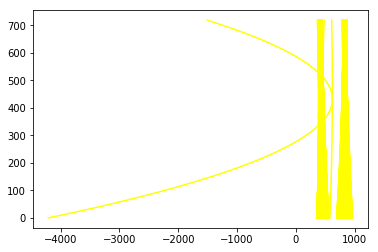

In [8]:
output = 'output_images/video_result_resubmit2.mp4'
clip = VideoFileClip('project_video.mp4')#.subclip(-3)
frame_output = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time frame_output.write_videofile(output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(frame_output))